In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt_colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

import glob

import scipy.fft as fourier
import scipy.signal as signal
from scipy.stats import linregress
from scipy.optimize import curve_fit

In [2]:
def crear_csvs():

    filenames = glob.glob('WS2/500 rpm/*.txt')
    for filename in filenames:
        file = open(filename)

        lines = []
        i = 0
        try:
            for line in file:
                i+=1
                if i>=11:
                    lines.append(line[:-1].split('\t'))
            data = pd.DataFrame(lines,columns=['Voltaje [V]','Corriente [A]'])
            data.to_csv(filename[:-4]+'.csv',index=False)
        except BaseException as error:
            print('Error de lectura: '+filename)
            print(f'{error=}')
        file.close()

#crear_csvs()

In [3]:
def procesar_datos_foto(nombre,axes):
    data = pd.read_csv(nombre)
    corriente = np.array(data['Corriente [A]']*1e6)
    voltaje = np.array(data['Voltaje [V]'])
    
    fontsize = 24
    
    reg = linregress(corriente,voltaje)
    
    return (corriente,voltaje,corriente*reg.slope+reg.intercept,reg.slope,reg.intercept,reg.rvalue**2)

def ajuste_lineal(corriente,voltaje,metadata=False):
    if metadata:
        return linregress(corriente,voltaje)
    else:
        m,b,*_ = linregress(corriente,voltaje)
        return m*corriente + b
    
def extraer_csv(filename,strainlist,slopes):    
    t=0.12
    L=12.2
    strainpercent=strainlist*t*6/(L**2)*100
    m_rel=(slopes-slopes[0])/slopes[0]
    dict={'Strain': strainlist, 'Strain percentage': strainpercent, 'Resistance (G\u03A9)': slopes, 'Relative change of resistance': m_rel}
    df = pd.DataFrame(dict)
    df.to_csv(filename[:-14]+'Slopes_{}0mm.csv'.format(strainlist[10]))

In [4]:
def extraer_datos_foto(nombre,axes):
    
    (corriente,voltaje,reg,m,b,r_value) = procesar_datos_foto(nombre,axes)
    #m = reg.slope
    #b = reg.intercept
    #r_value = reg.rvalue**2
    fontsize = 24
    
    fig_original = axes
    fig_original.scatter(corriente,voltaje,label='Data')
    fig_original.plot(corriente,reg,c='r',label='Fit')
    
    delta_x = np.amax(corriente)-np.amin(corriente)
    delta_y = np.amax(voltaje)-np.amin(voltaje)
    fig_original.set_xlim(np.amin(corriente),np.amin(corriente)+(delta_x*1.))
    fig_original.set_ylim(np.amin(voltaje)-delta_y*0.1,np.amin(voltaje)+delta_y*1.)
    
    fig_original.legend(fontsize=fontsize)
    fig_original.label_outer()
    fig_original.set_xlabel('Corriente ($\mu $A)',fontsize=fontsize)
    fig_original.set_ylabel('Voltaje (V)',fontsize=fontsize)
    fig_original.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    fig_original.yaxis.set_major_locator(plt.MaxNLocator(4))
    fig_original.tick_params(axis='both',labelsize=24)
    fig_original.legend(prop={'size': 22})
    
    return m,b,r_value

[55.875436347554206, 55.80246050905614, 55.70109636910049, 55.88174251228776, 56.385481452594675, 53.39070222776647, 52.46704013481968, 51.840383511446525, 51.75124847695879, 51.71163787936534, 51.41914978607127]


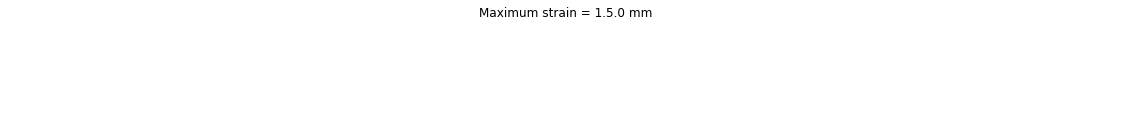

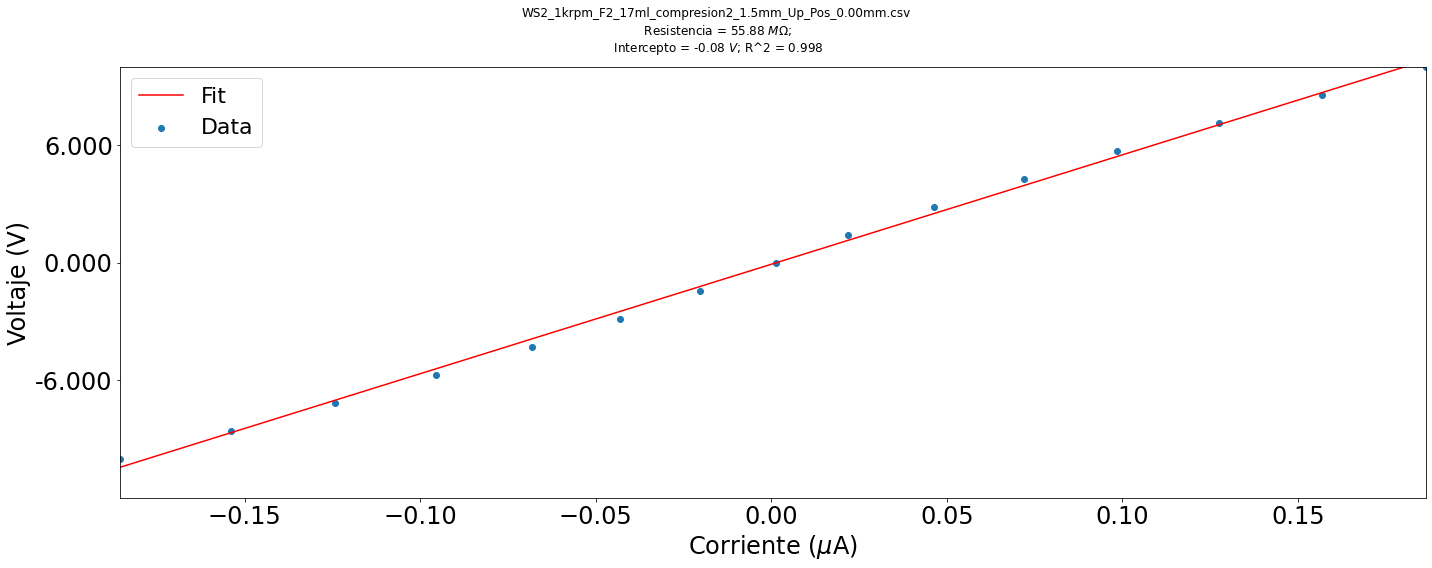

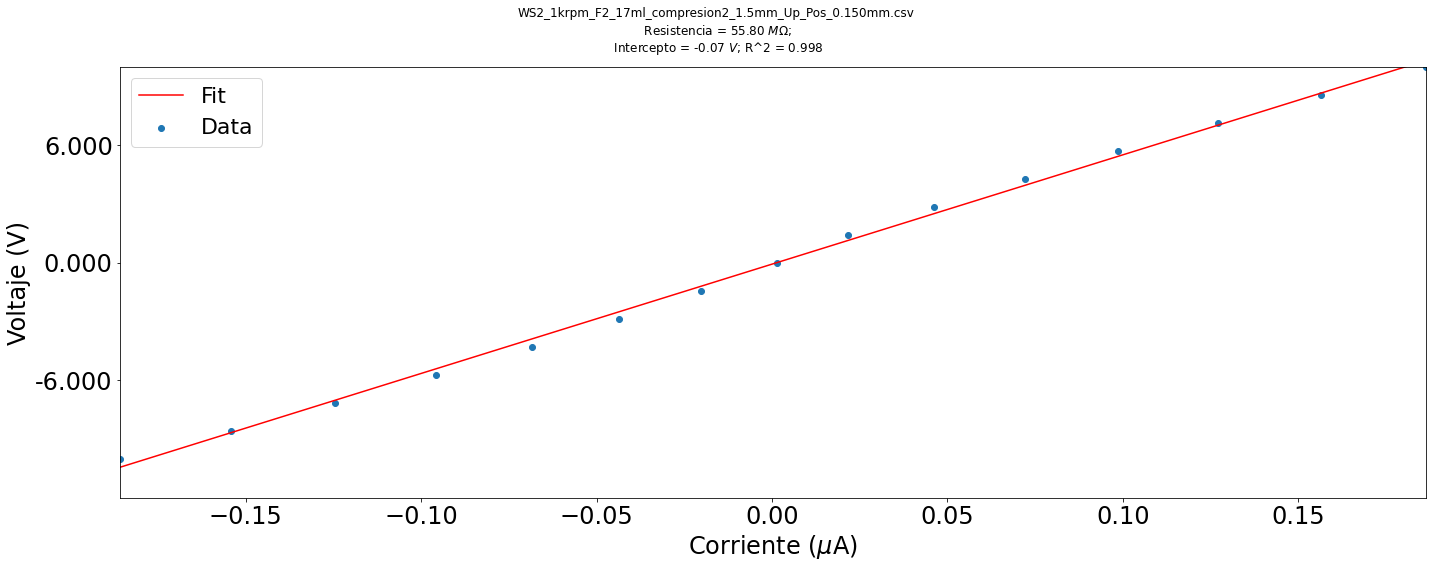

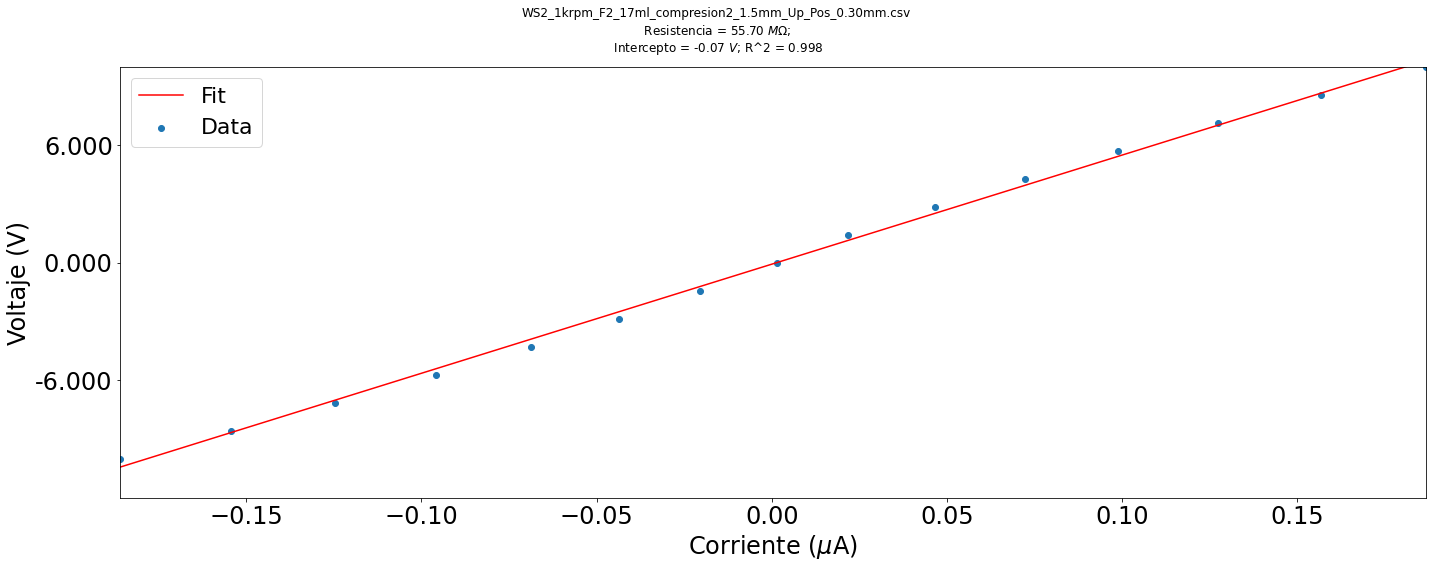

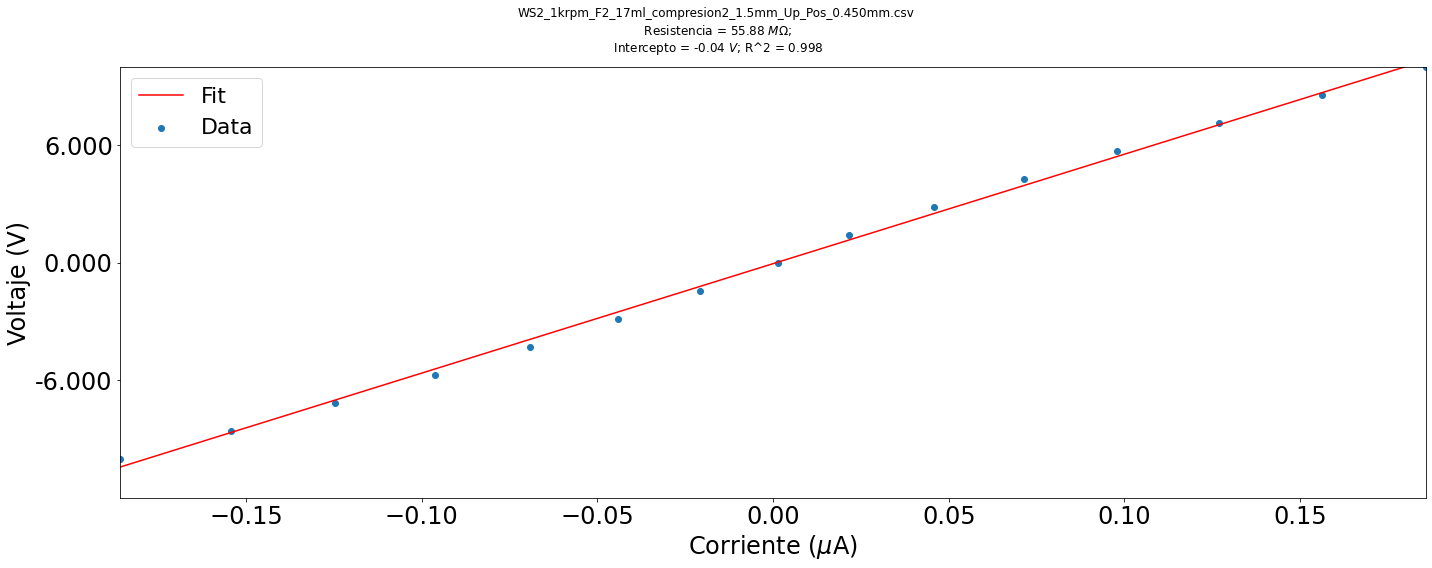

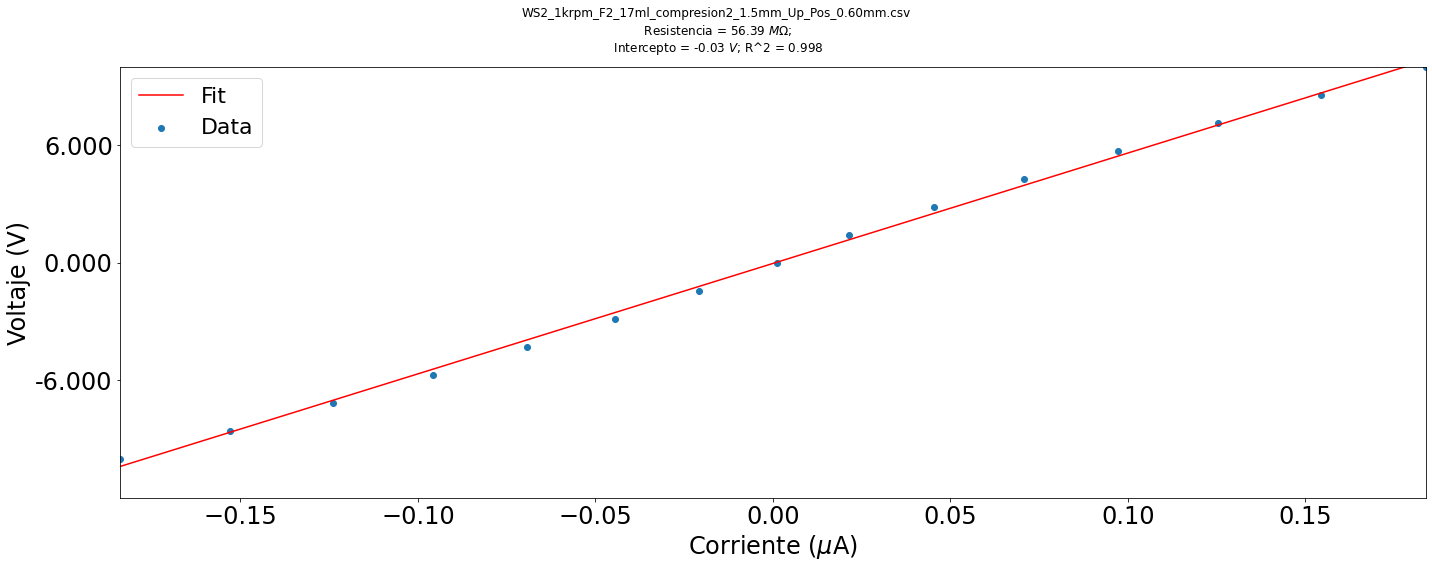

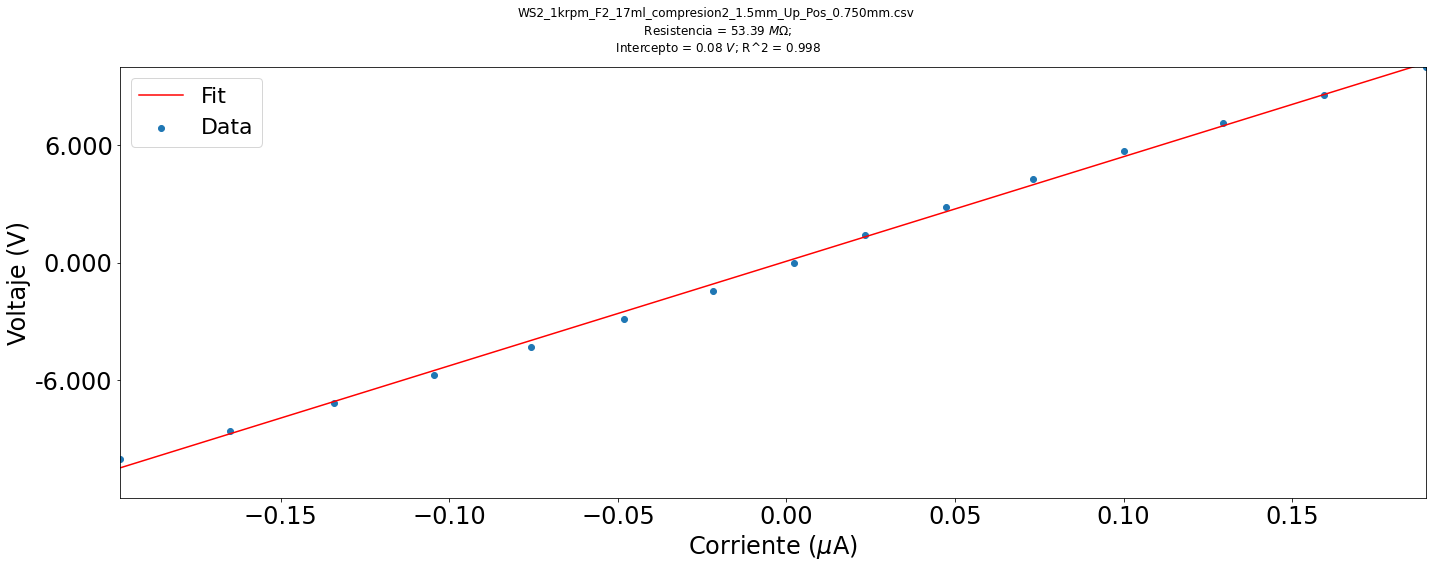

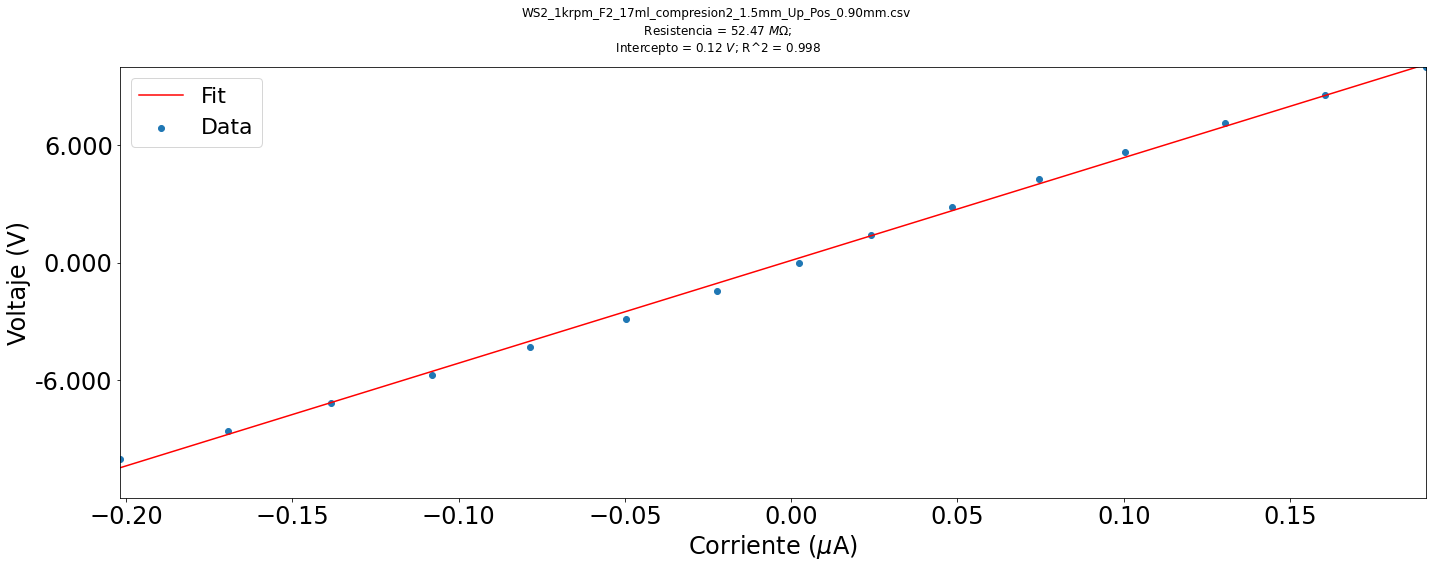

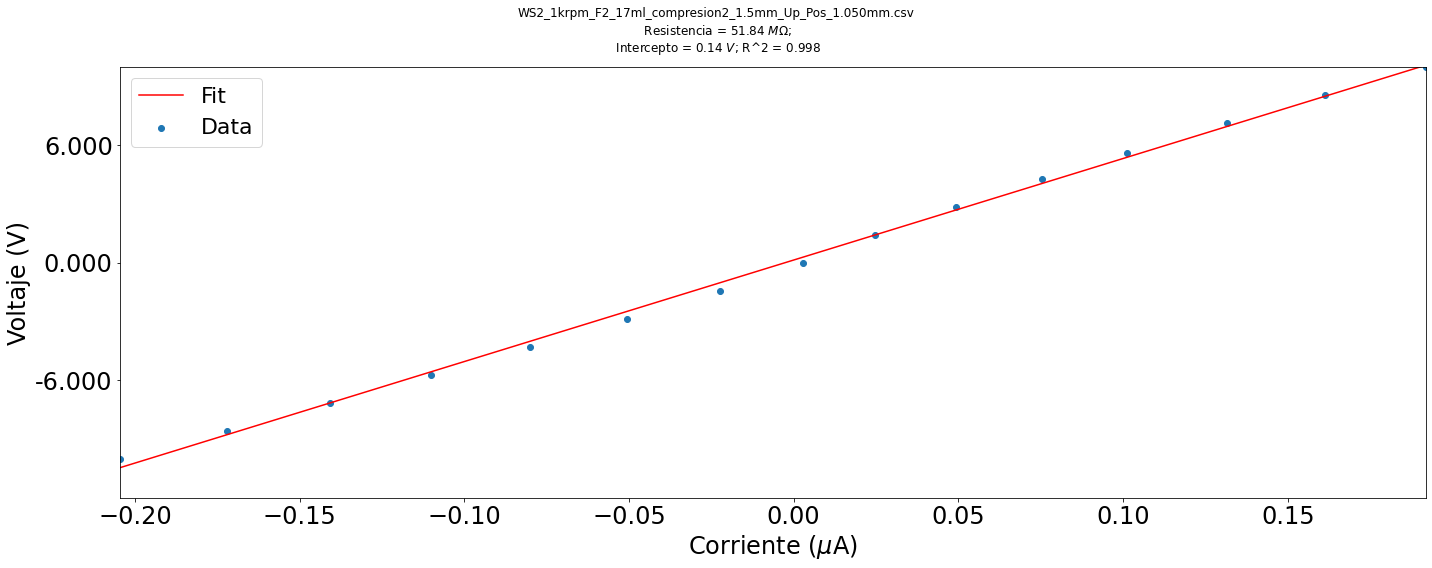

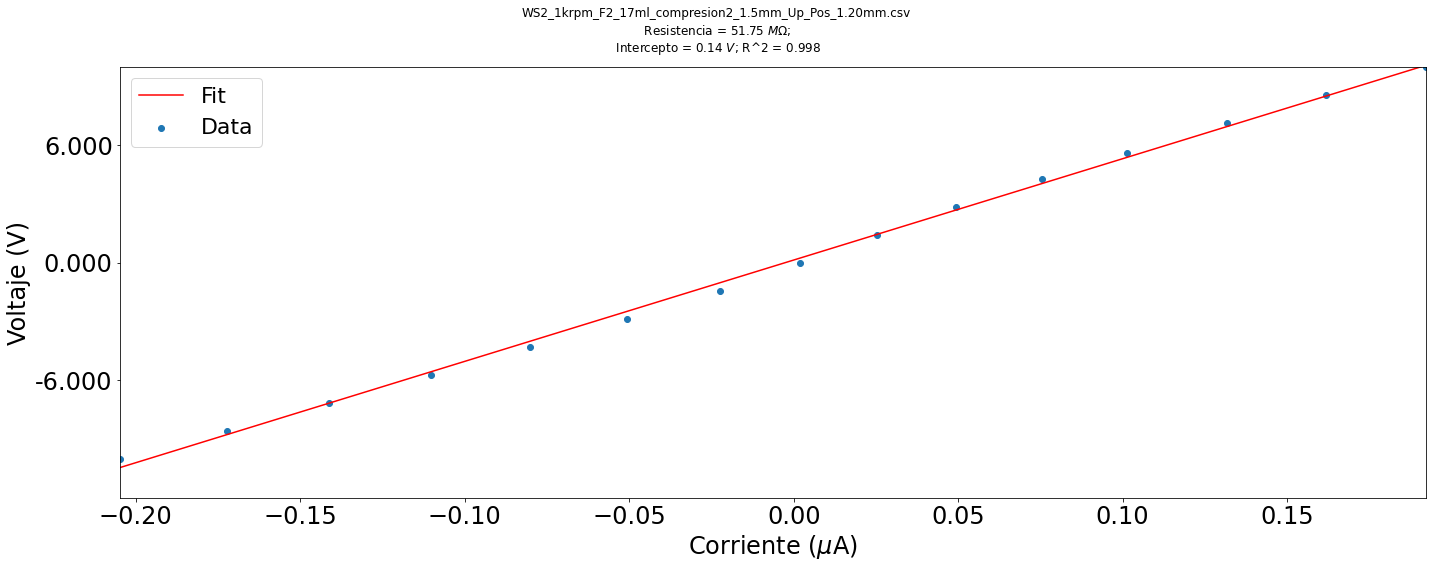

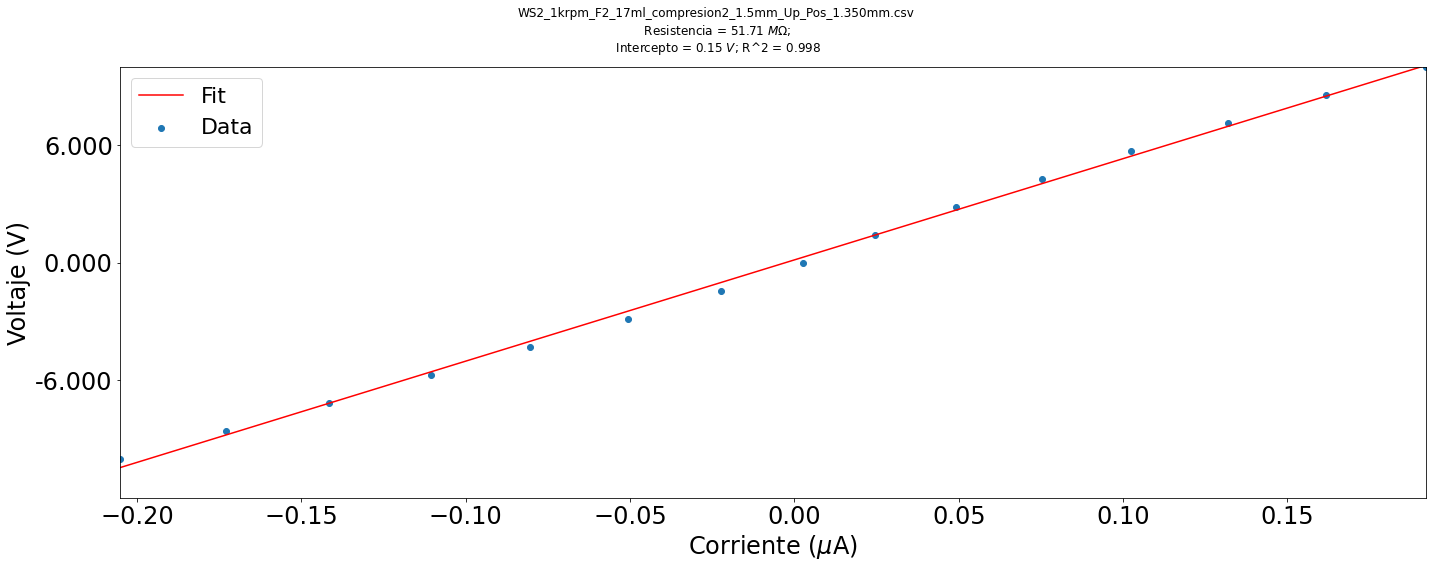

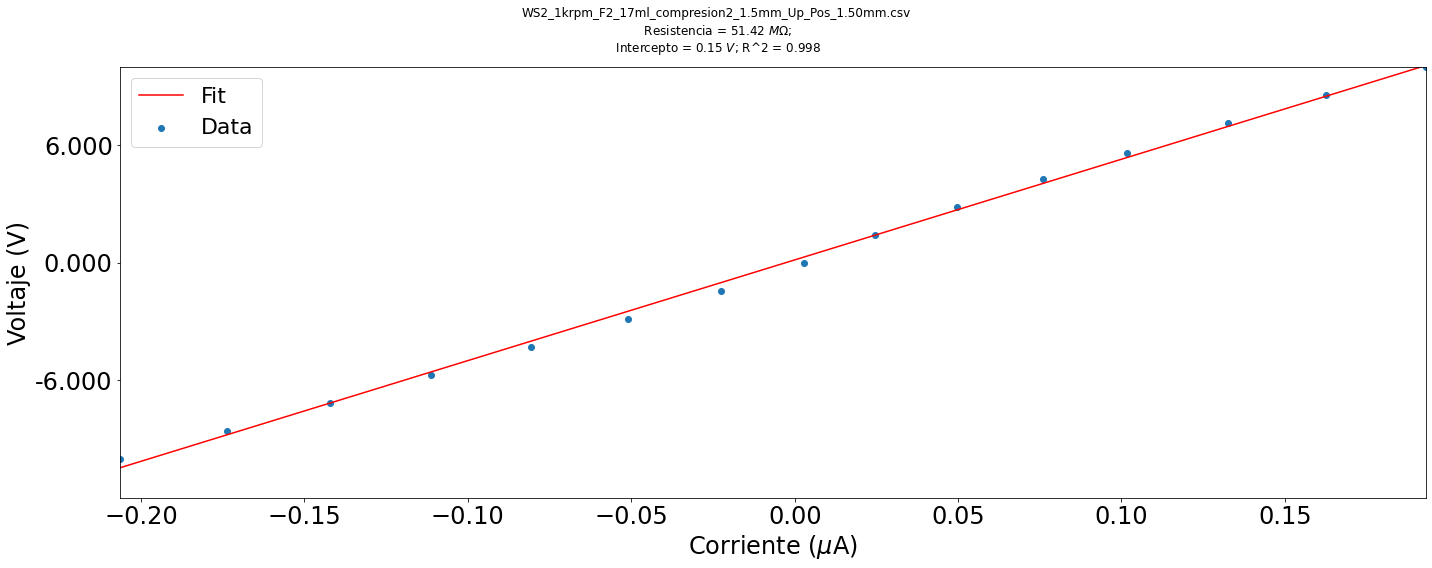

In [12]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_1krpm_F2_17ml_compresion2_1.5mm_Up_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1.5
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ M\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[53.62128794060485, 53.80499879343316, 53.84634933072133, 53.93041177190898, 54.164972756128265, 54.405579359692474, 55.322444725270664, 56.21268215890011, 56.07574696122333, 51.6616748695965, 51.251352713298765]


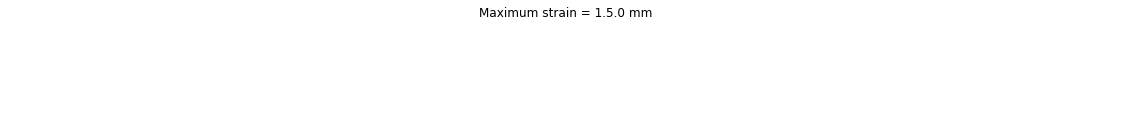

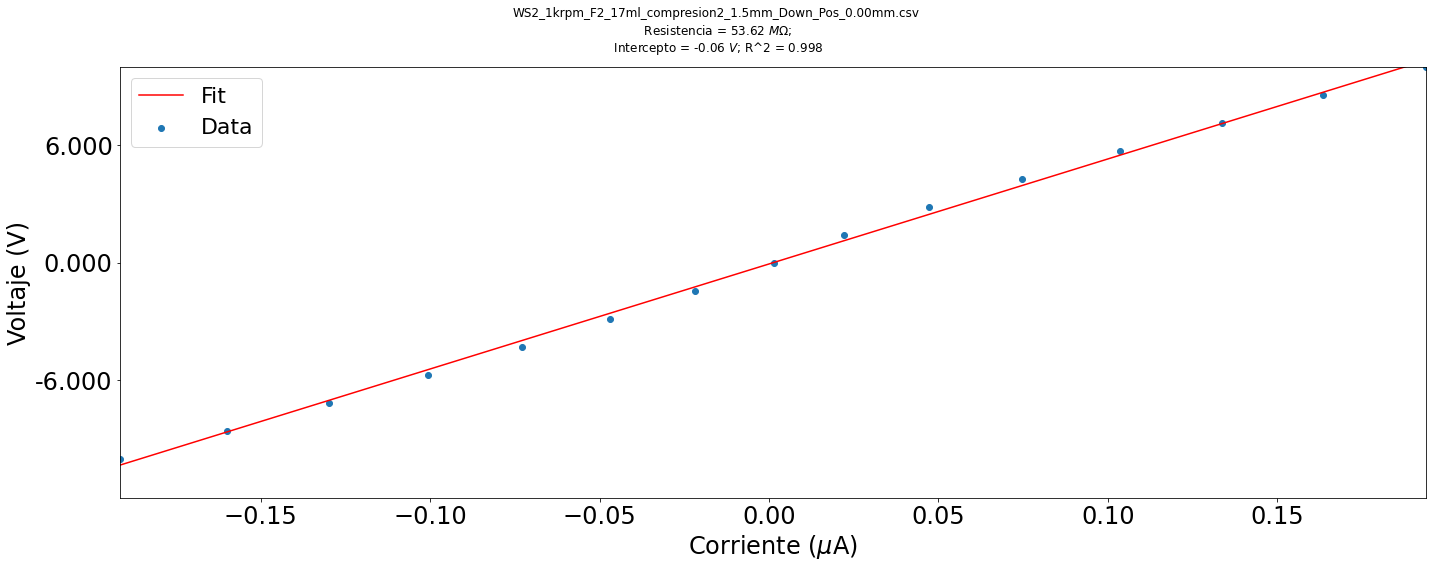

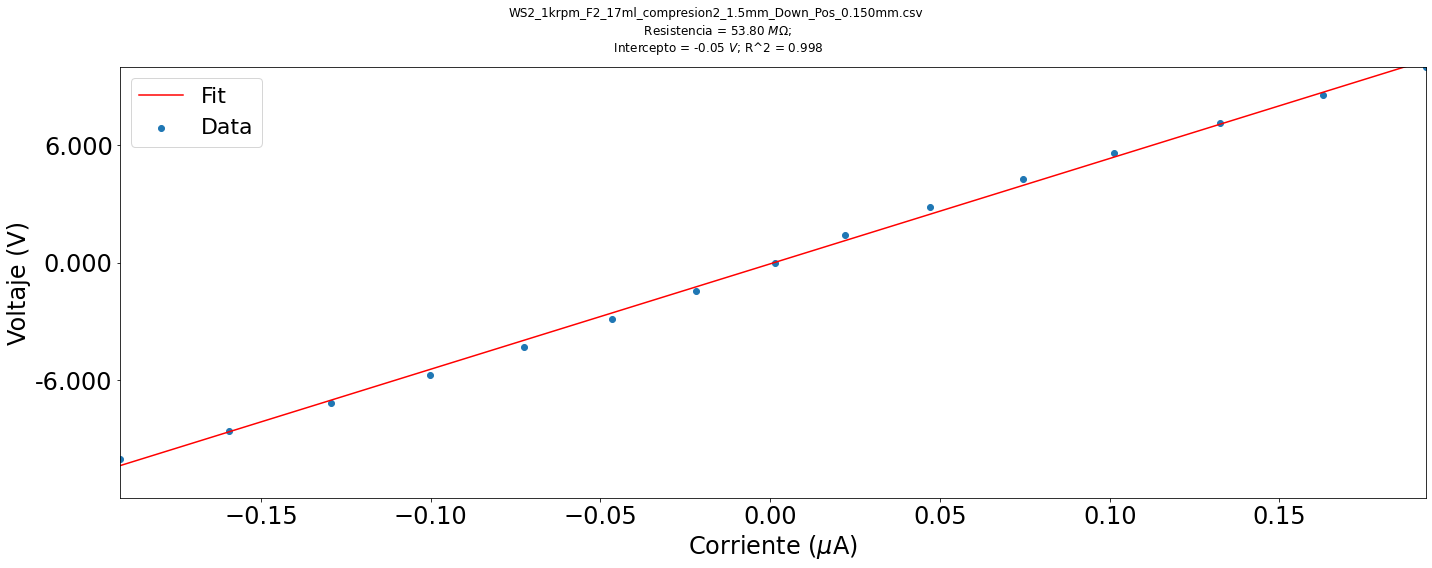

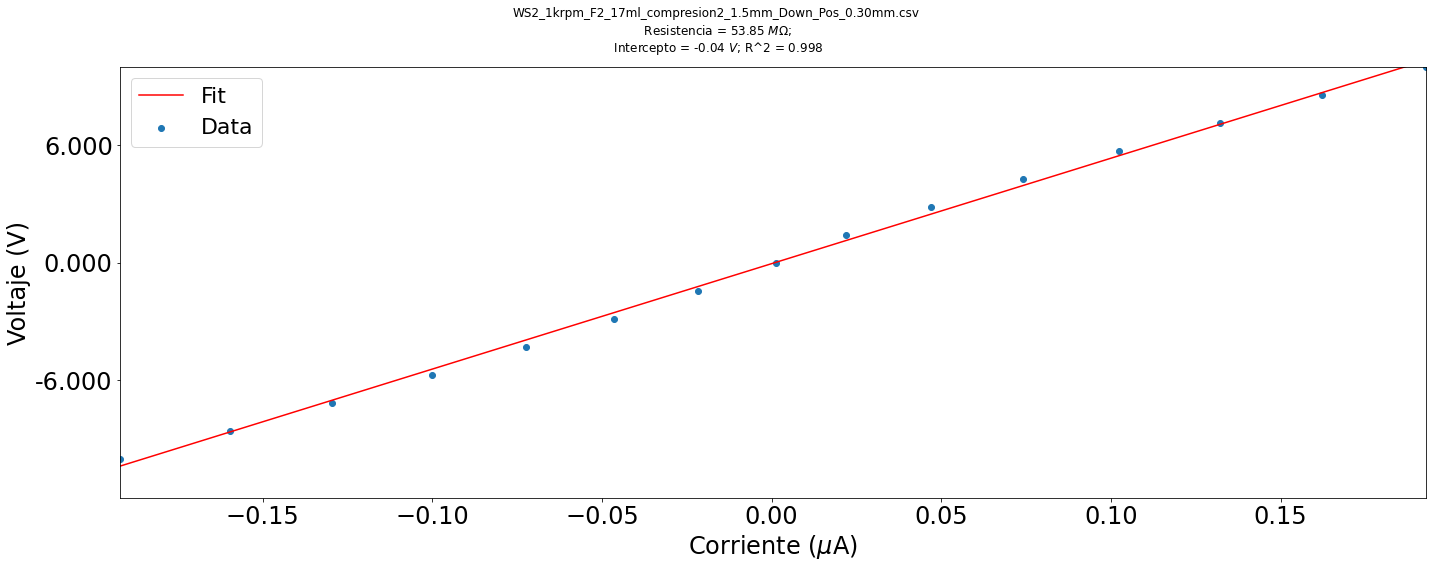

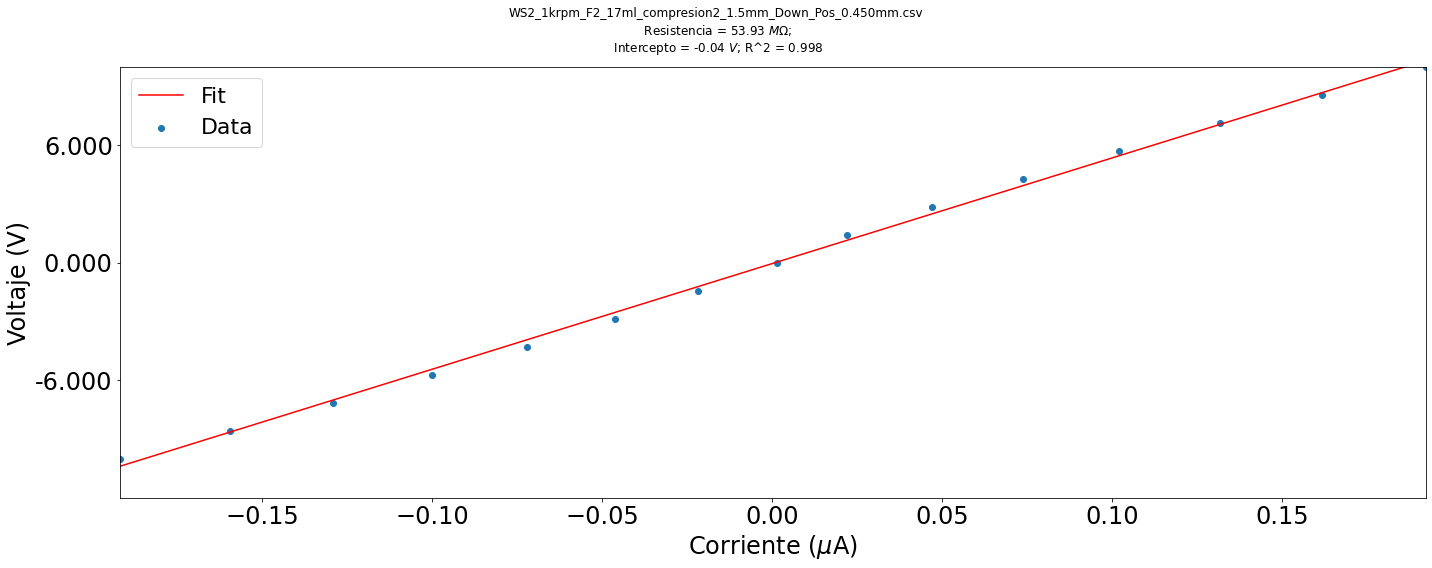

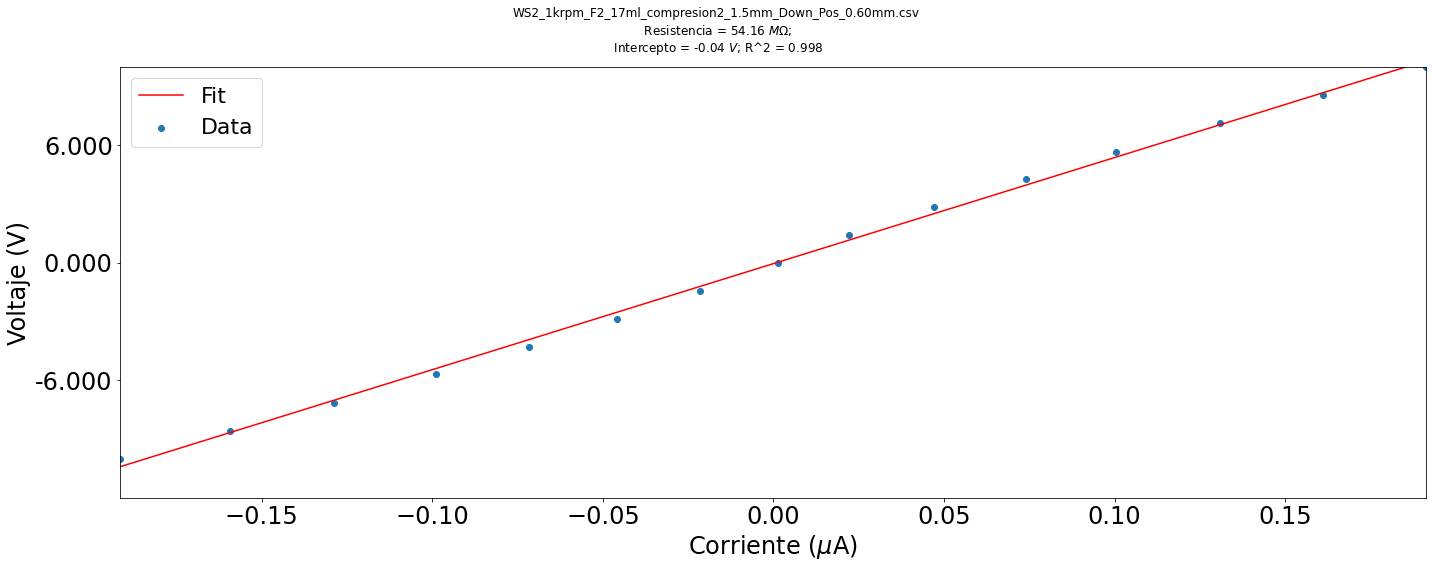

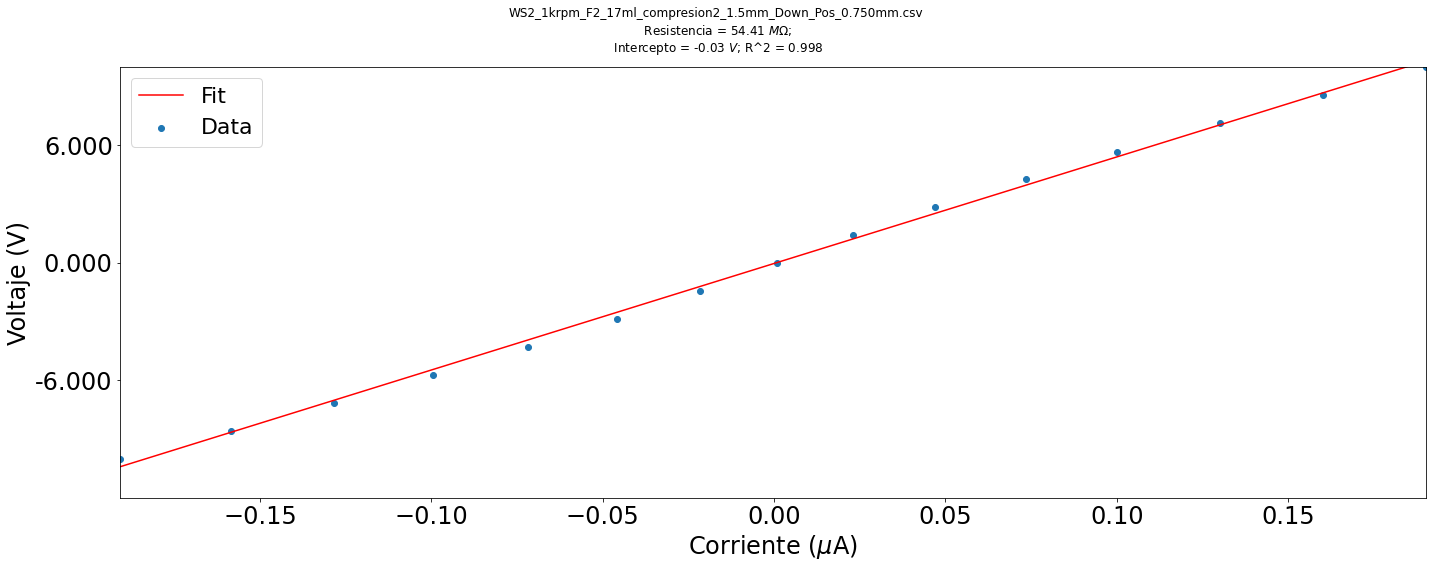

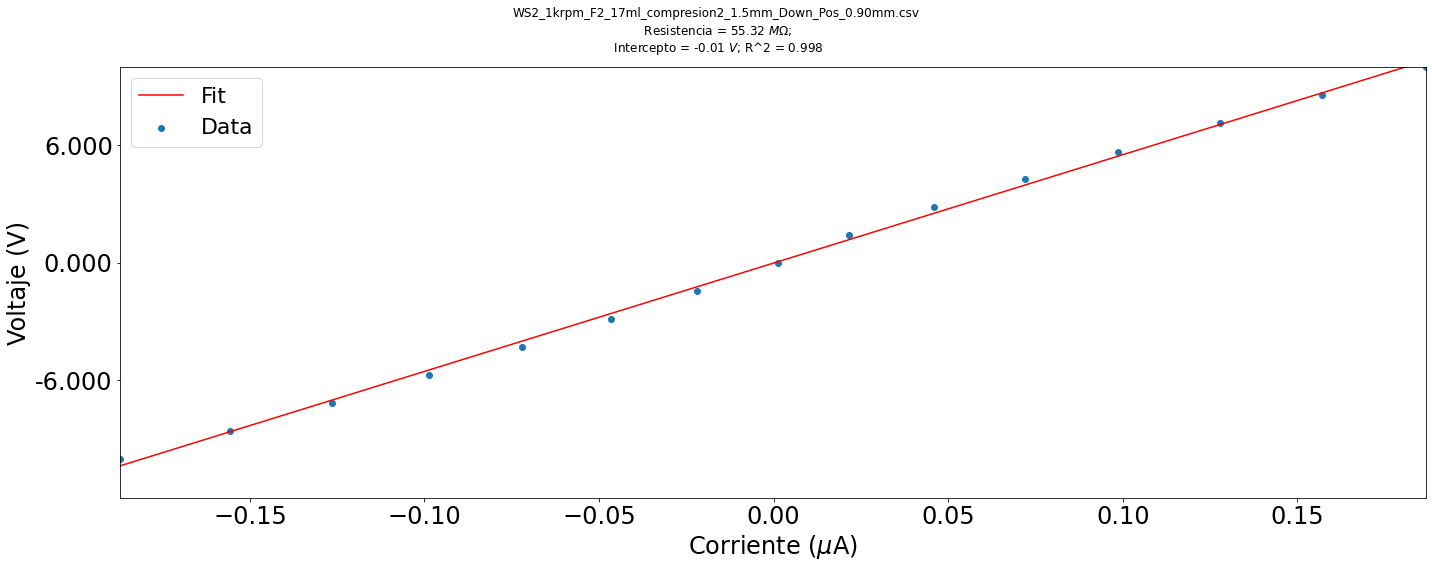

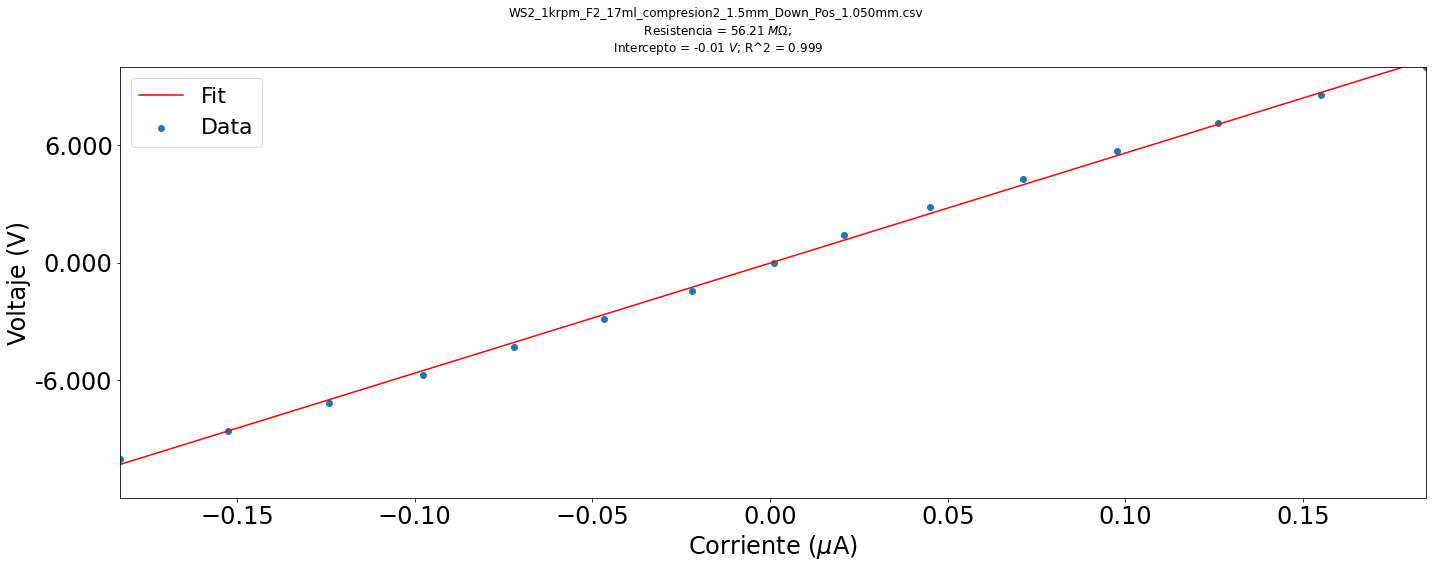

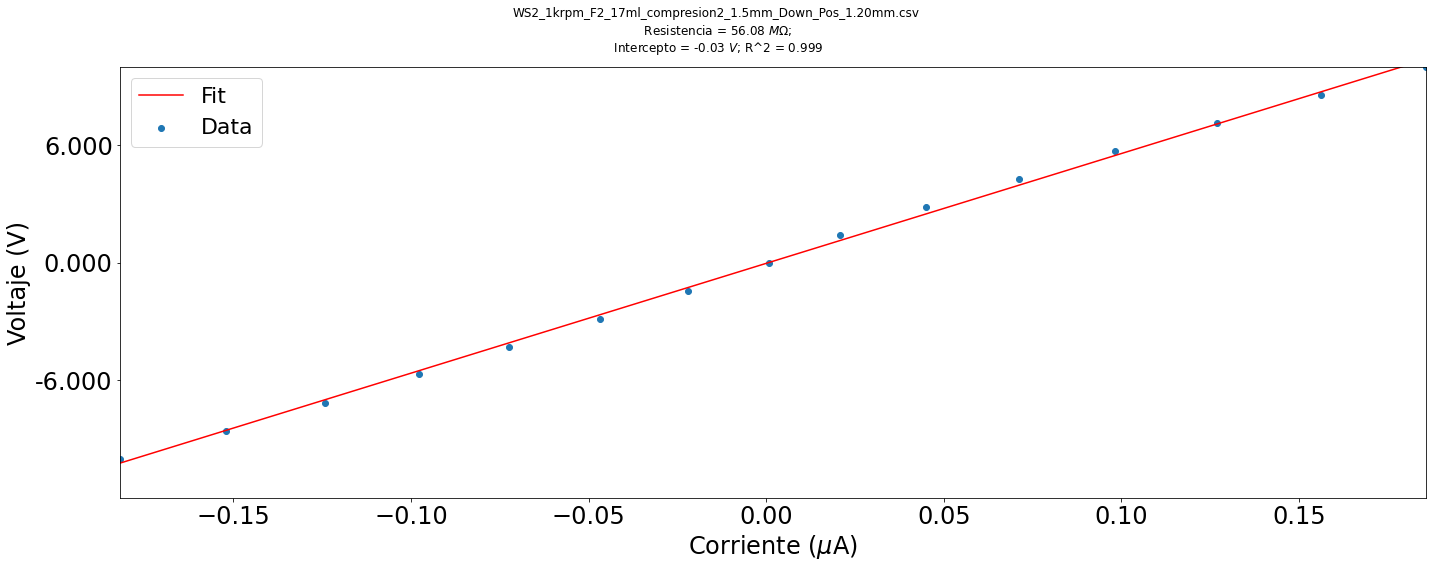

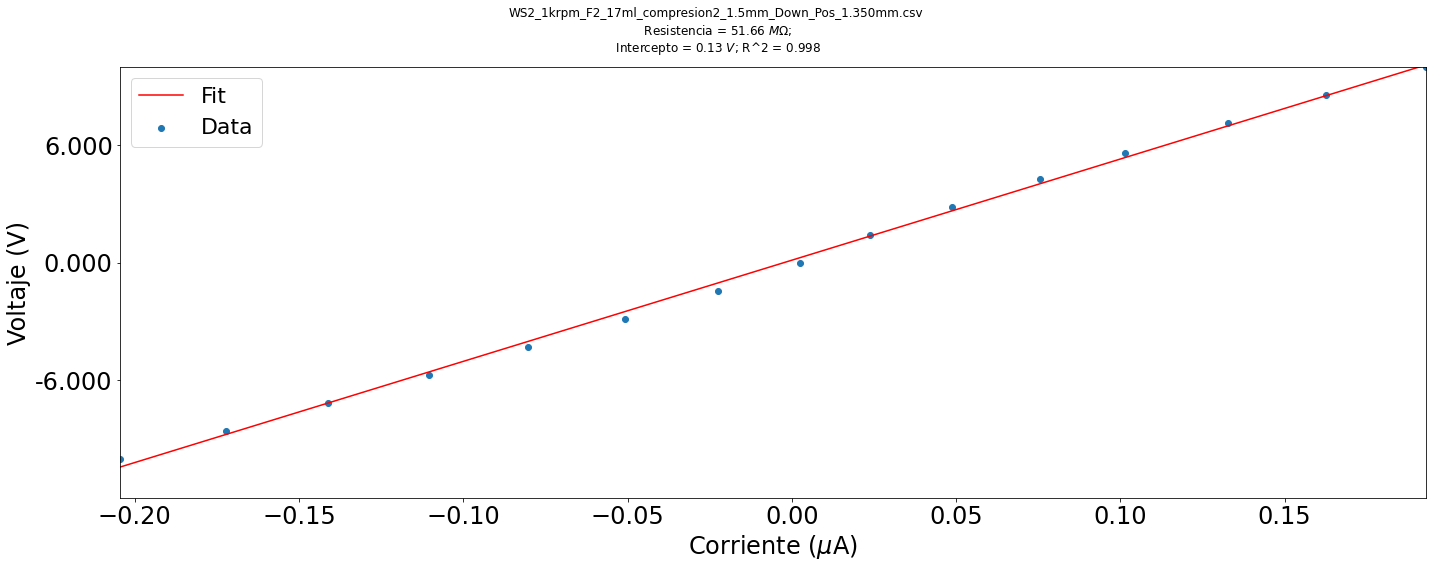

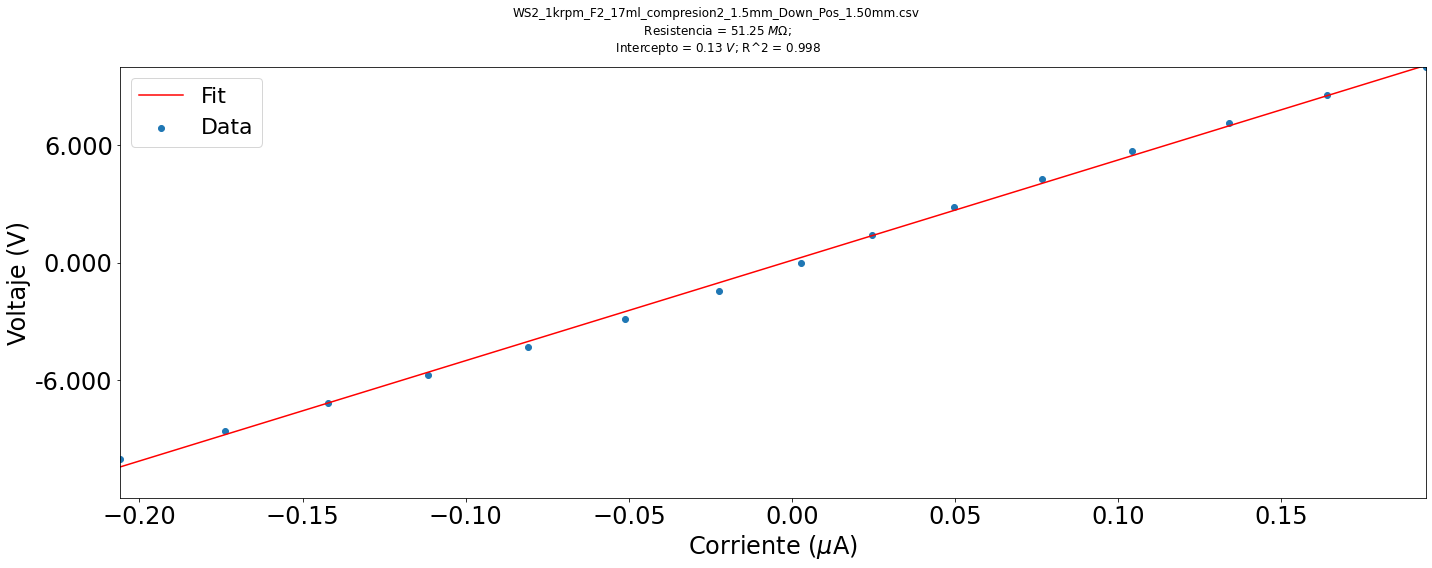

In [10]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_1krpm_F2_17ml_compresion2_1.5mm_Down_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1.5
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ M\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[53.33410179475623, 53.2754679746567, 53.08951838681683, 53.01446195698655, 53.01342753843011, 52.996664378929125, 52.965155060450655, 52.83611364006731, 52.884599057566945, 53.032297702364176, 52.672078171290885]


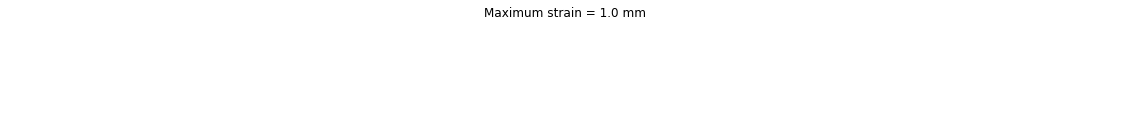

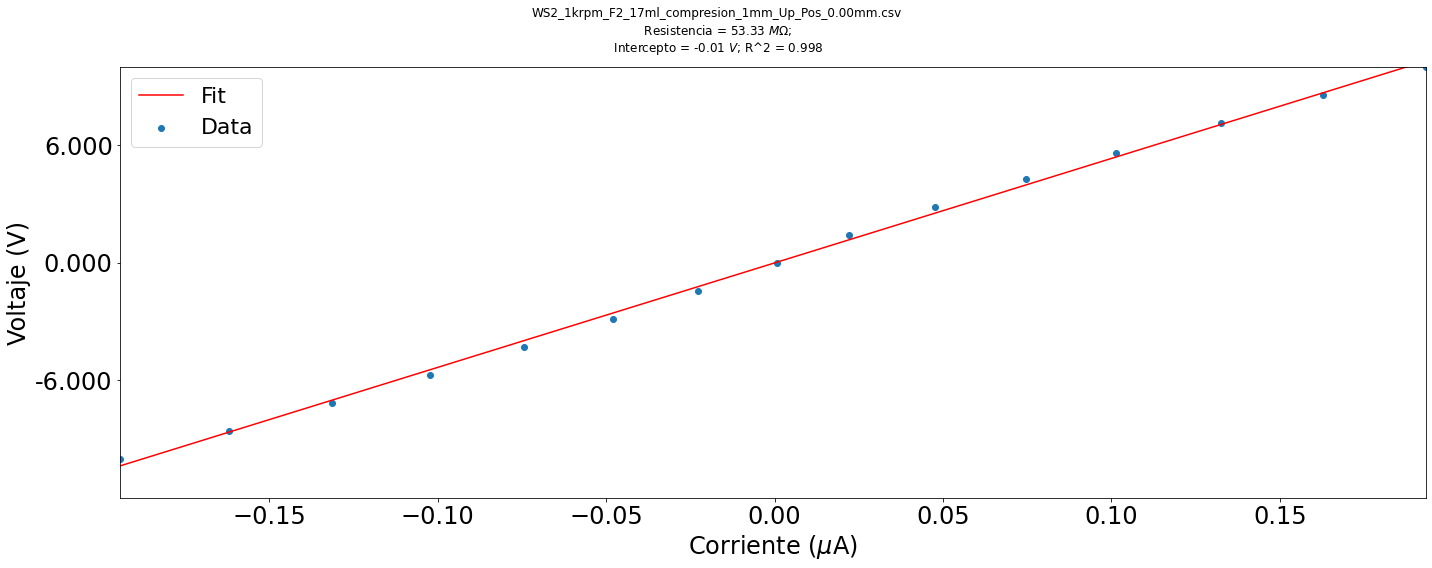

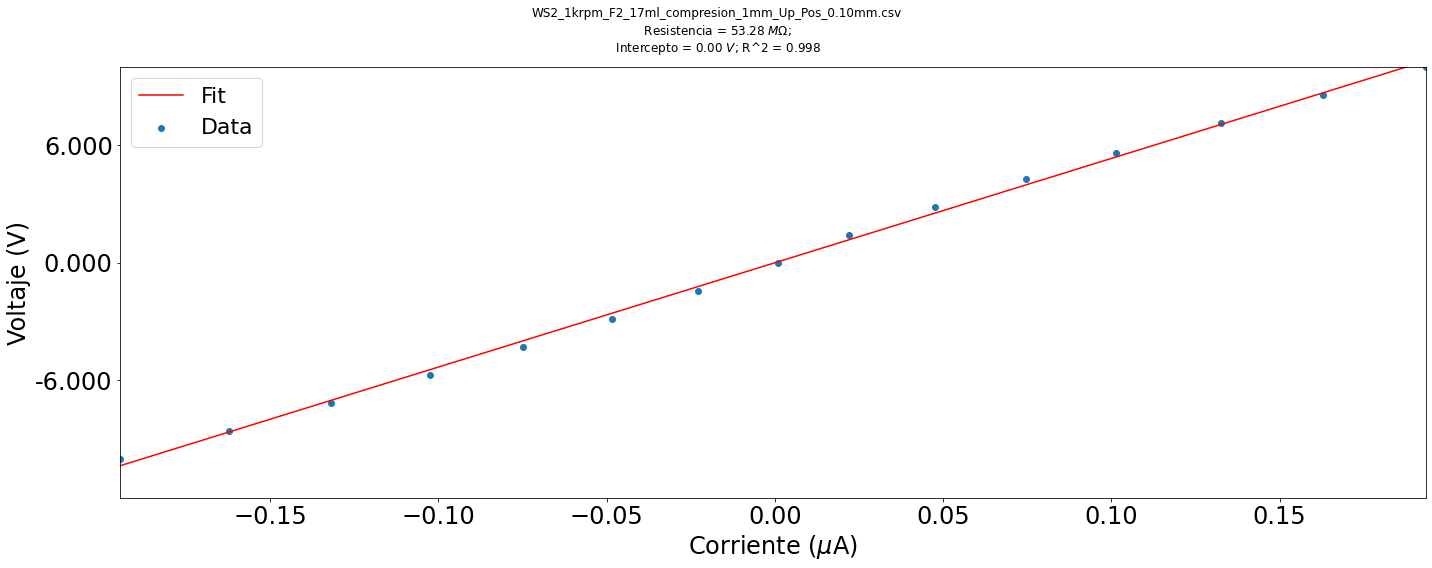

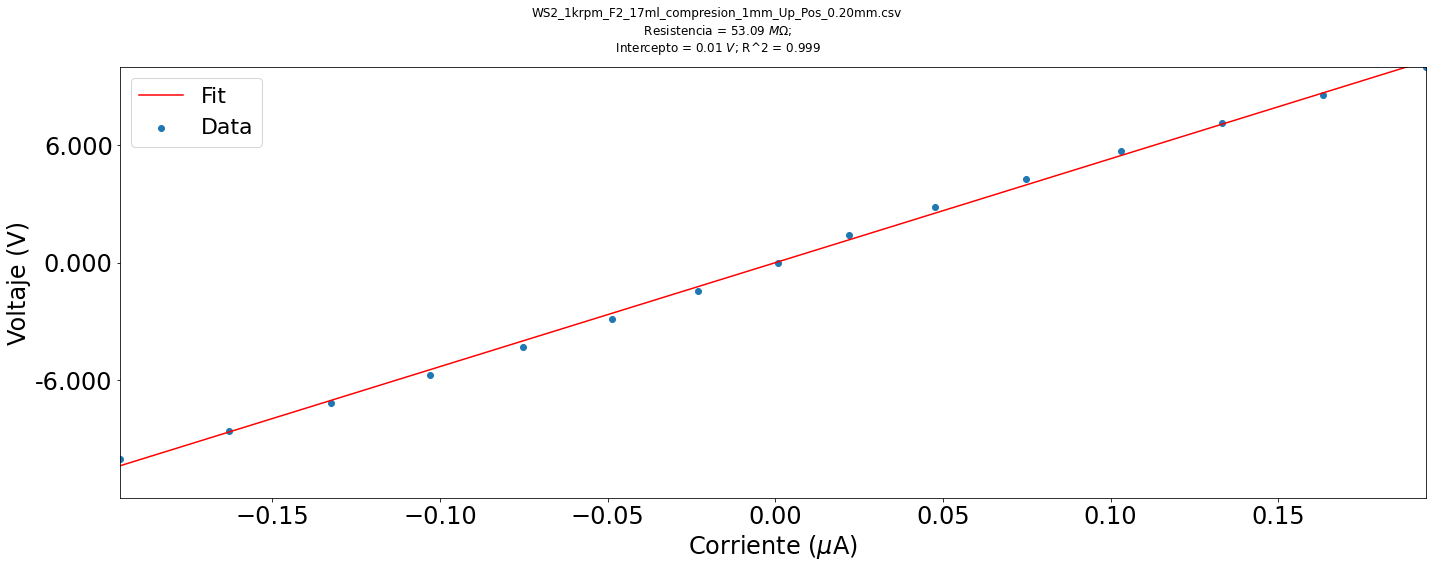

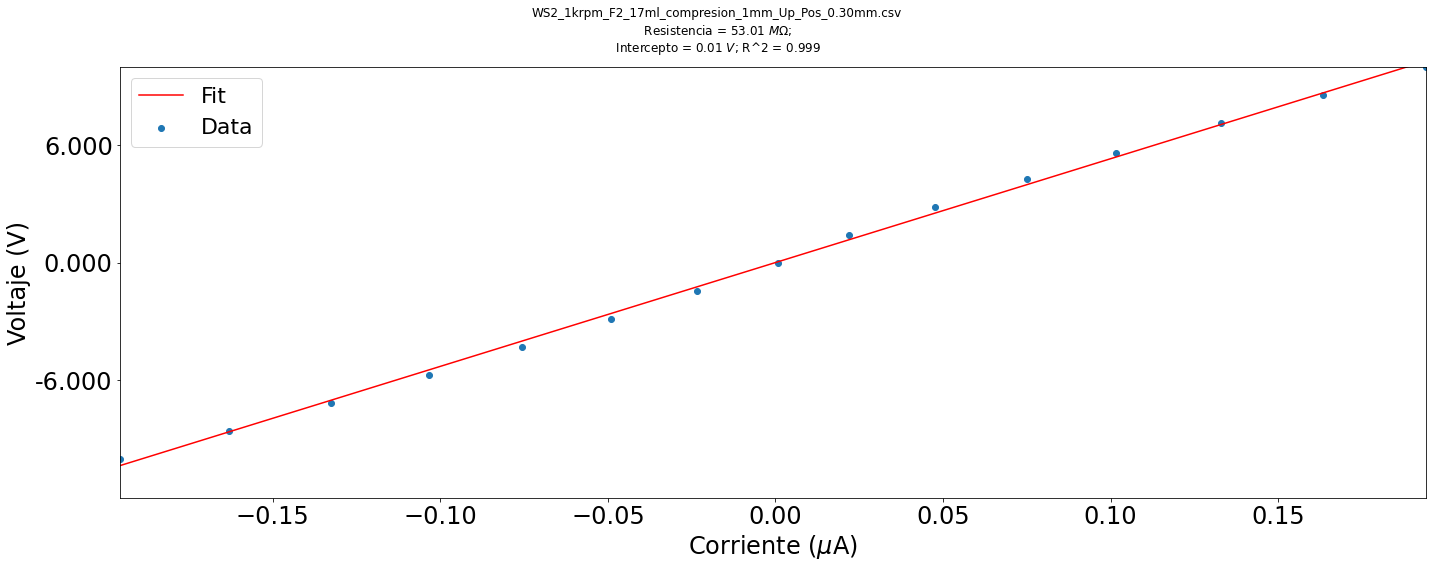

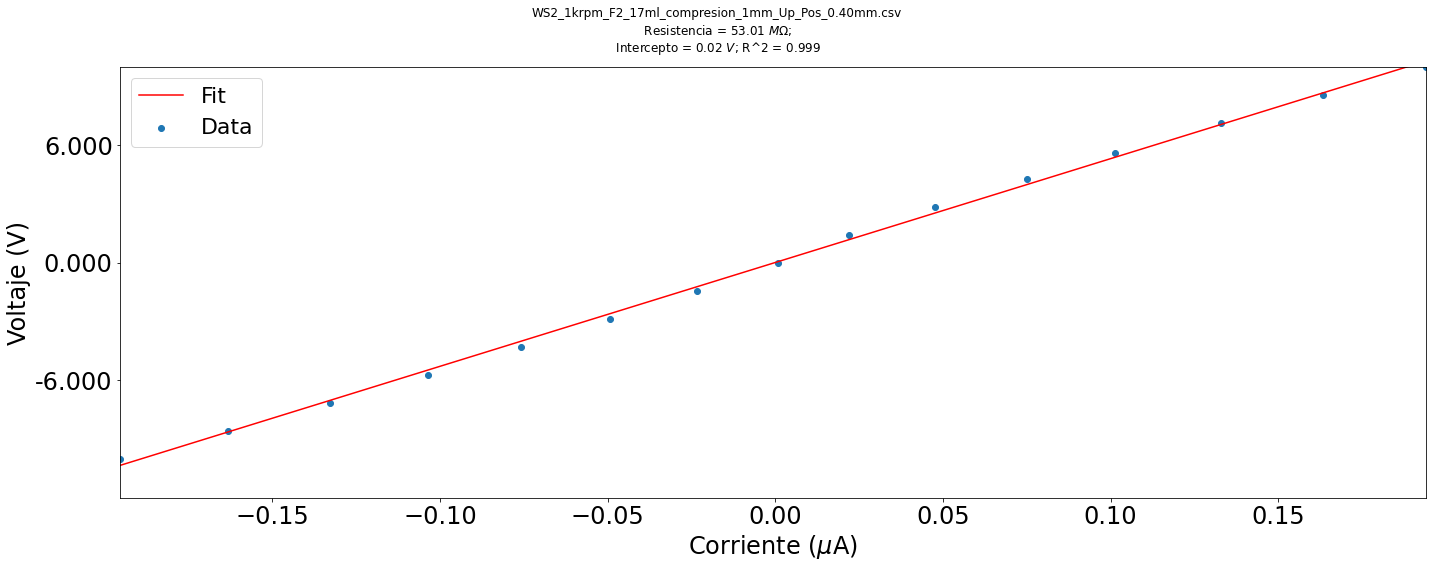

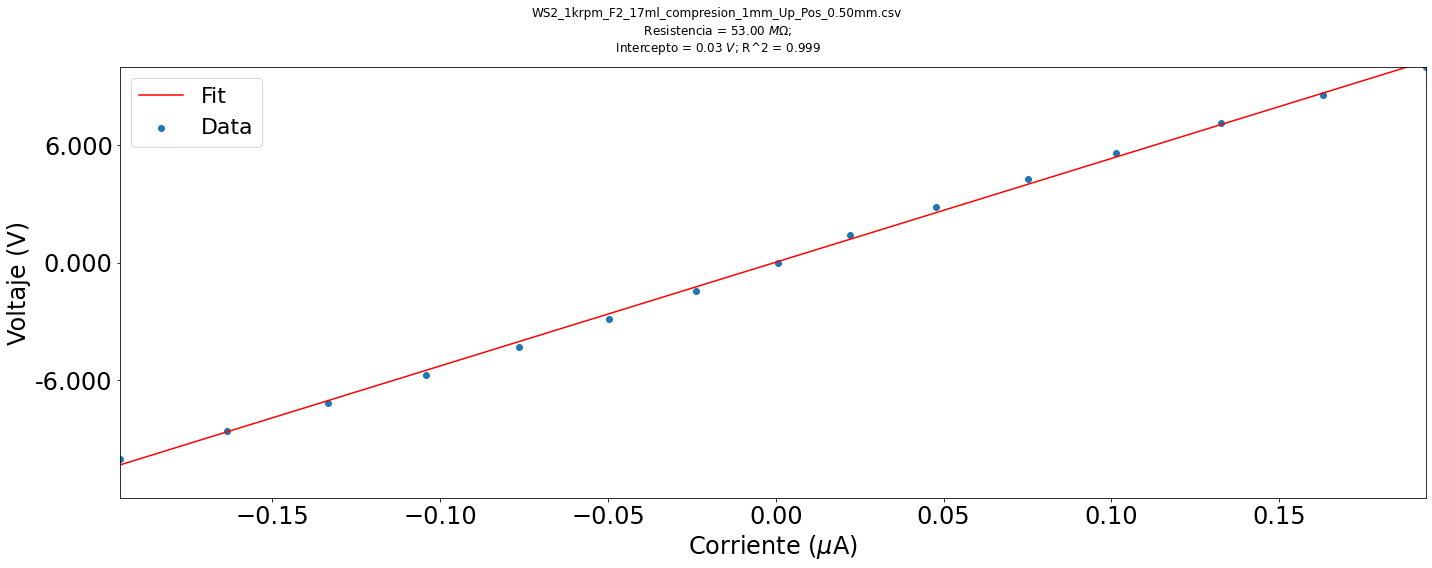

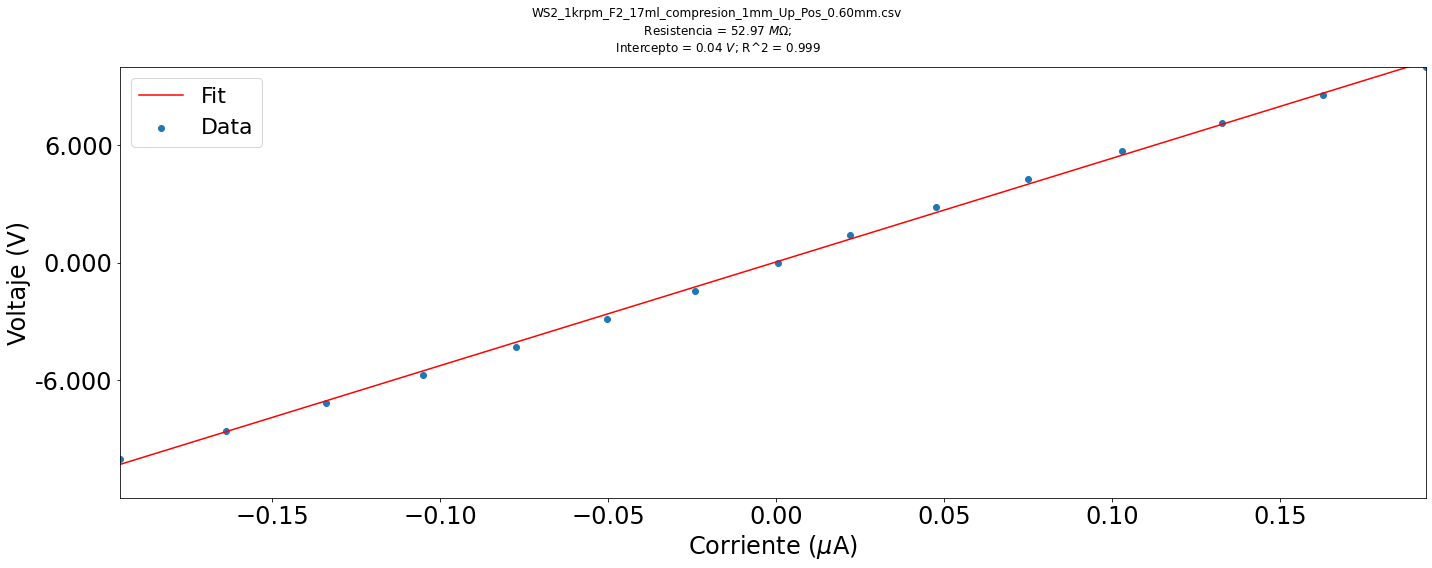

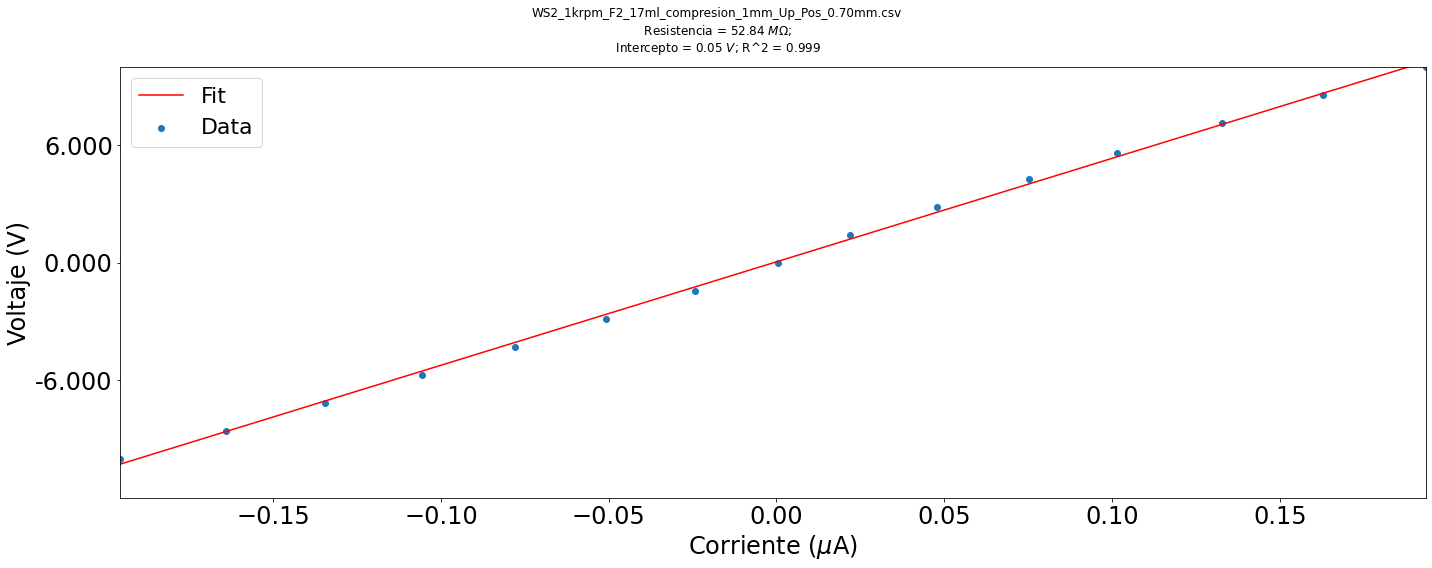

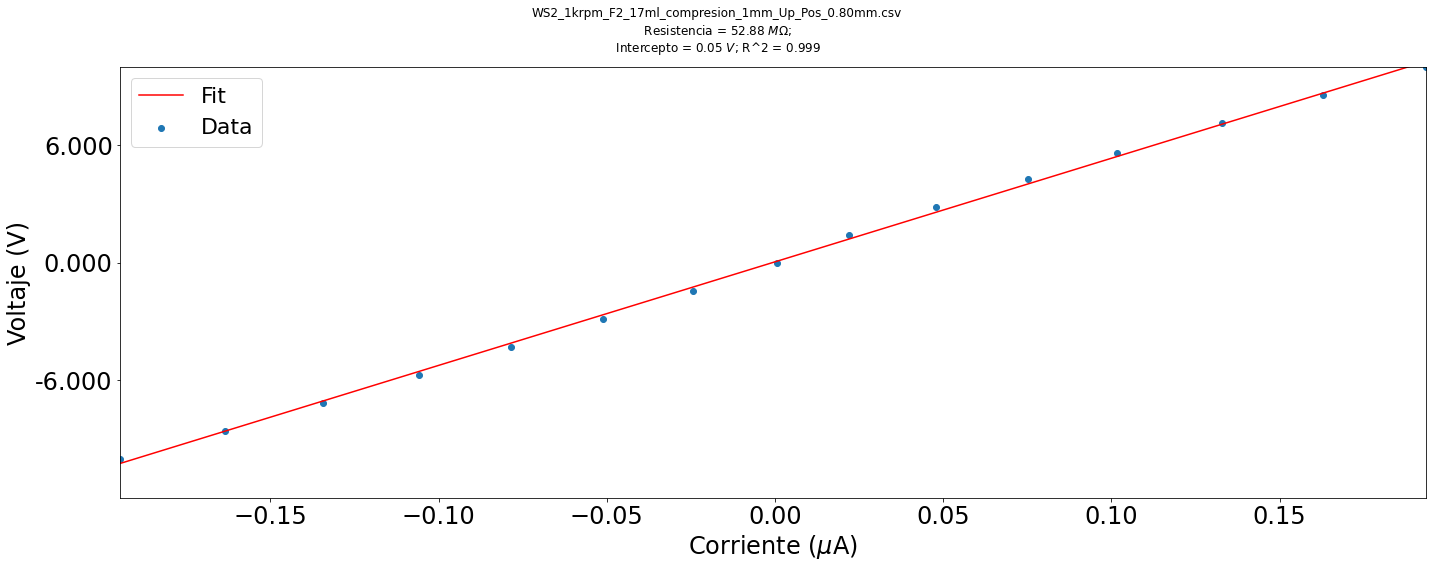

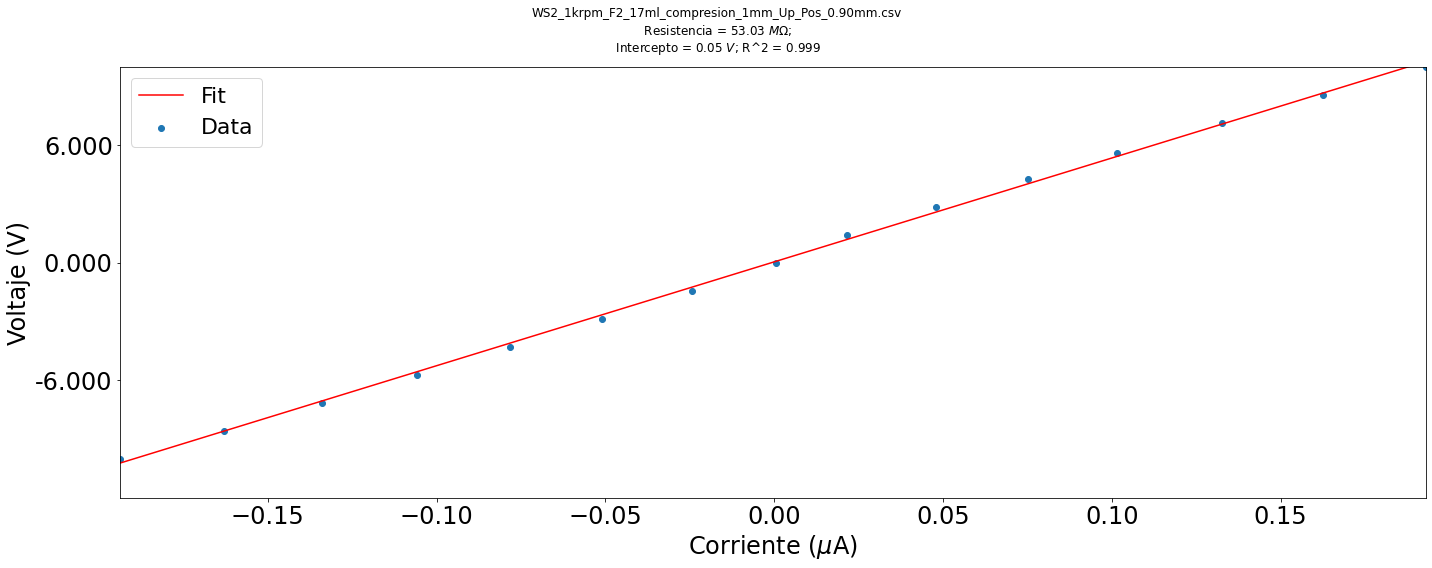

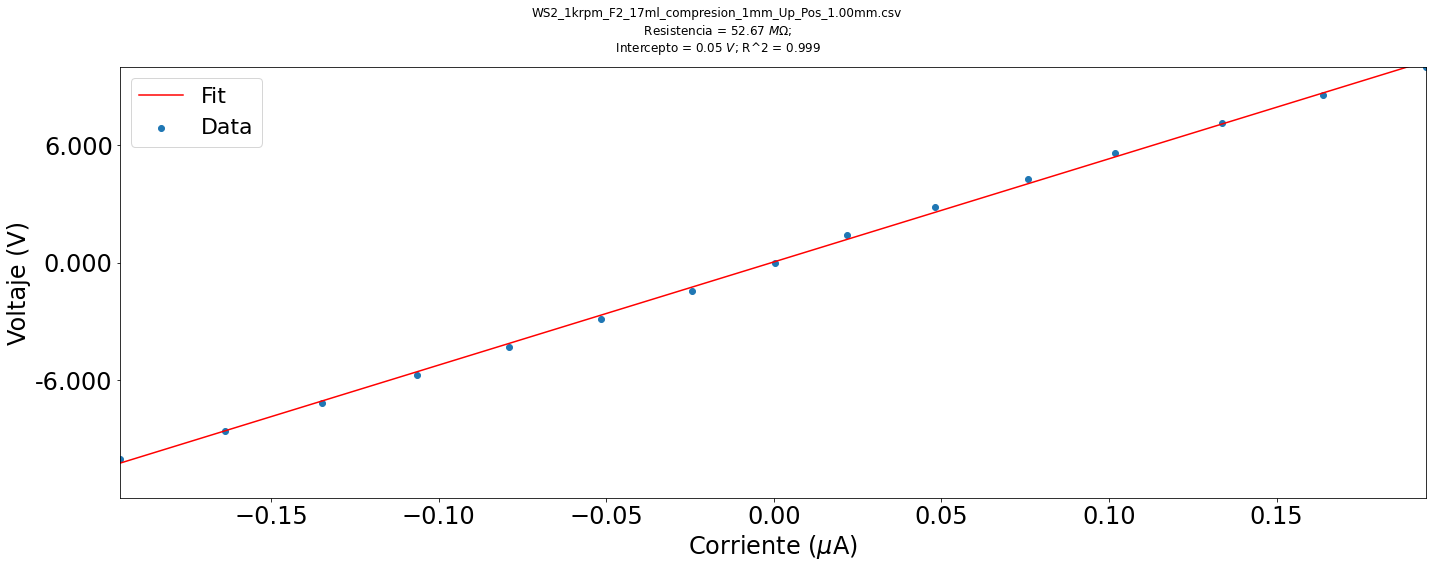

In [9]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_1krpm_F2_17ml_compresion_1mm_Up_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ M\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[48.74711907538714, 49.43569336580777, 49.81854072382836, 49.98870693231281, 50.149305869274734, 50.37241618247235, 50.64532570168535, 50.83337510854684, 50.983916476065914, 51.14105353752962, 52.6503754865206]


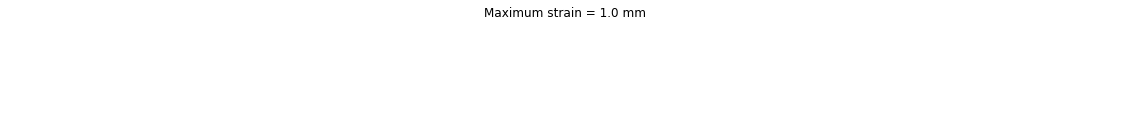

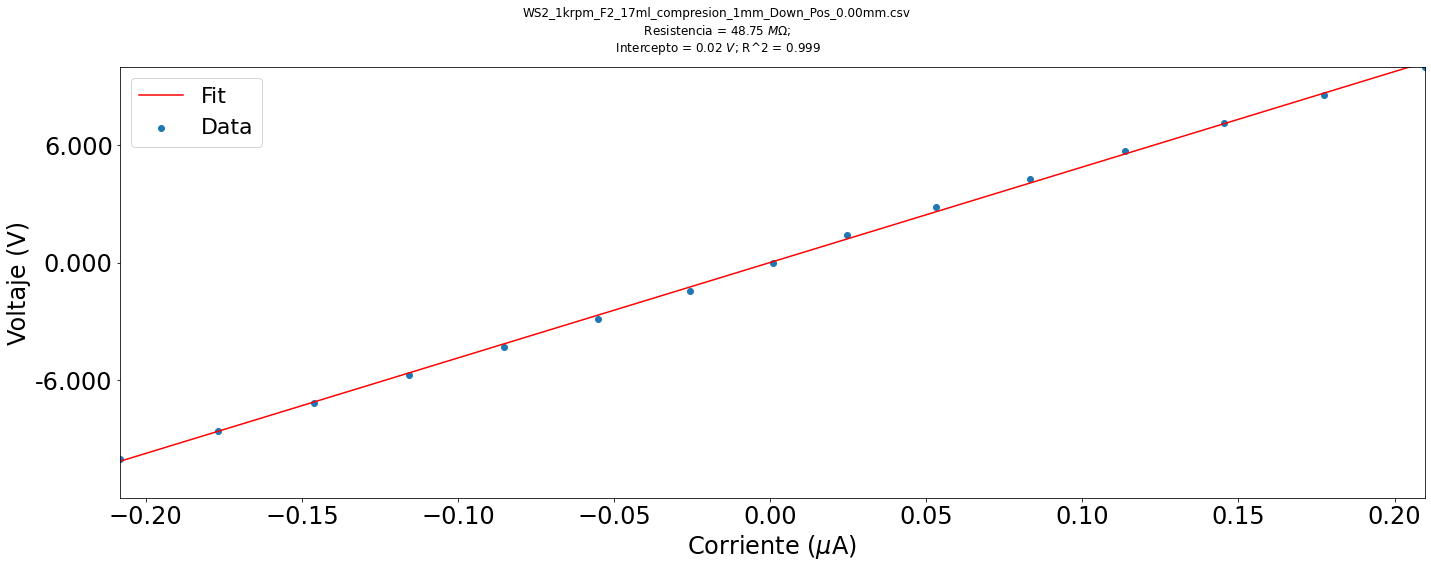

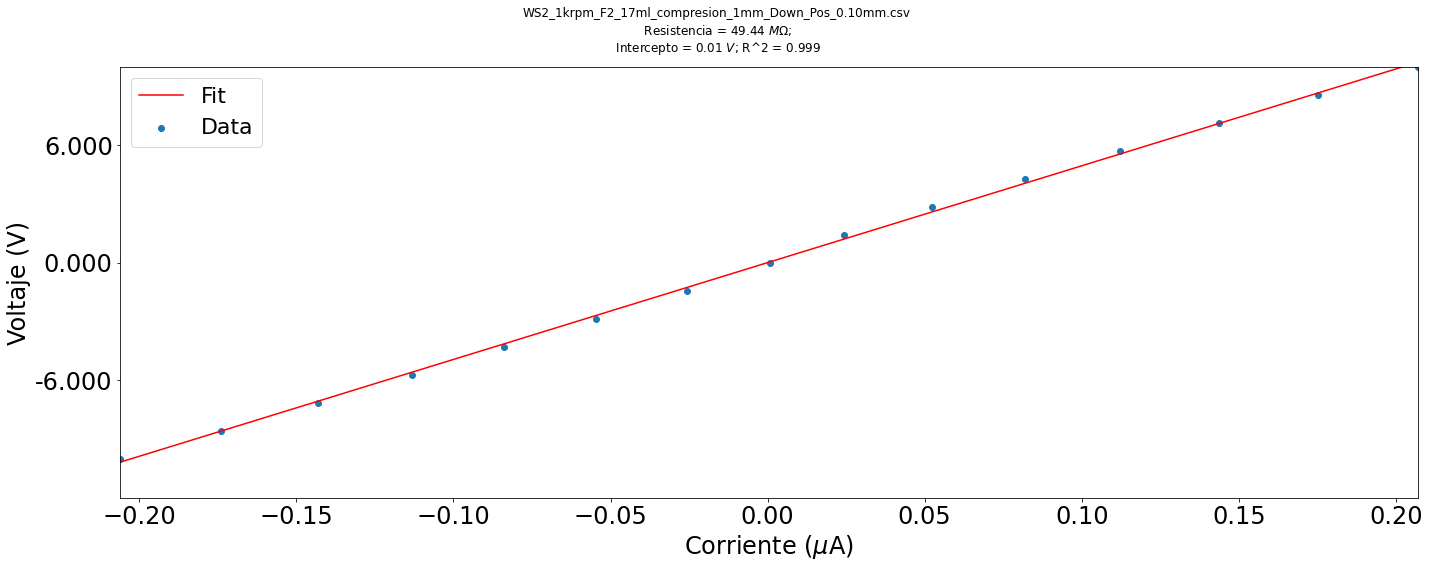

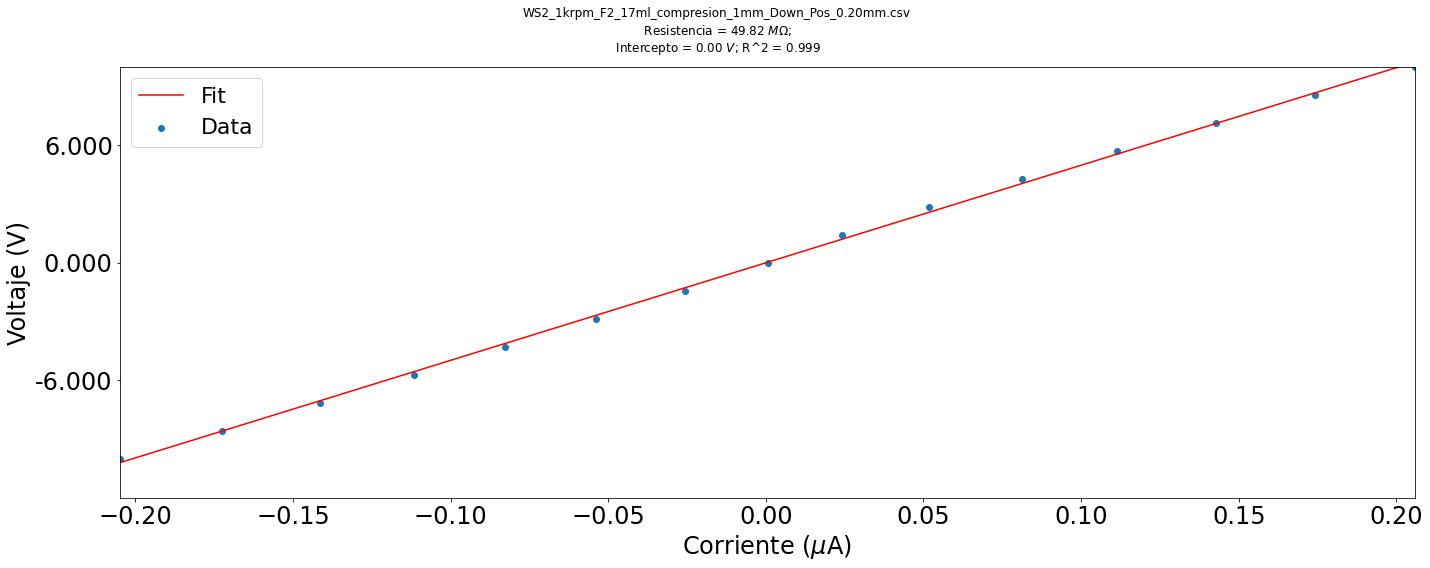

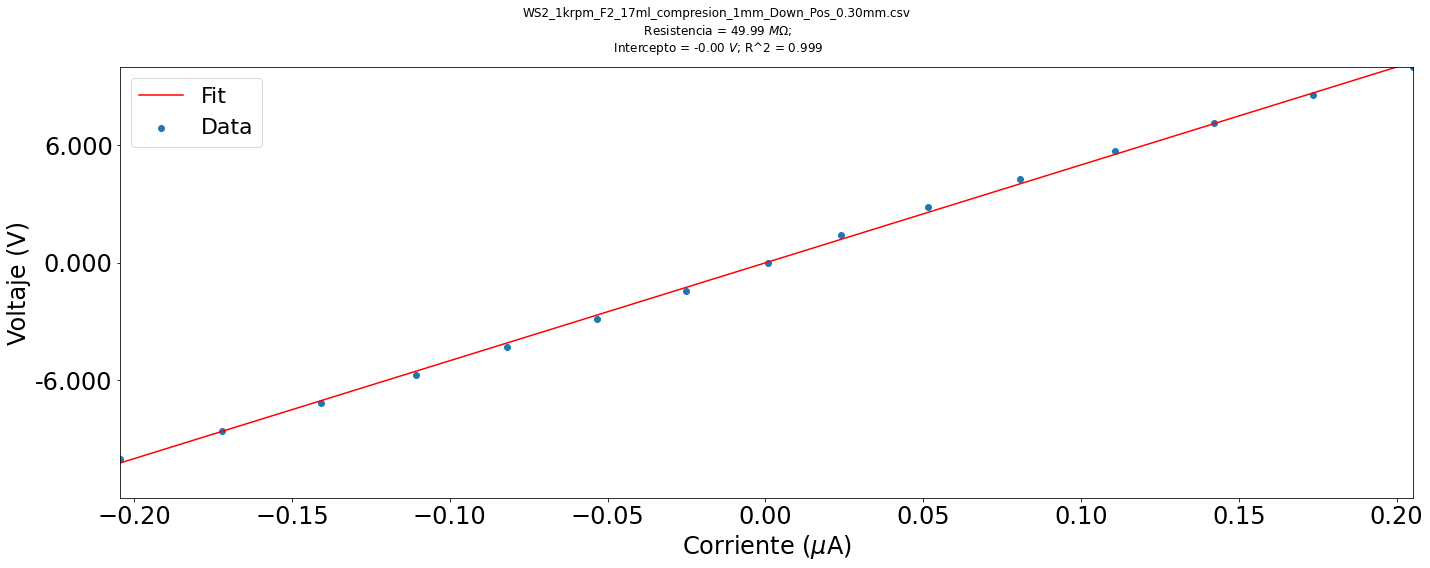

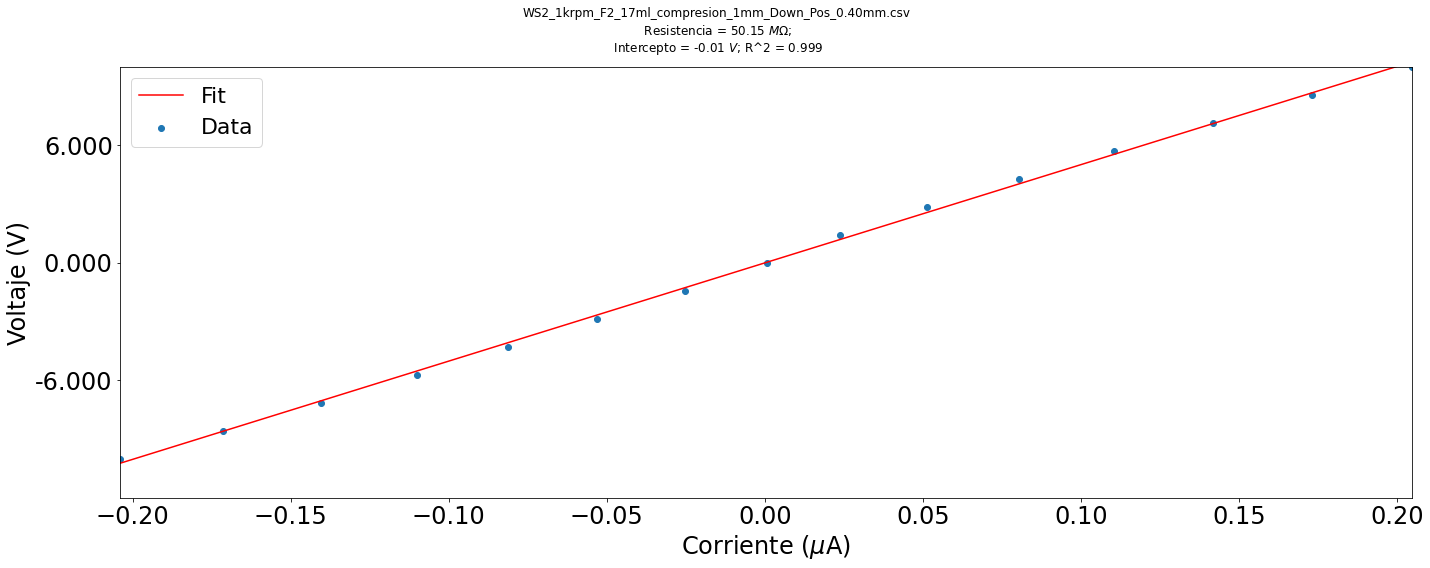

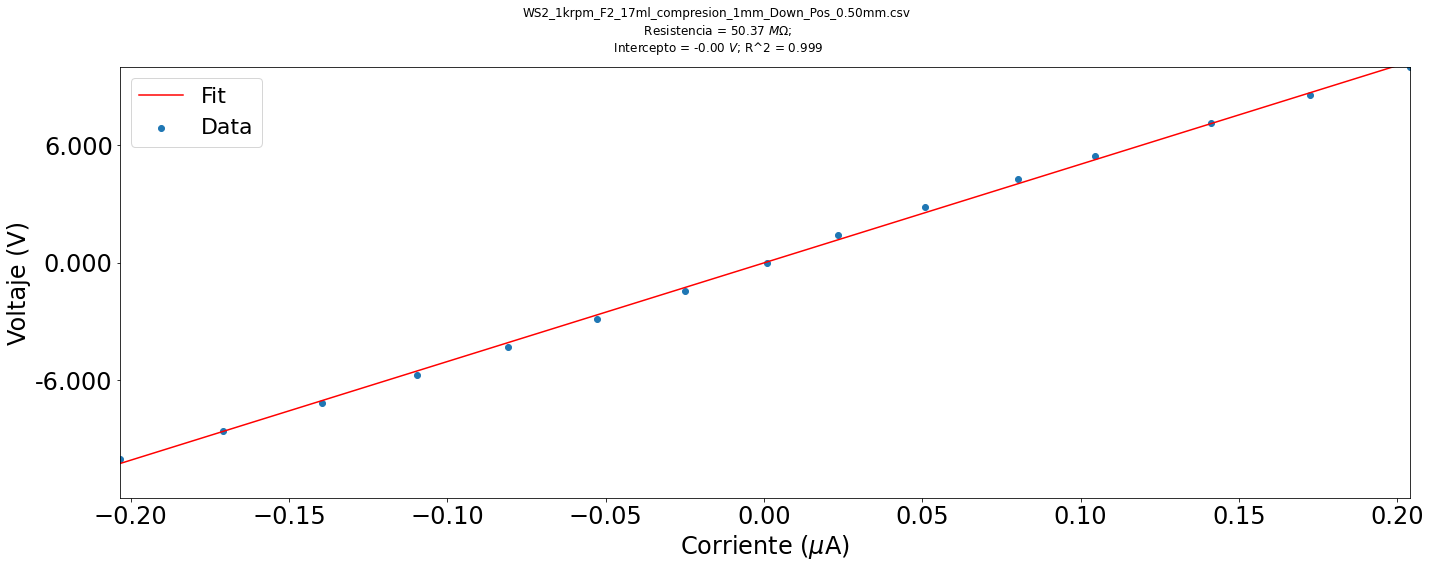

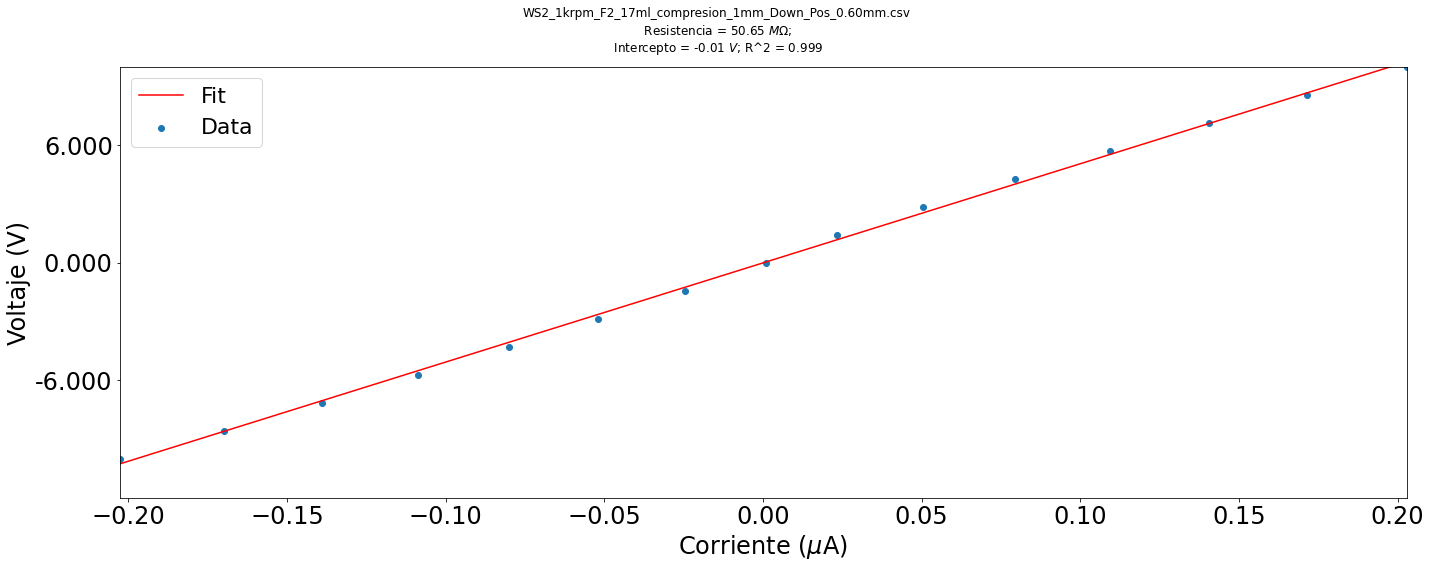

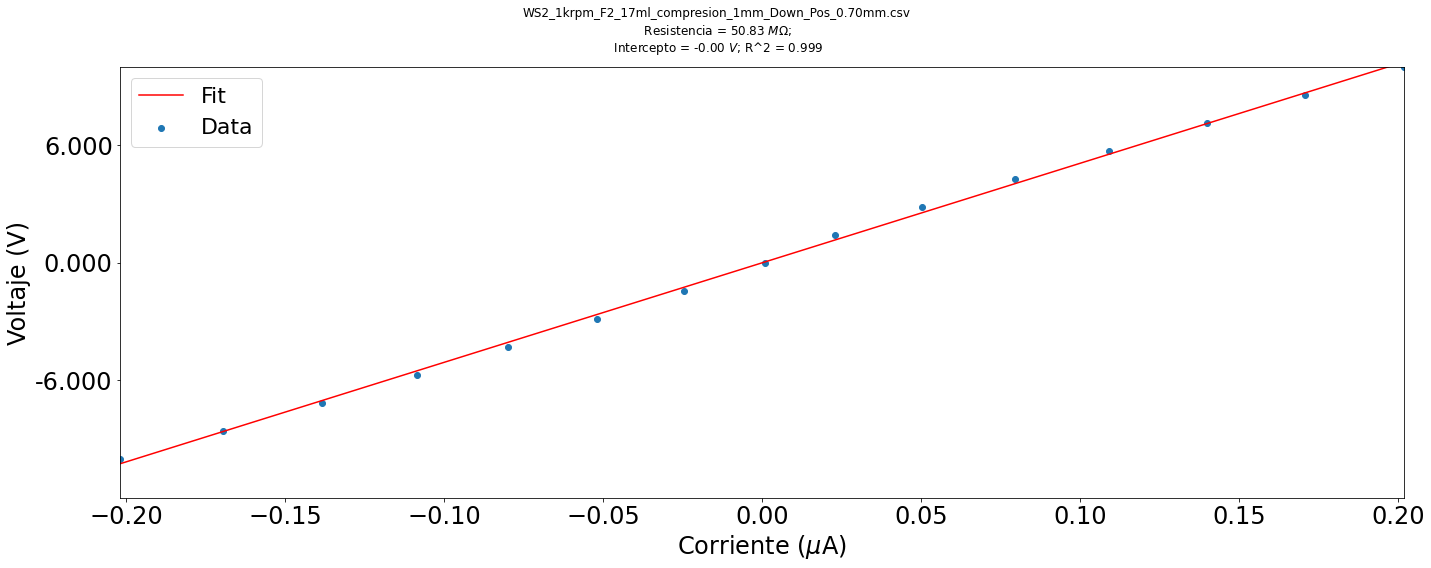

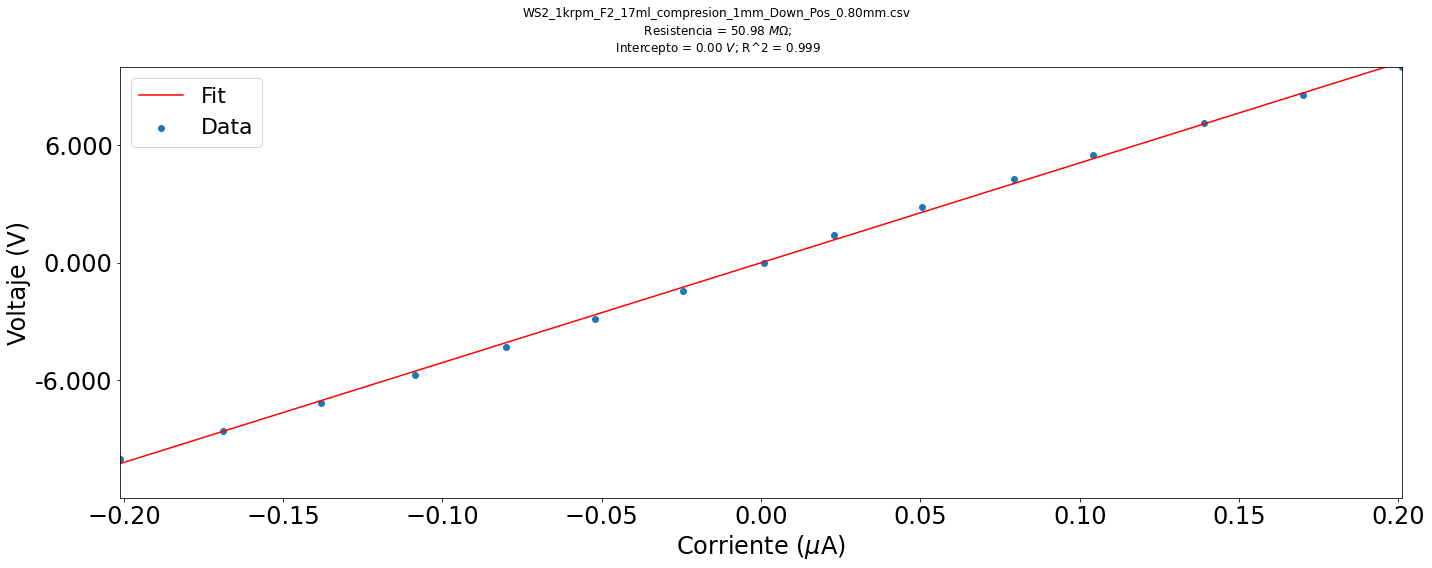

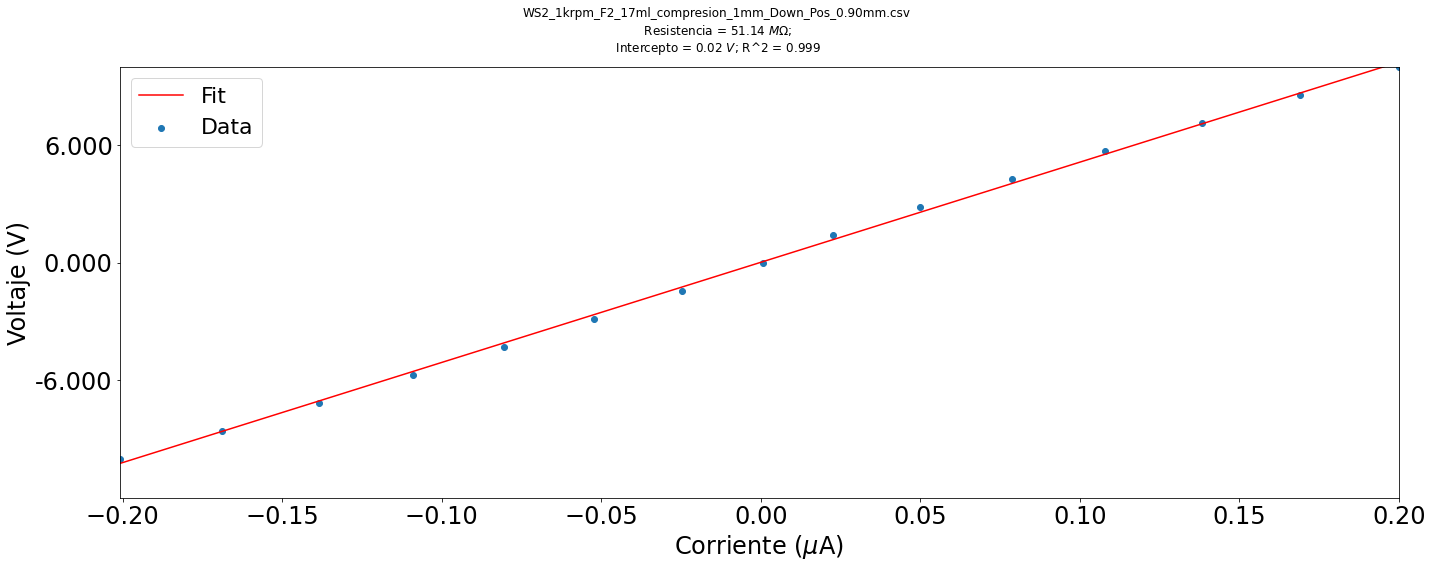

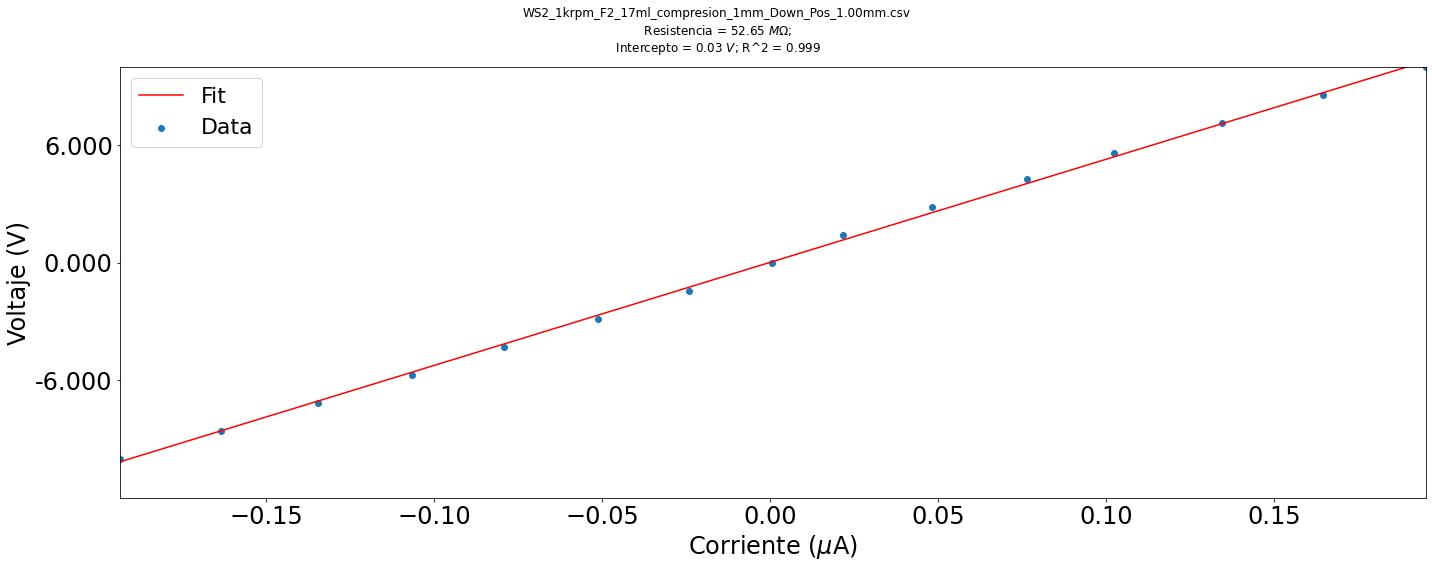

In [8]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_1krpm_F2_17ml_compresion_1mm_Down_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ M\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[41.96460146658242, 41.860677991346186, 41.66854379069013, 41.55210493841168, 41.459434837277634, 41.49063319827112, 41.64336014646673, 41.647587205128275, 41.588151206325726, 41.55048901214124, 41.463036248051694]


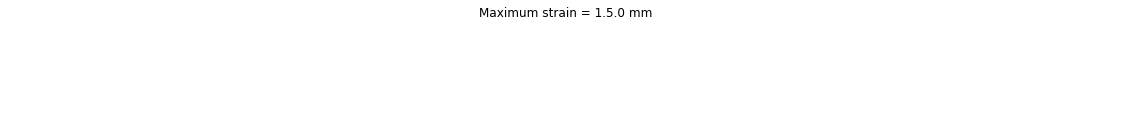

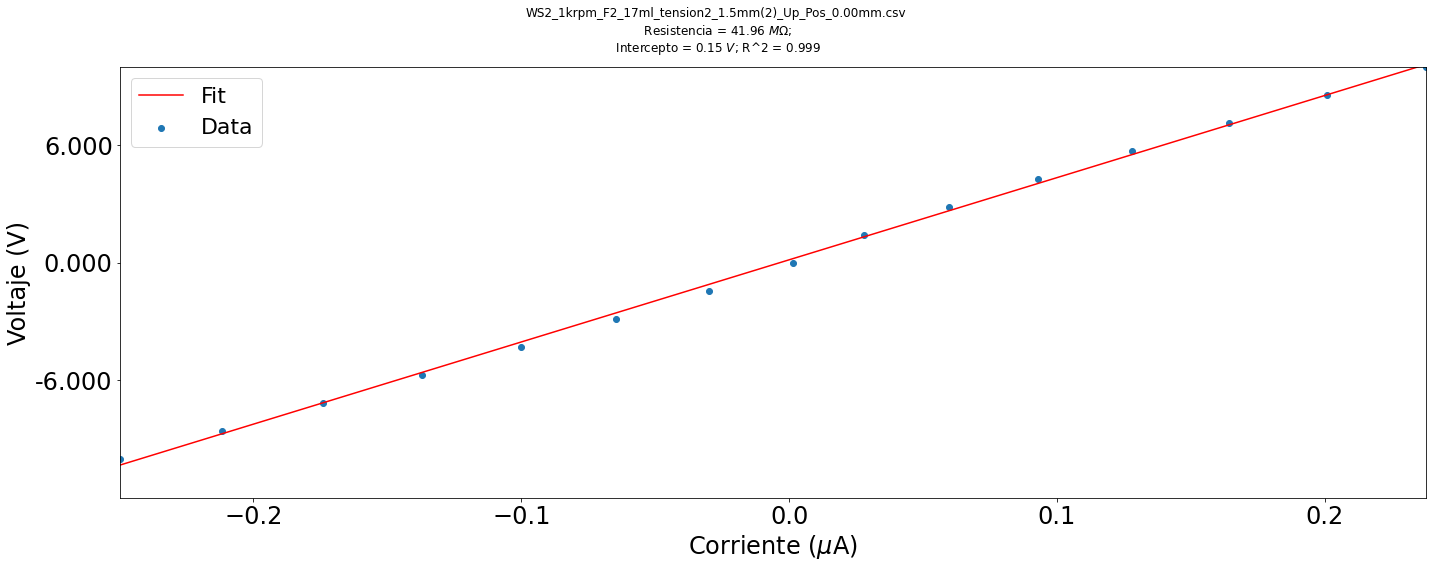

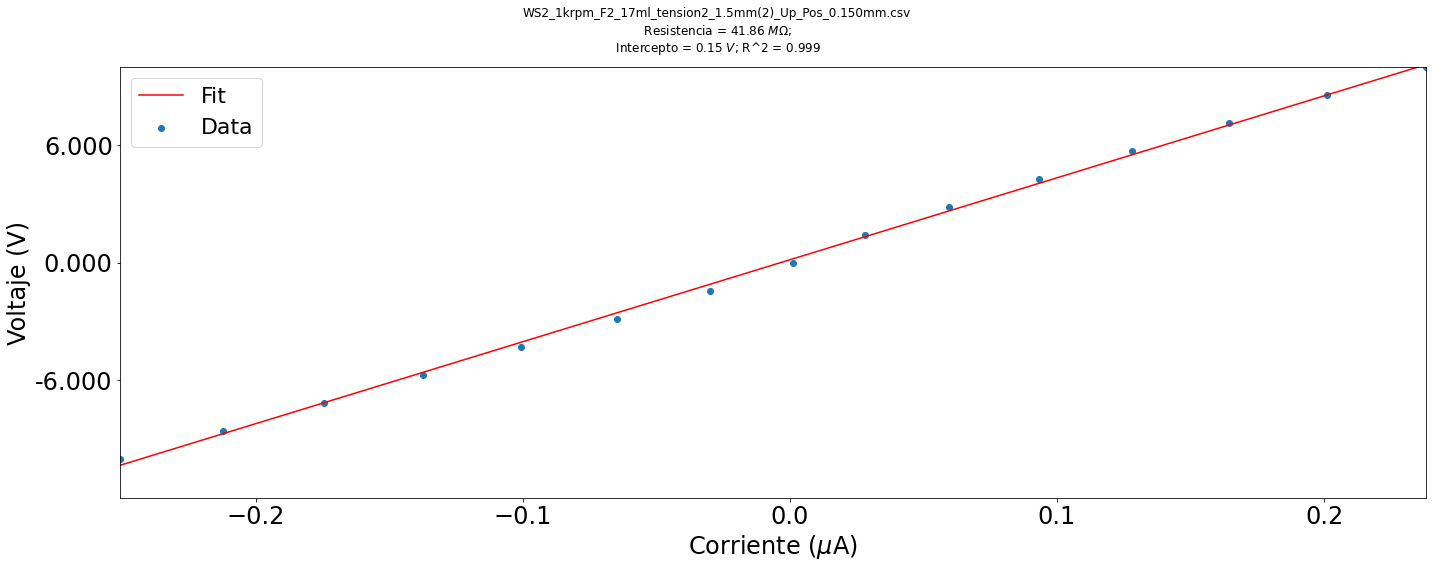

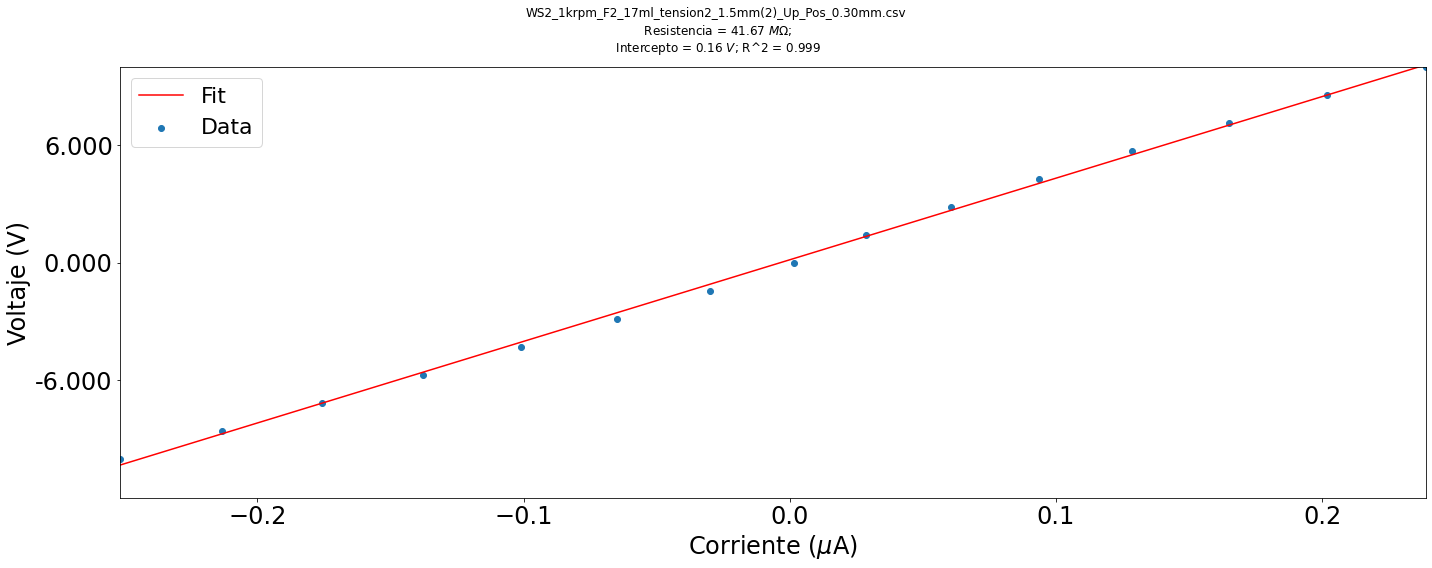

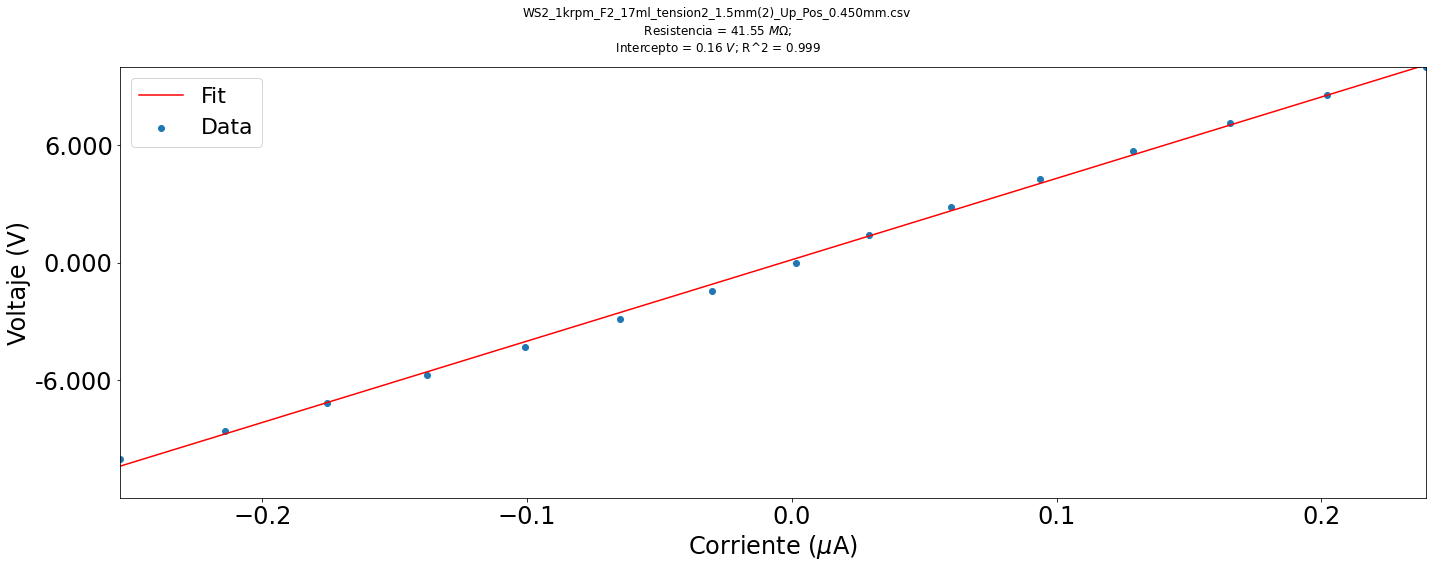

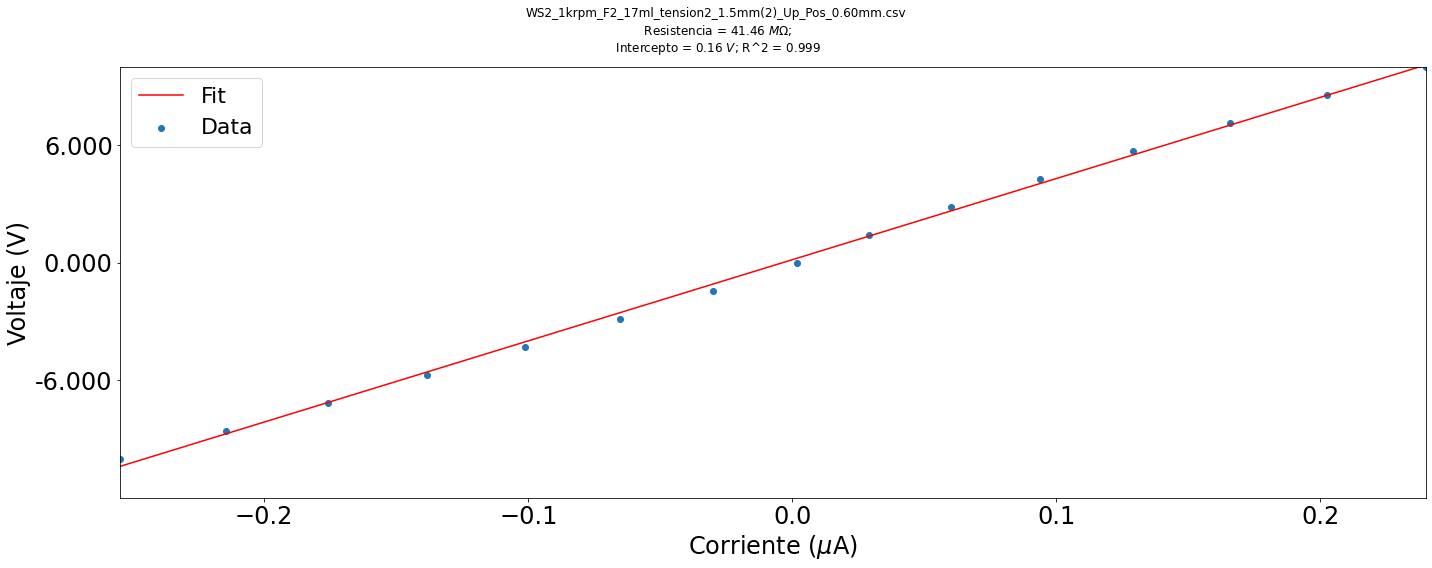

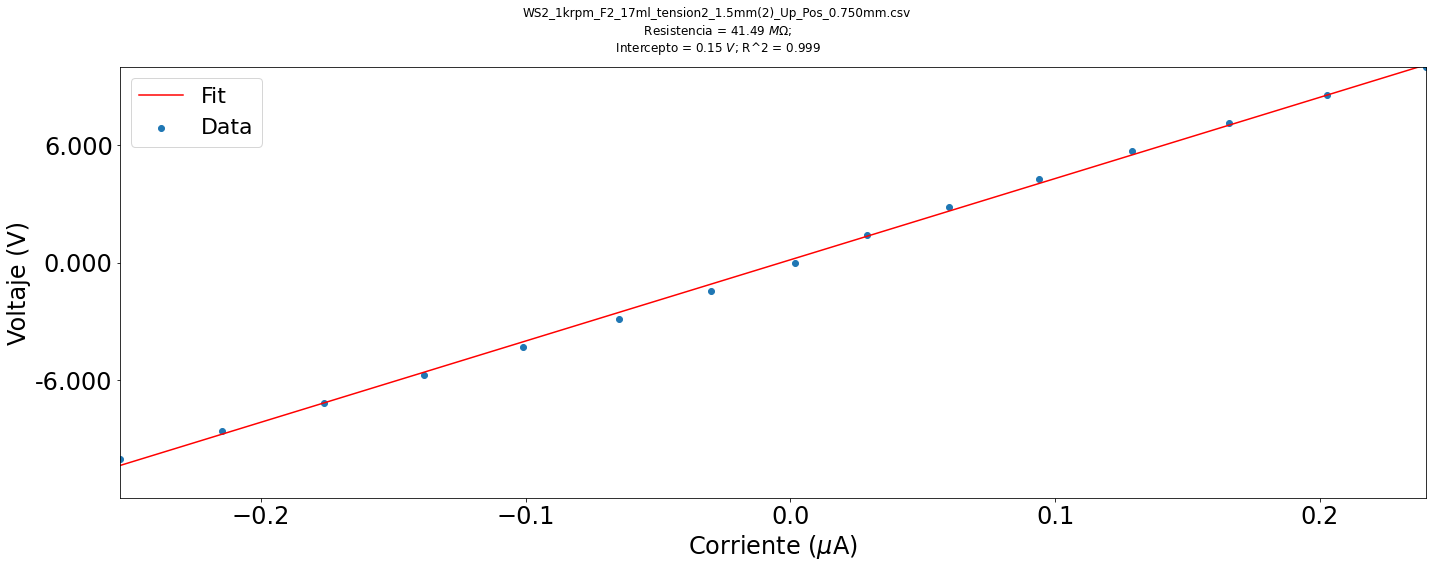

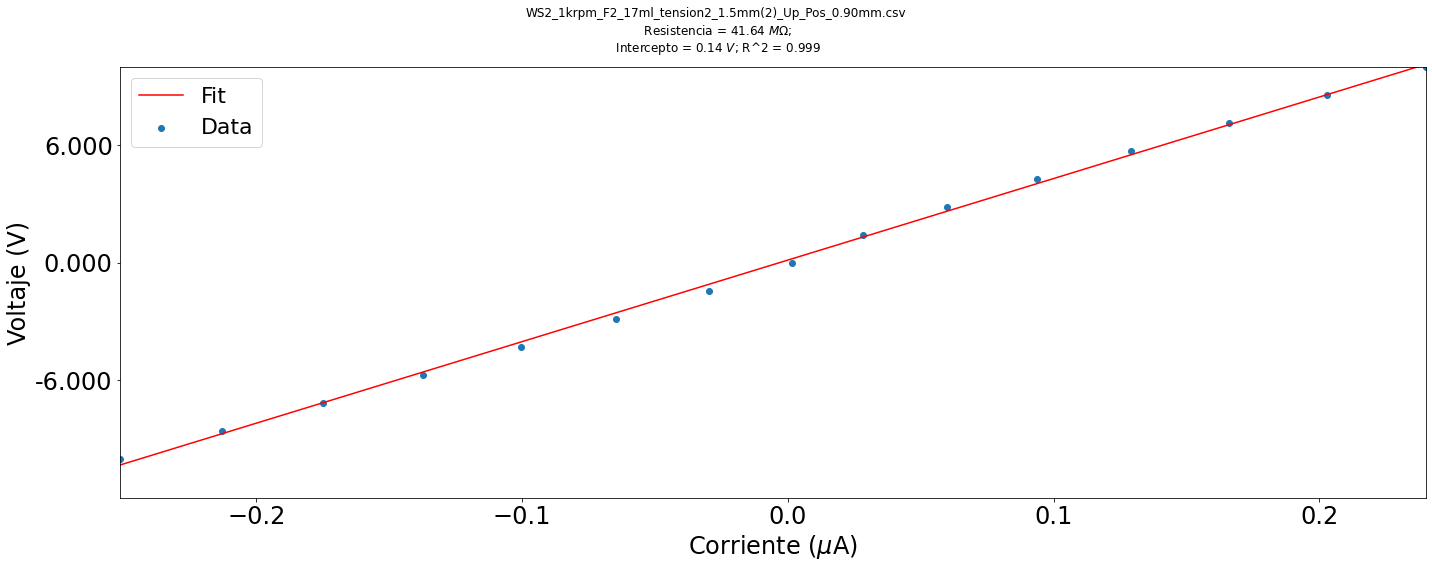

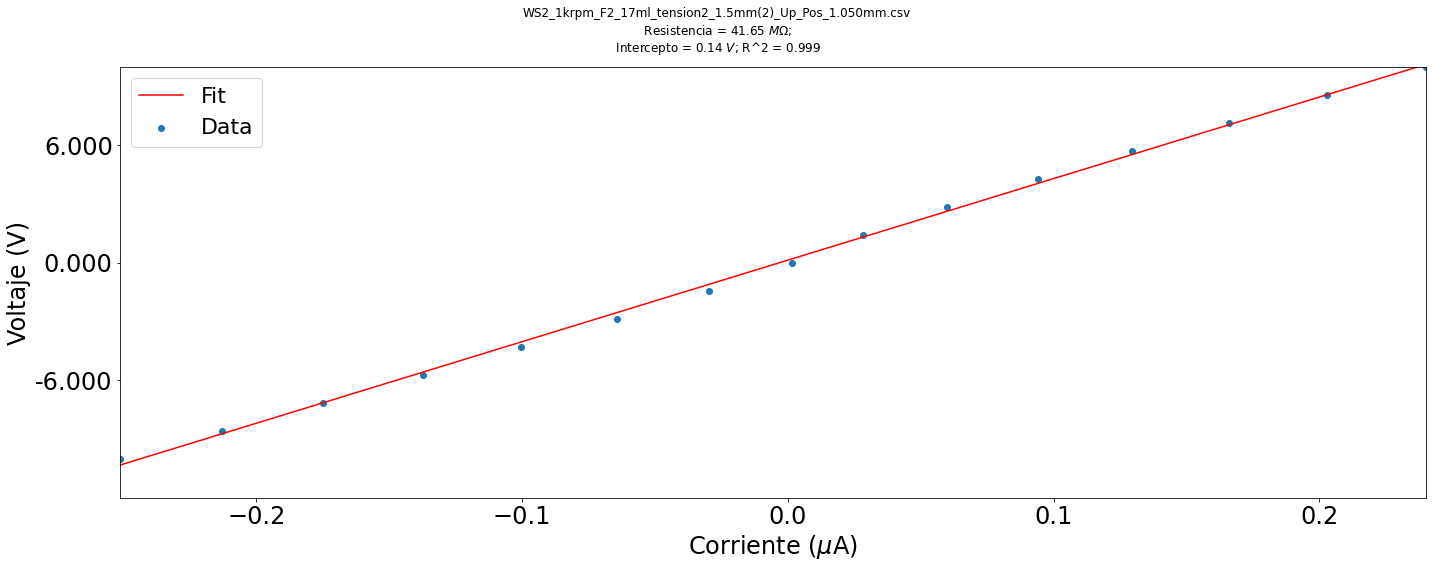

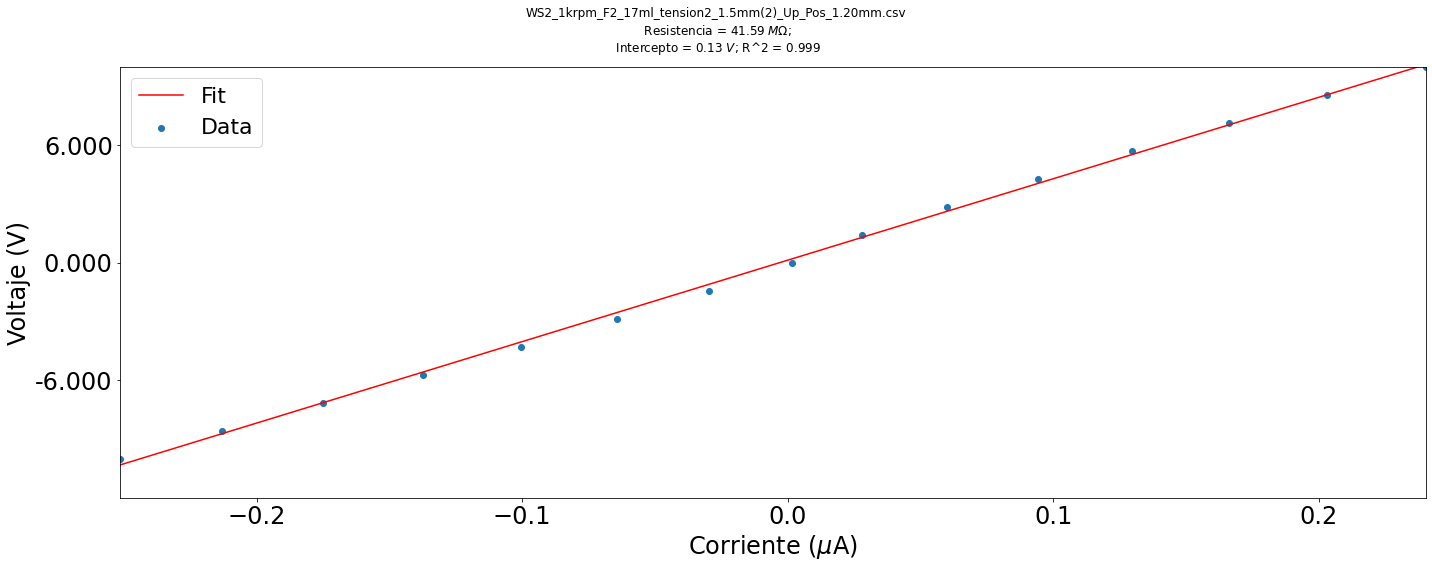

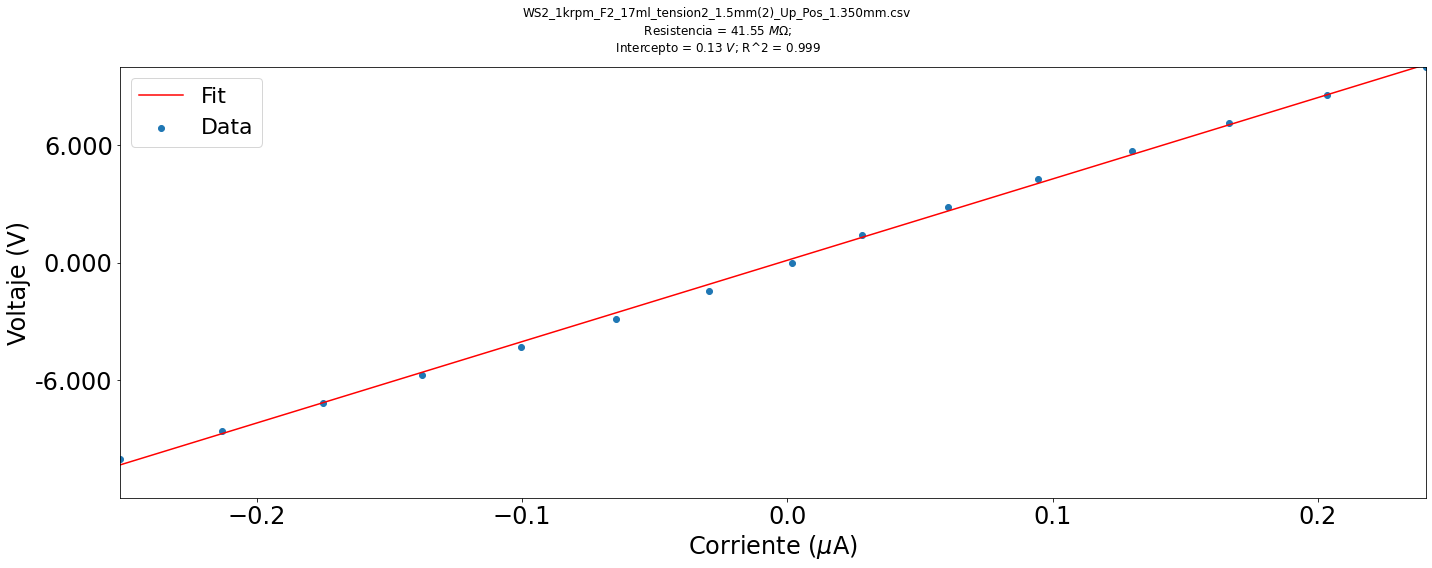

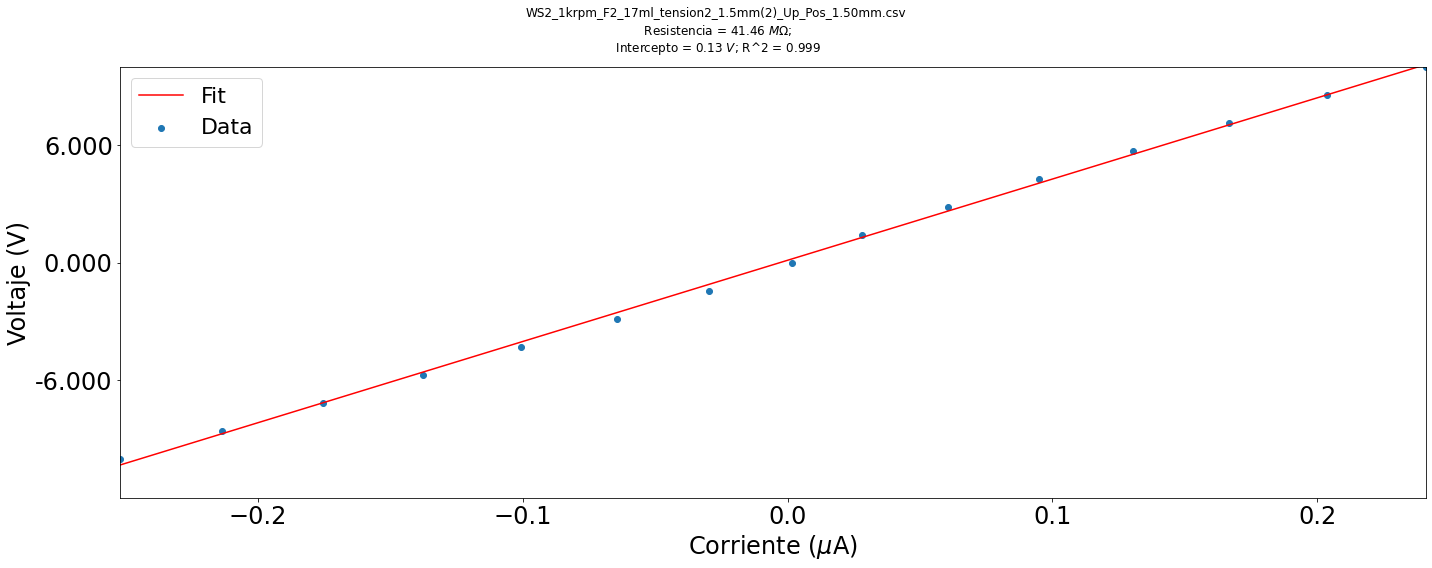

In [7]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_1krpm_F2_17ml_tension2_1.5mm(2)_Up_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1.5
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ M\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[40.221809717190844, 40.273097524579406, 40.41491138105508, 40.537889600197865, 40.54094195459548, 40.70107806407109, 40.829409425263876, 40.950002536842106, 41.10335788036533, 41.2349833402508, 41.38760073359785]


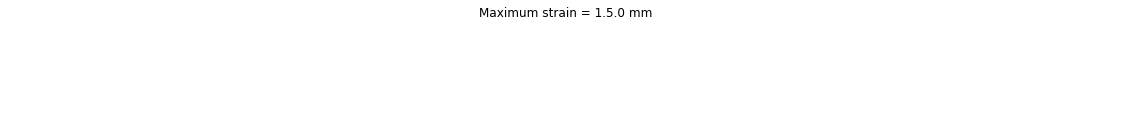

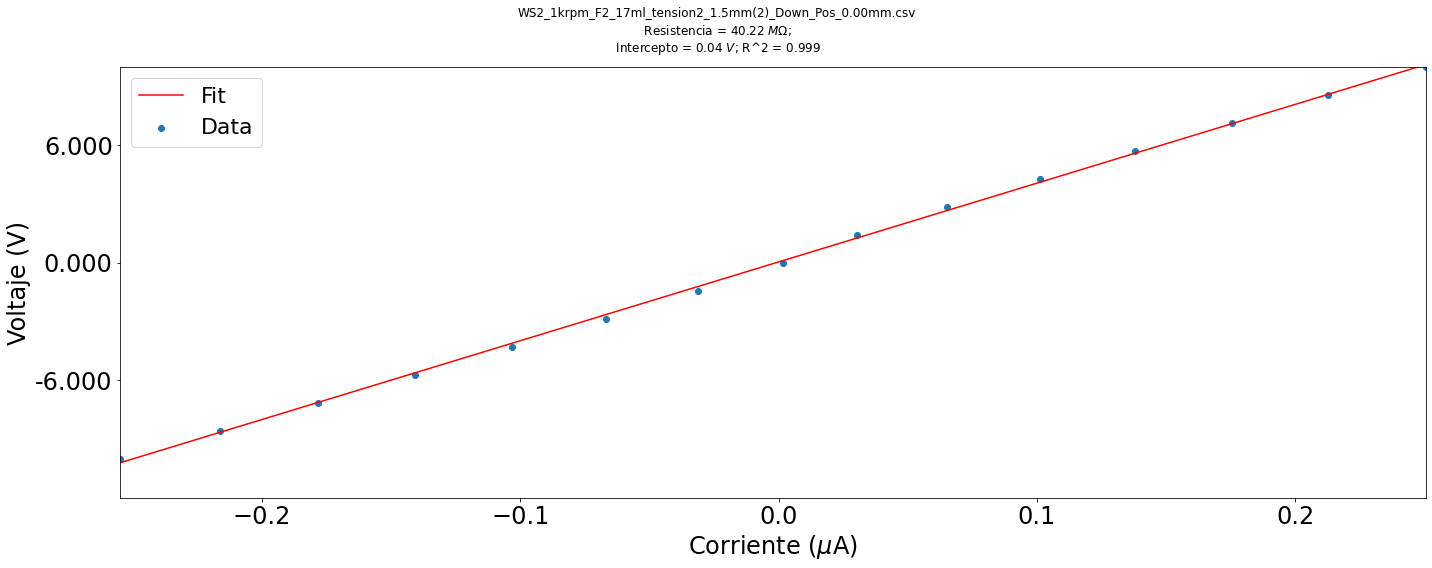

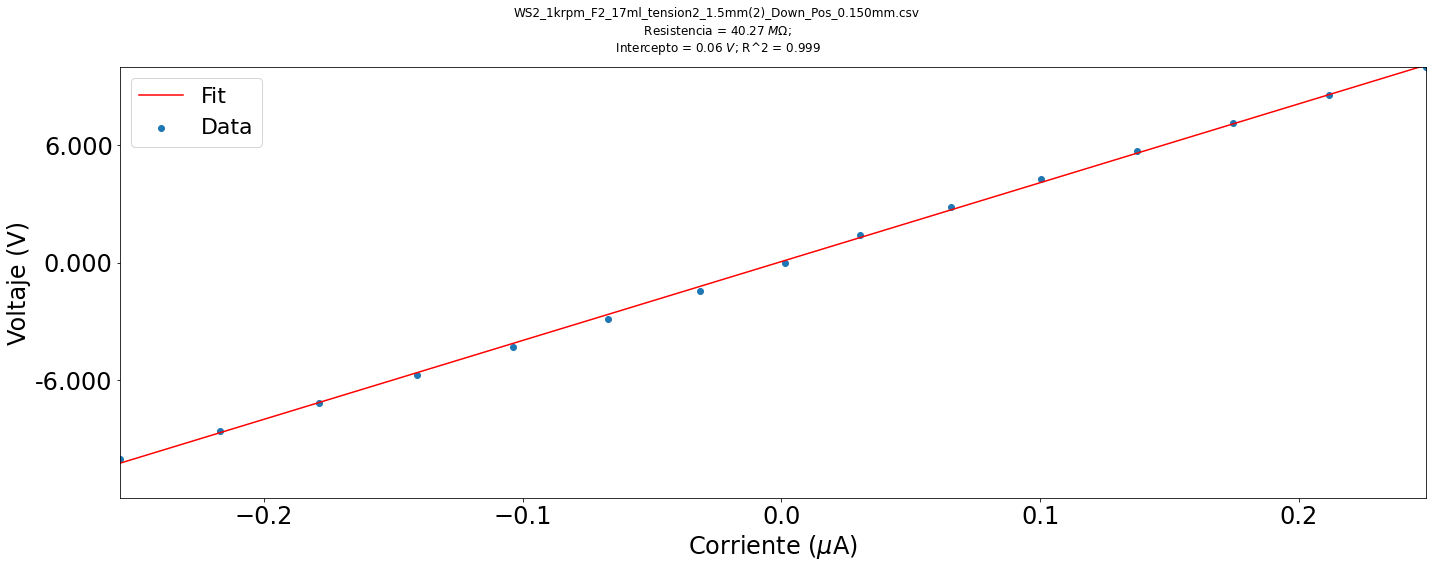

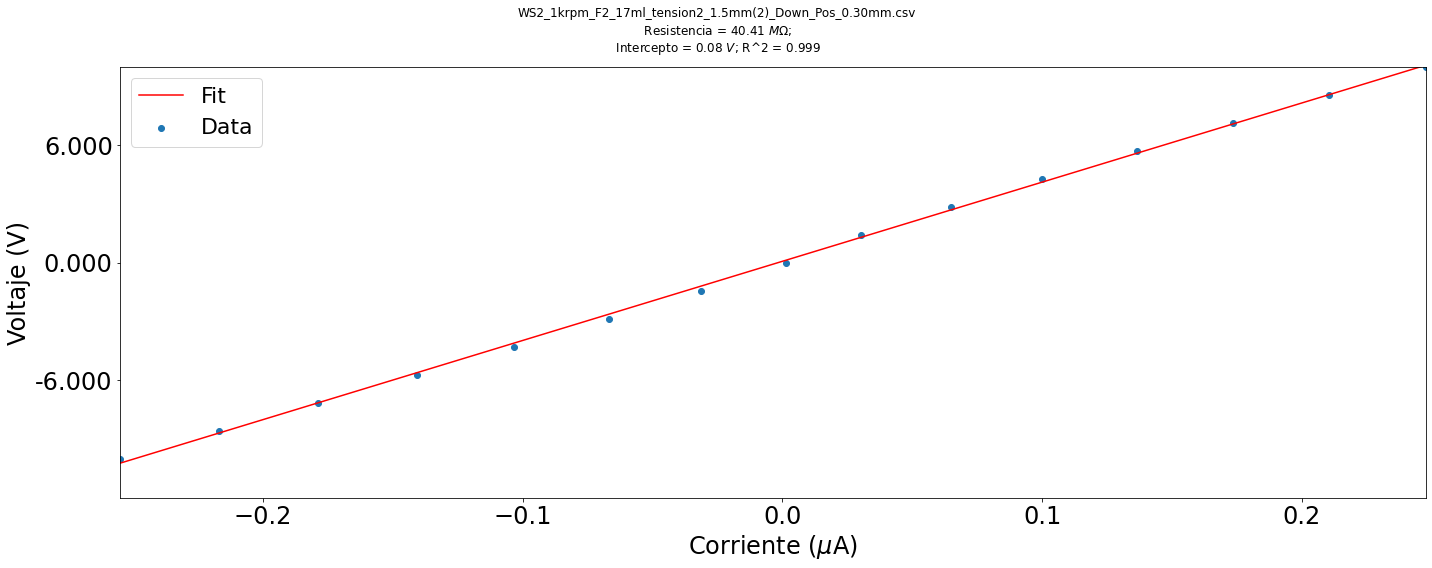

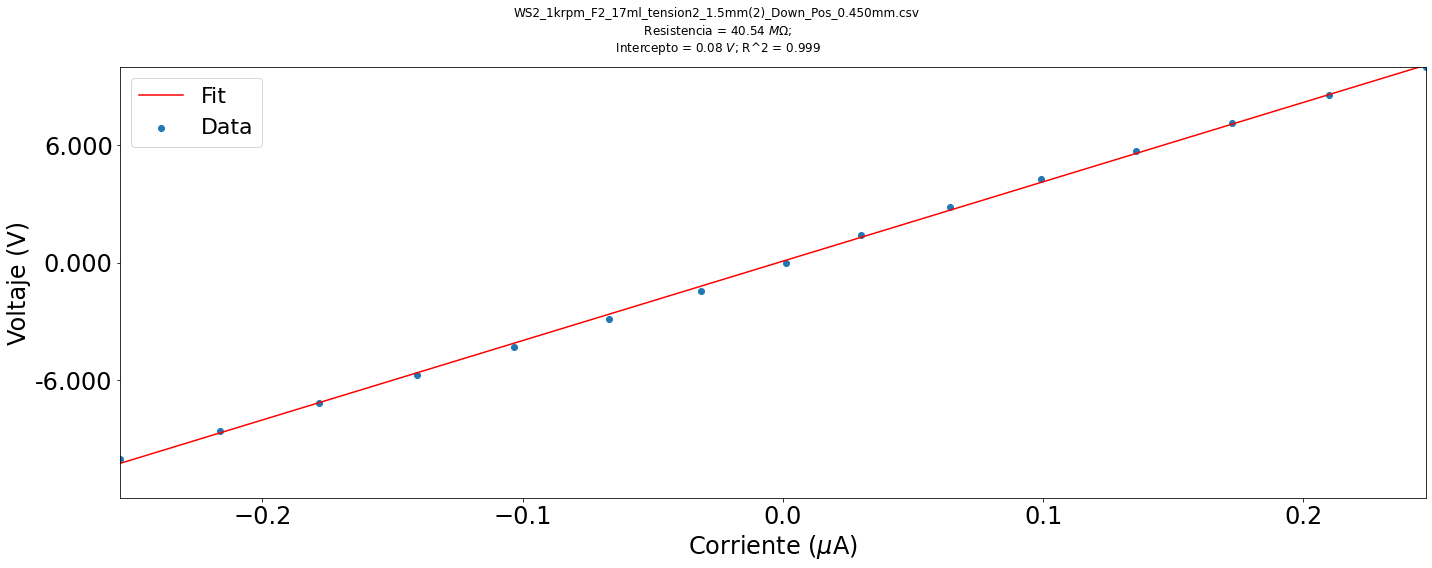

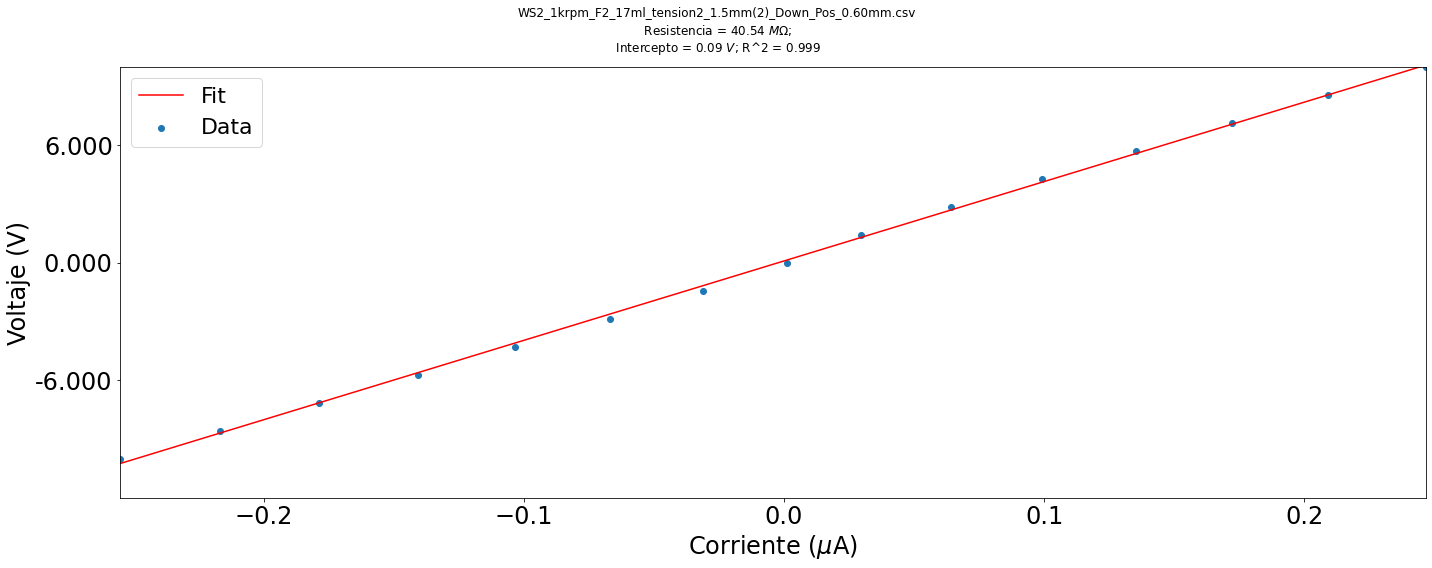

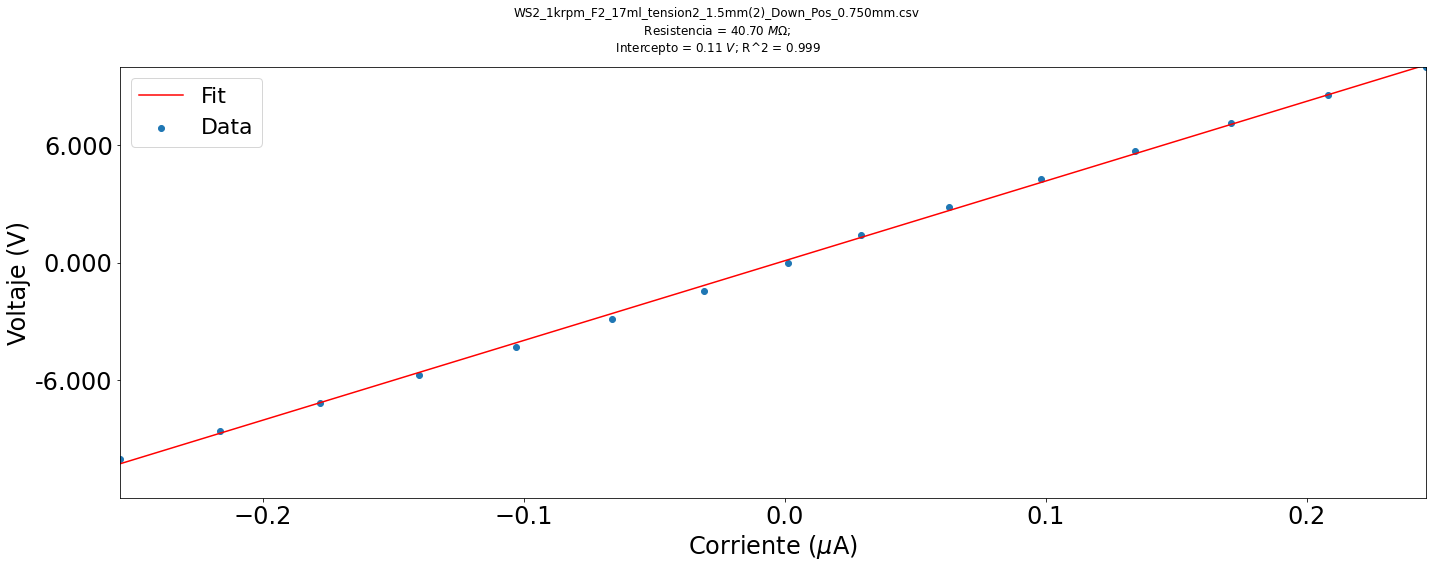

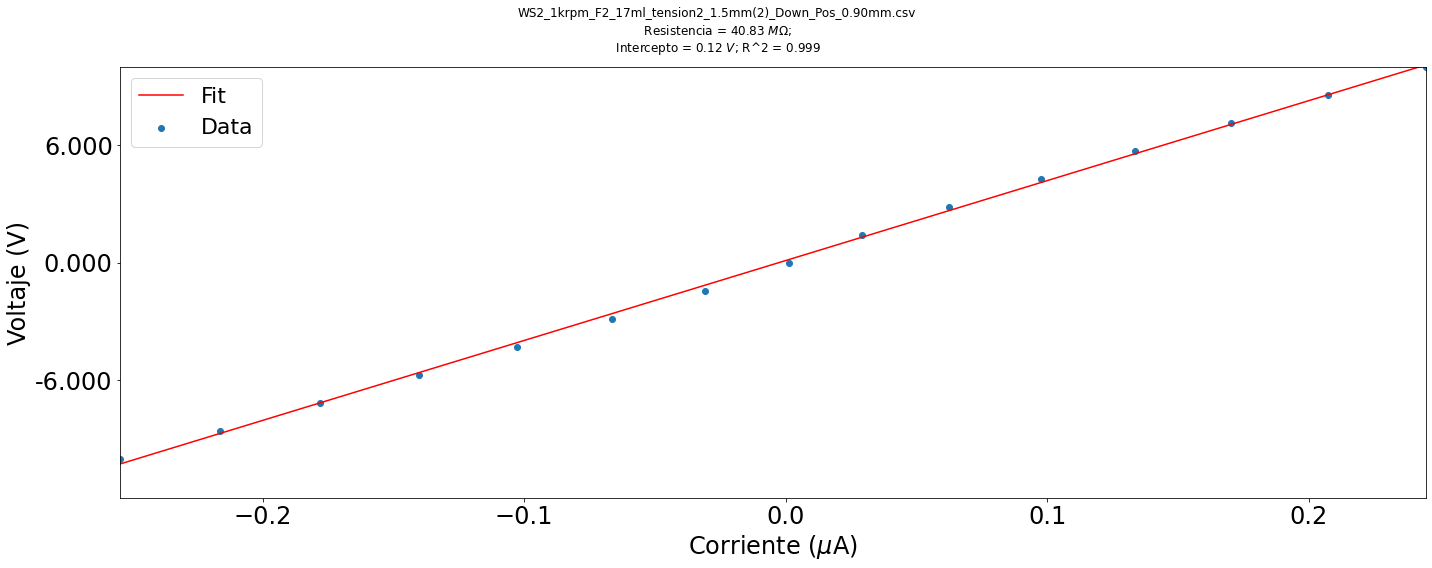

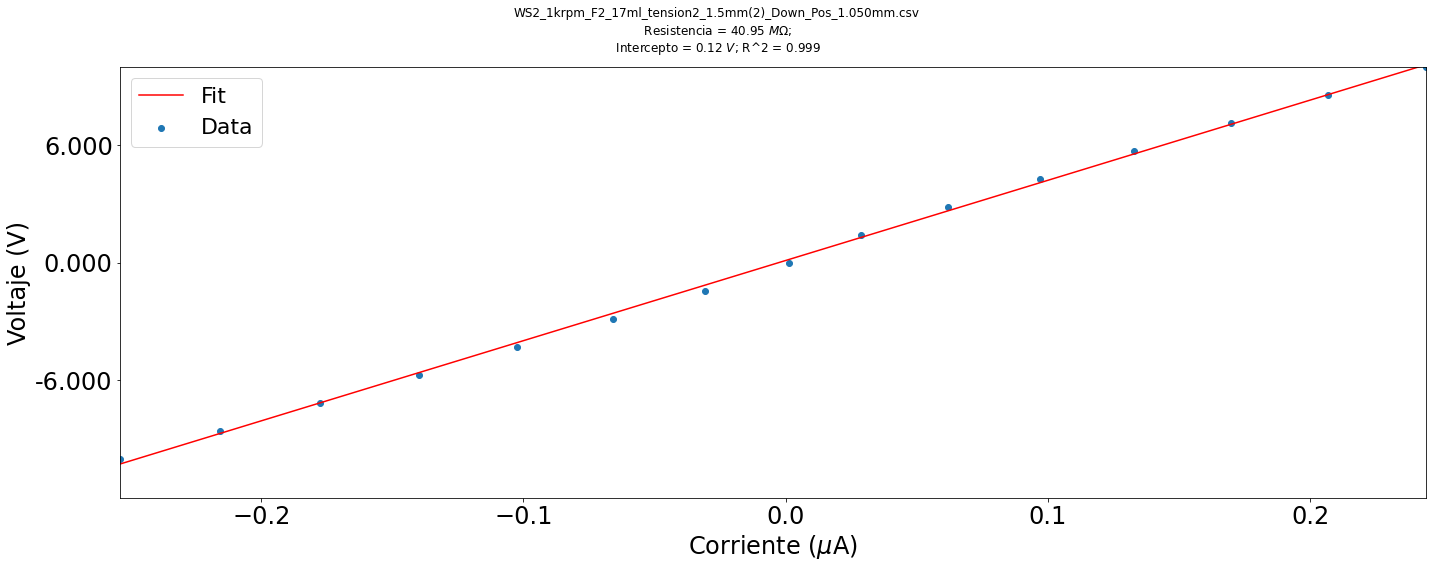

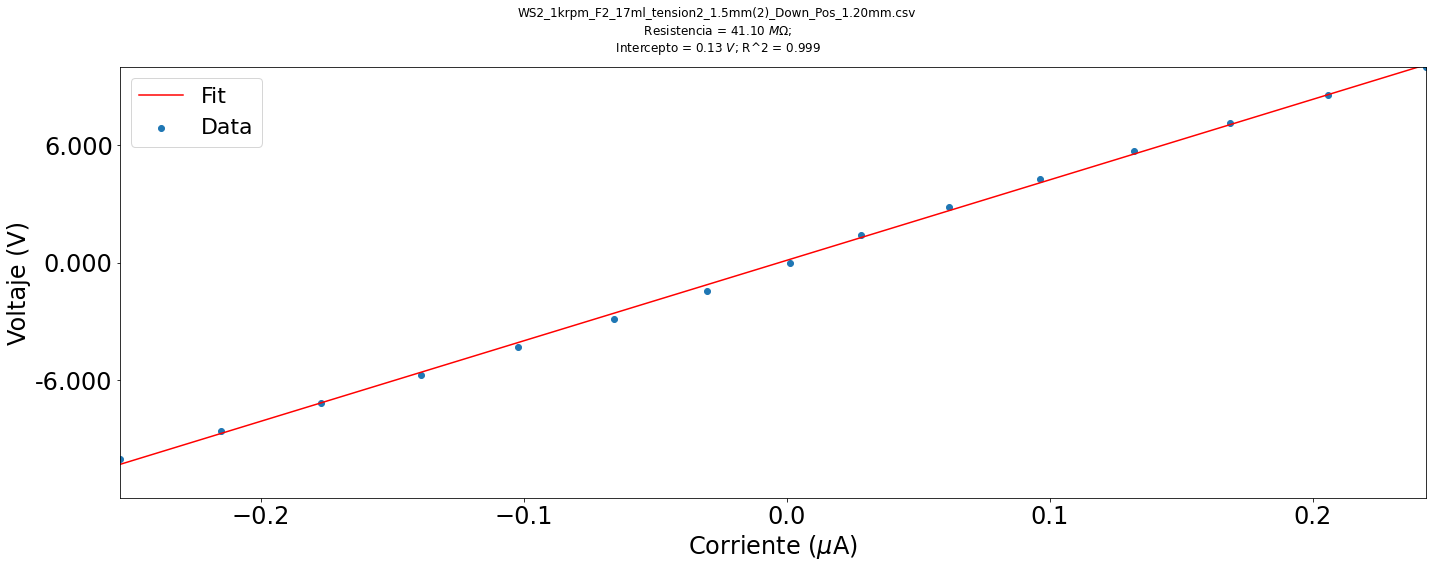

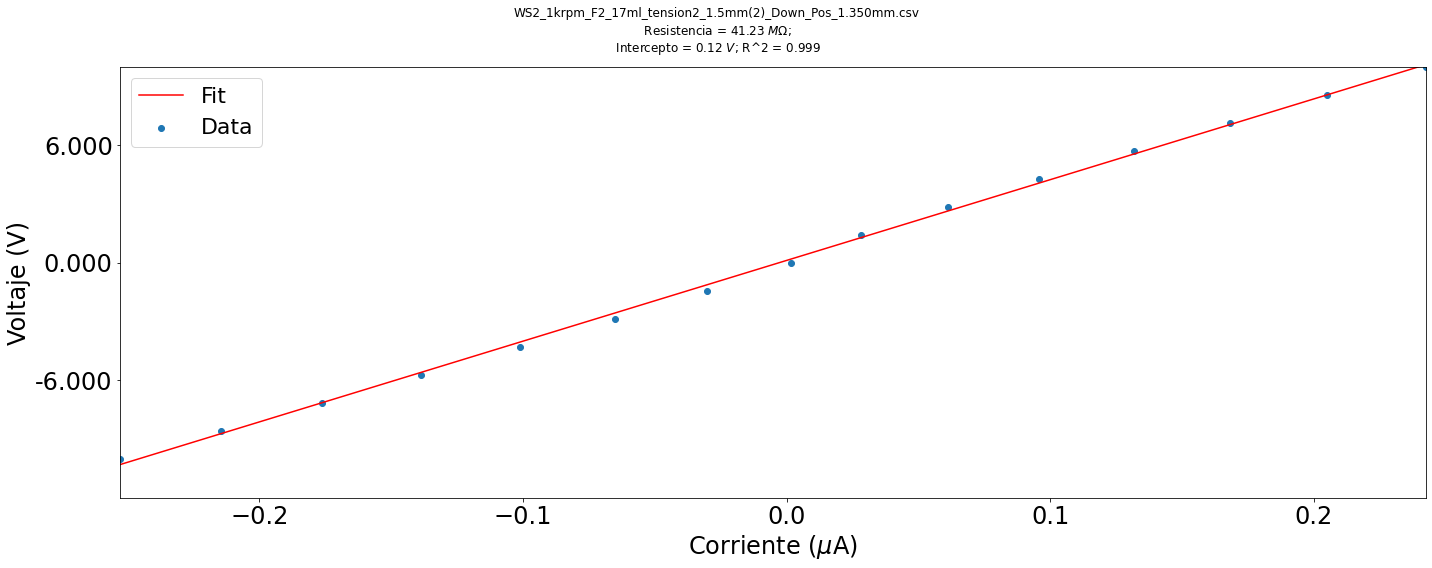

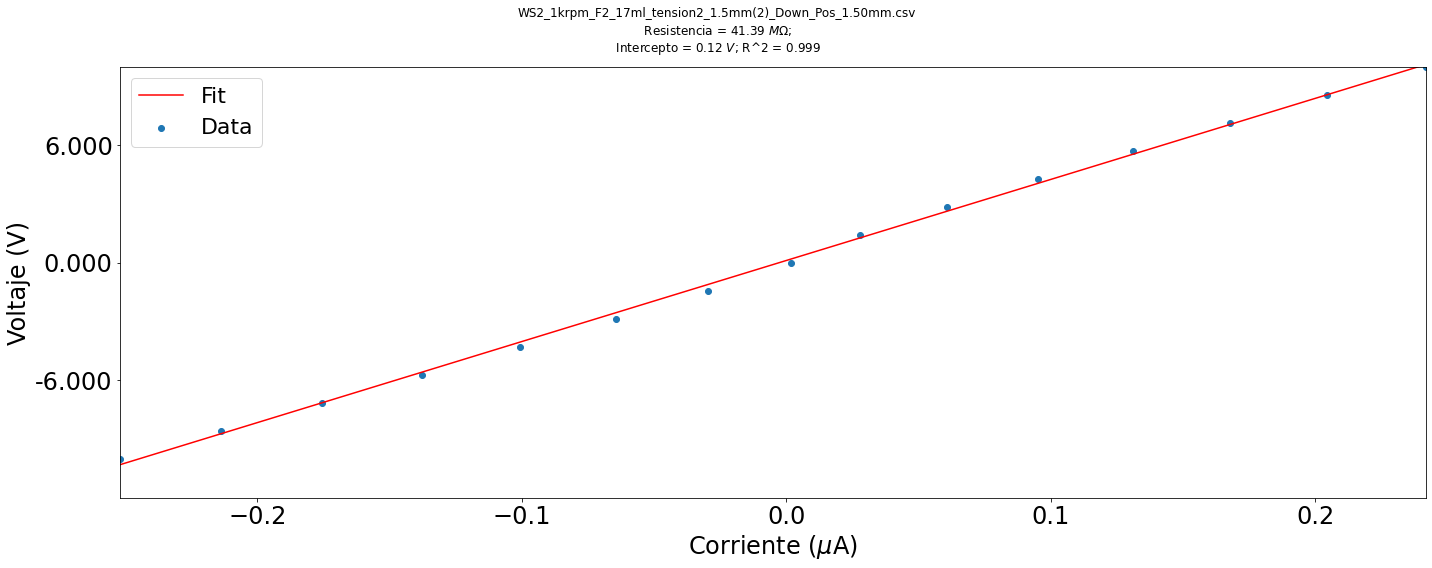

In [6]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_1krpm_F2_17ml_tension2_1.5mm(2)_Down_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1.5
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ M\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[43.009129348854316, 43.034769015533726, 42.95958638402367, 42.85760189344754, 42.91714537546495, 42.91228550254101, 42.836698586022024, 42.85084941737676, 42.857315680840536, 42.947183122018, 42.930366655113744]


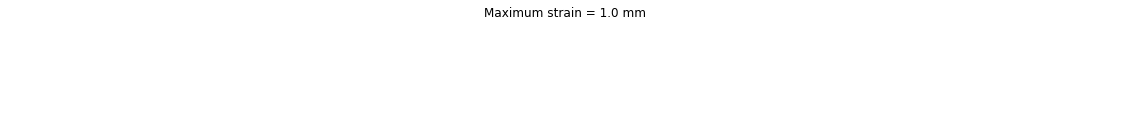

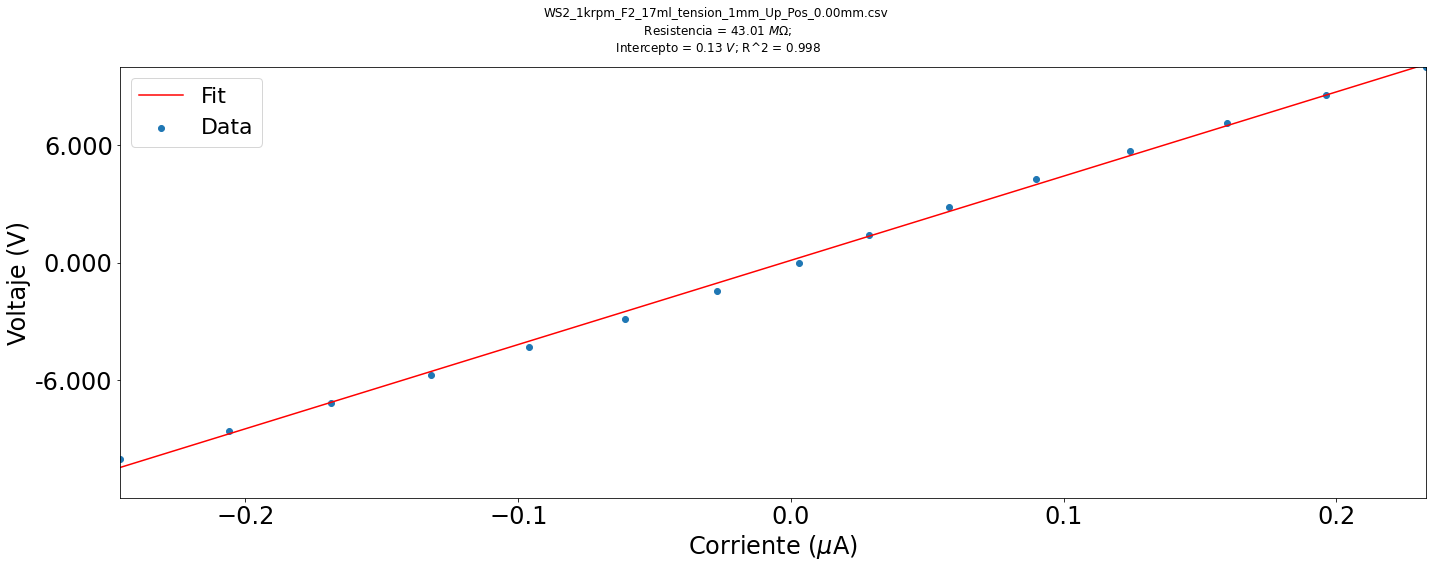

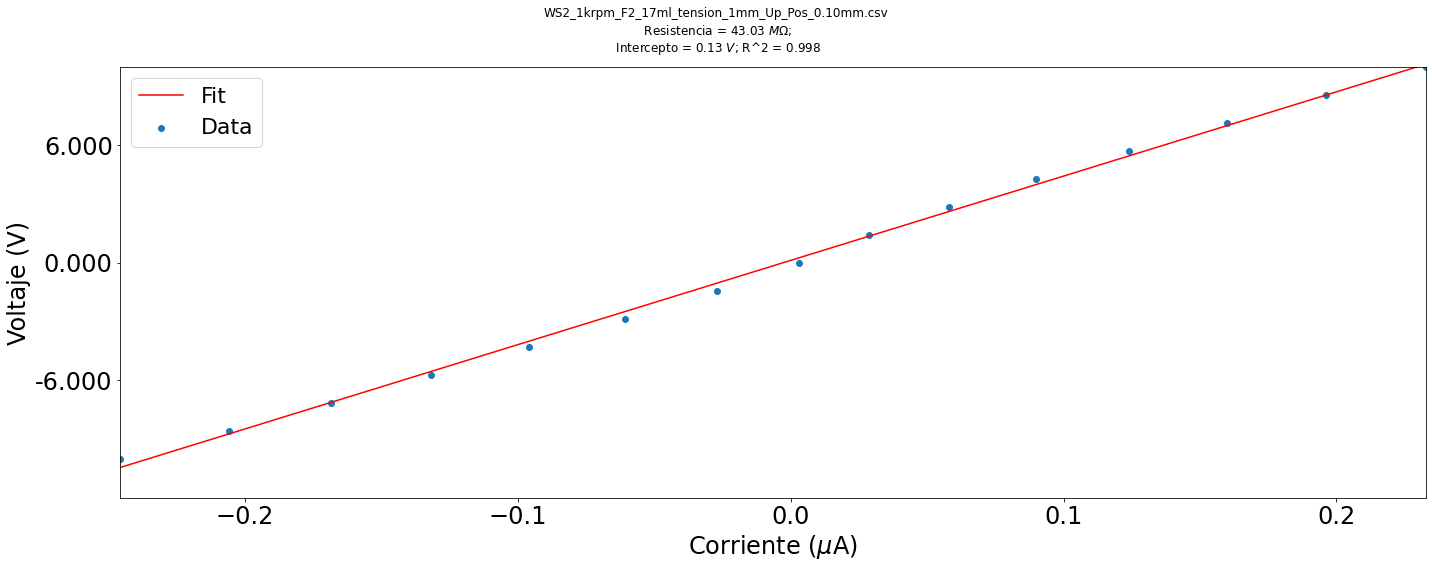

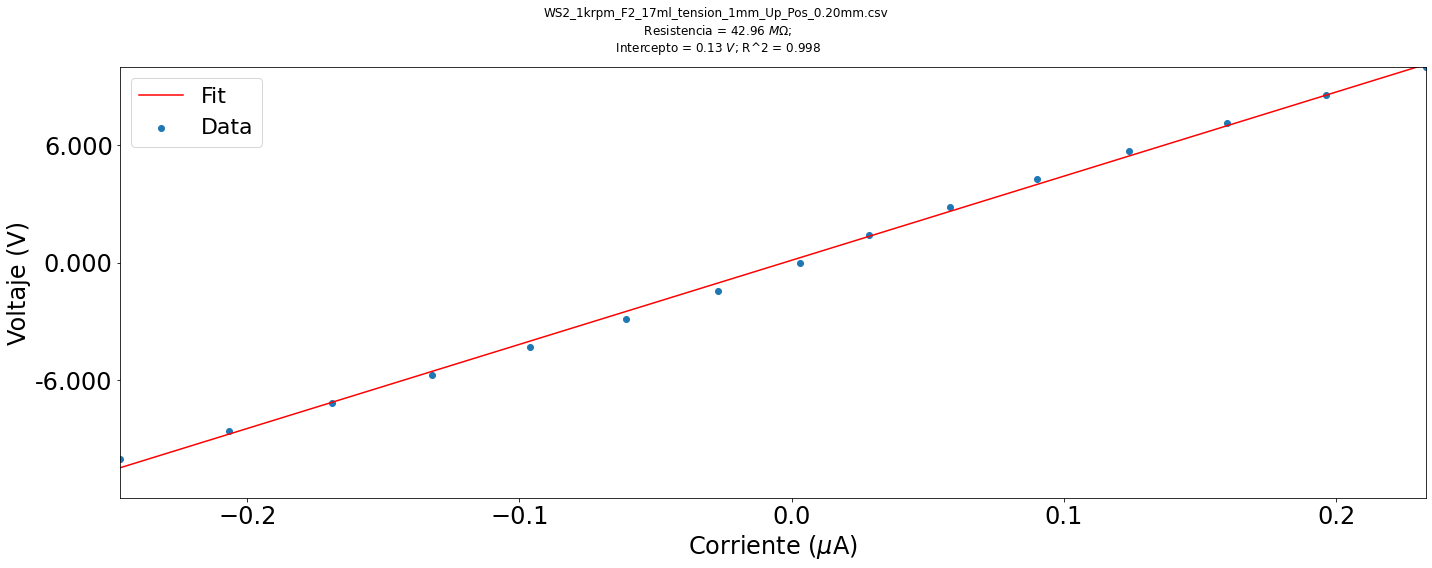

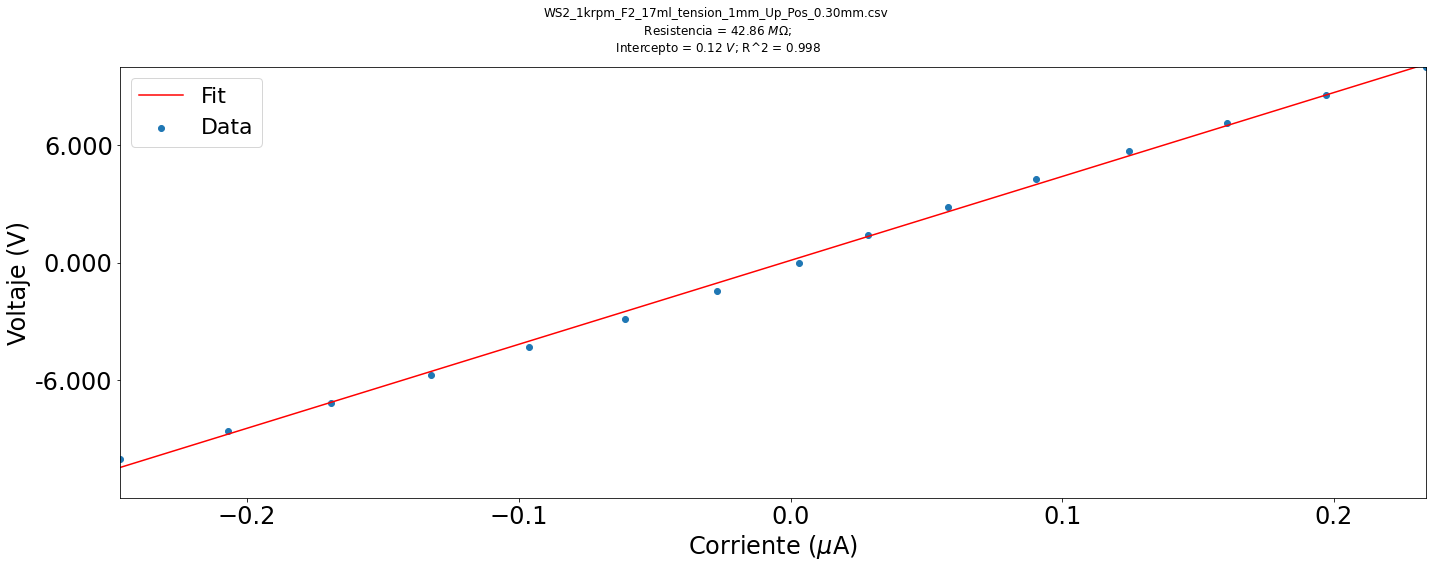

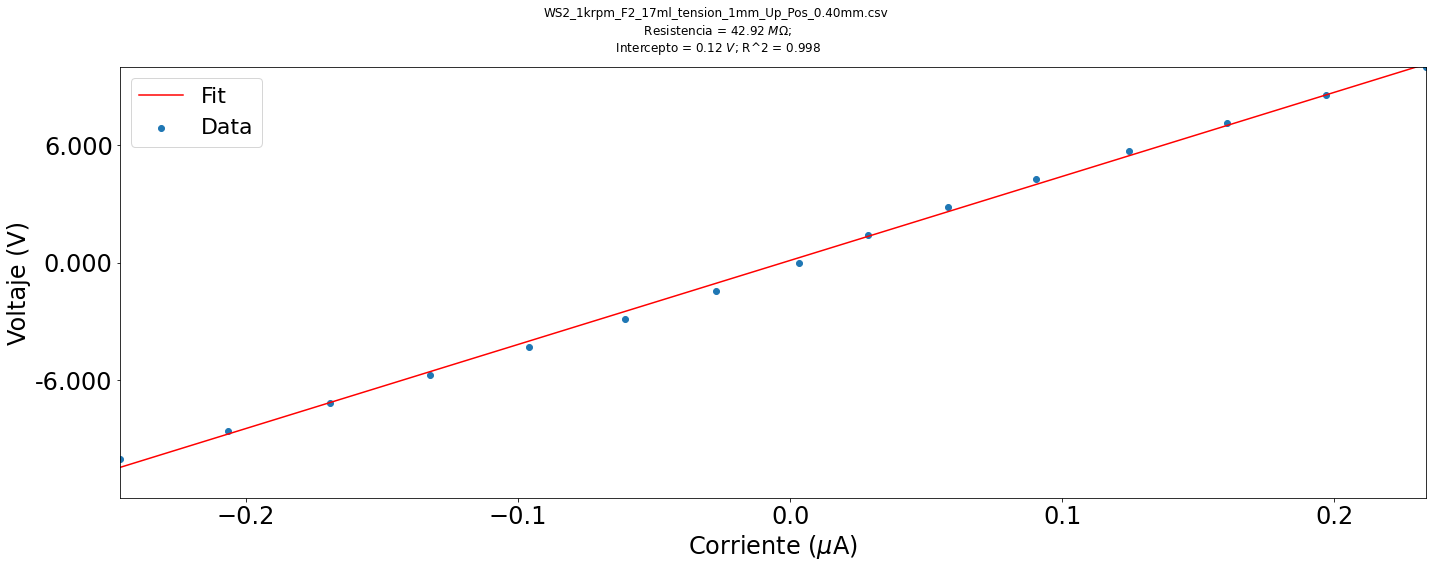

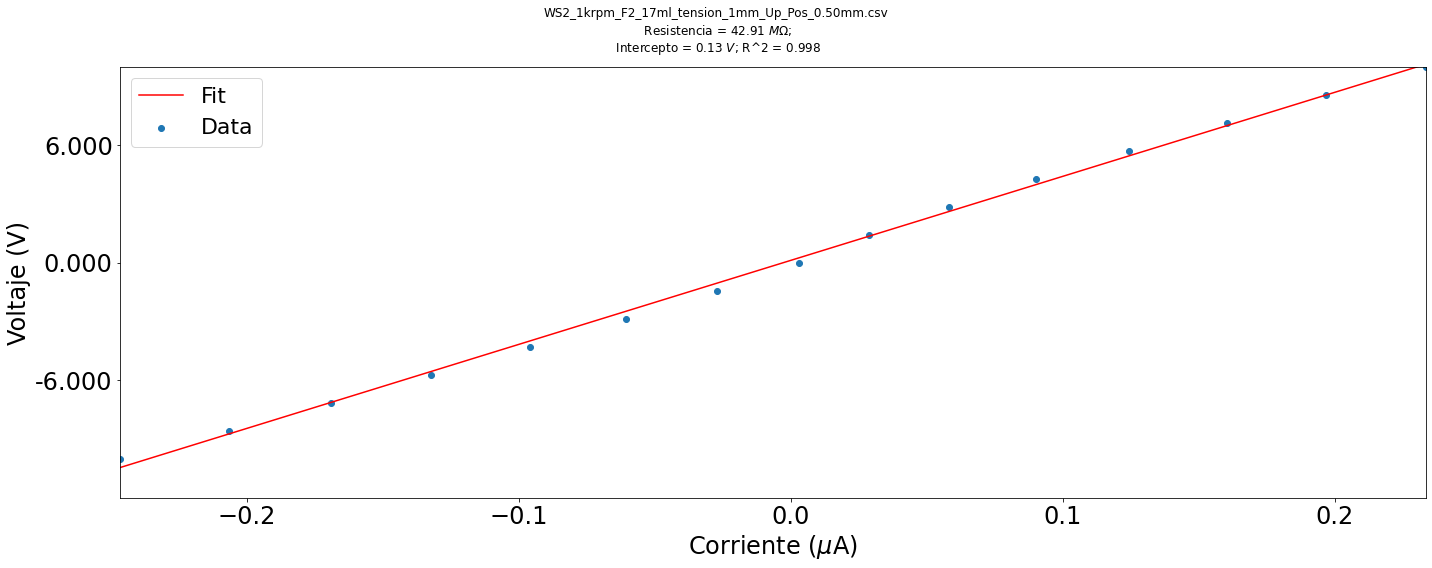

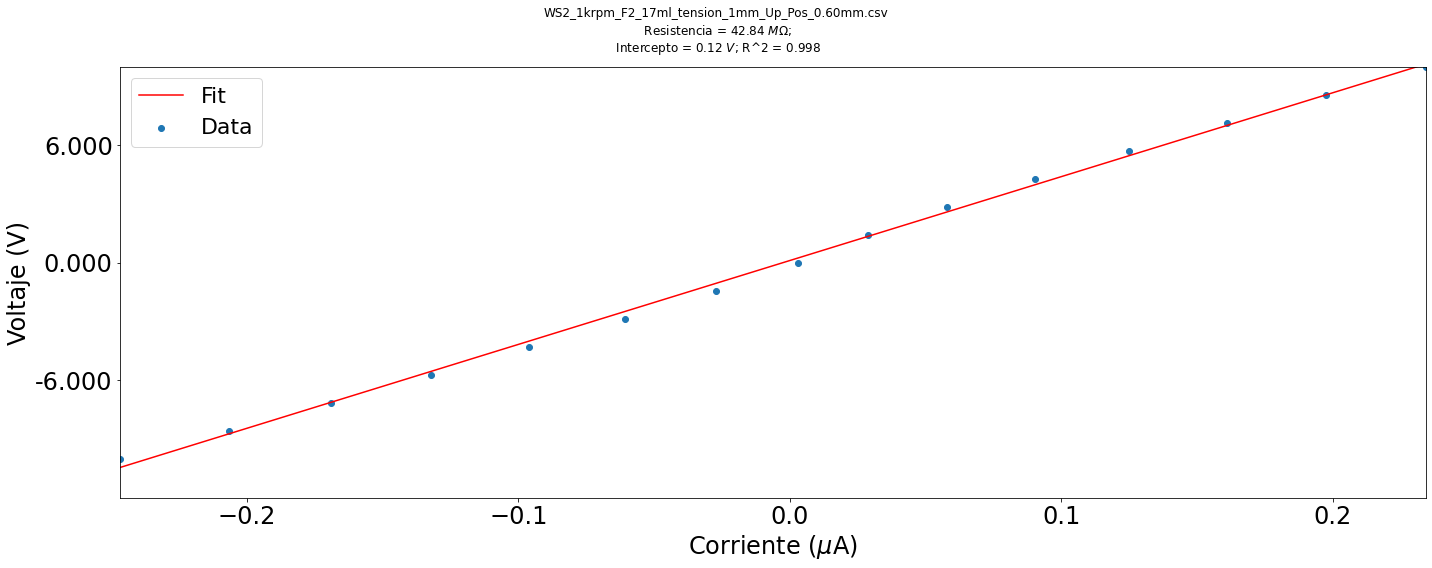

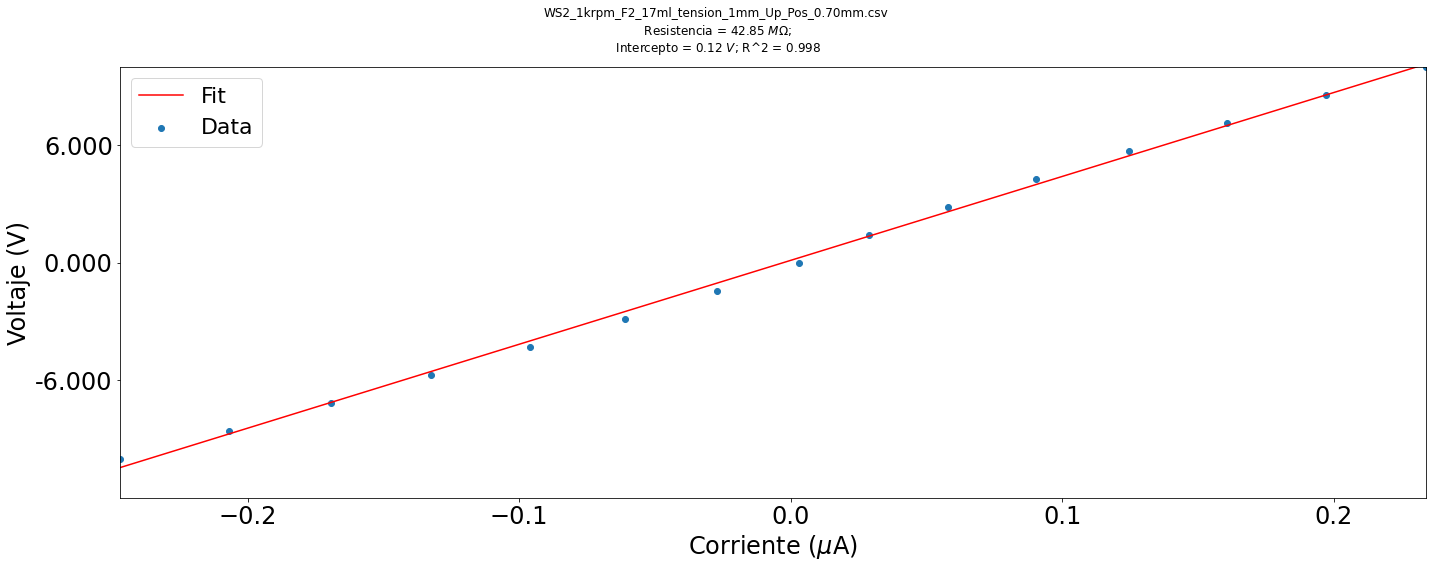

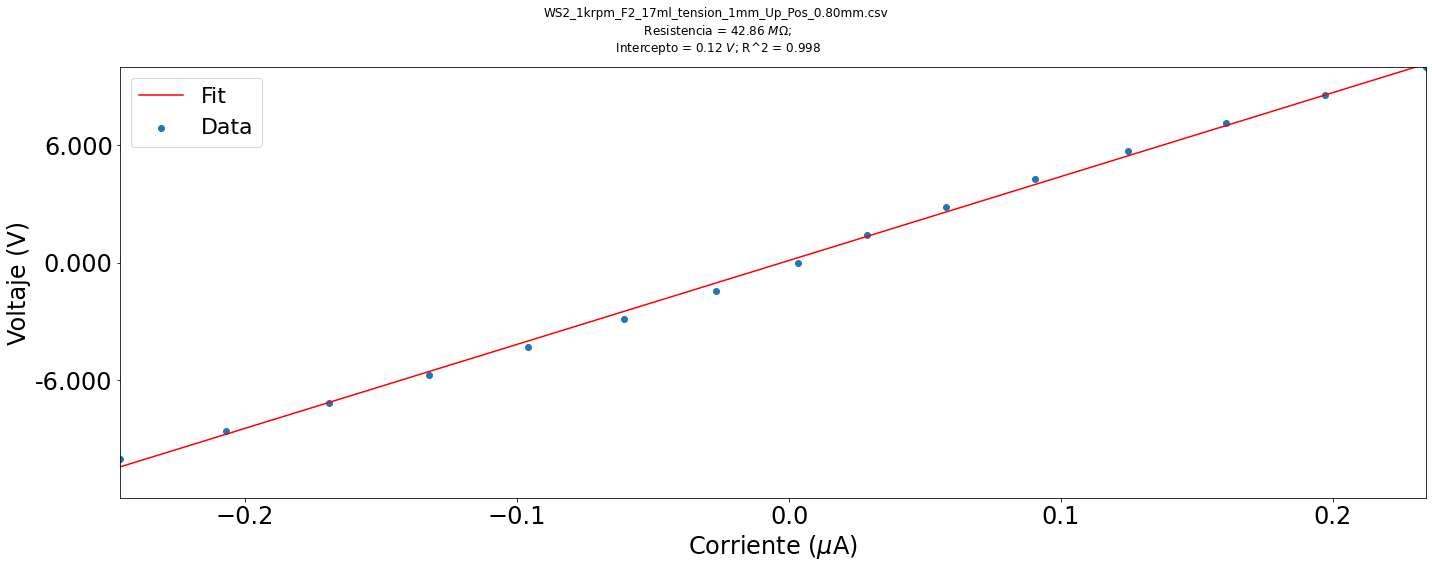

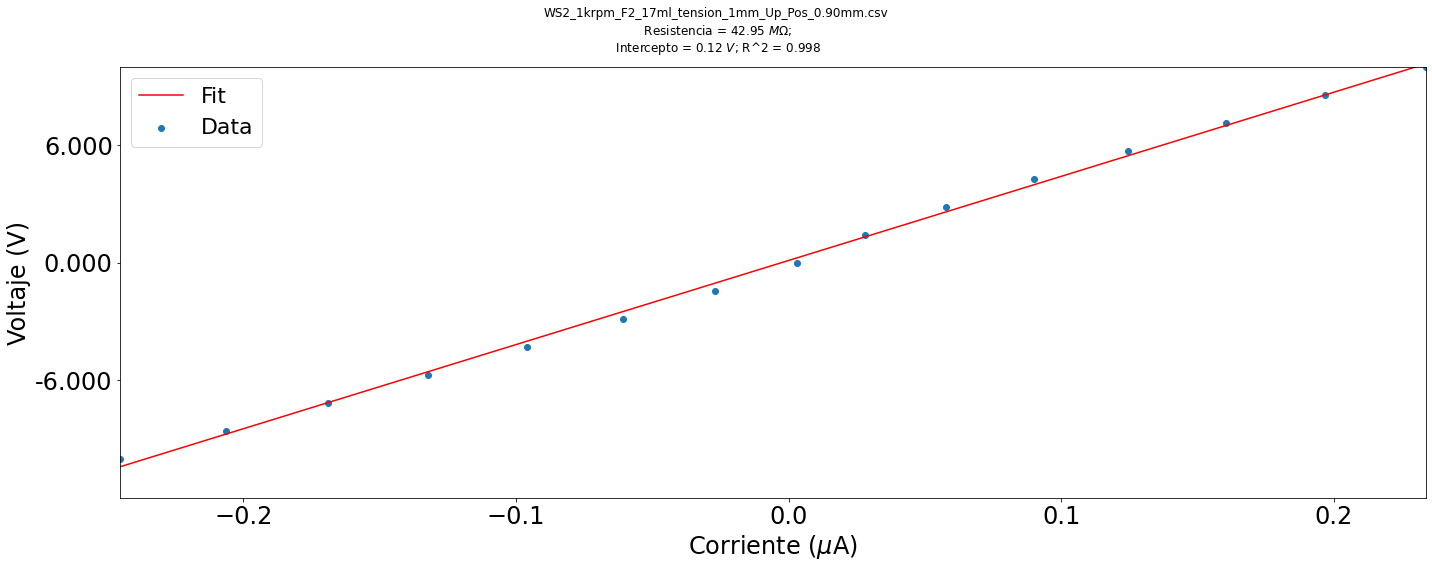

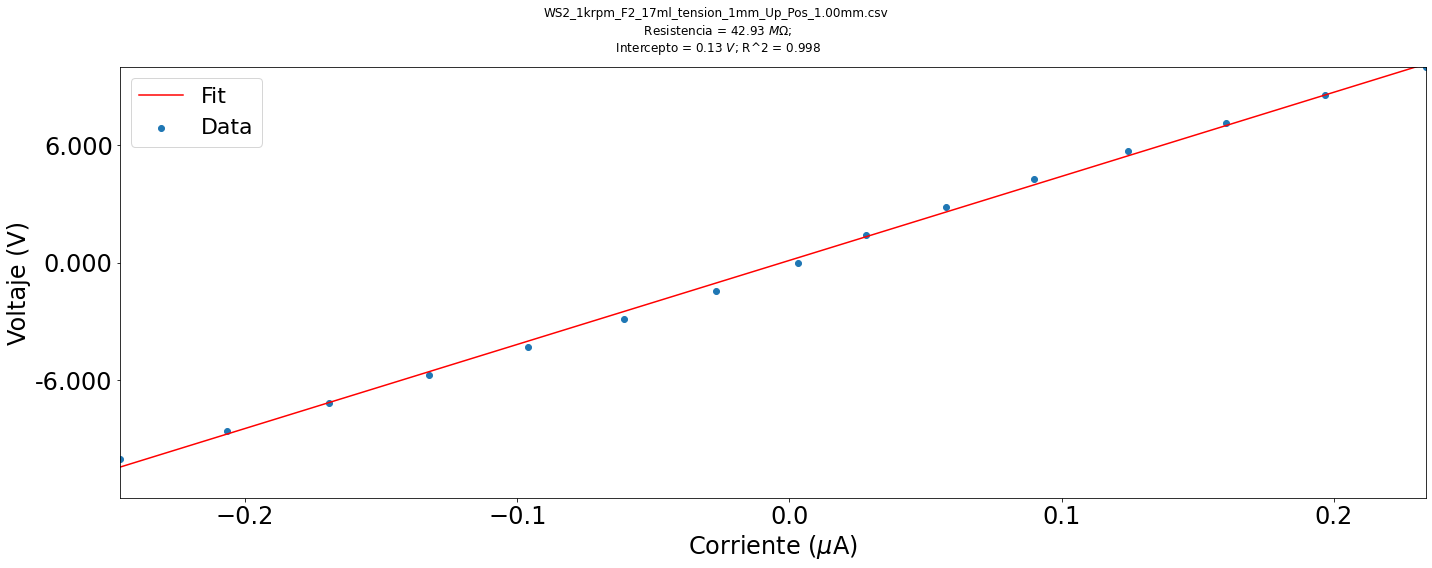

In [5]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_1krpm_F2_17ml_tension_1mm_Up_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ M\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[41.66314483213066, 41.844618445657545, 41.99179550368589, 42.01160758710154, 41.99638576414537, 42.129069853143264, 42.4088711025498, 42.57570199616569, 42.681640053588424, 42.814437925525, 42.951209846724545]


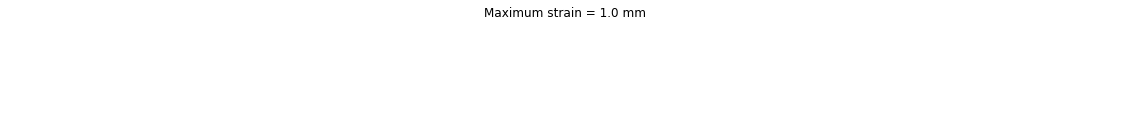

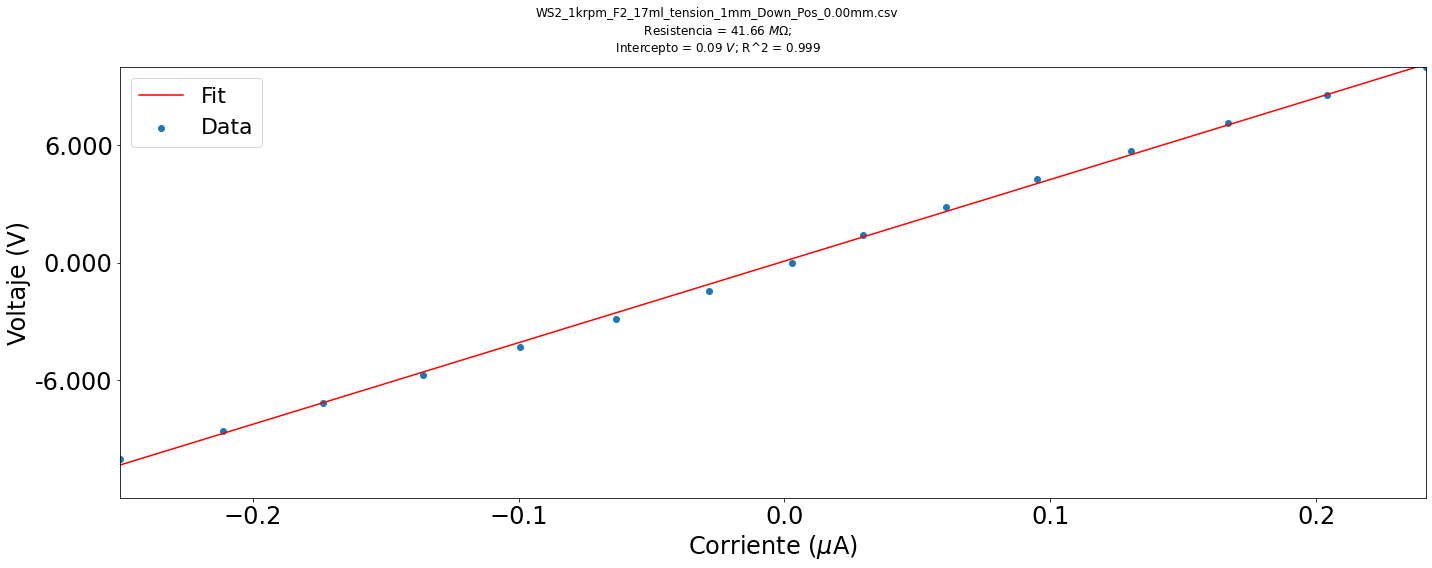

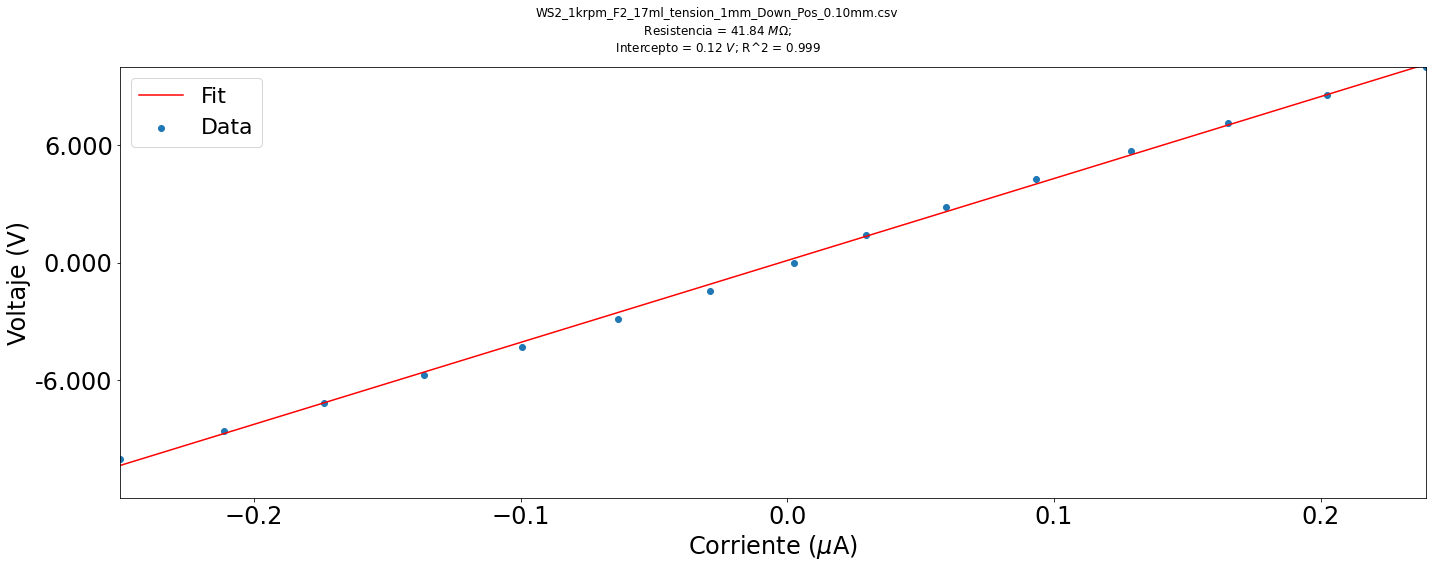

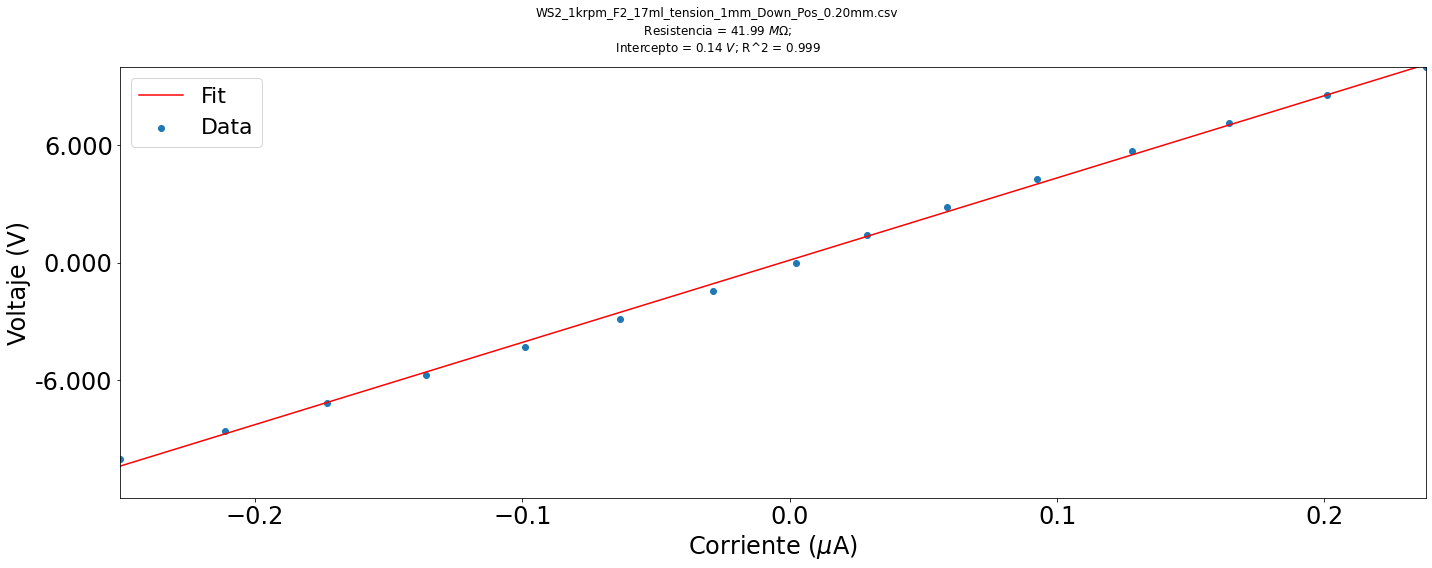

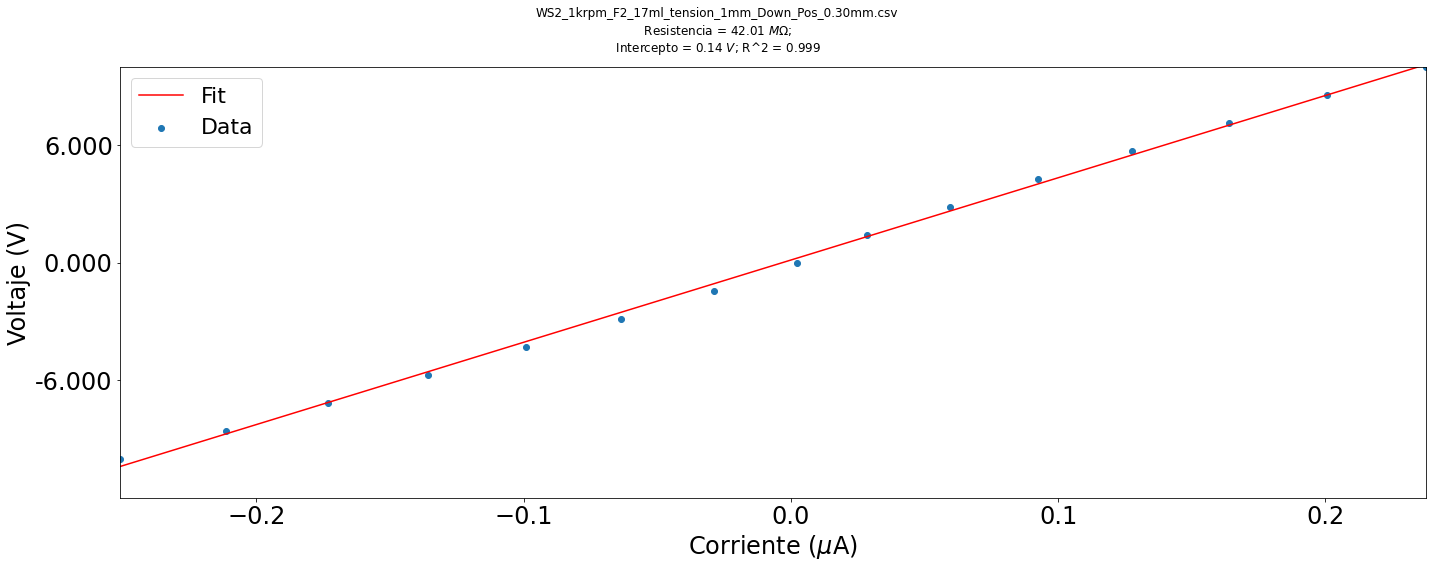

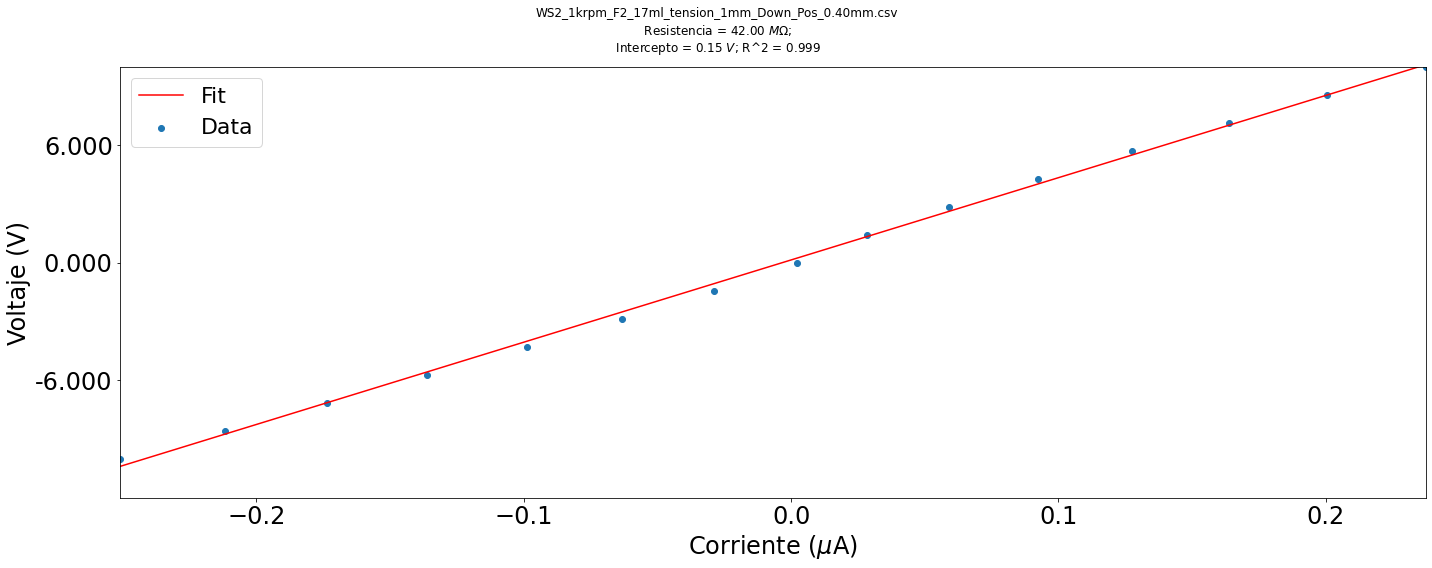

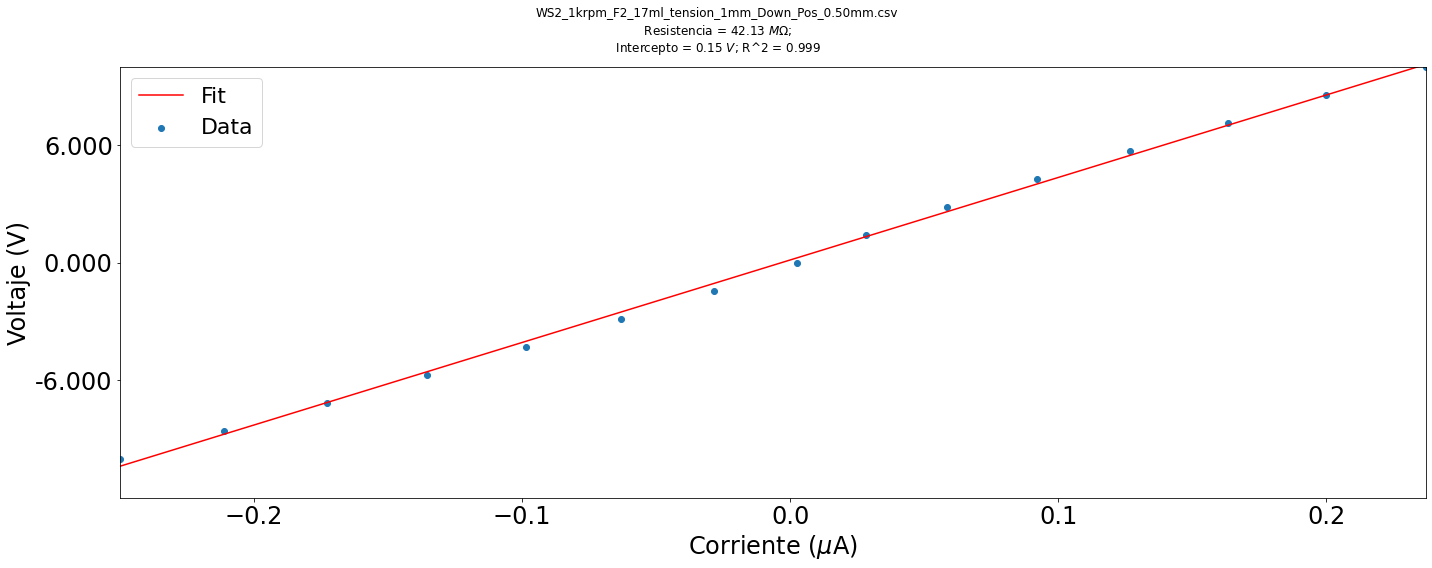

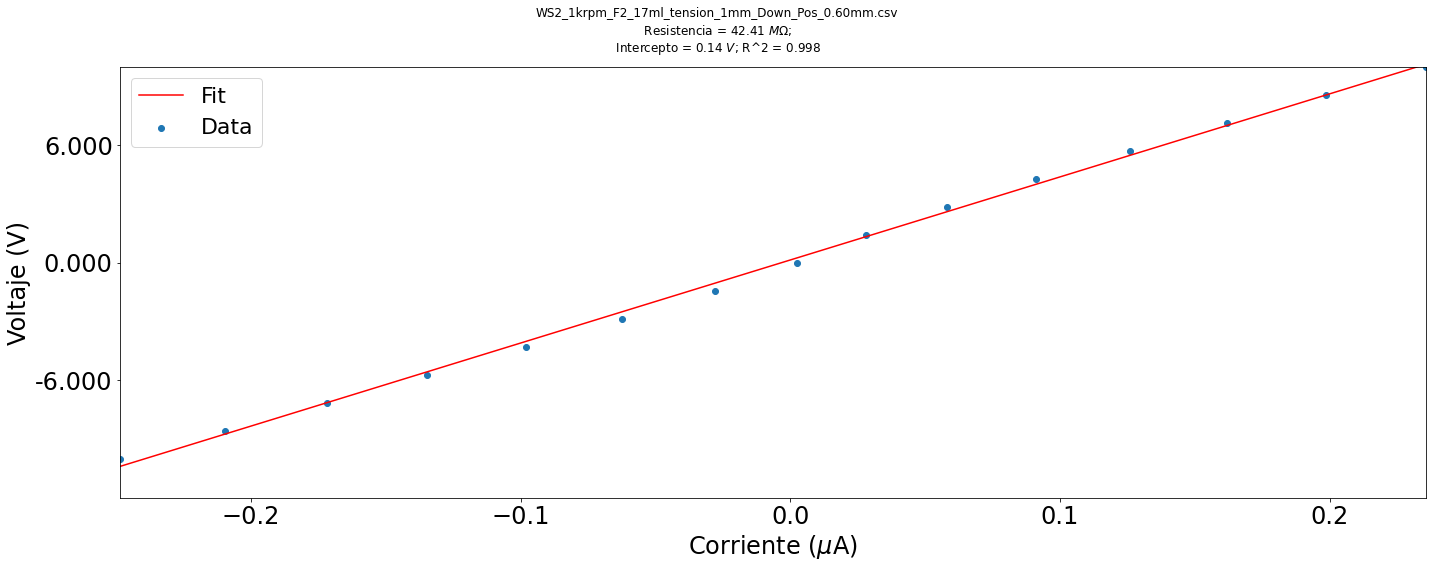

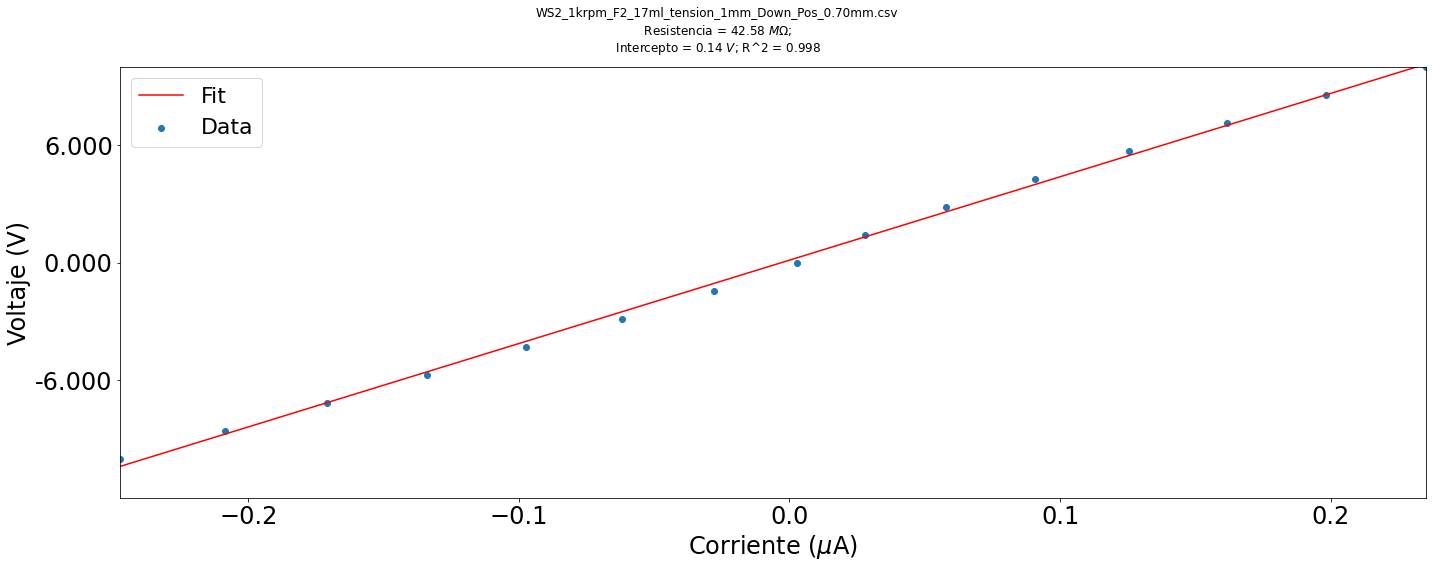

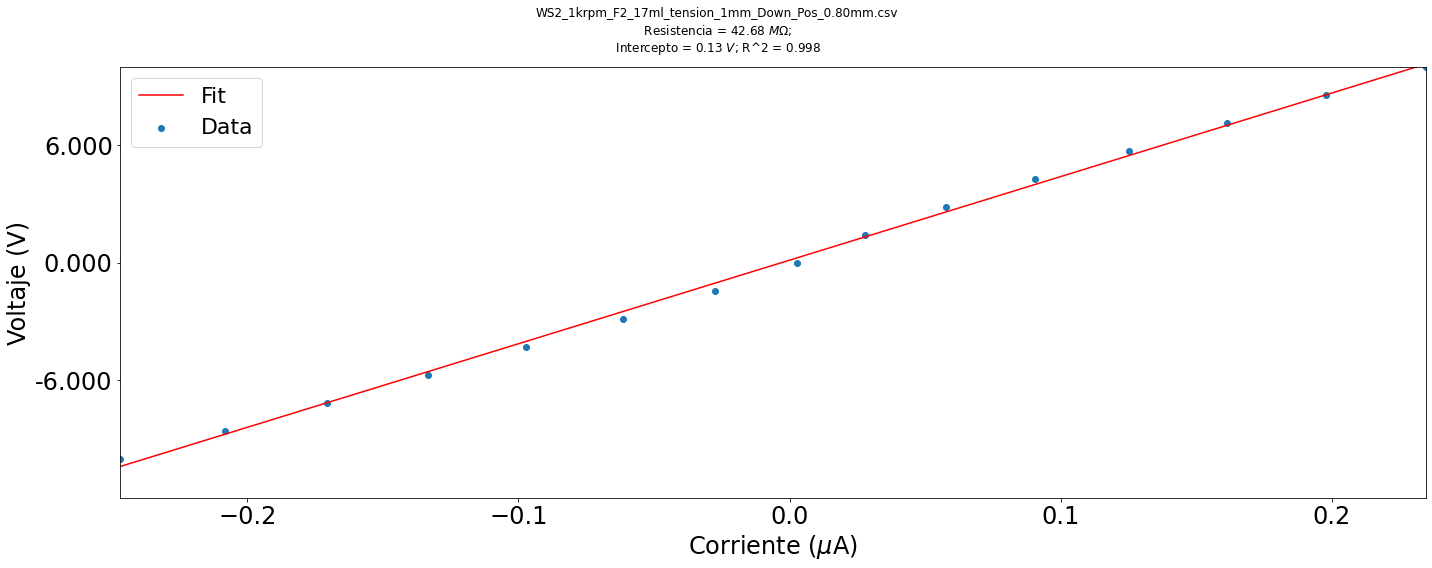

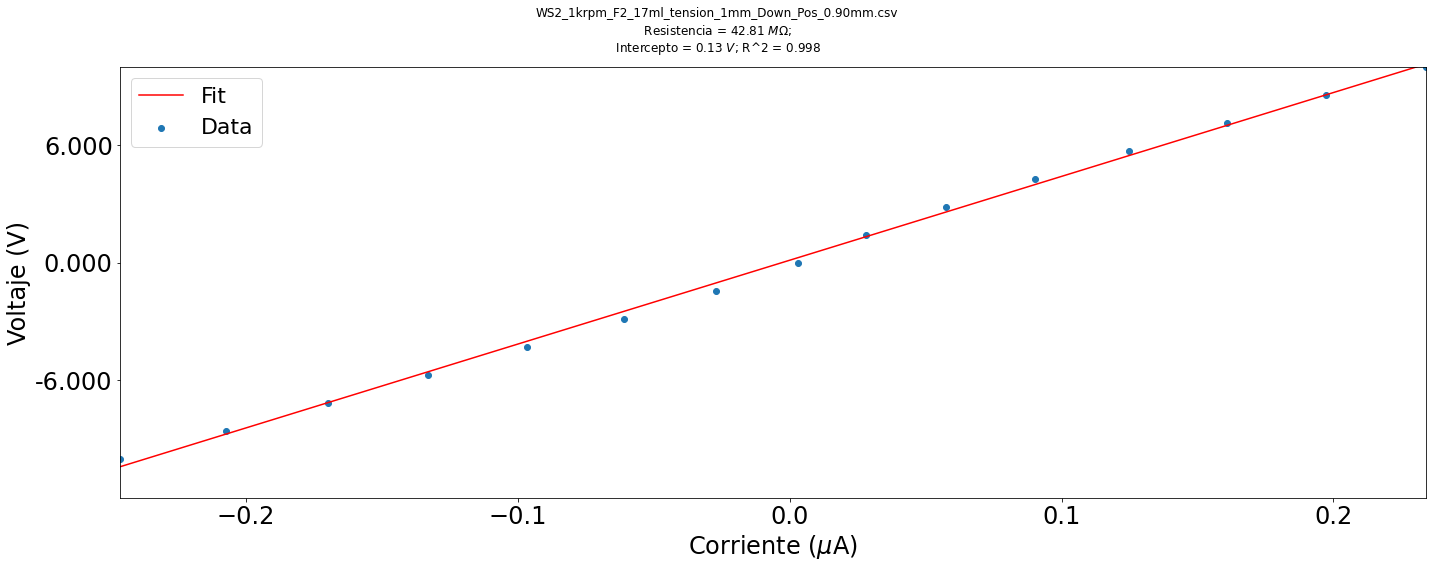

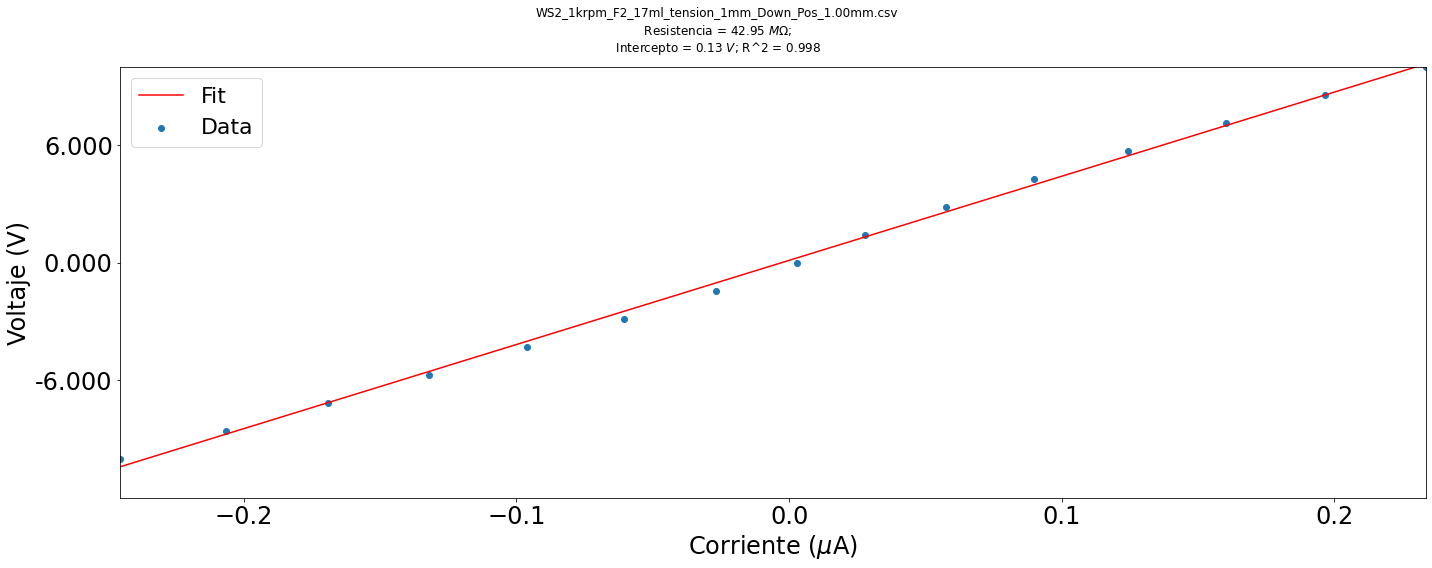

In [10]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_1krpm_F2_17ml_tension_1mm_Down_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ M\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[74.92872810069211, 60.227161603730394, 73.97438198812517, 83.81180016273363, 80.75204815785487, 80.42359413303976, 72.43227683885769, 68.70937464696792, 76.00088750463506, 76.31410917397332, 76.82901695586405]


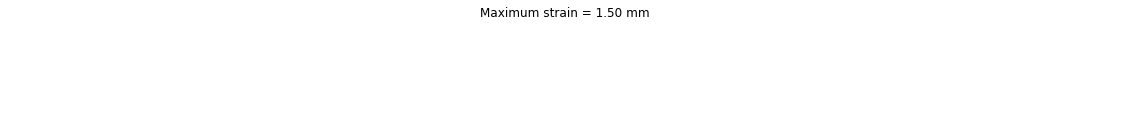

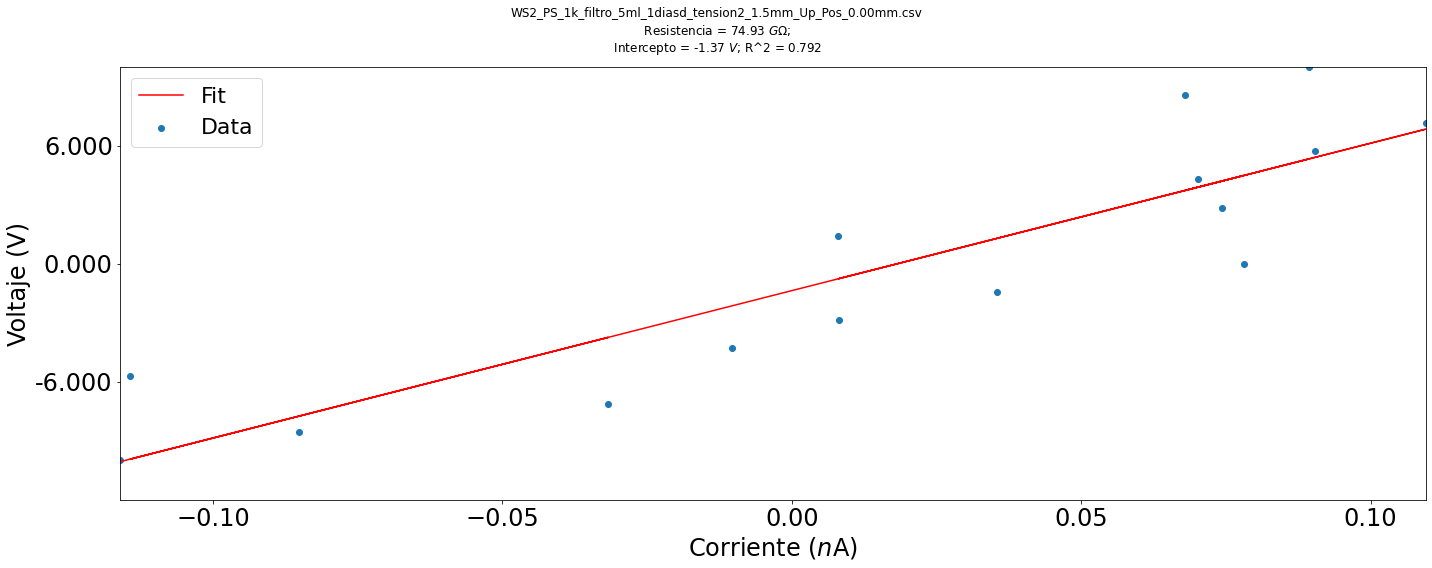

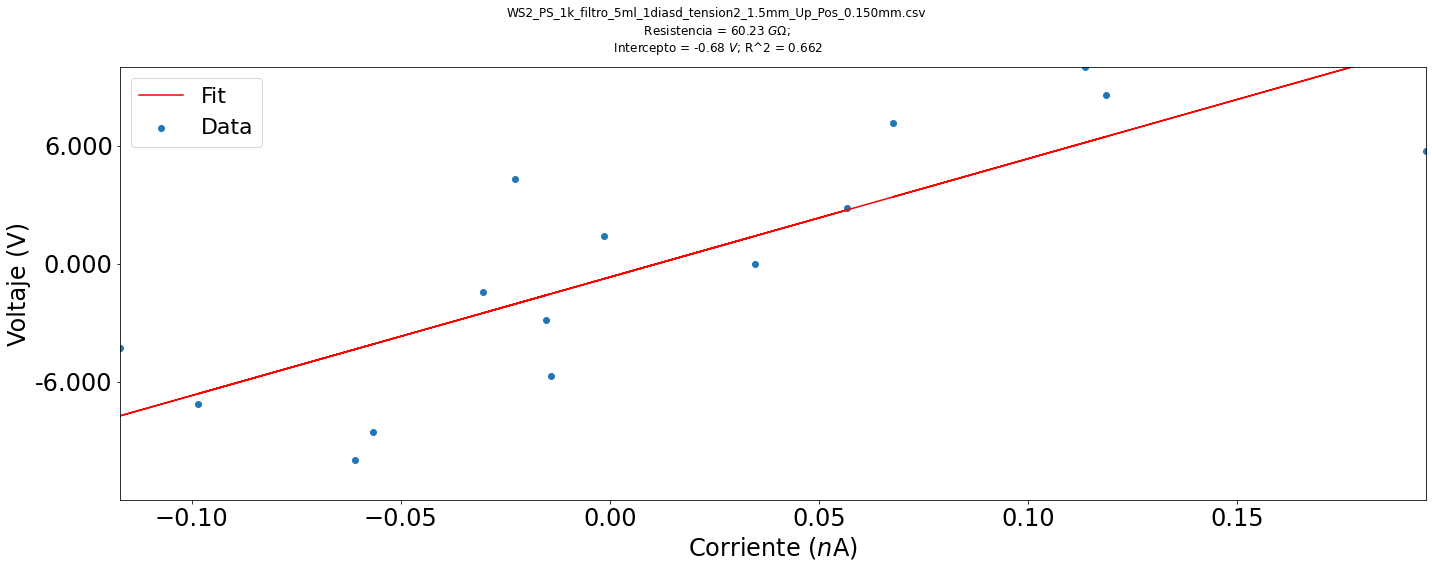

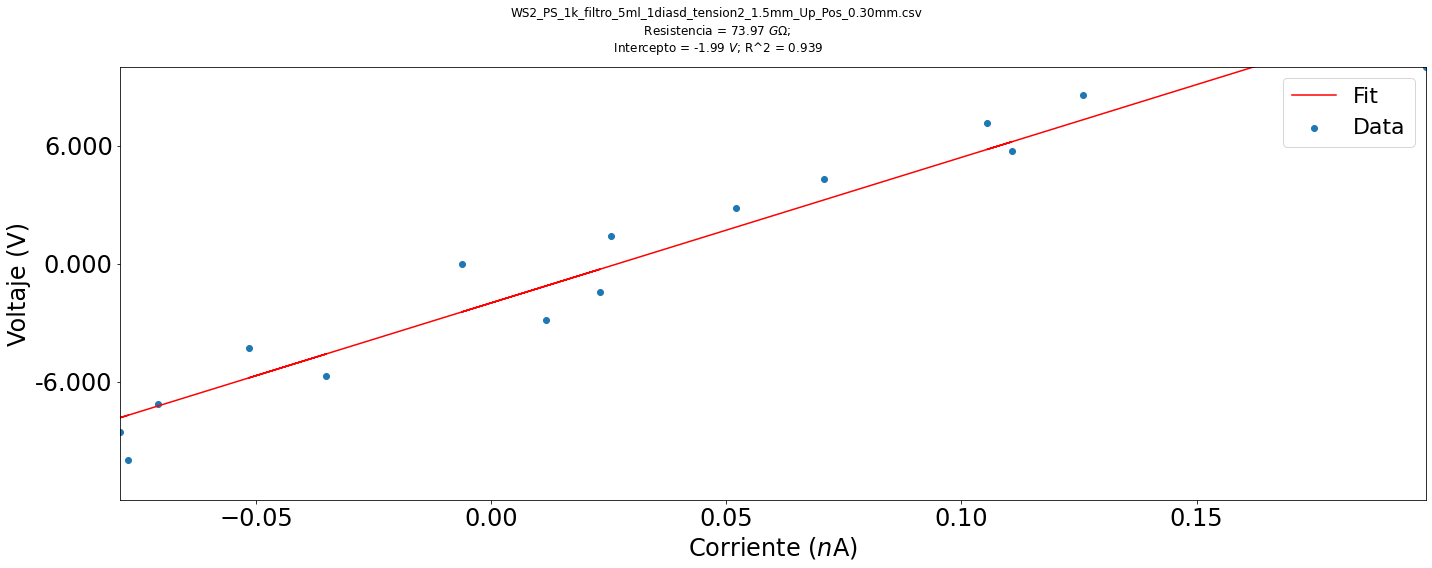

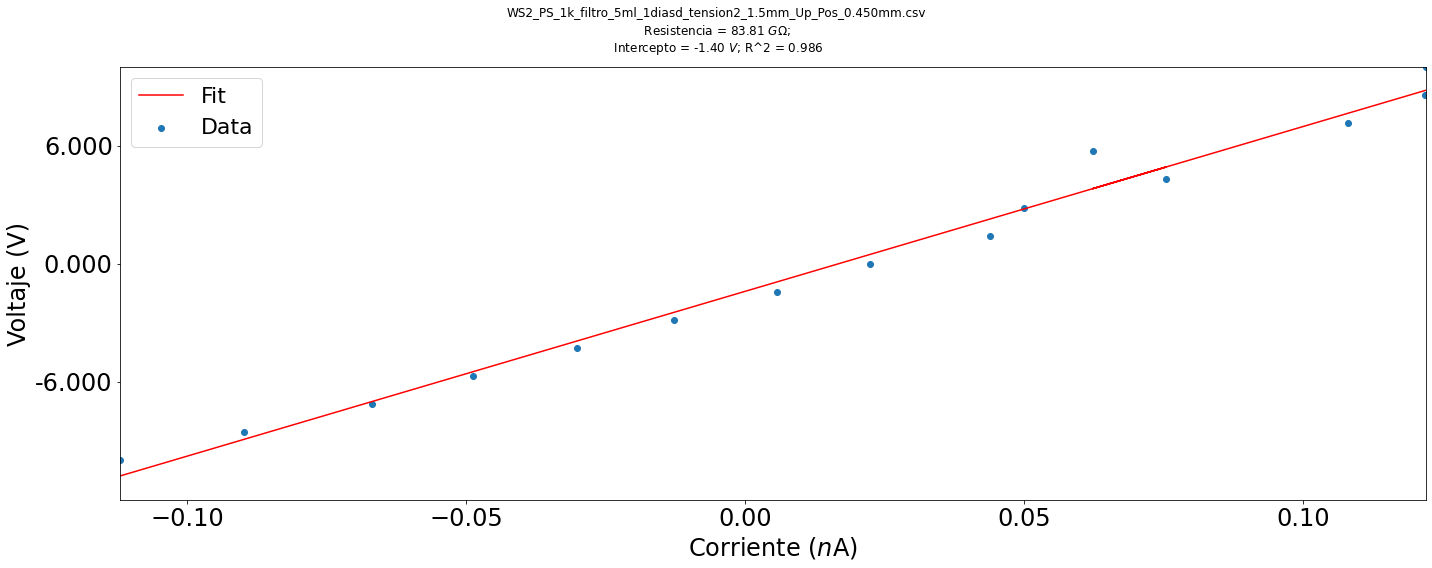

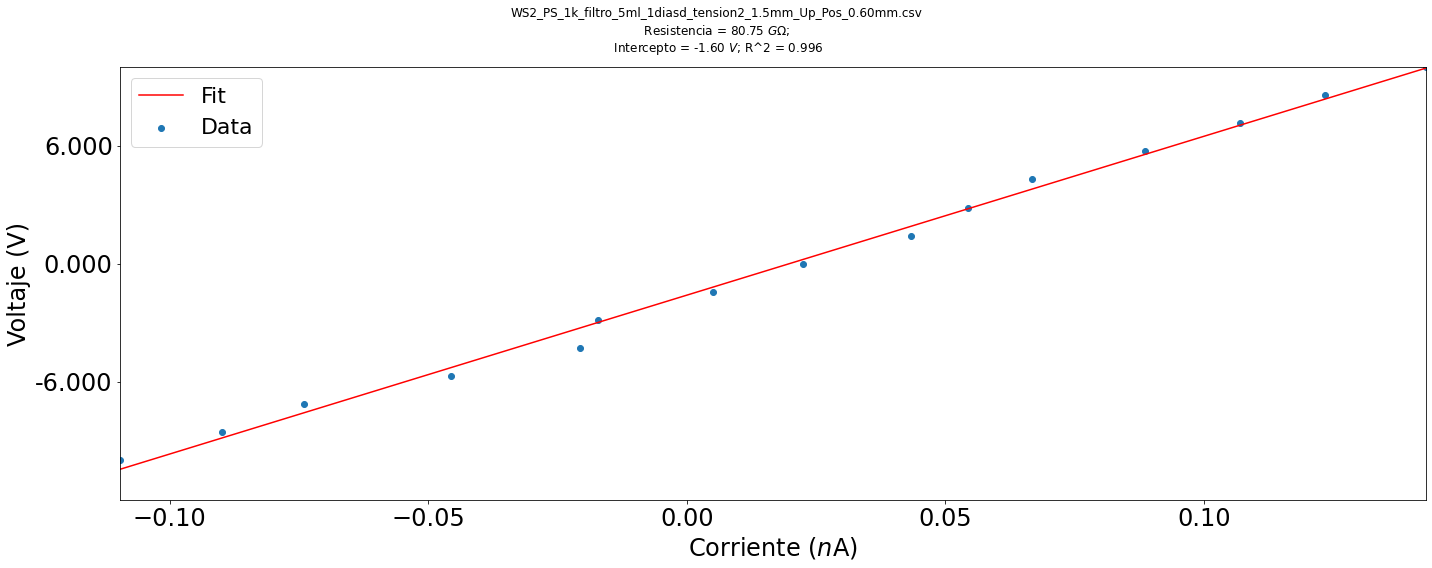

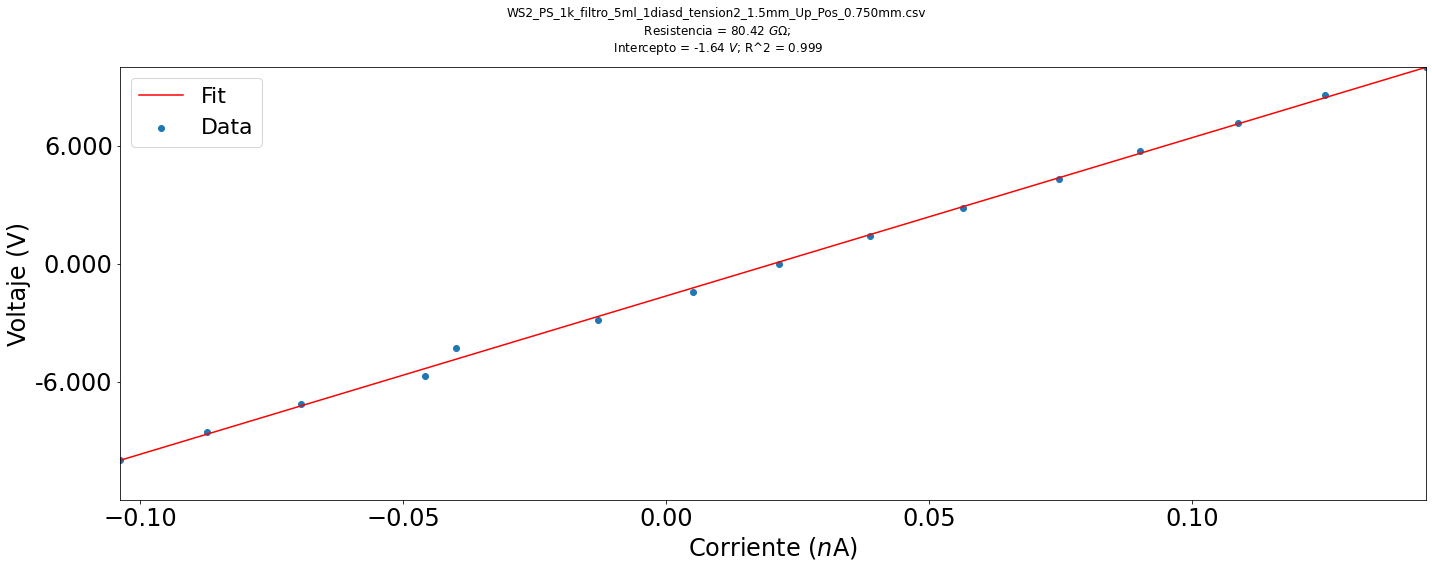

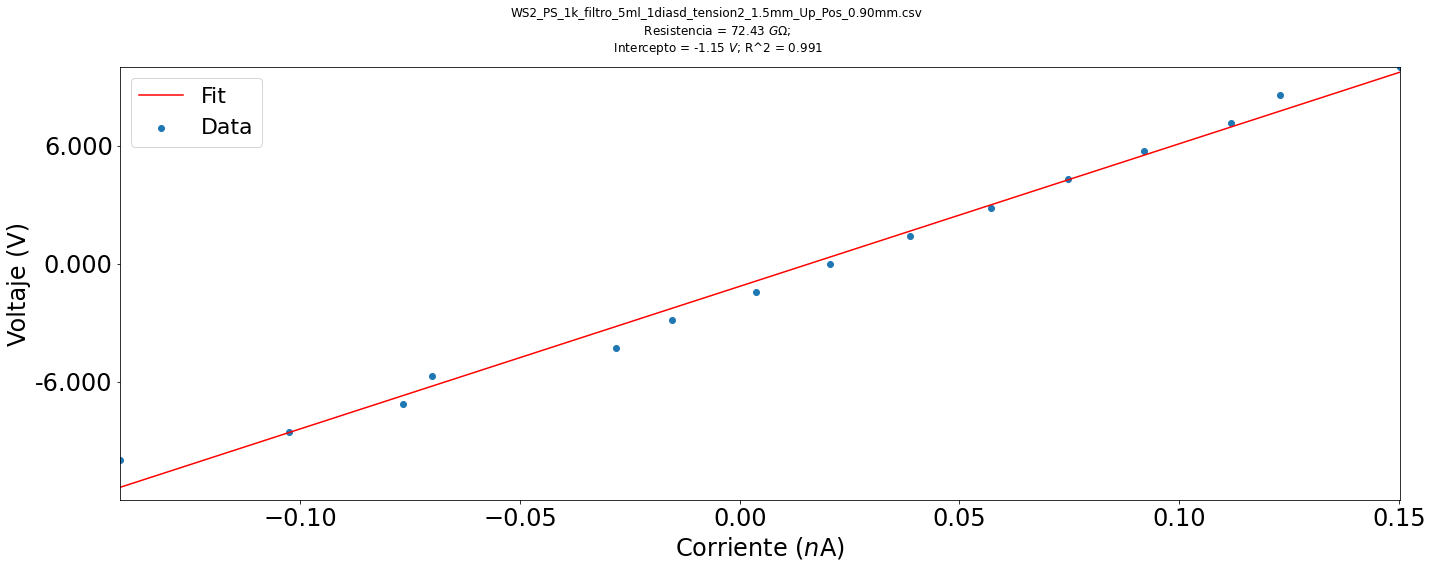

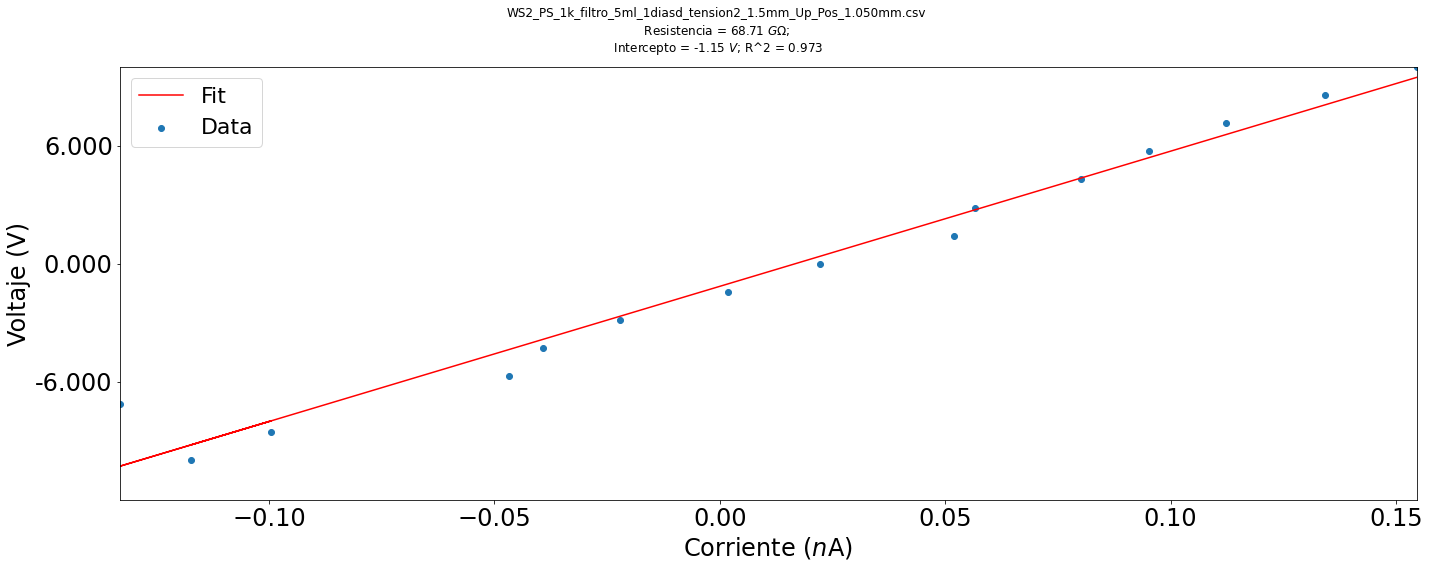

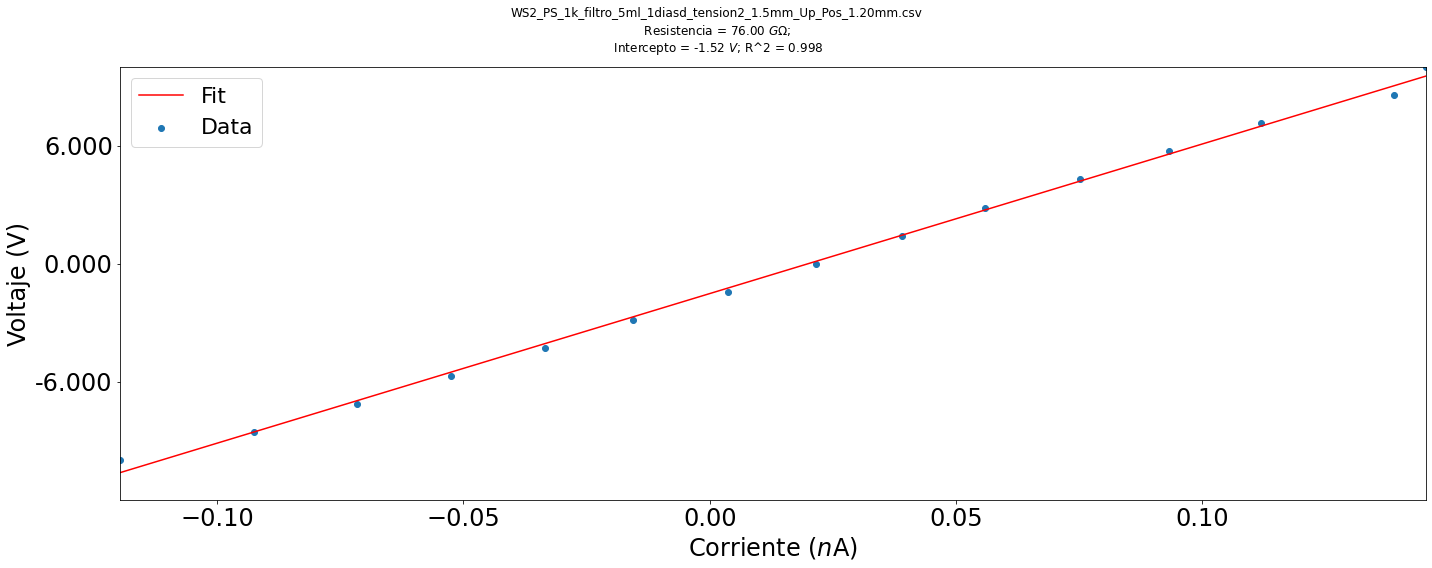

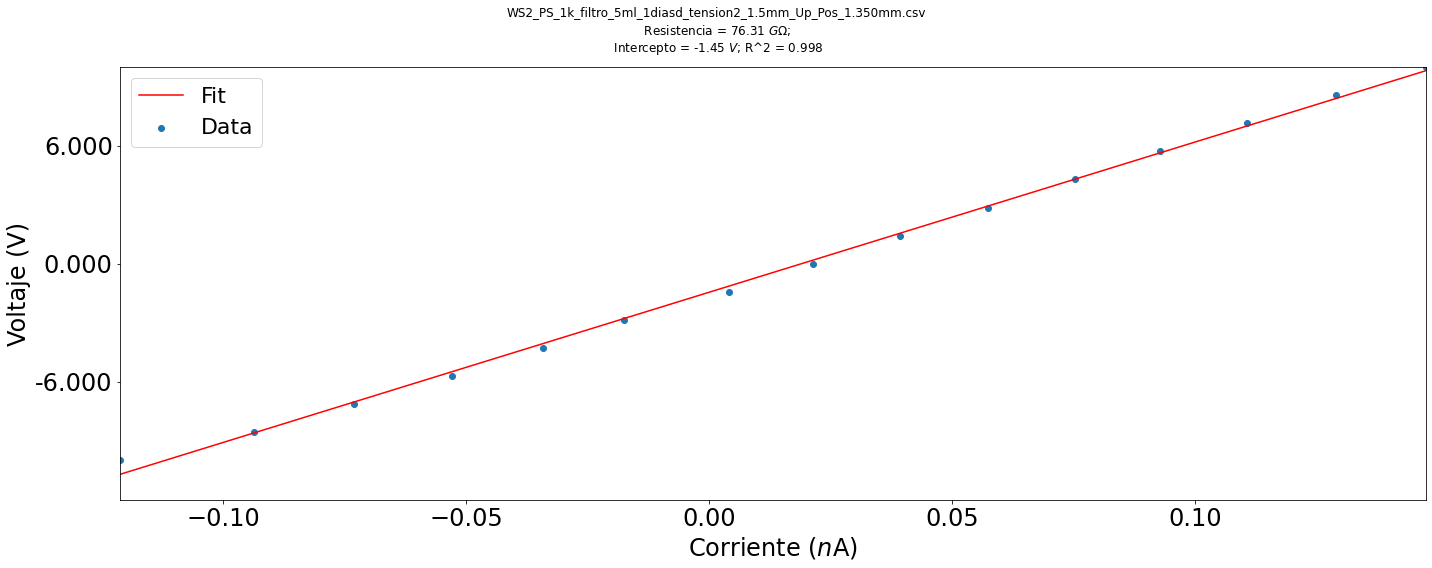

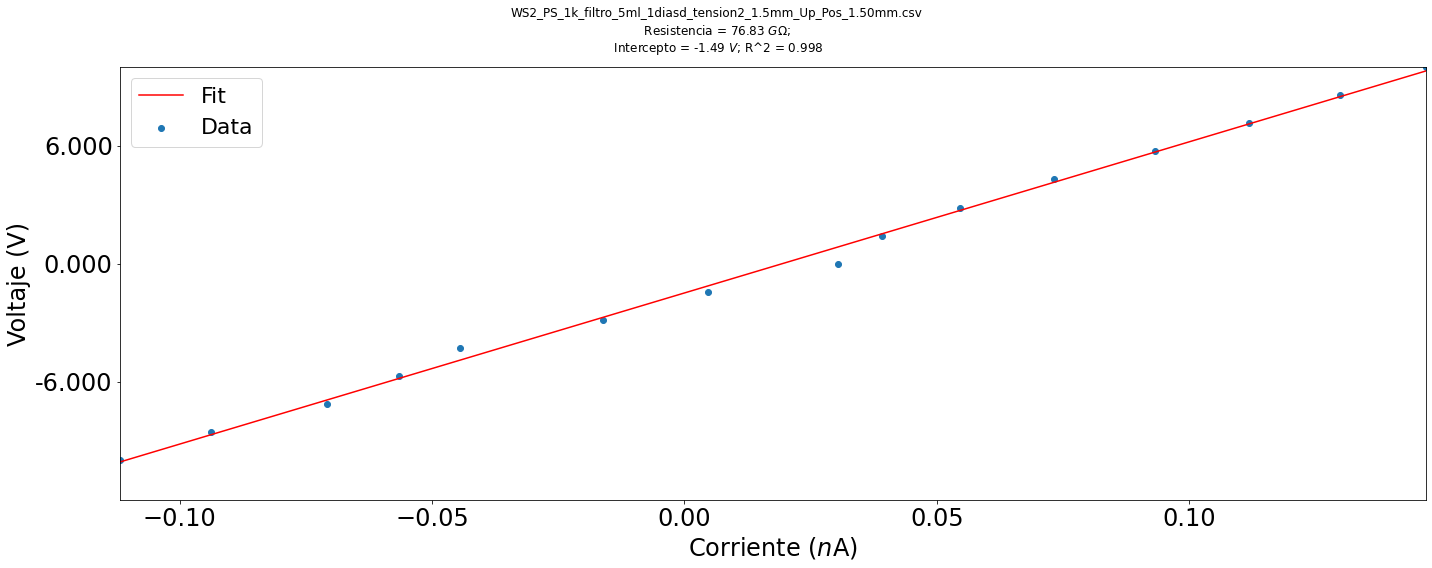

In [21]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_PS_1k_filtro_5ml_1diasd_tension2_1.5mm_Up_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1.5
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[79.31295326278993, 66.97306700910954, 78.58988161299686, 81.52111121543011, 68.62679319492999, 69.54707317846513, 78.69229239899336, 73.39675710658423, 73.92525081842767, 74.54431357756555, 76.0488173715928]


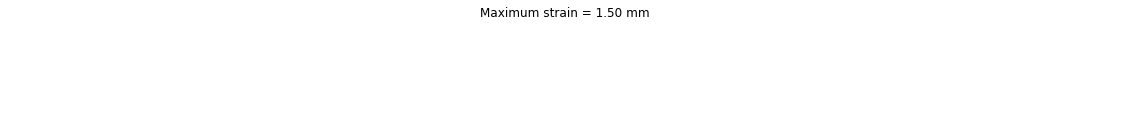

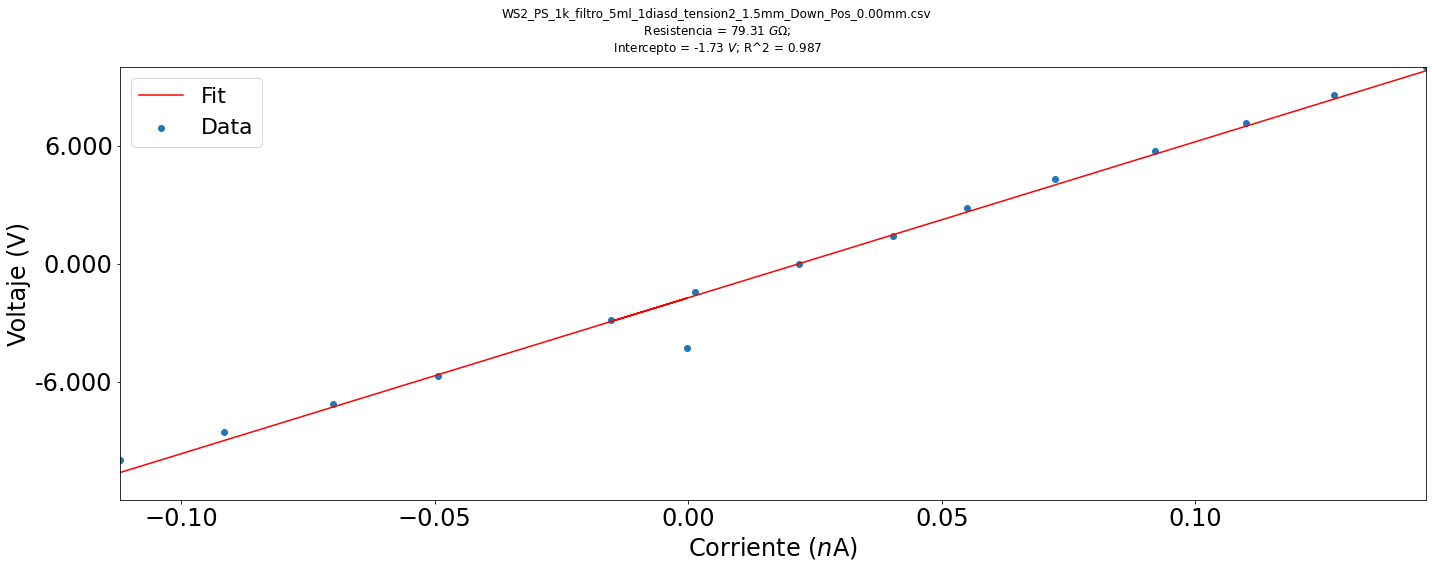

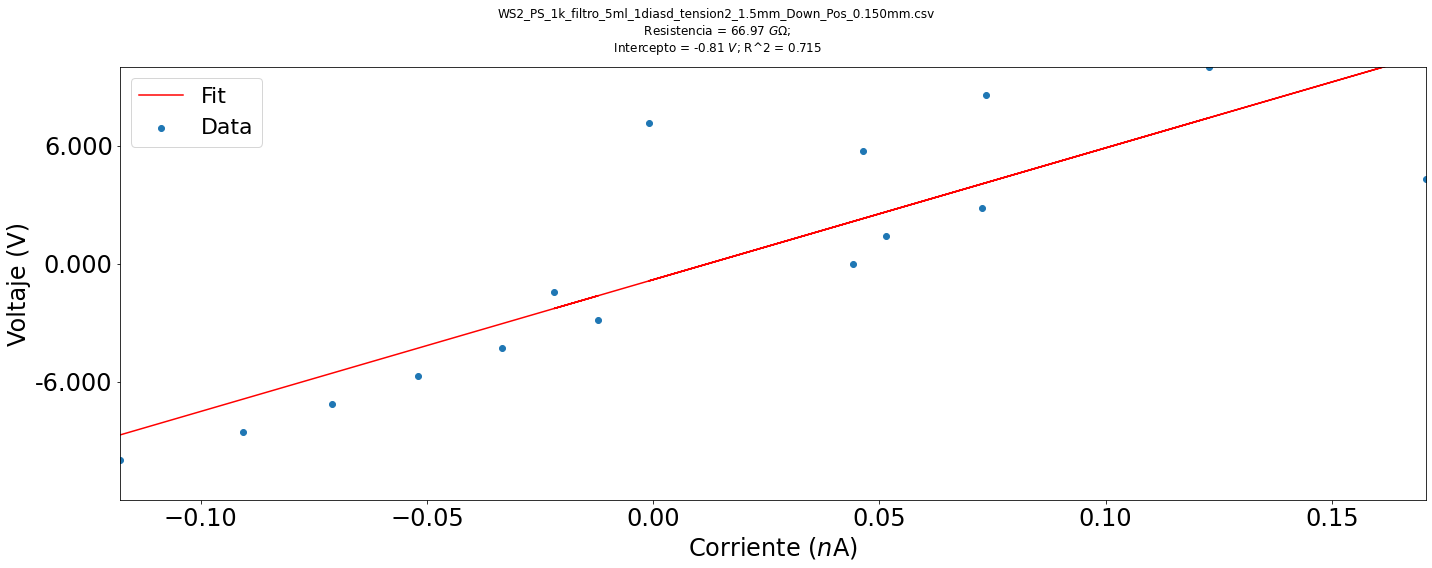

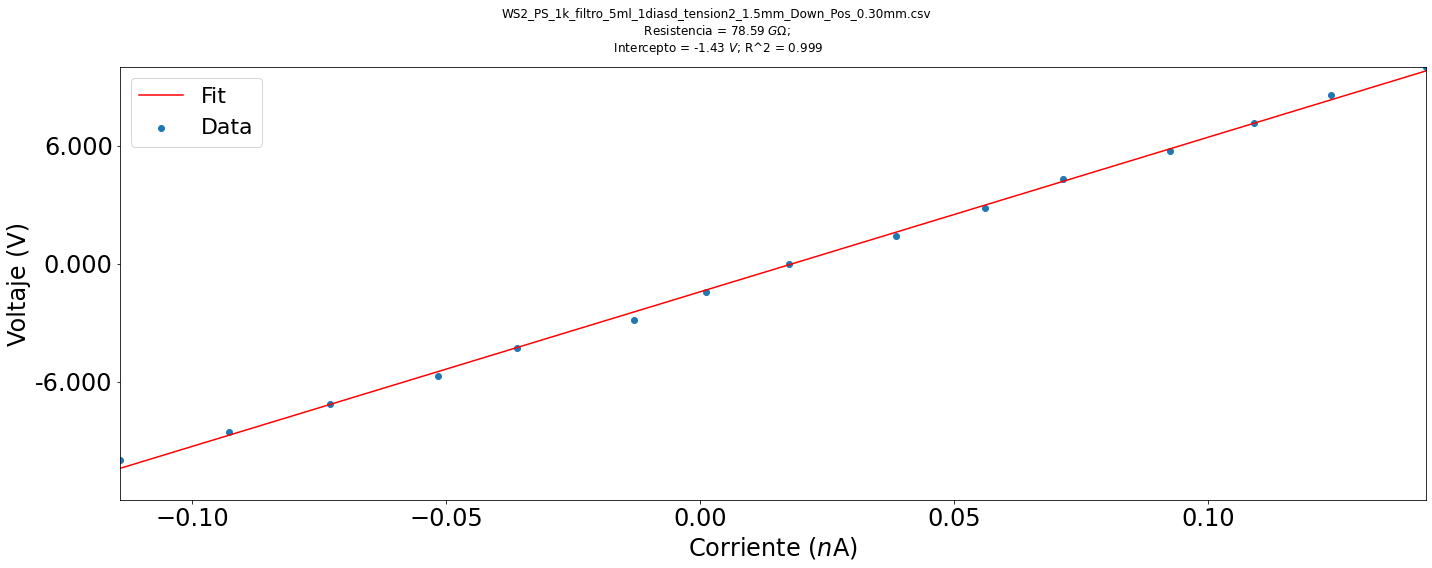

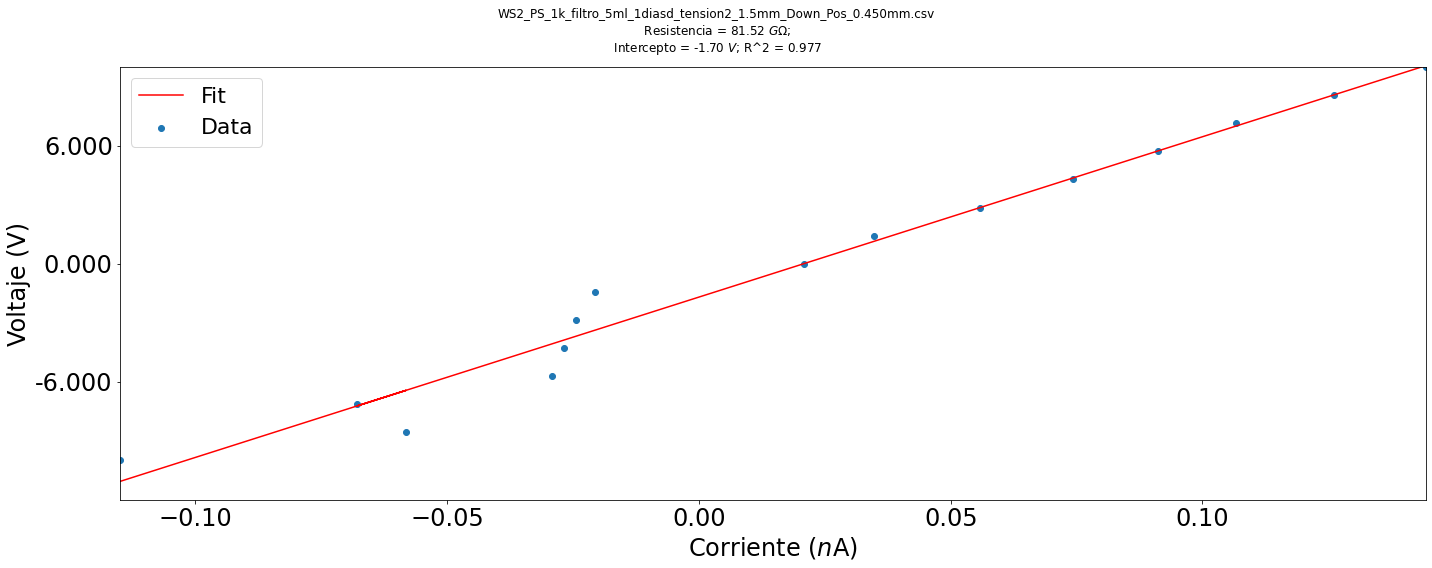

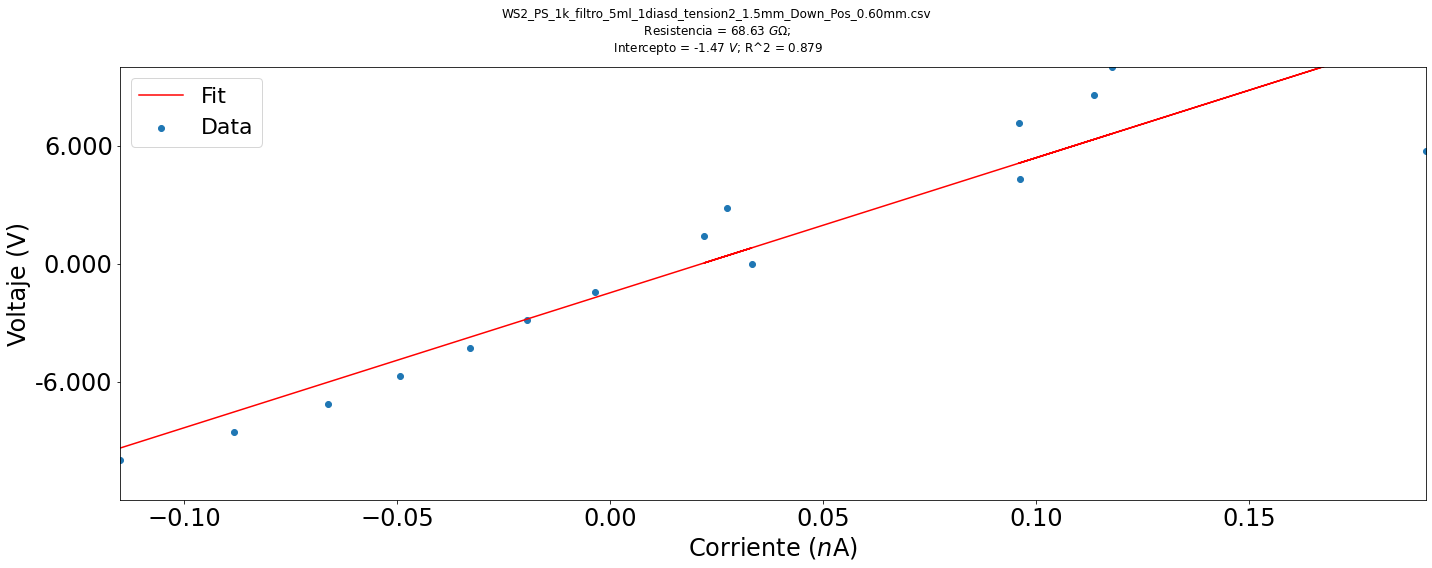

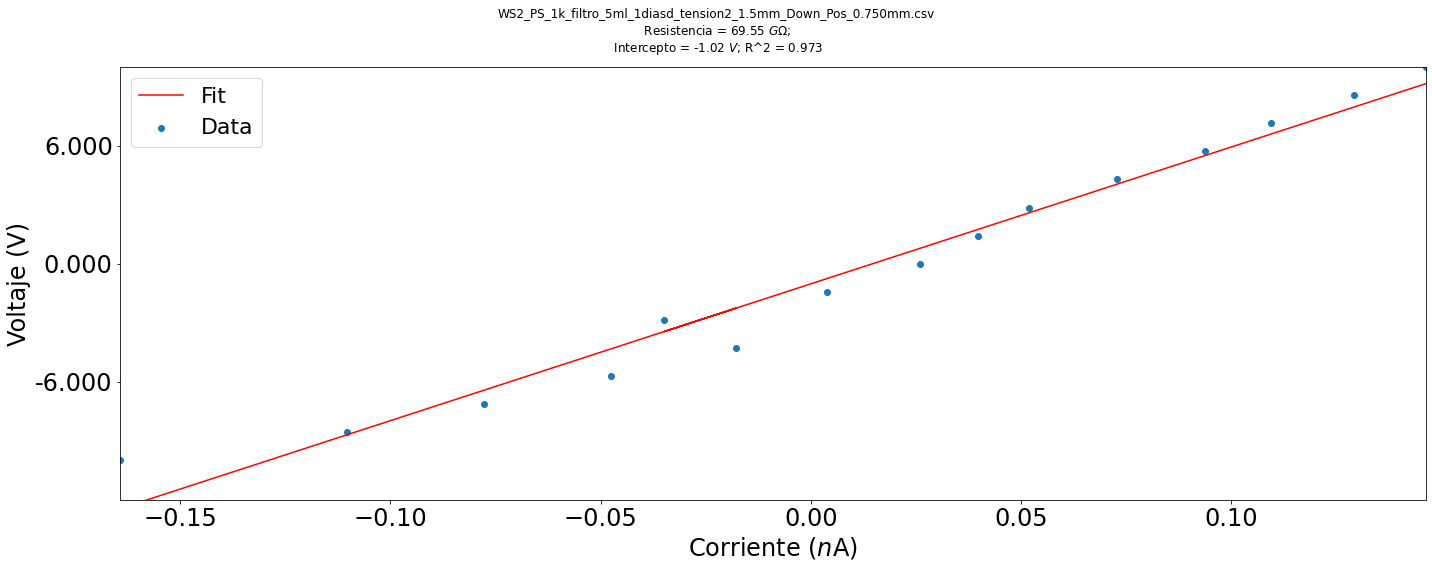

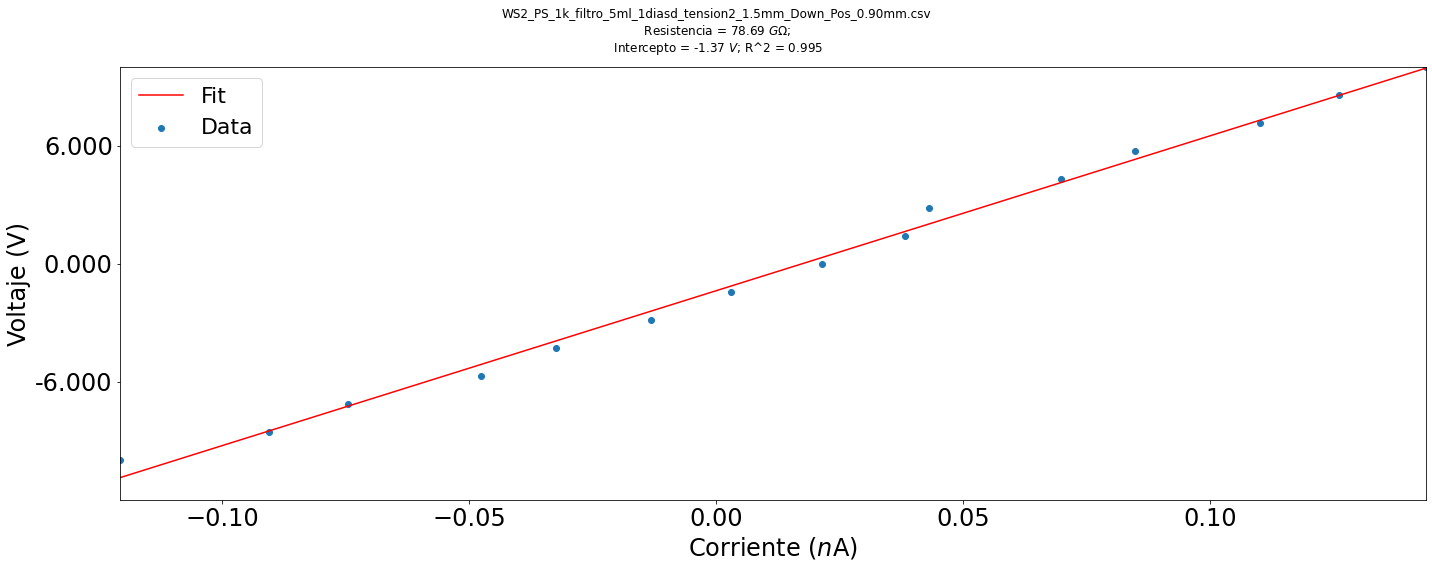

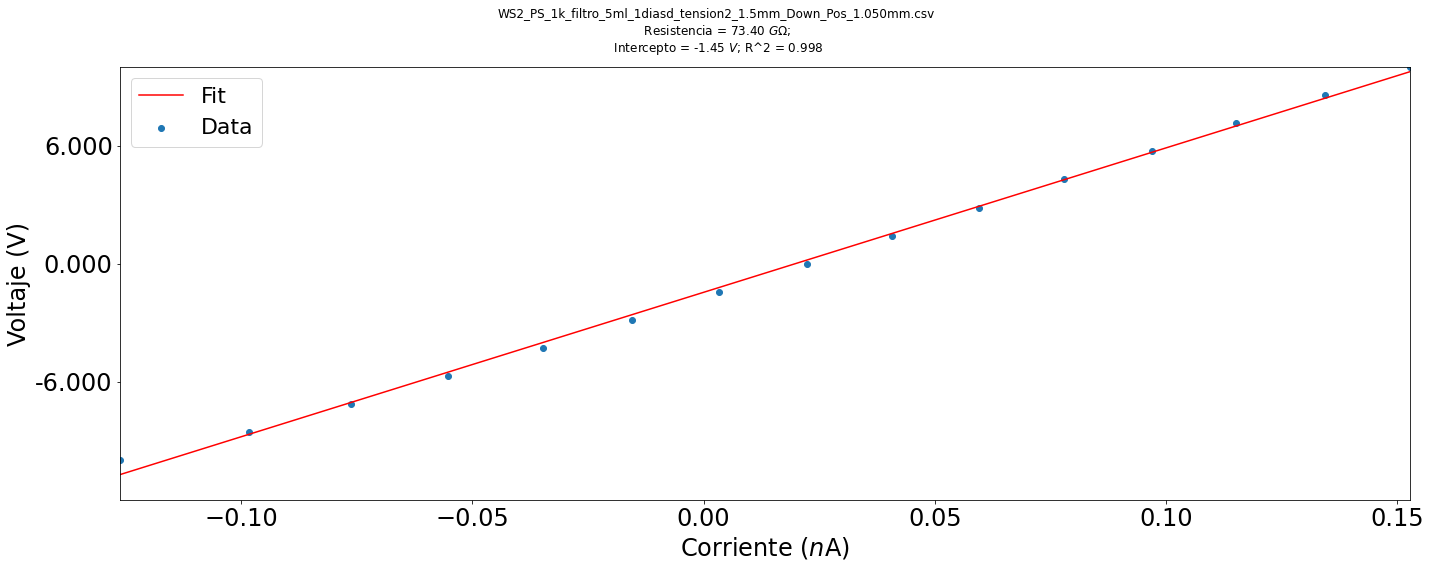

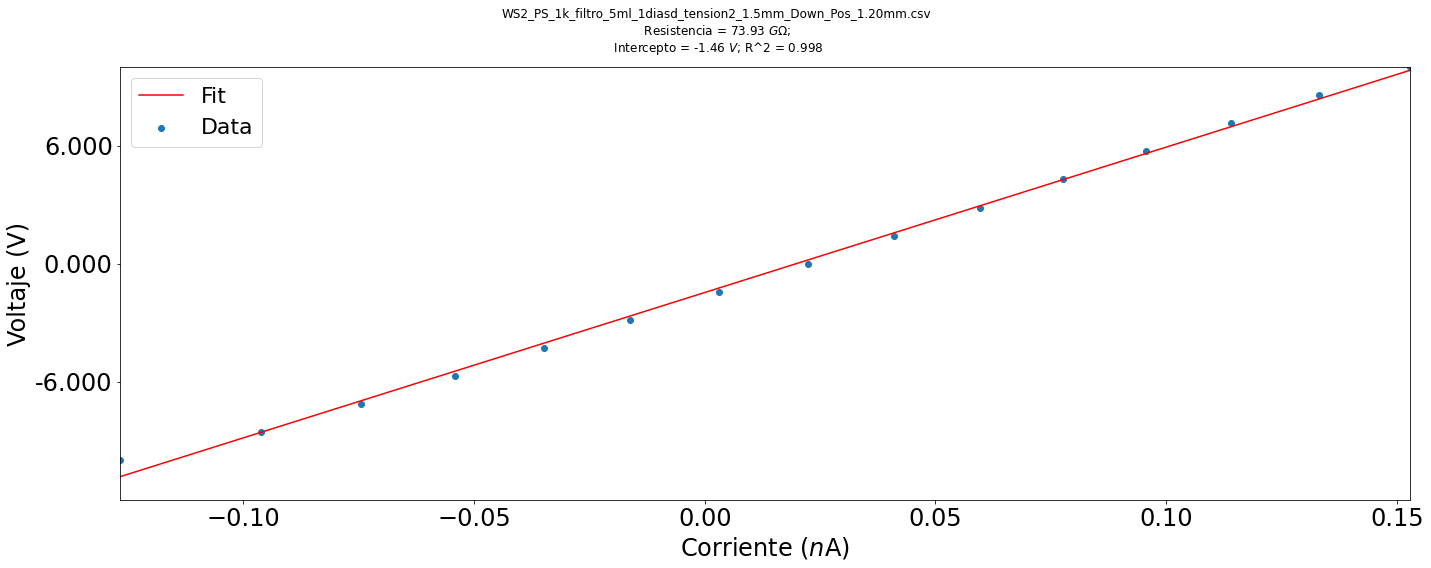

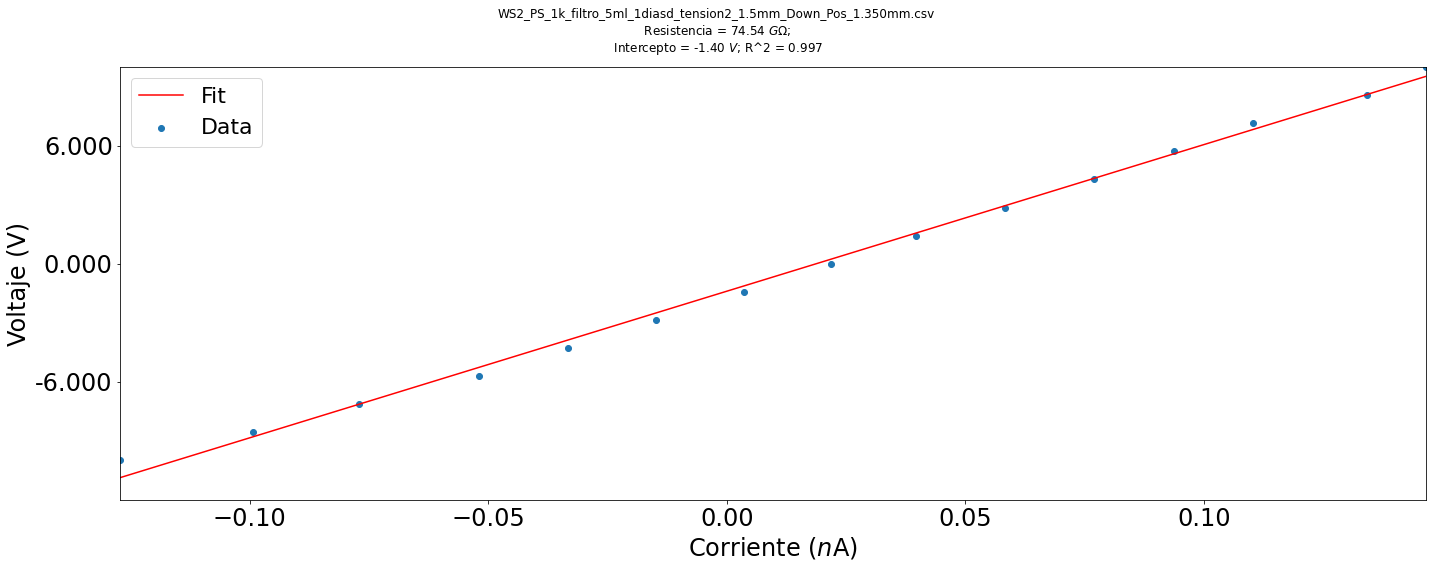

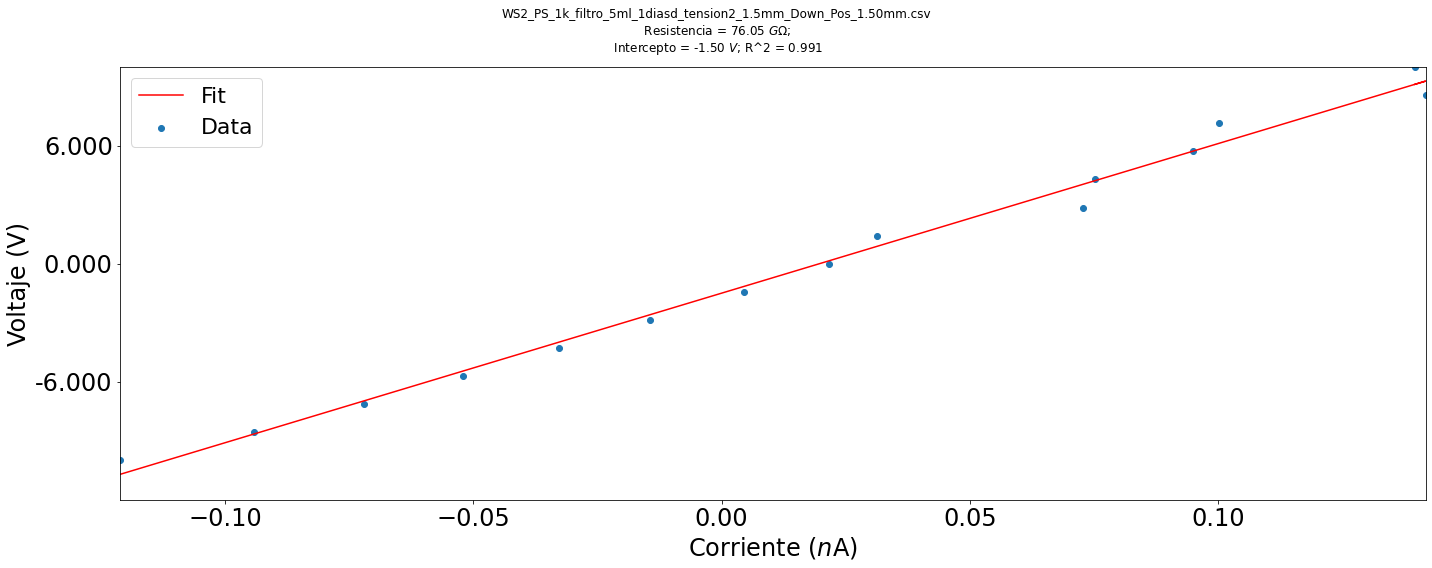

In [20]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_PS_1k_filtro_5ml_1diasd_tension2_1.5mm_Down_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1.5
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[6.893958952331437, 7.317188052619295, 6.968832031747465, 7.090906092172887, 7.196053194735508, 6.948056530461224, 6.837578534585963, 7.245311492970327, 6.672614094038904, 6.979930944164331, 7.1248781554302125]


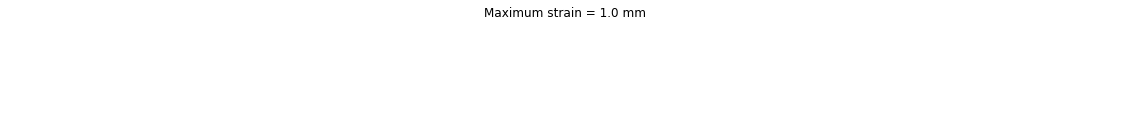

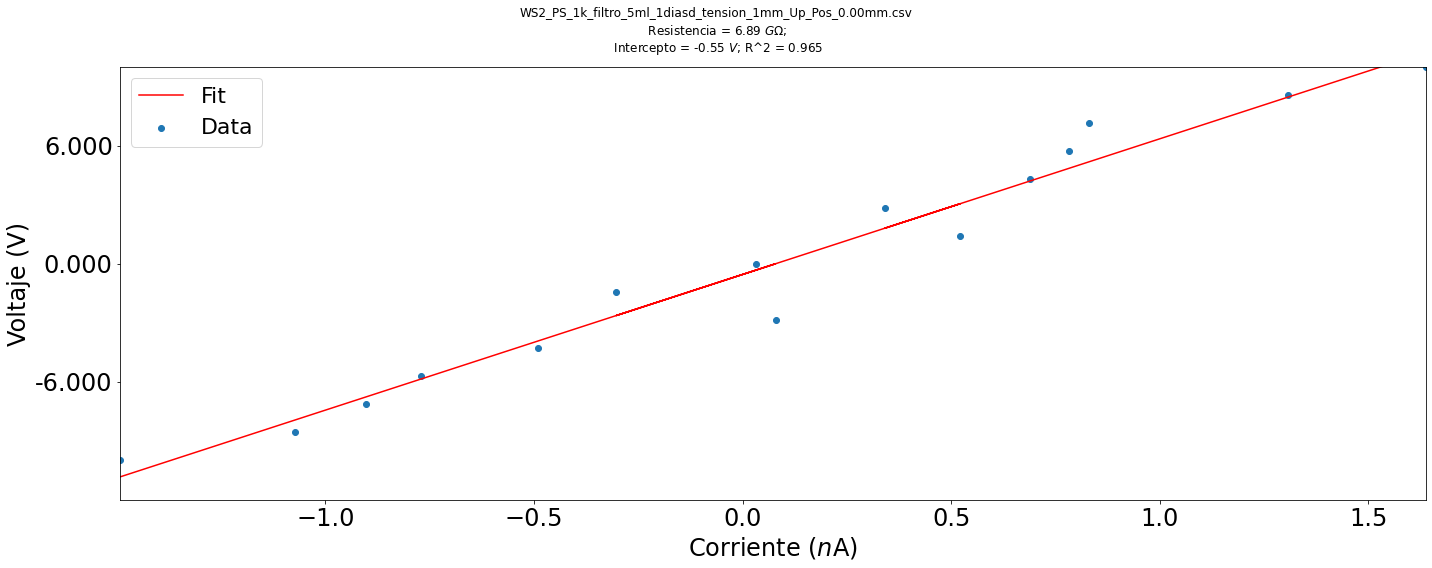

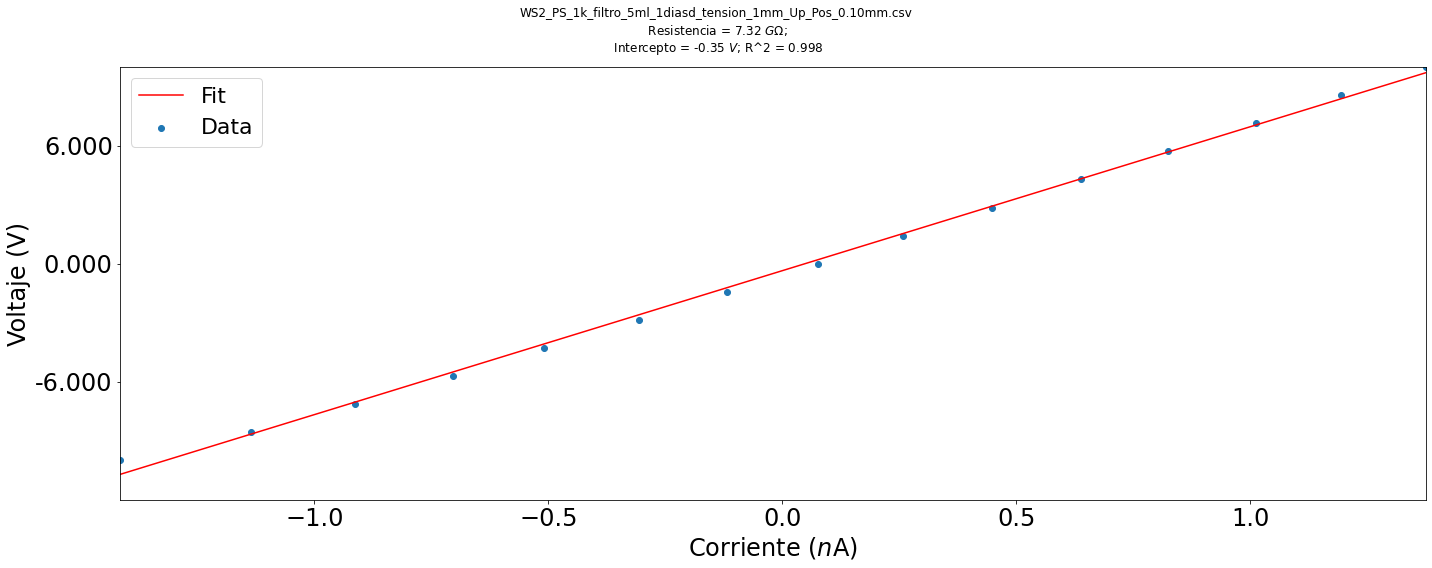

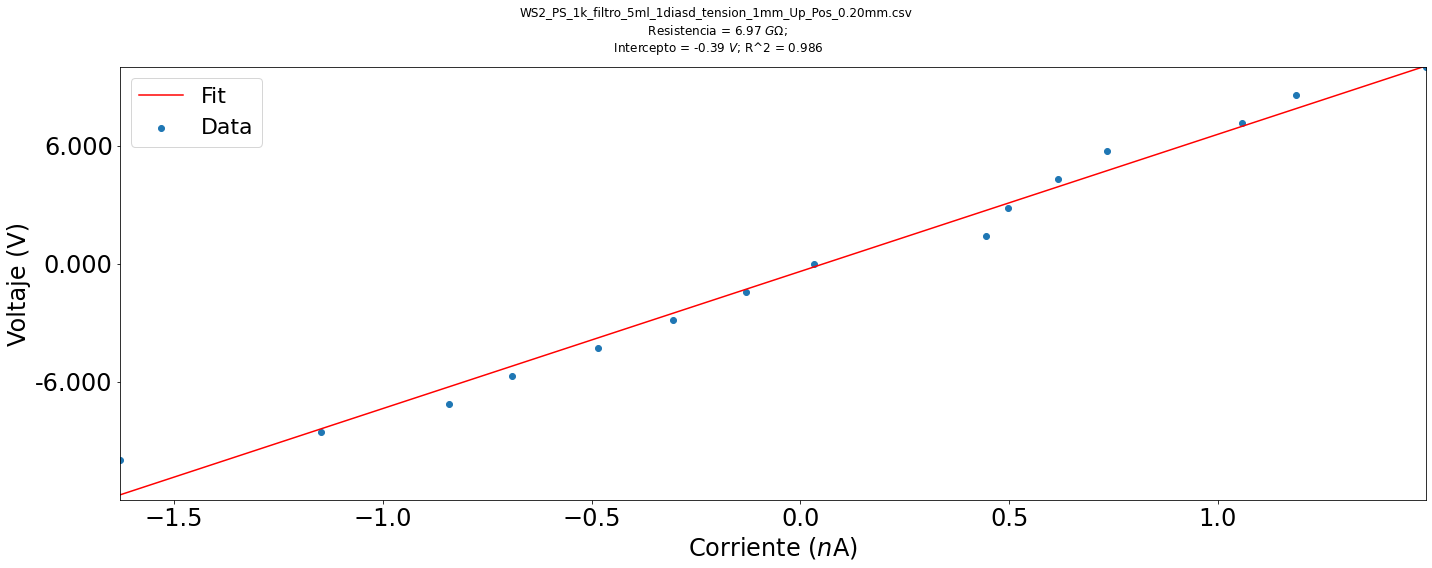

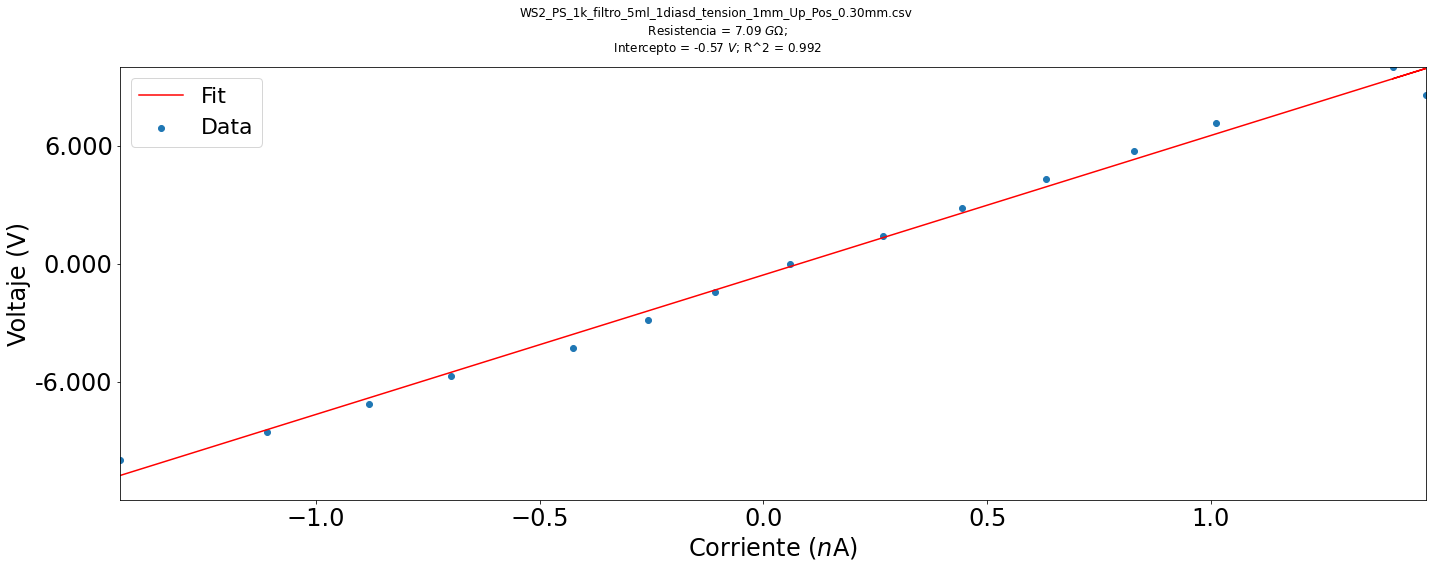

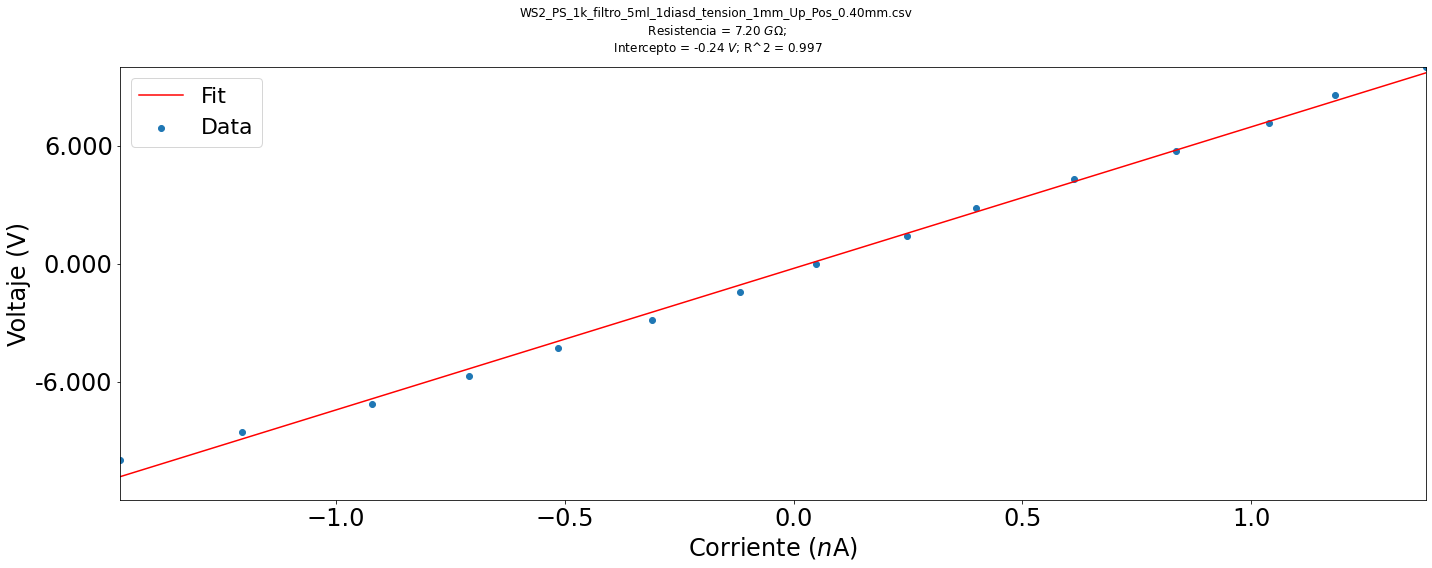

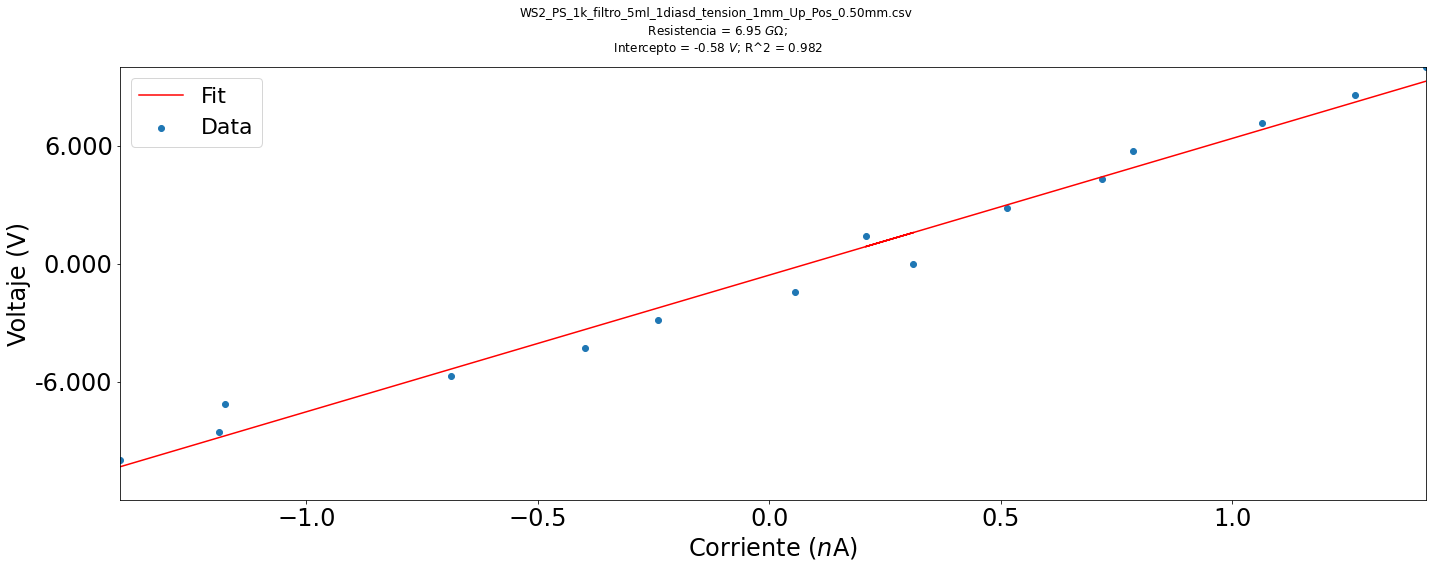

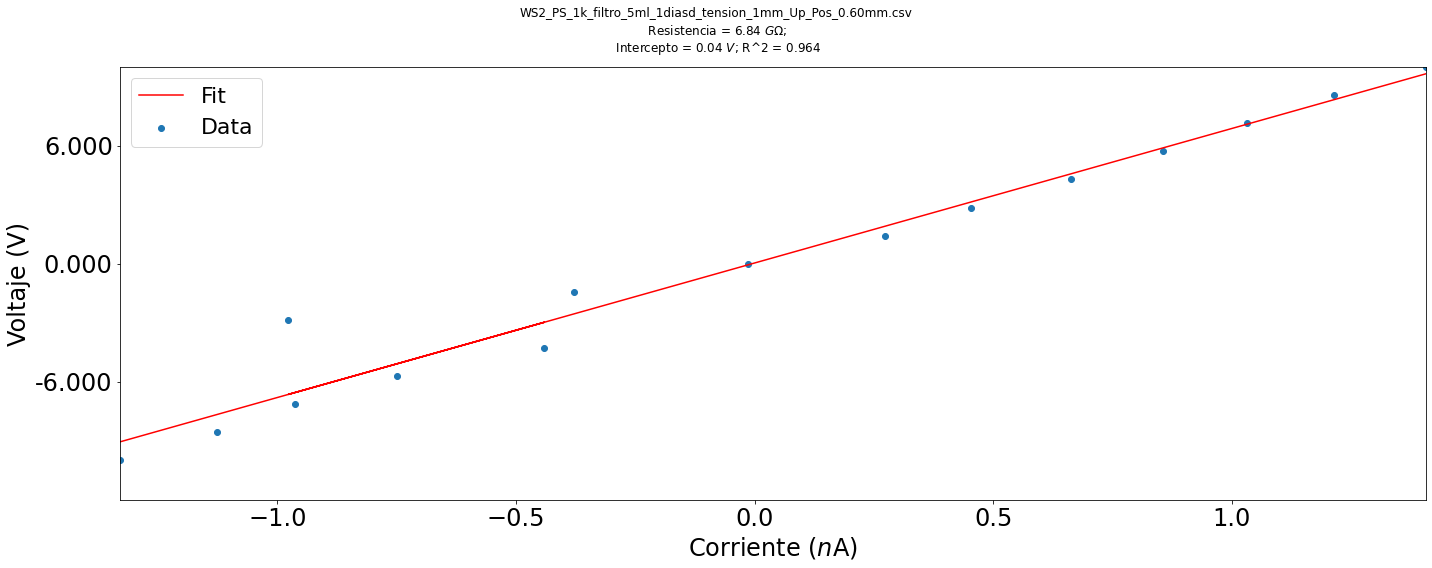

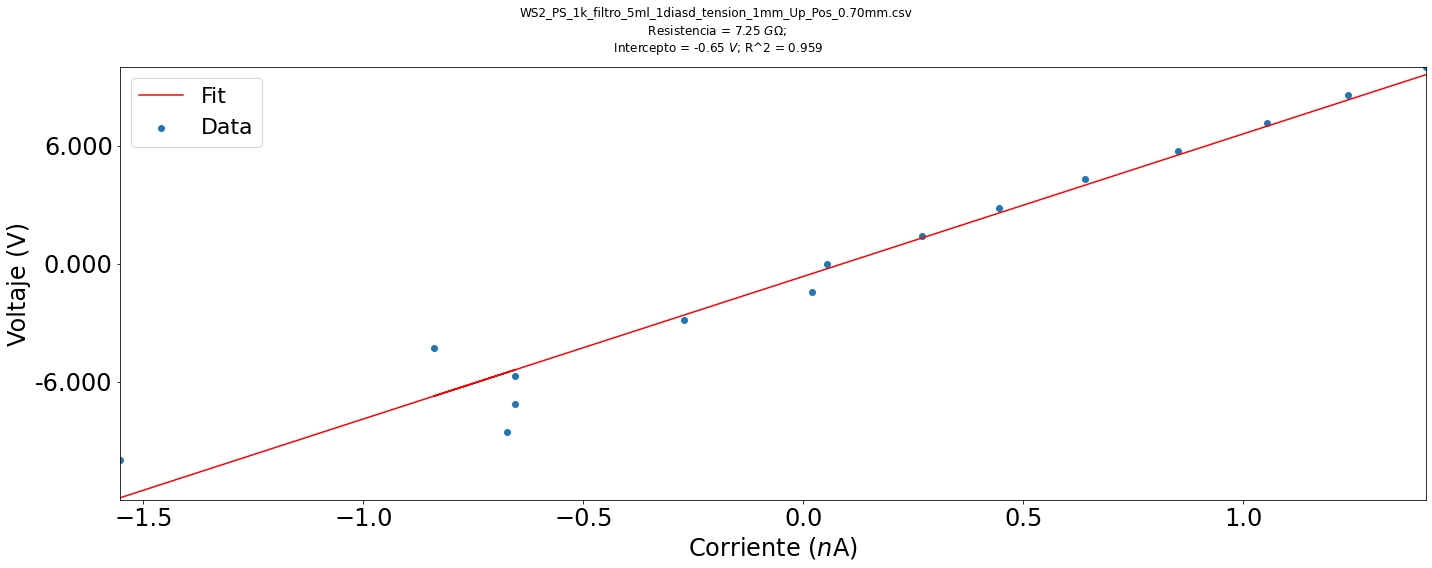

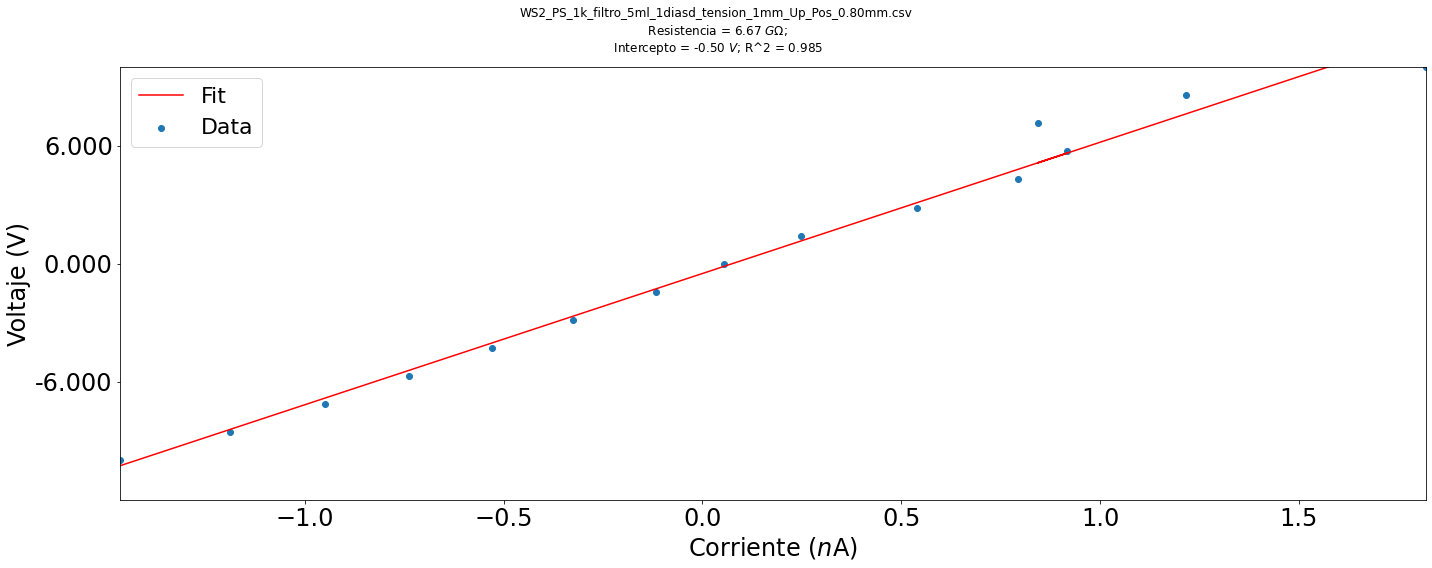

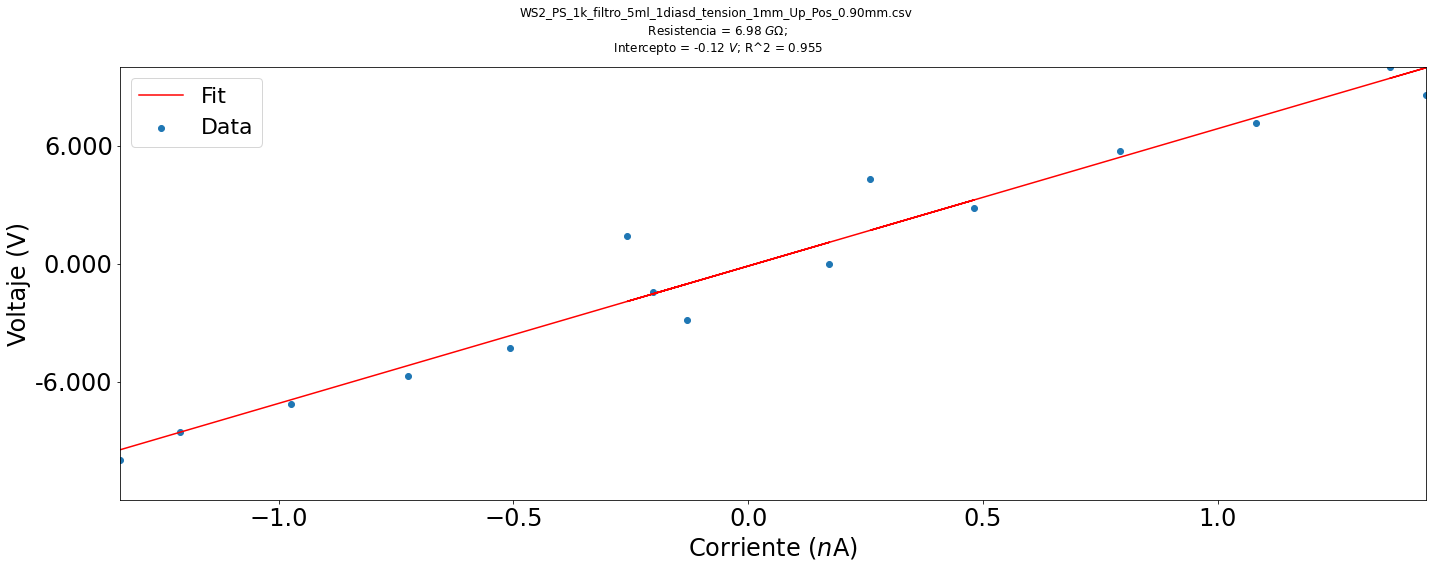

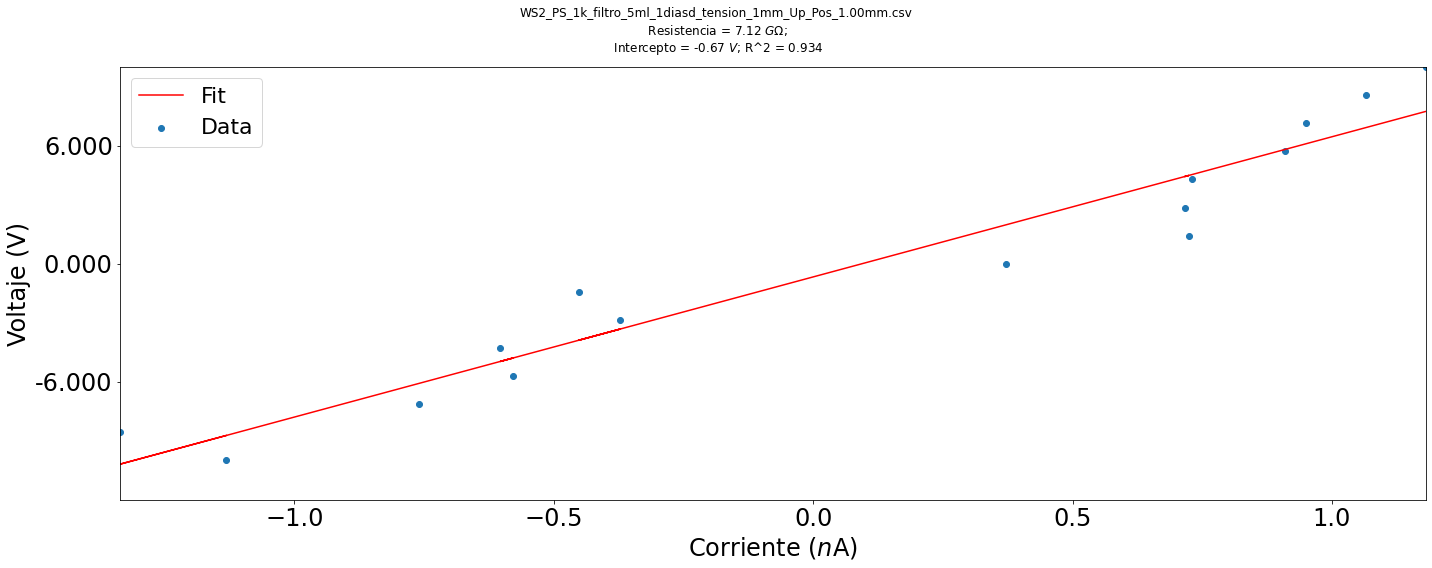

In [18]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_PS_1k_filtro_5ml_1diasd_tension_1mm_Up_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[7.073159191649557, 6.591382287875176, 7.5601175333698265, 7.106935038384349, 6.455267452689469, 6.9093762815368125, 6.580621393824509, 7.321415607259463, 6.946790252121744, 7.084332534045256, 6.042358580636063]


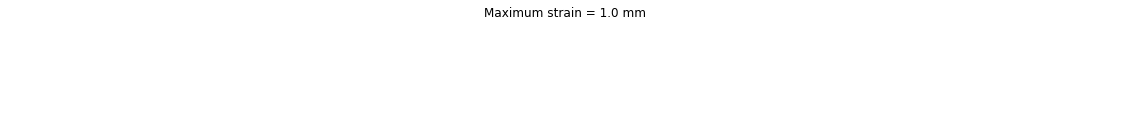

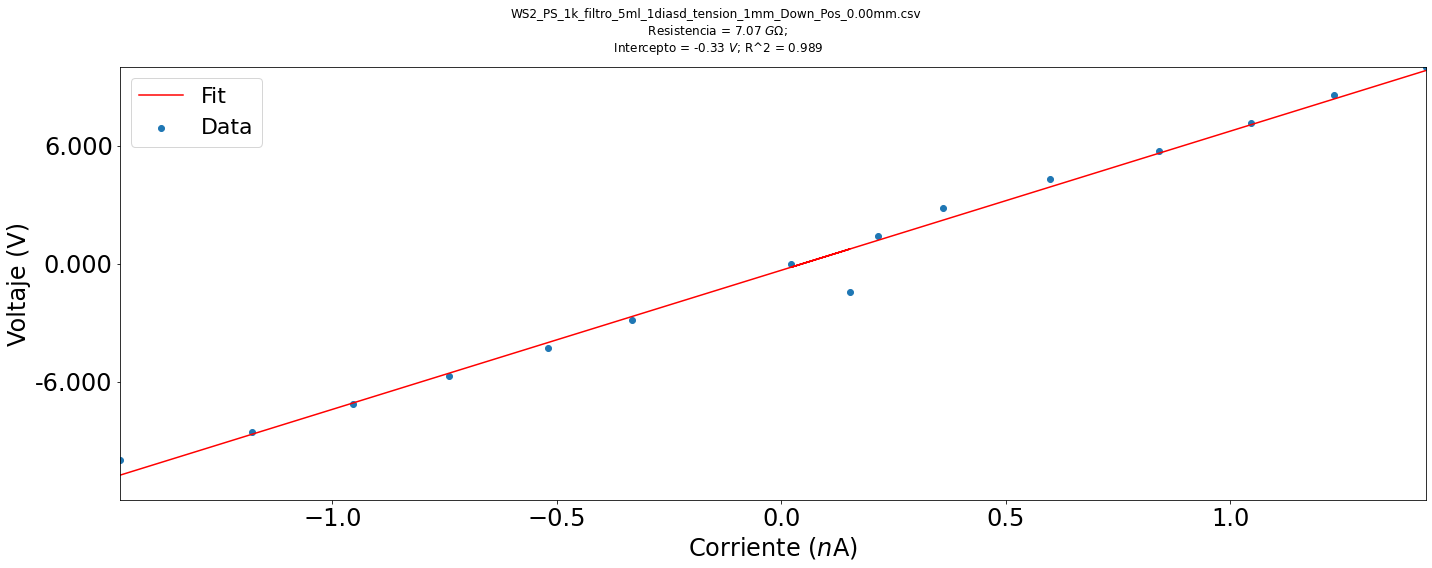

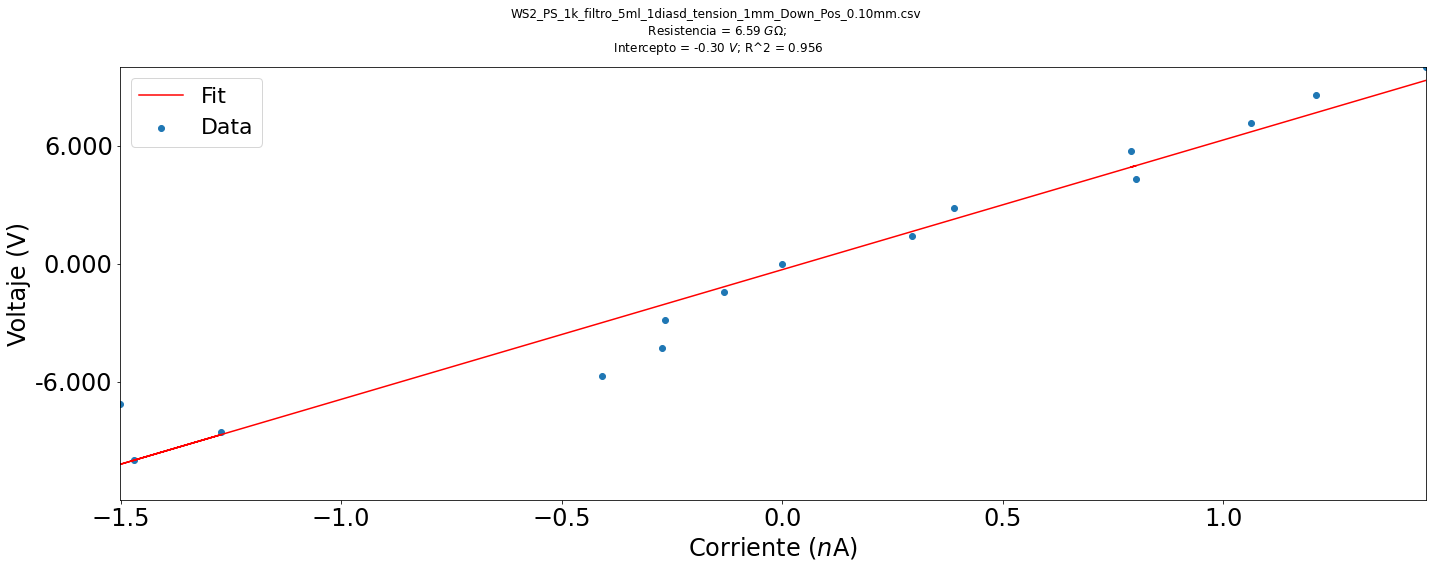

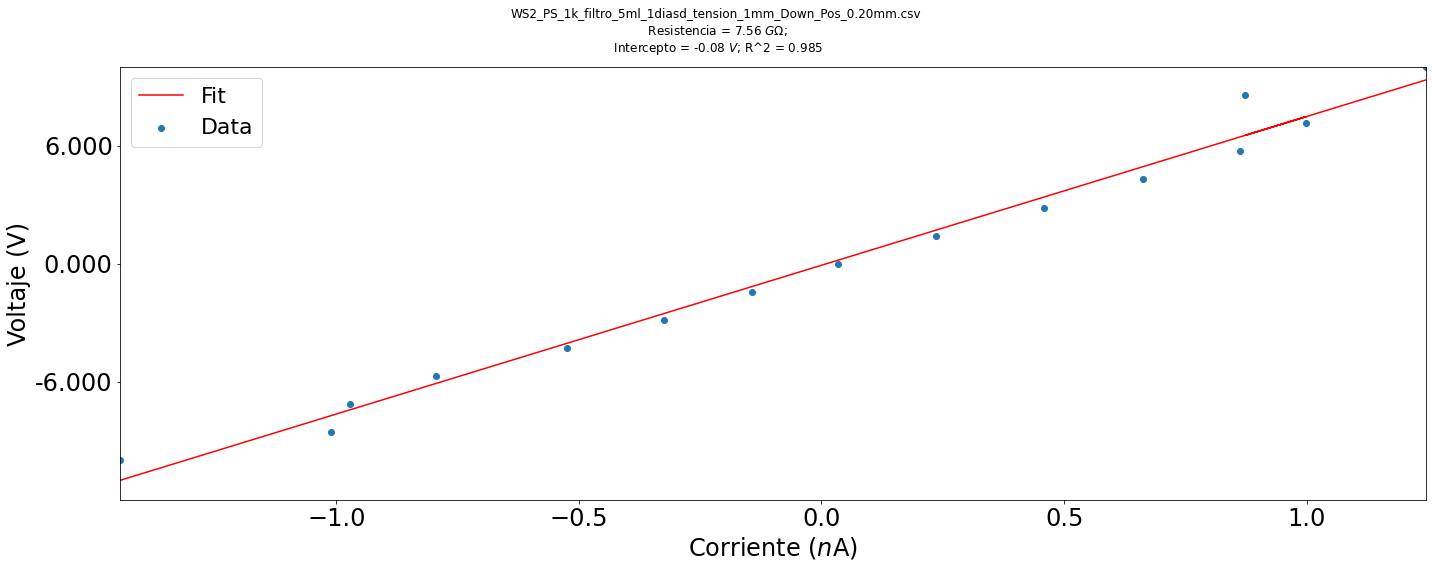

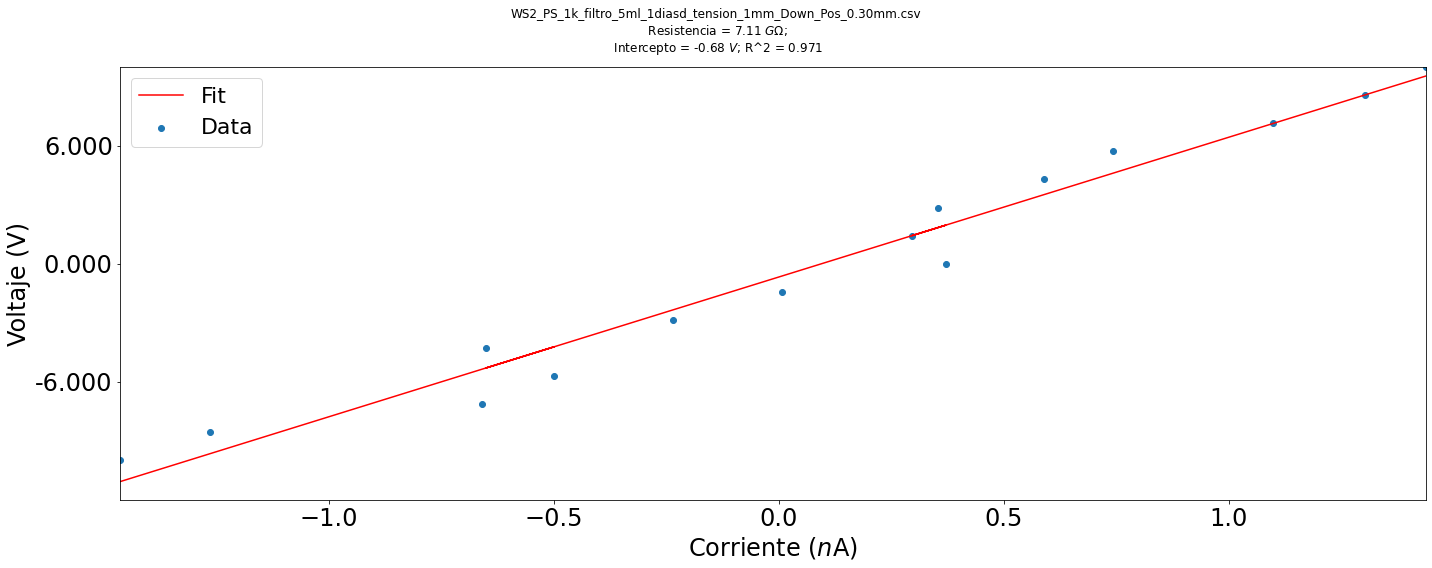

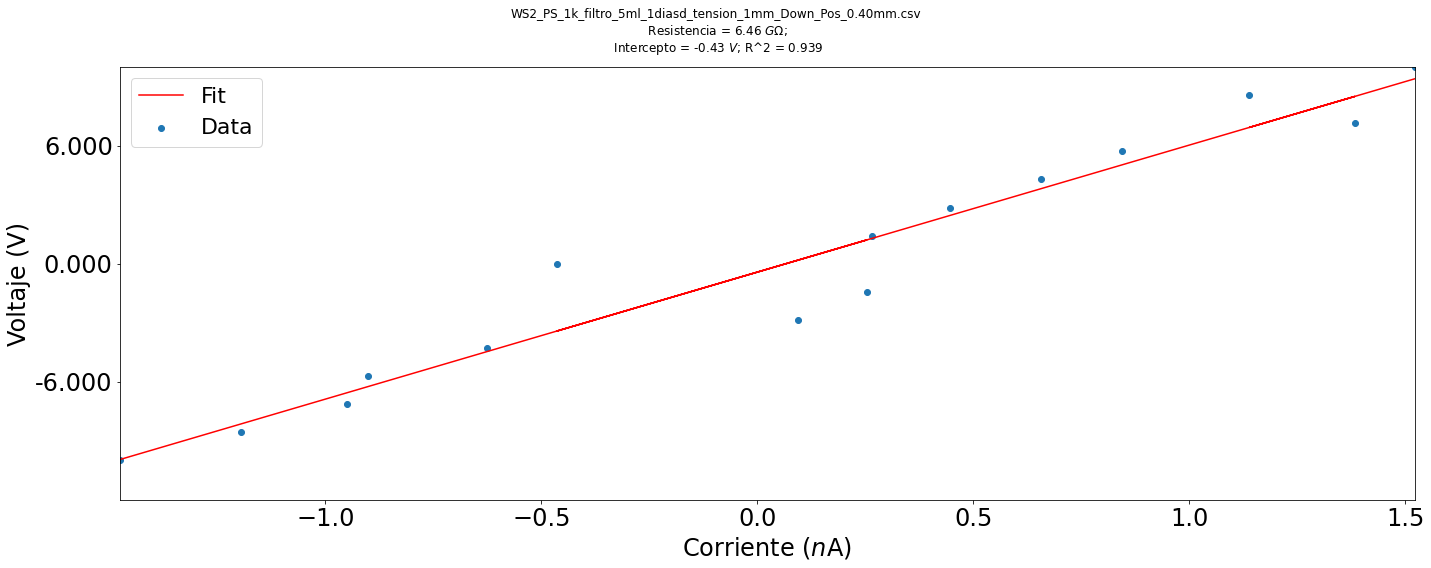

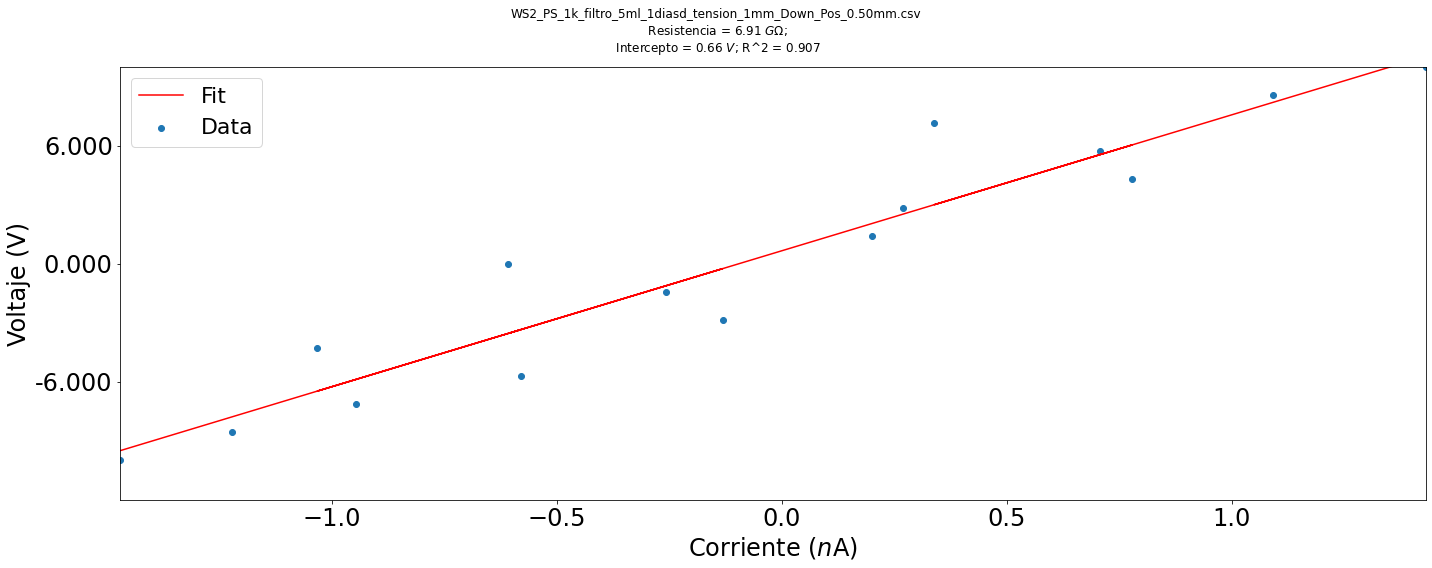

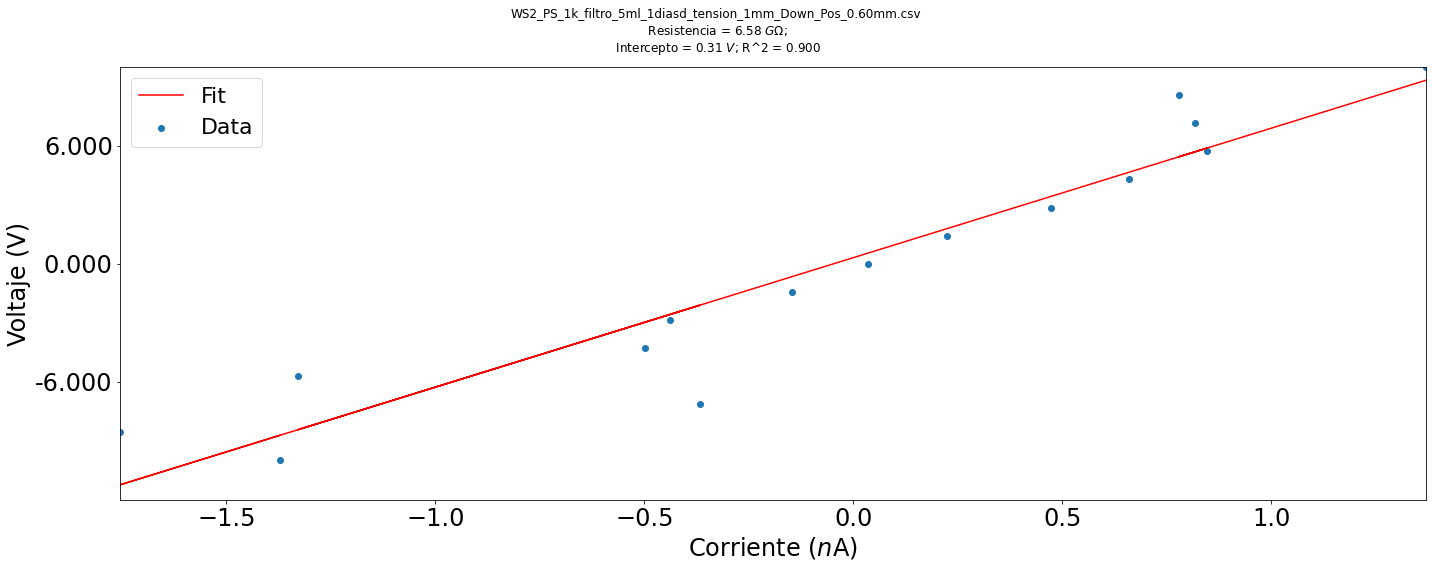

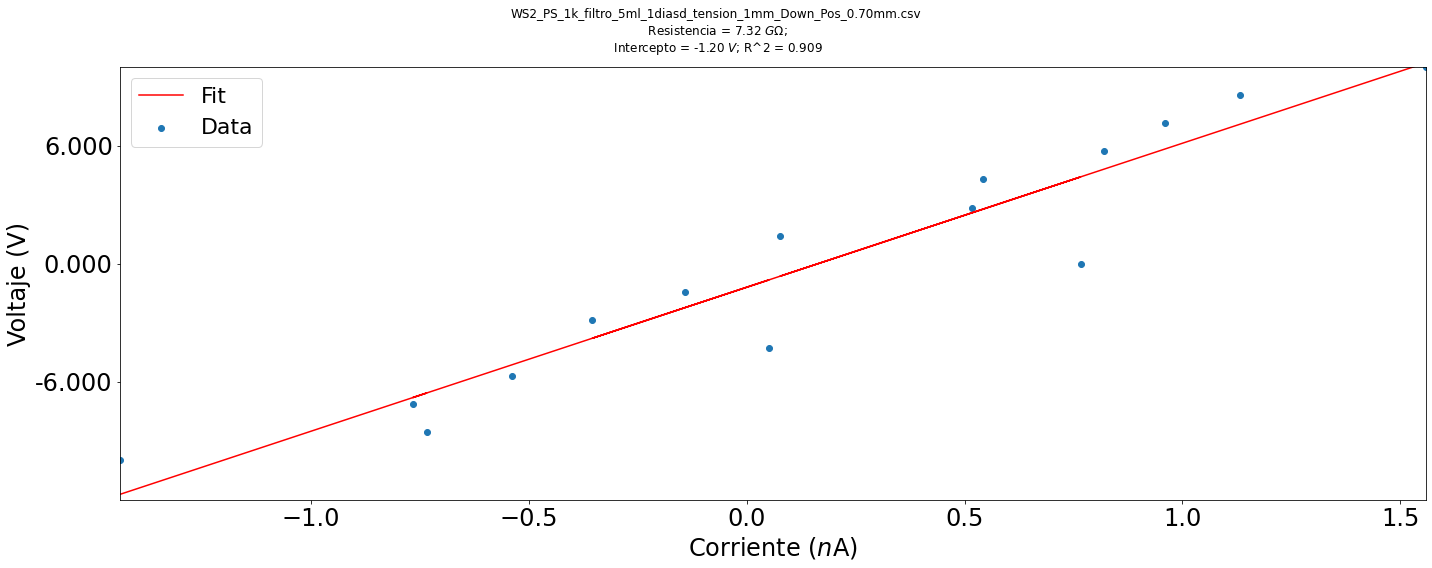

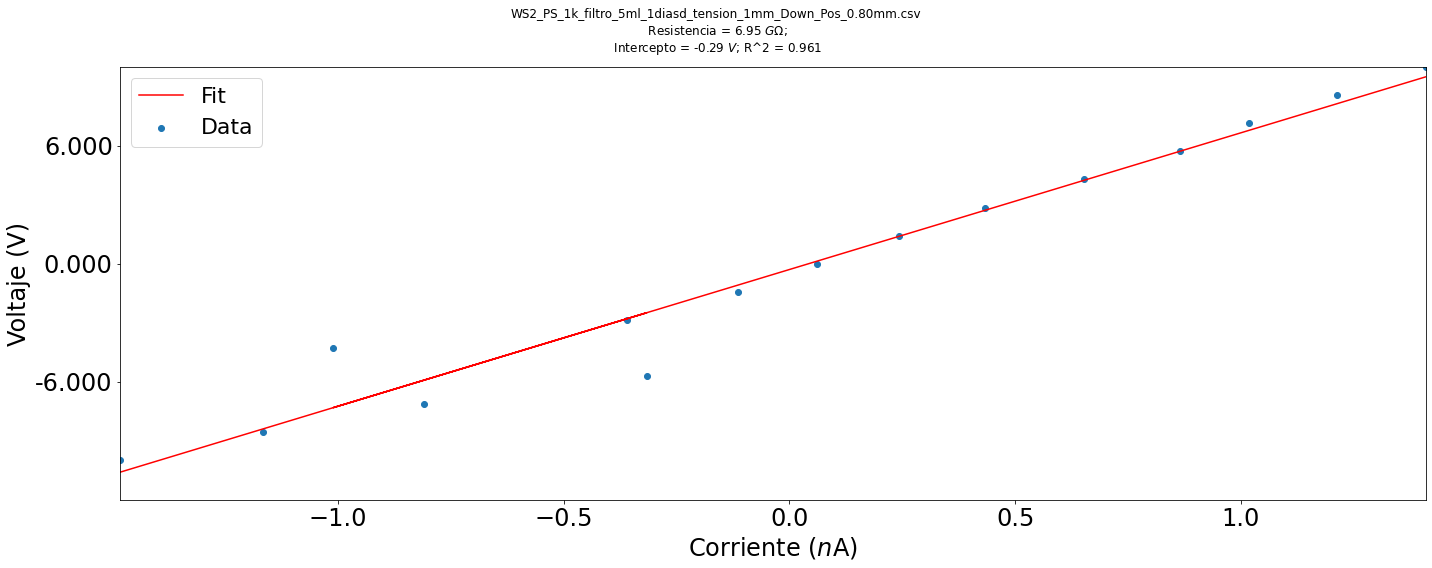

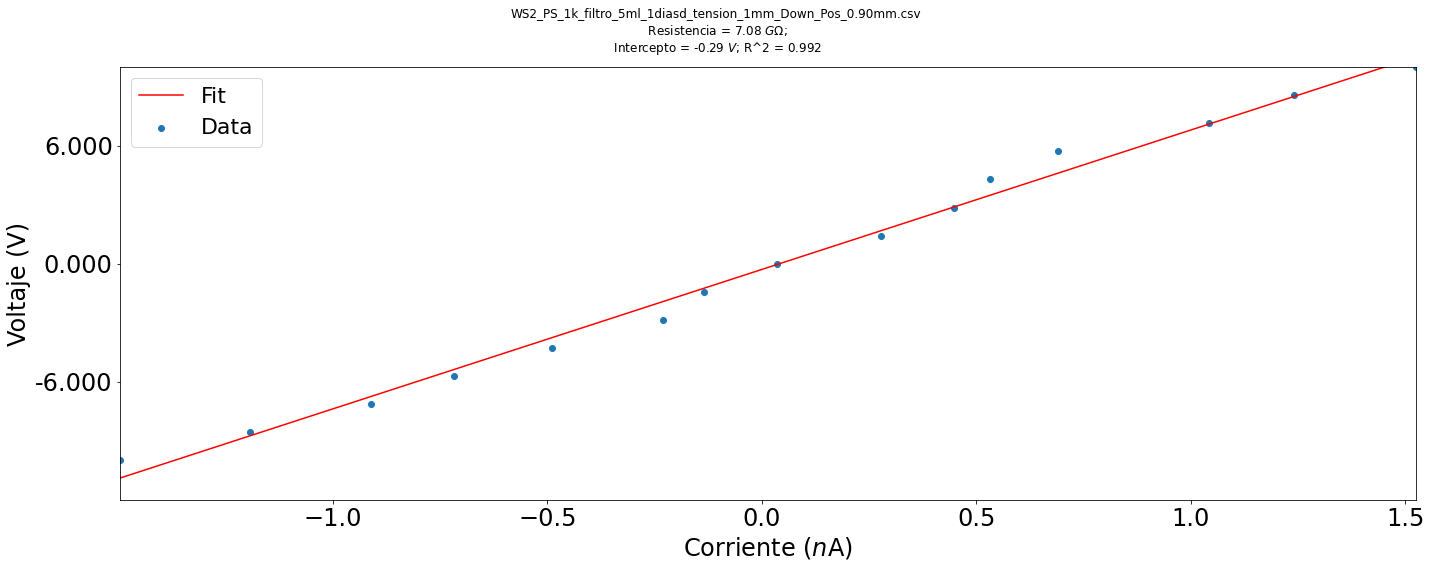

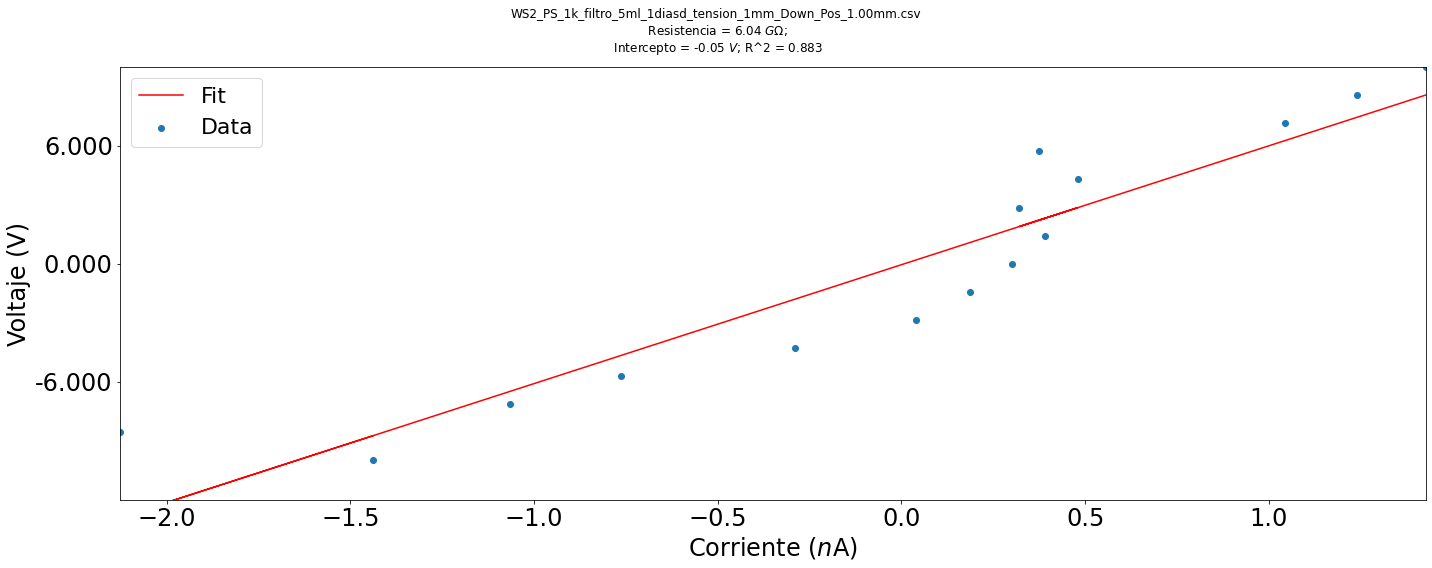

In [17]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_PS_1k_filtro_5ml_1diasd_tension_1mm_Down_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[93.58533498673637, 97.45754270540738, 97.92624582840511, 98.17756012811033, 96.89060661505745, 96.91917021476986, 96.77077600851706, 97.09595058372716, 98.0165750270992, 96.87890360710988, 102.29713366849808]


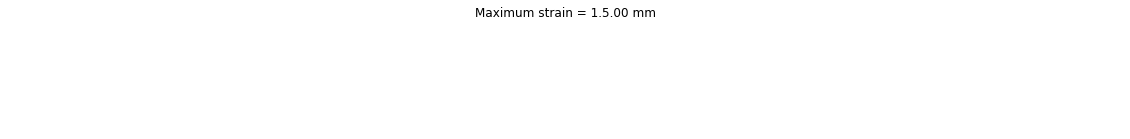

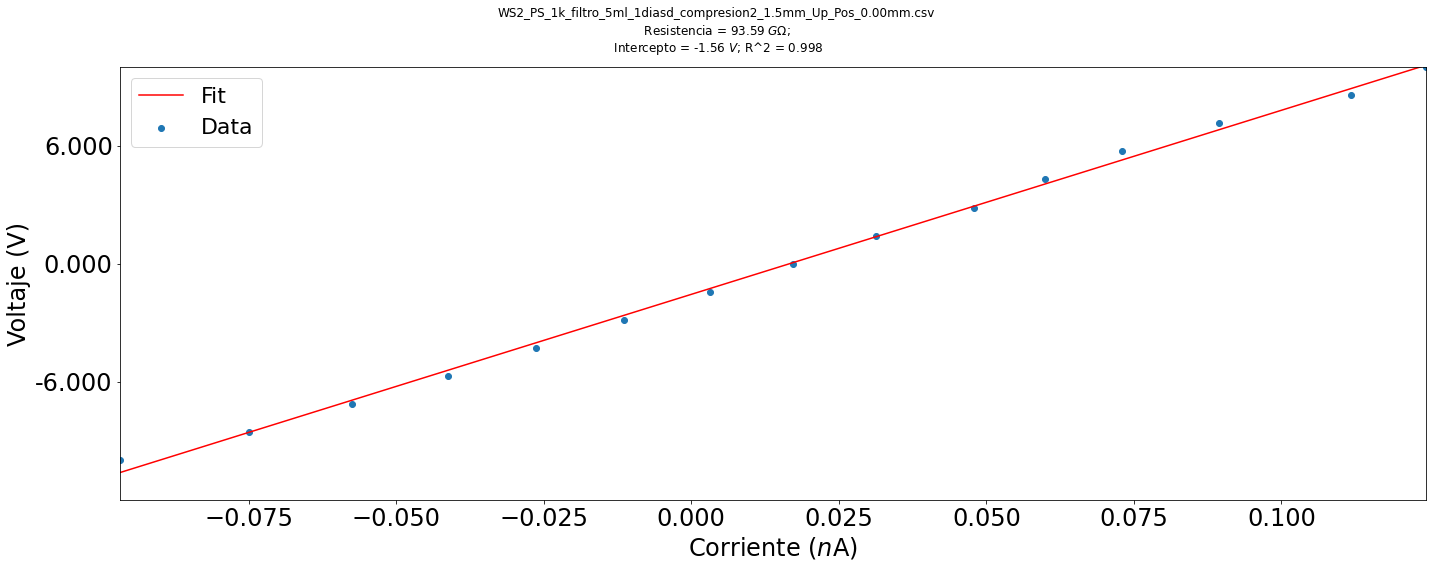

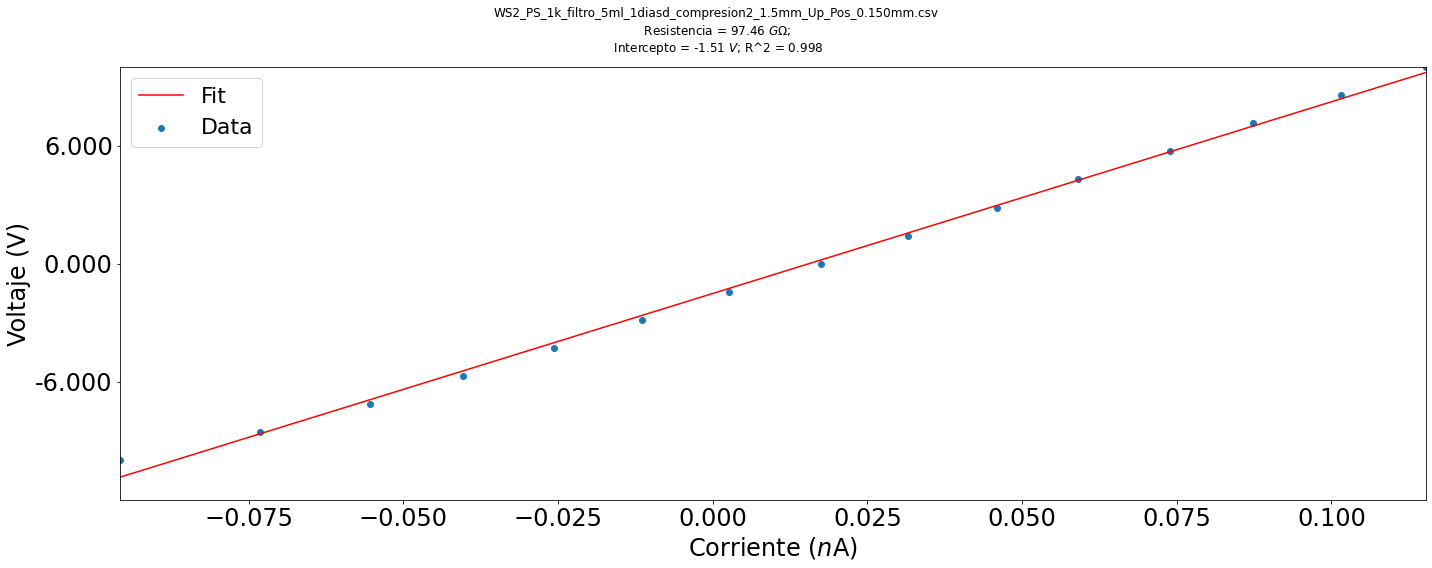

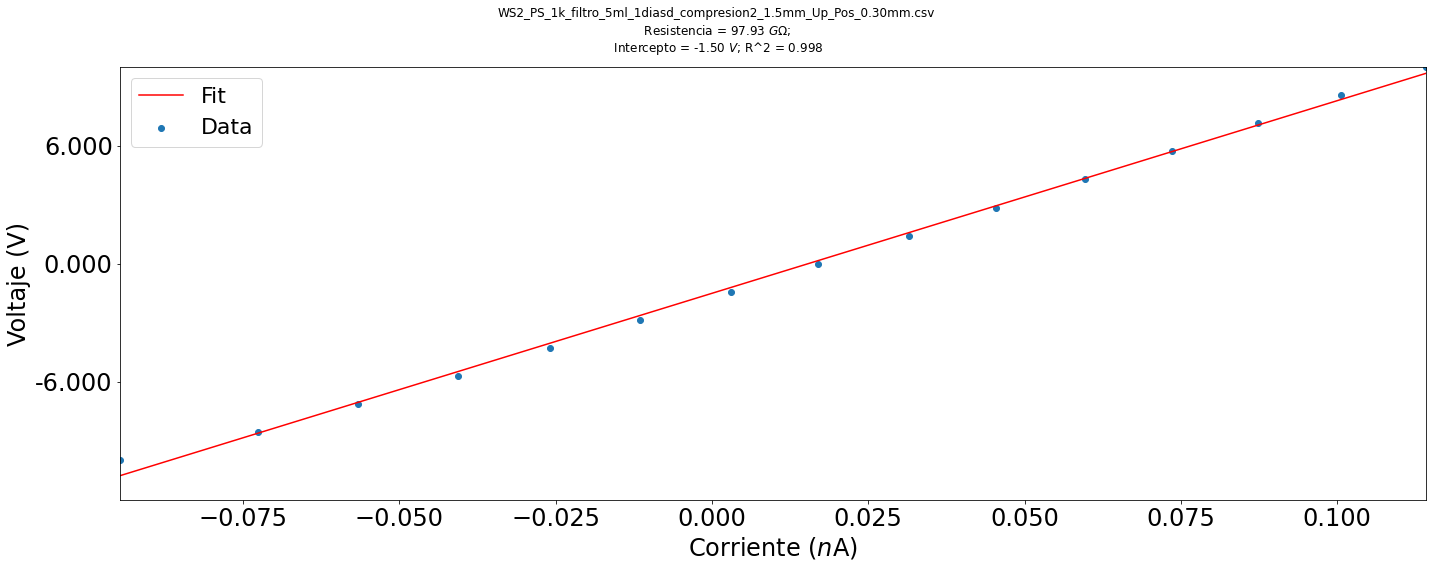

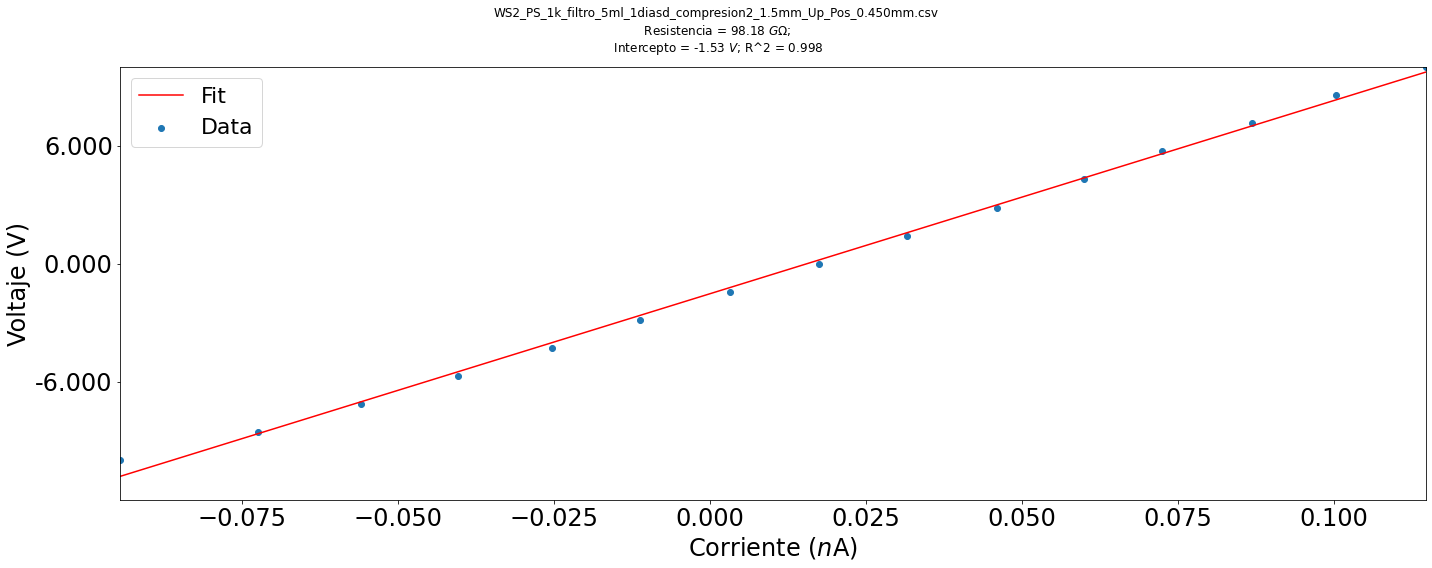

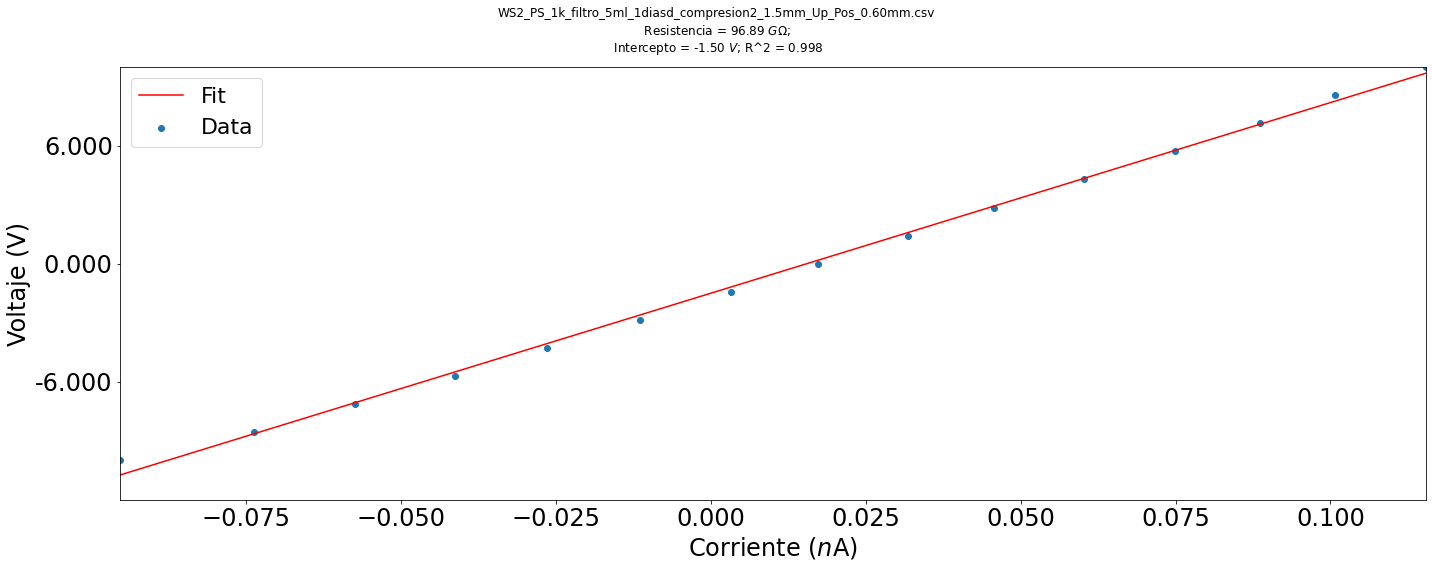

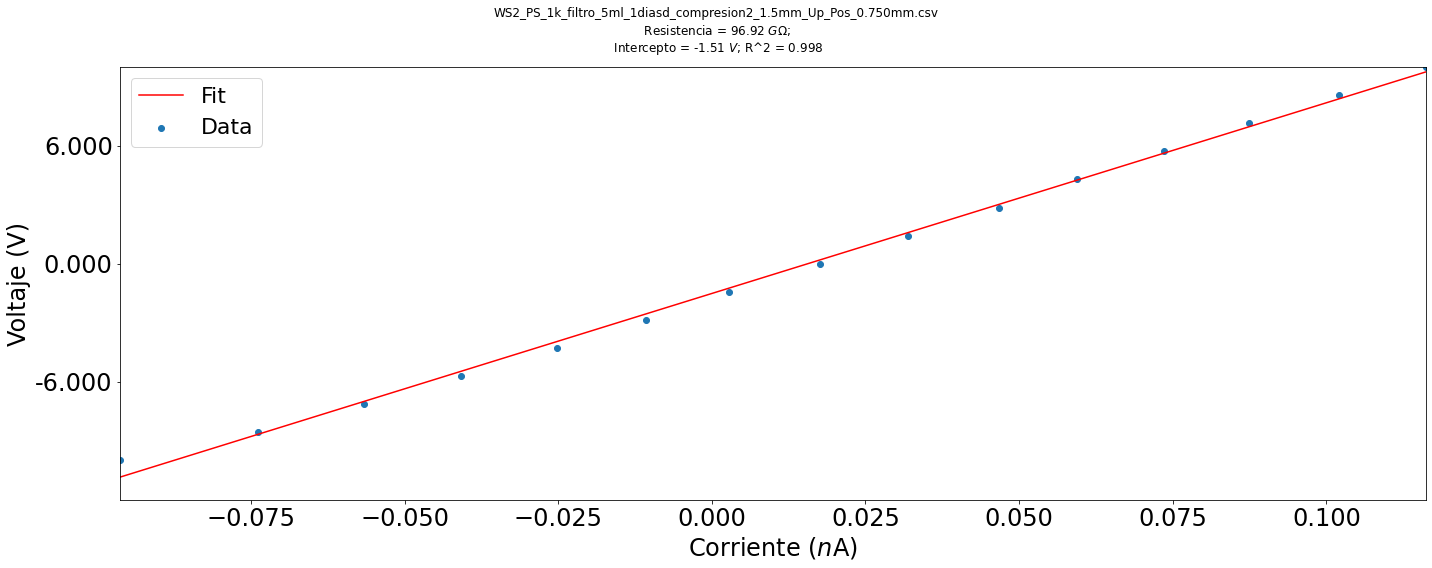

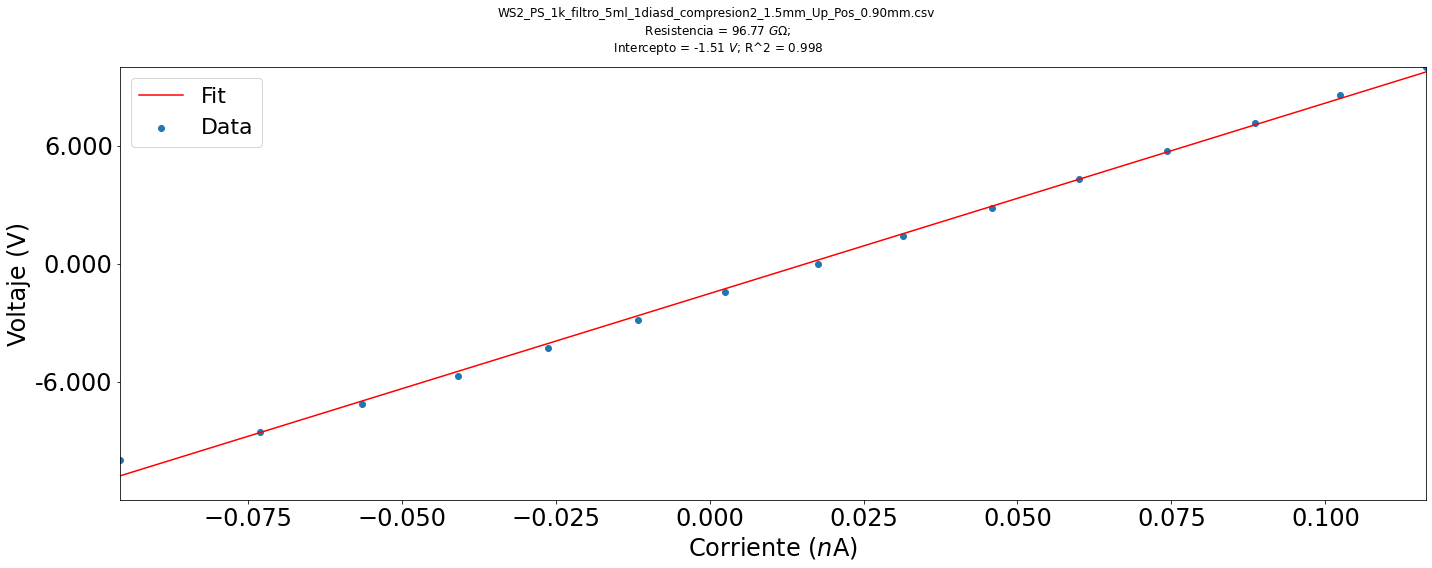

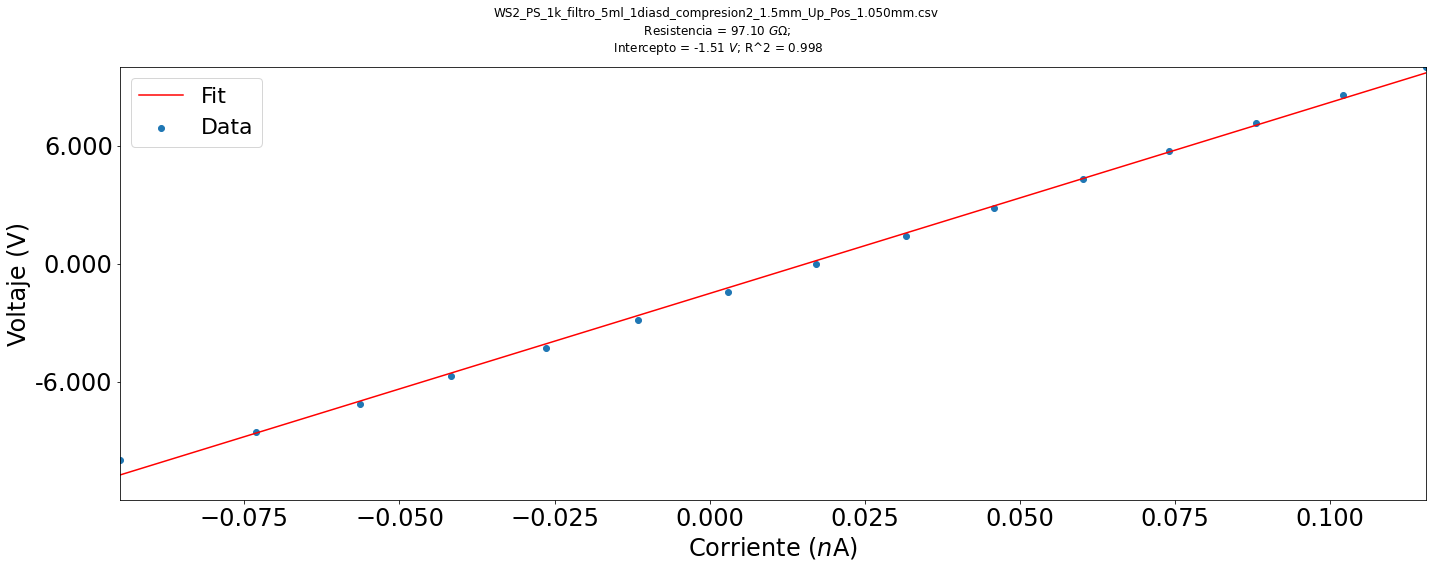

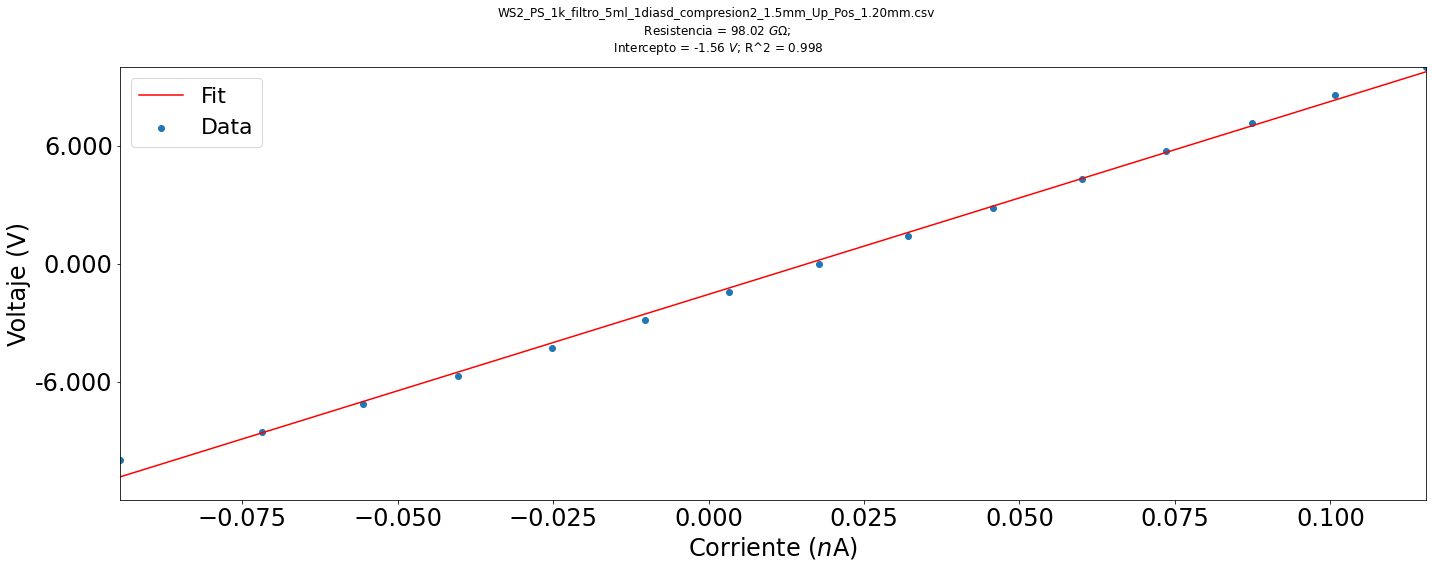

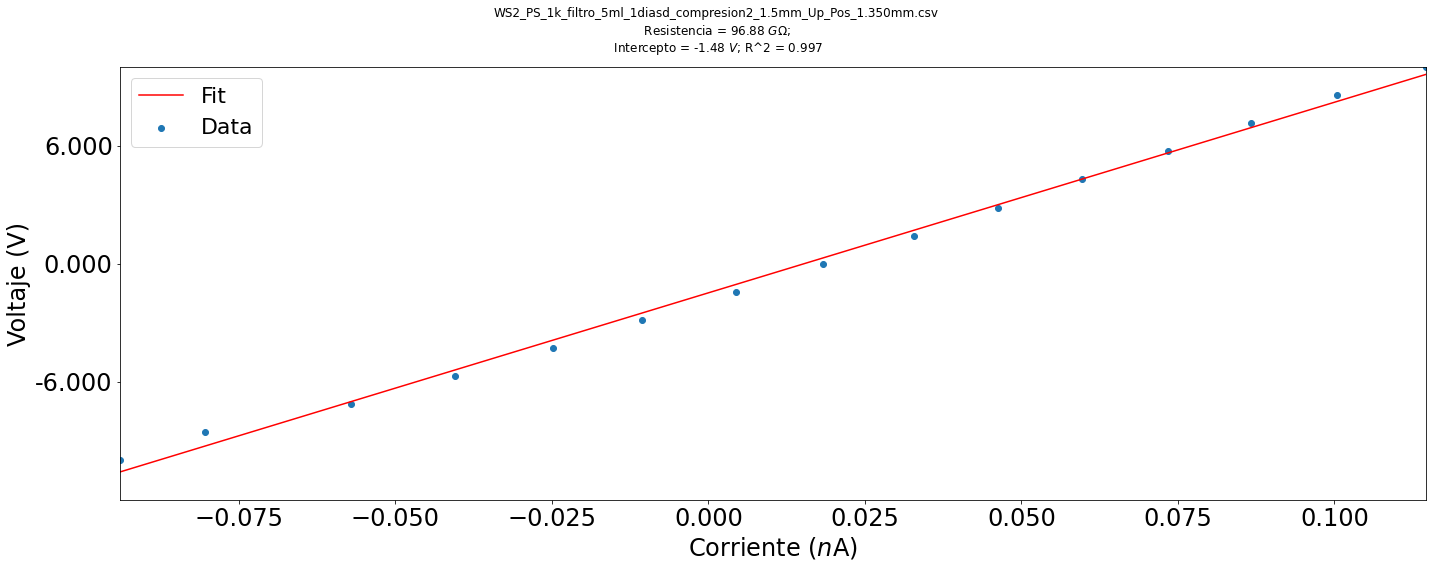

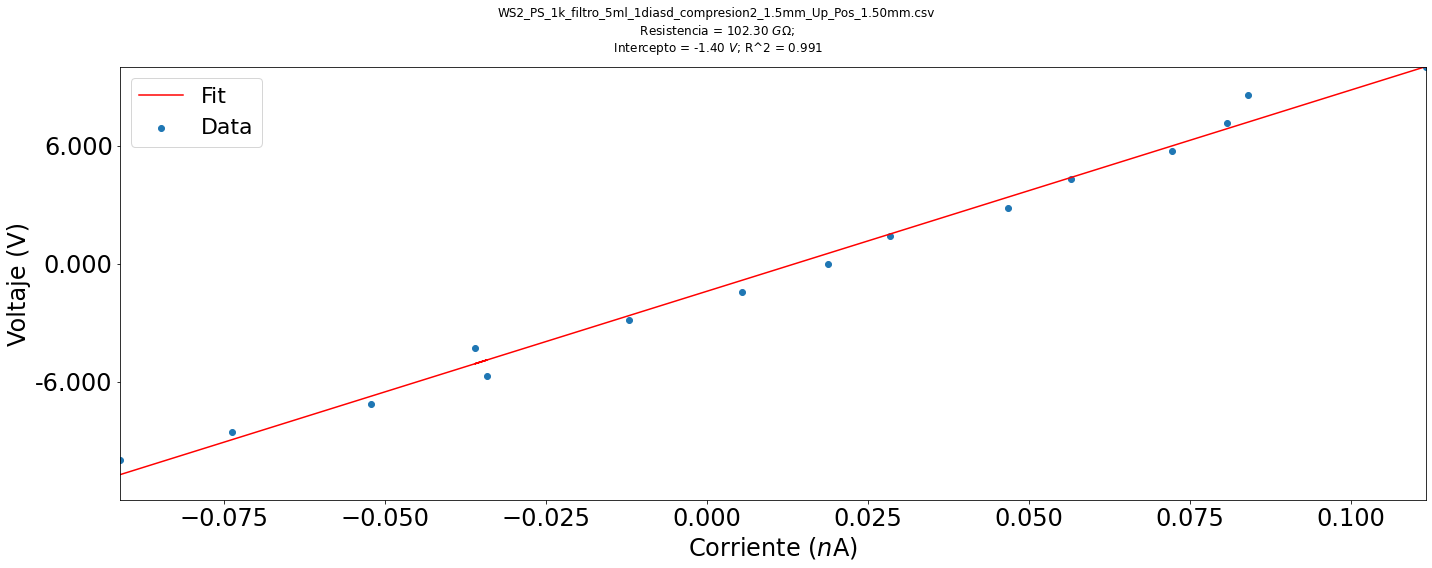

In [14]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_PS_1k_filtro_5ml_1diasd_compresion2_1.5mm_Up_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1.5
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}0 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

FileNotFoundError: [Errno 2] No such file or directory: 'WS2_PS_1k_filtro_5ml_1diasd_compresion2_1.5mm_Down_Pos_0.00mm.csv'

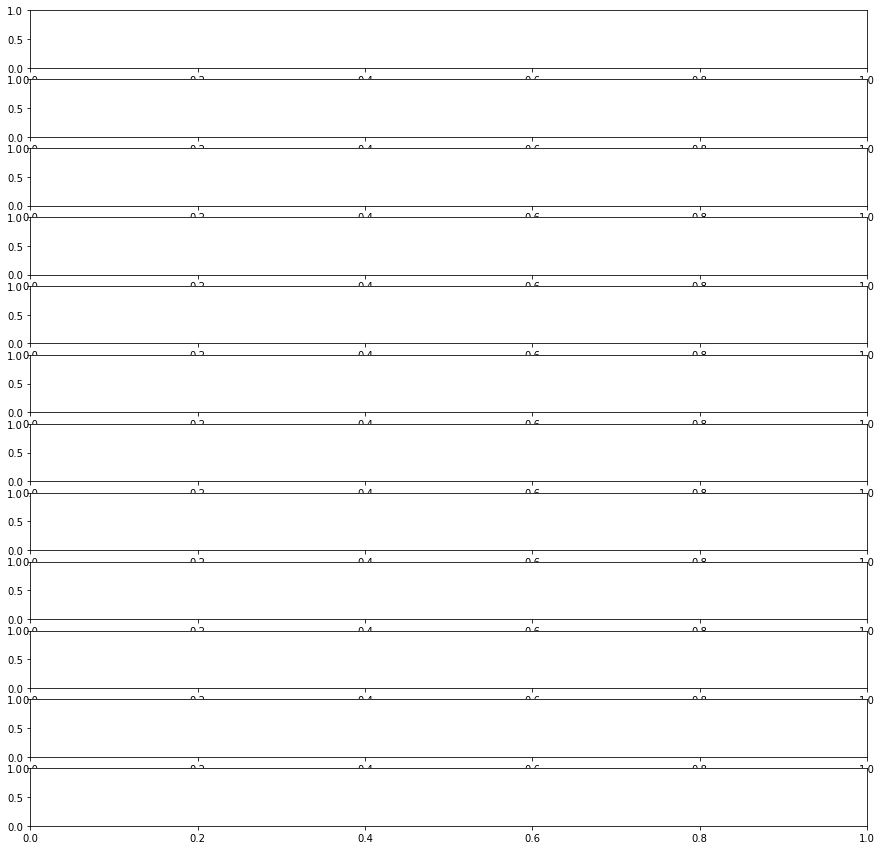

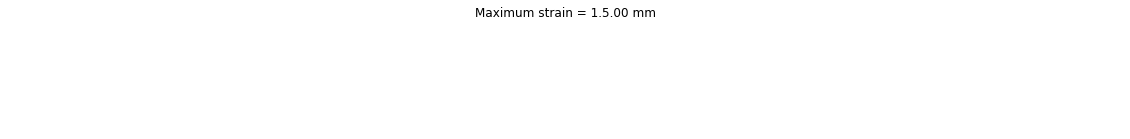

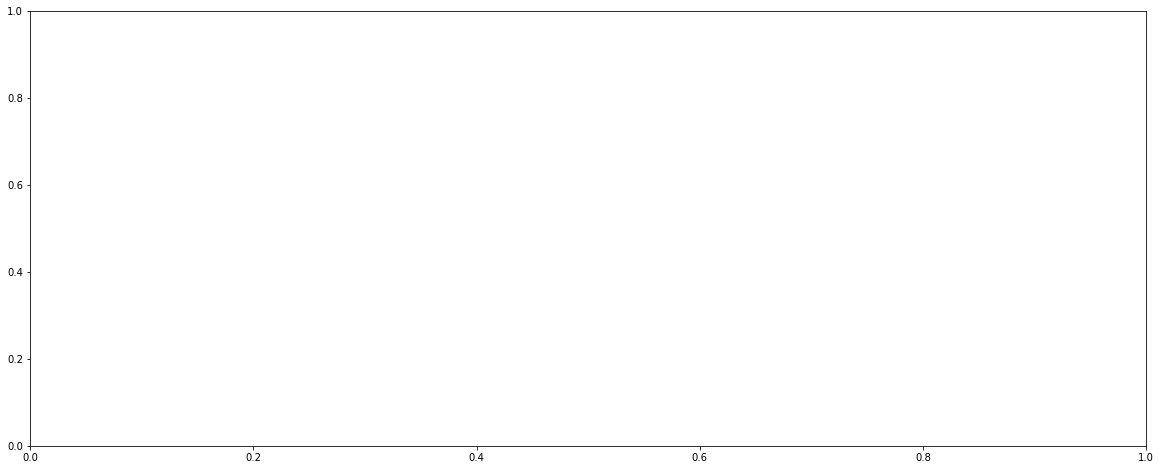

In [13]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_PS_1k_filtro_5ml_1diasd_compresion2_1.5mm_Down_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1.5
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.00 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)

[89.46533132588445, 95.85848626813072, 96.26980141819669, 95.72317555451632, 97.08532007144044, 97.26202290864882, 98.48120528520168, 96.42898794620758, 98.19882076929947, 97.33802415976349, 97.68987748337229]


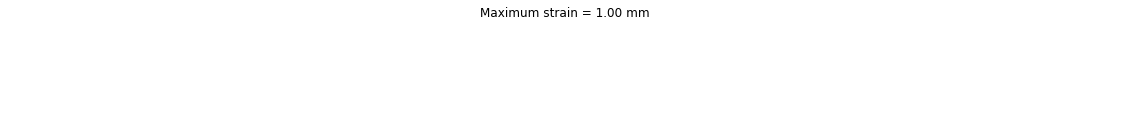

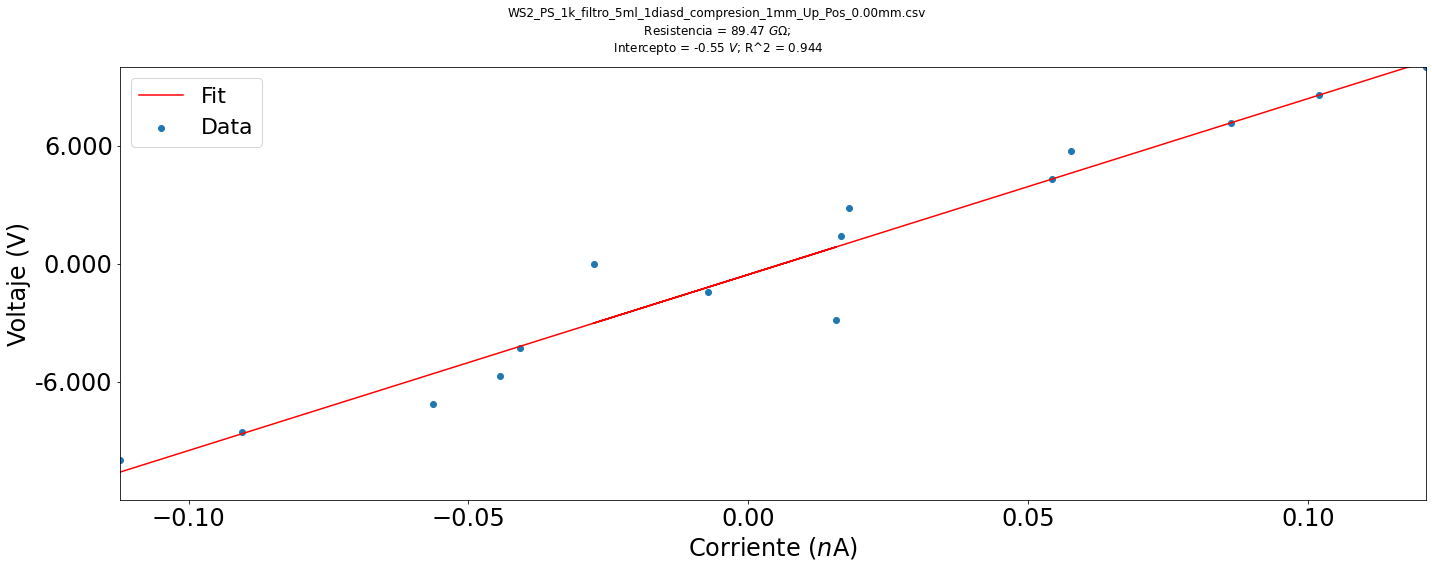

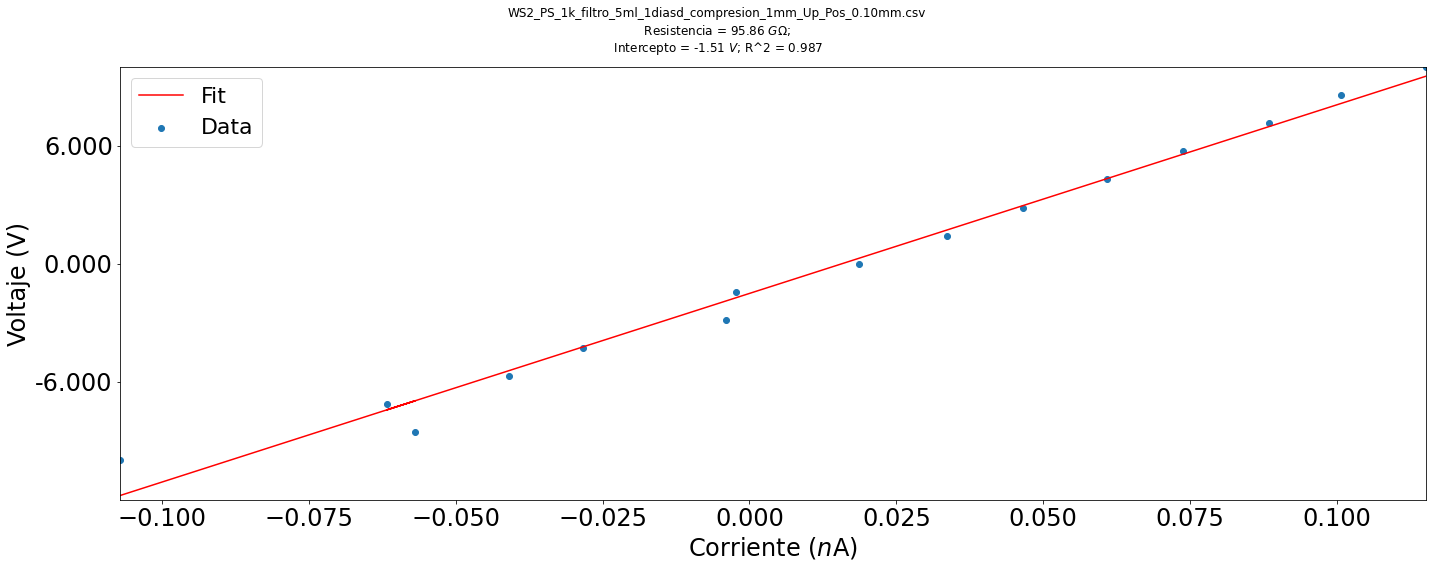

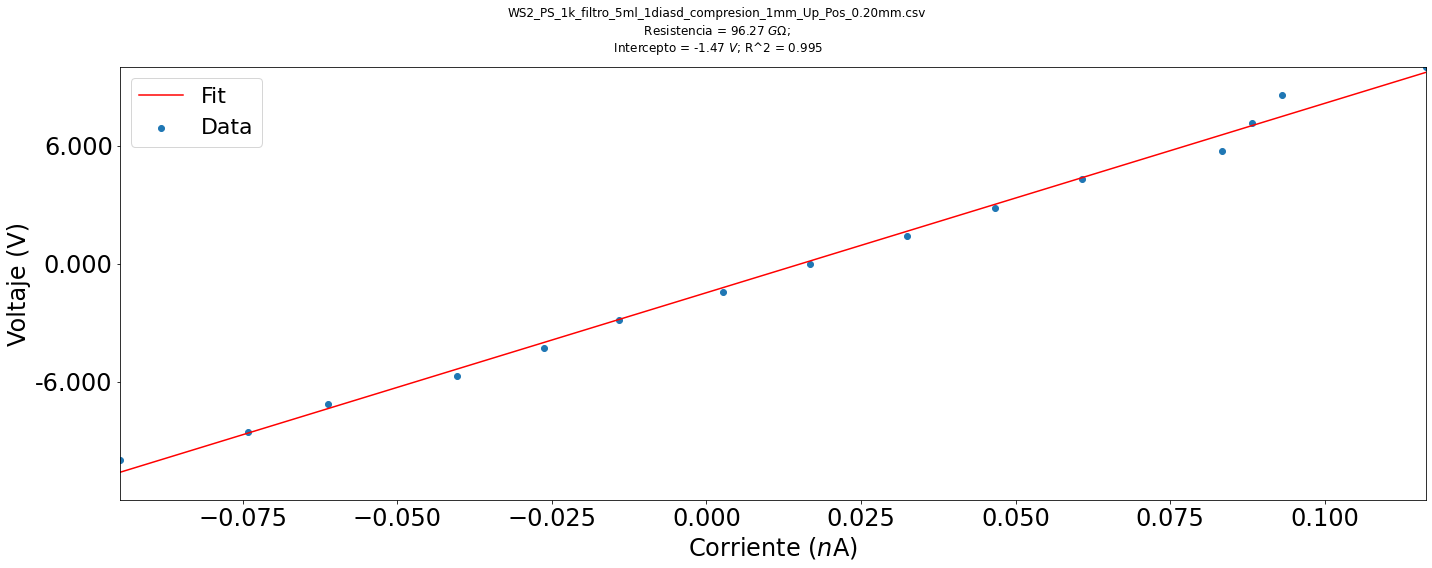

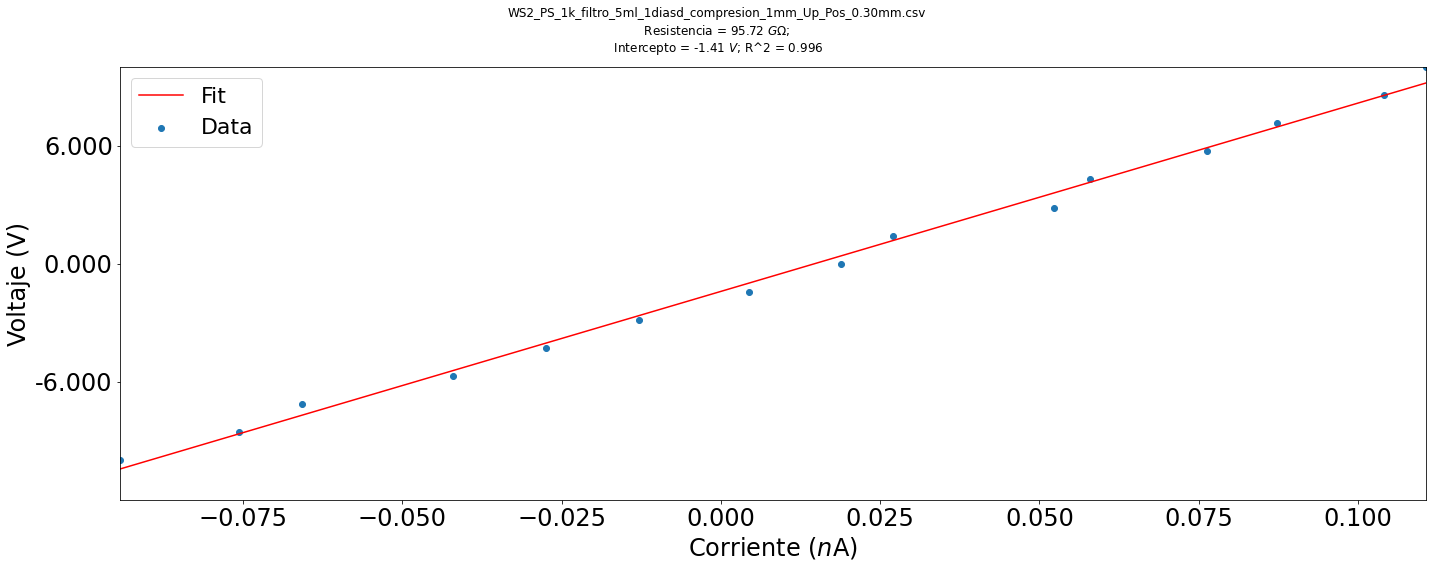

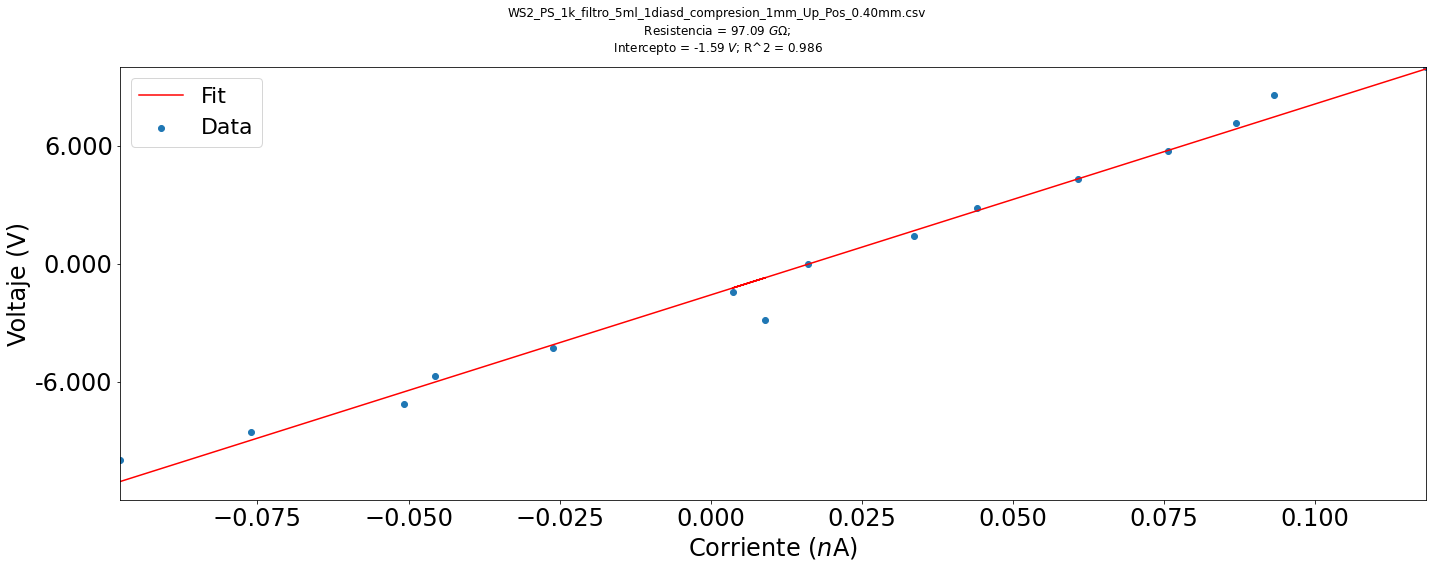

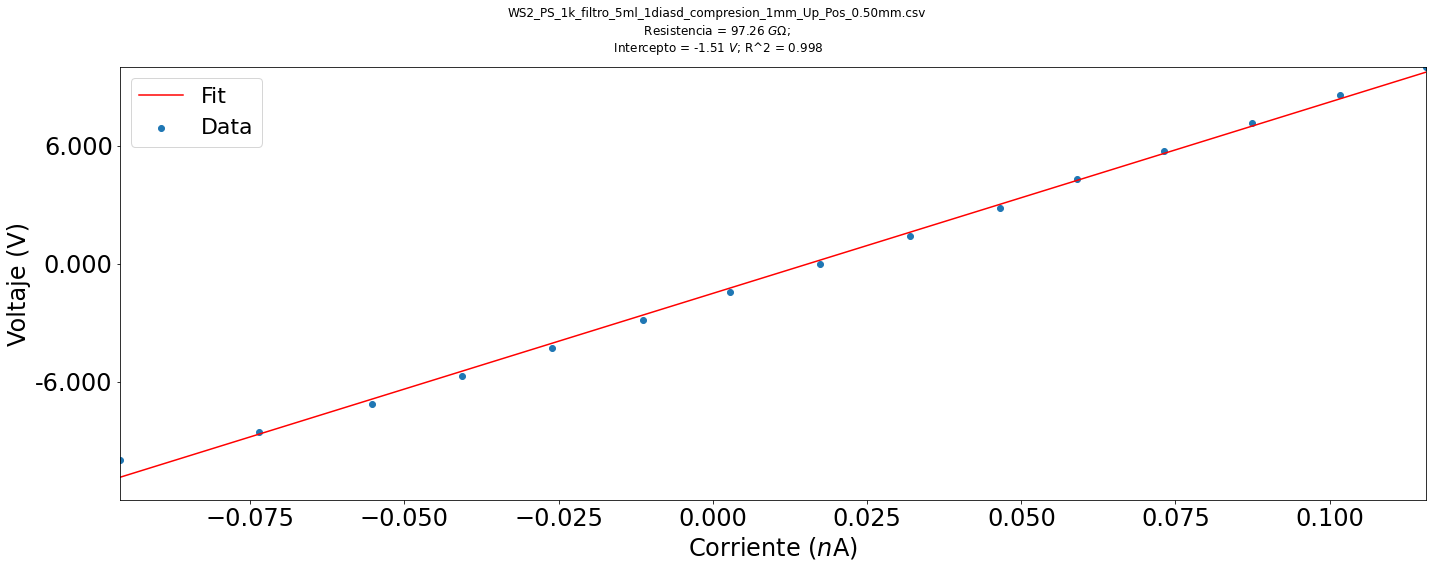

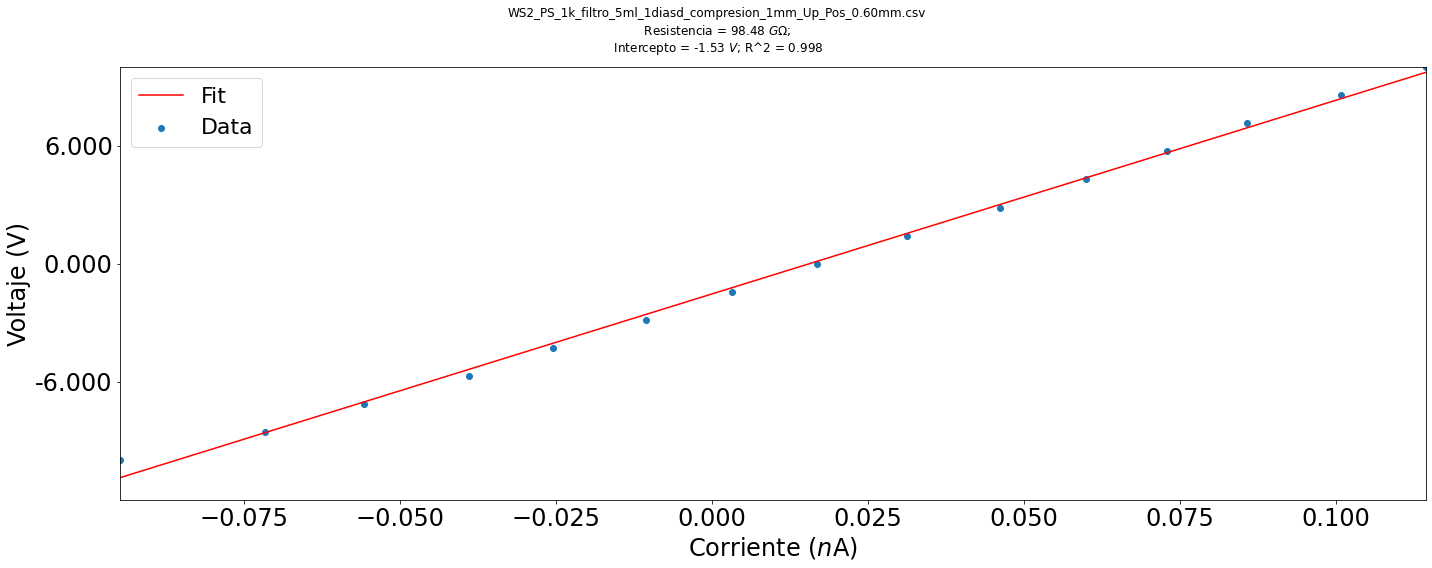

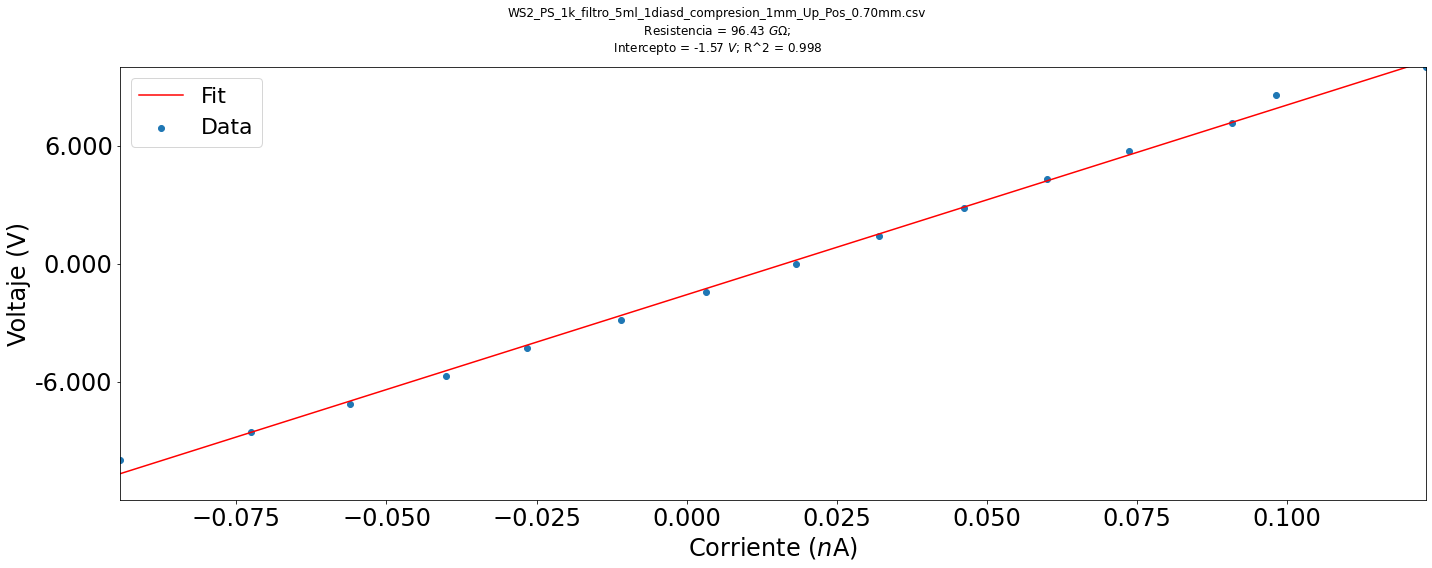

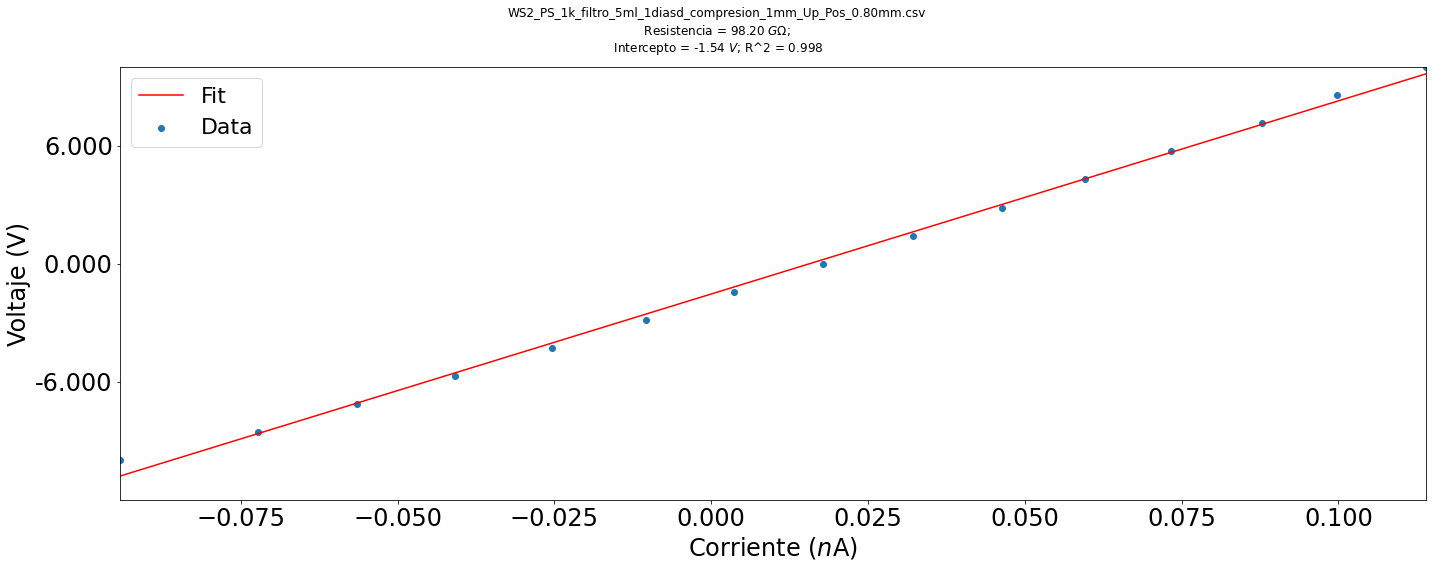

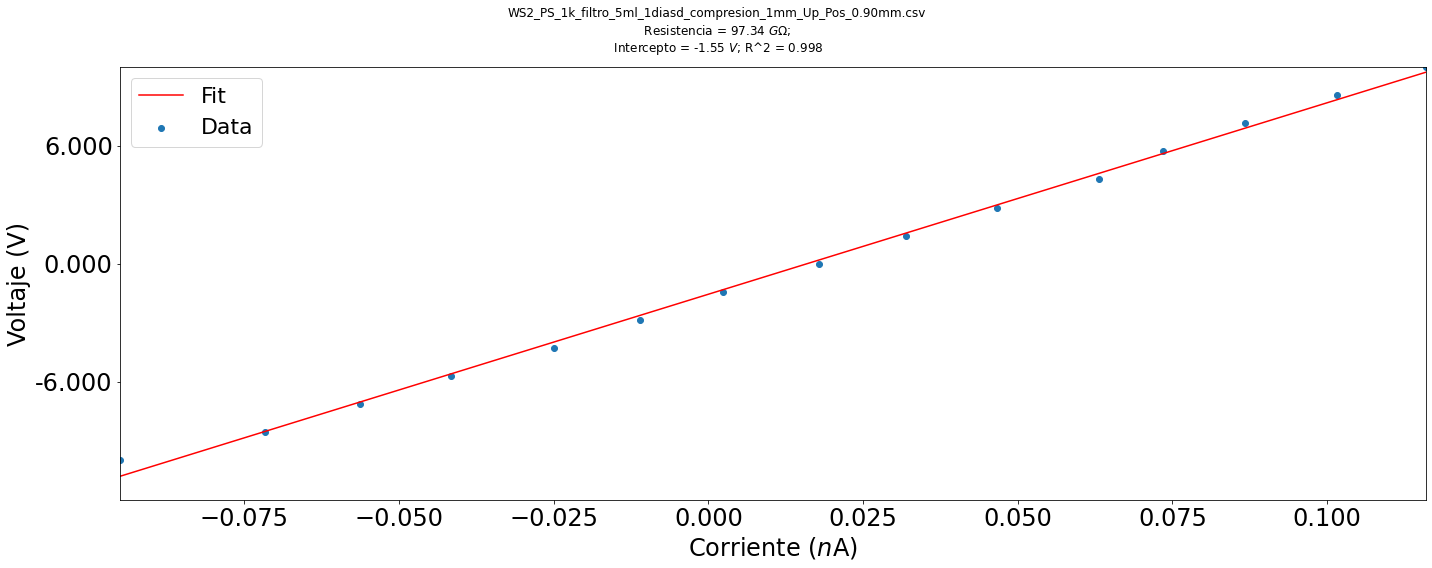

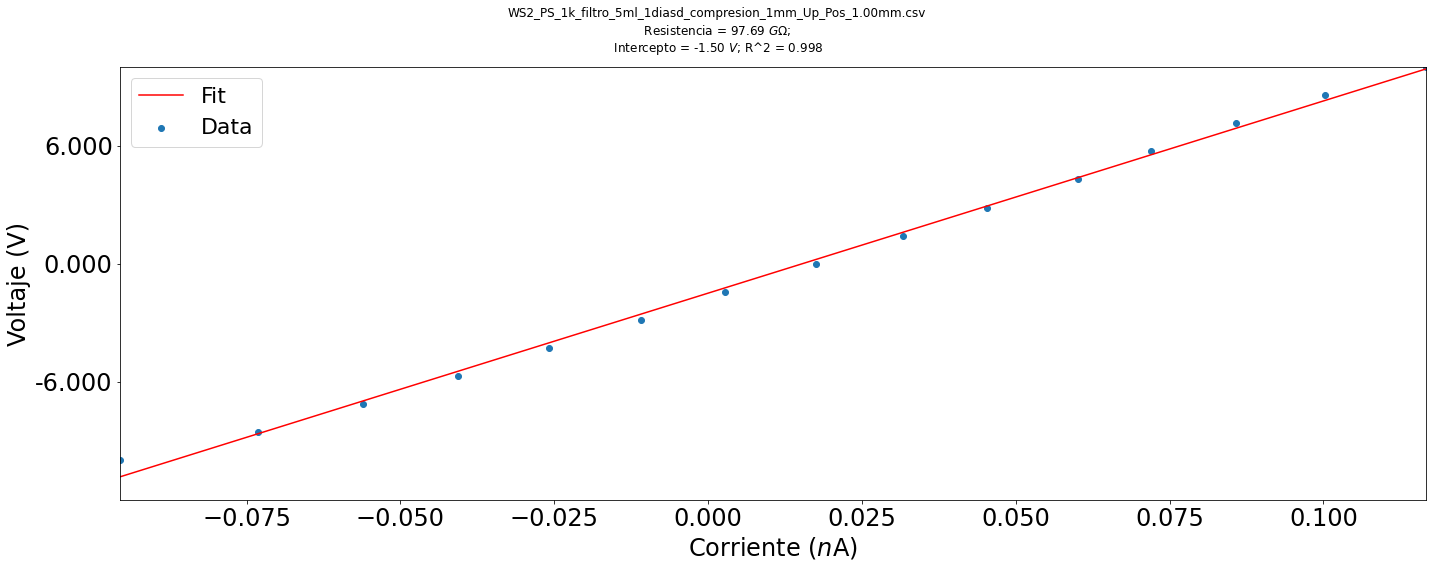

In [165]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_PS_1k_filtro_5ml_1diasd_compresion_1mm_Up_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.00 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)


[95.25066159086721, 97.0231010313444, 76.75734271459378, 90.32380530282391, 94.02019329603253, 94.63075626119533, 80.81746444616165, 101.40213637869886, 96.71509709910022, 96.59788000402843, 96.97676484314213]


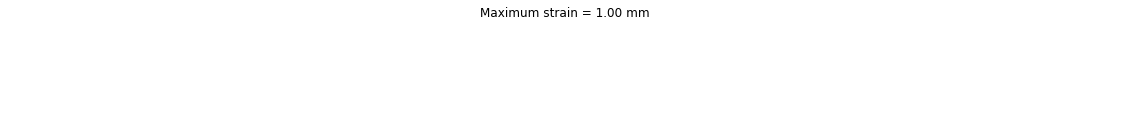

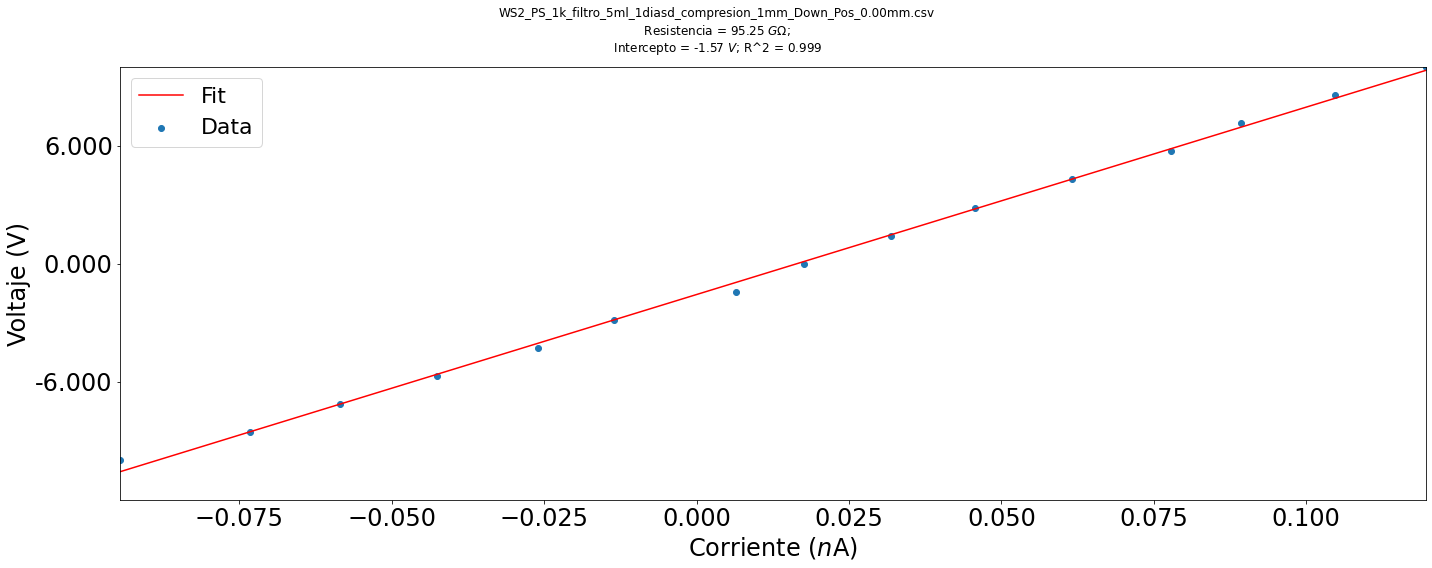

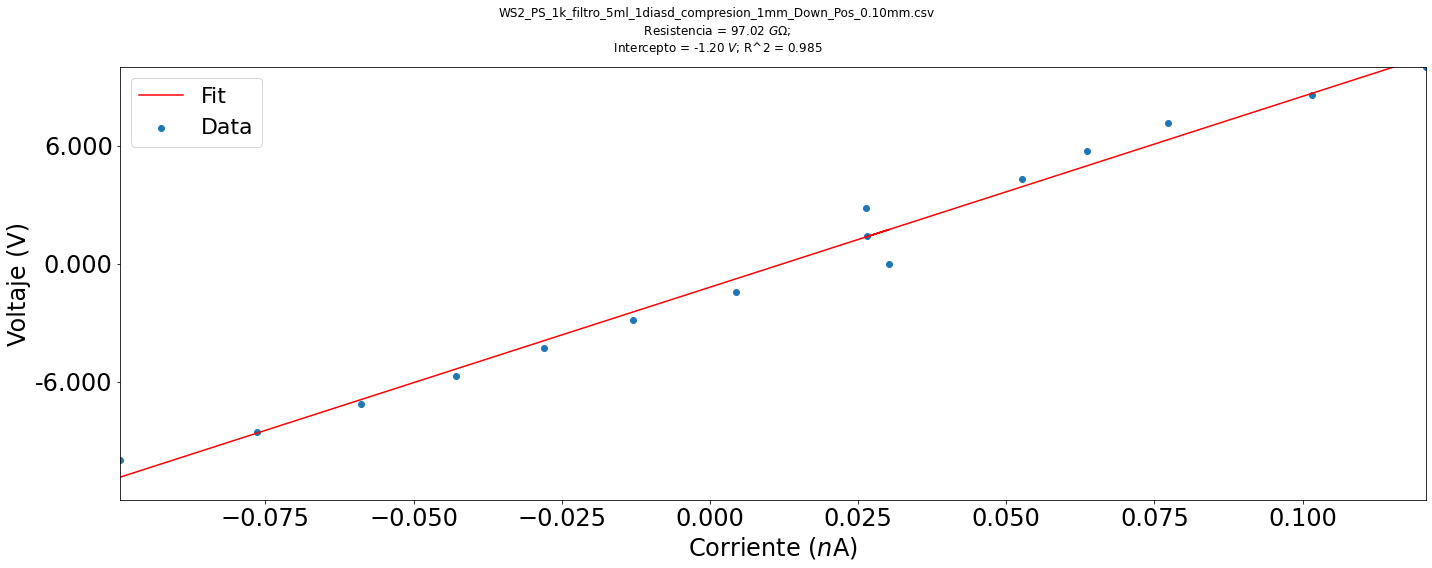

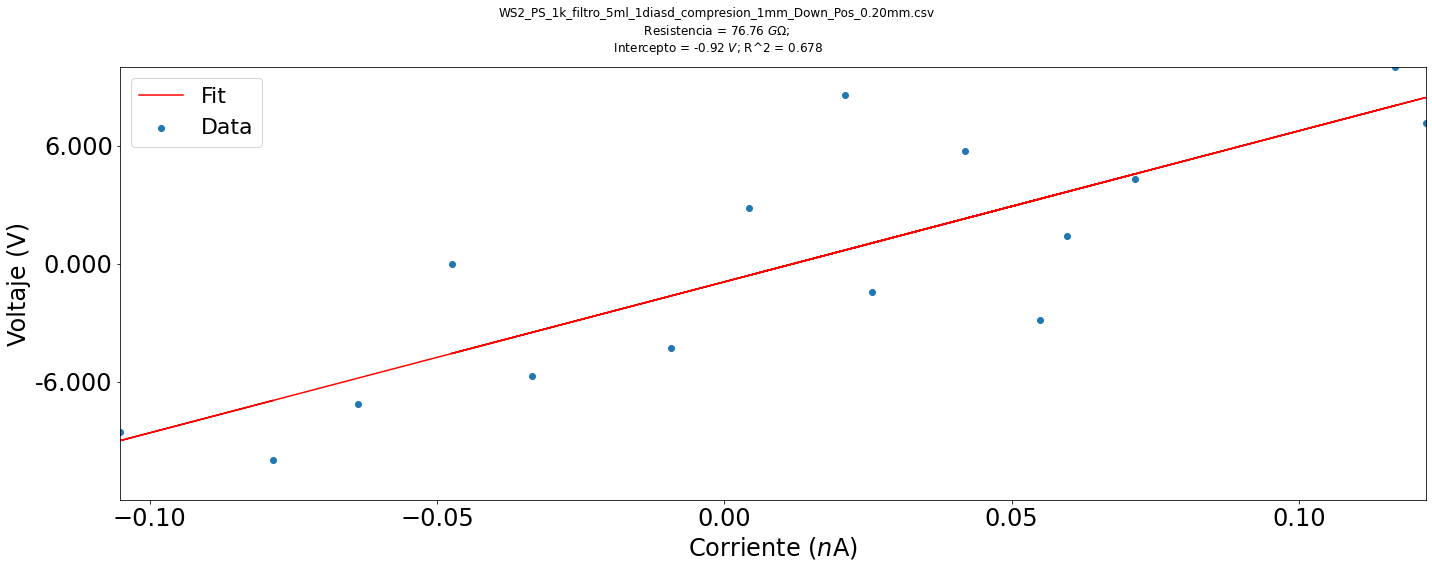

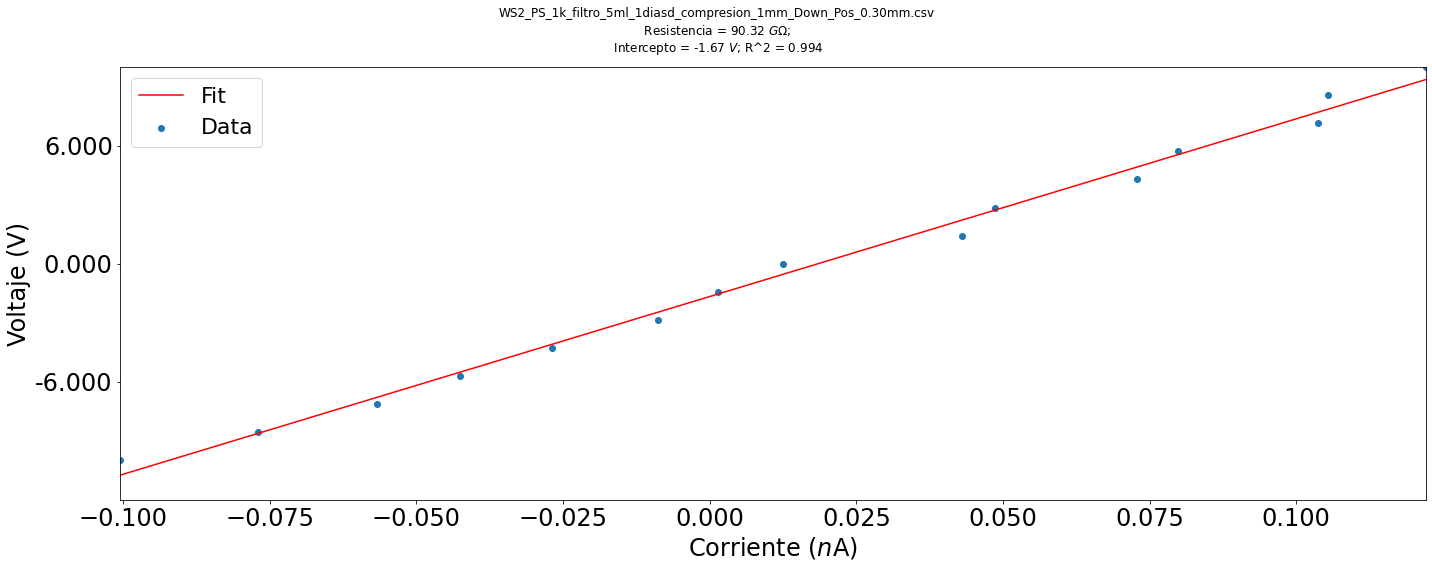

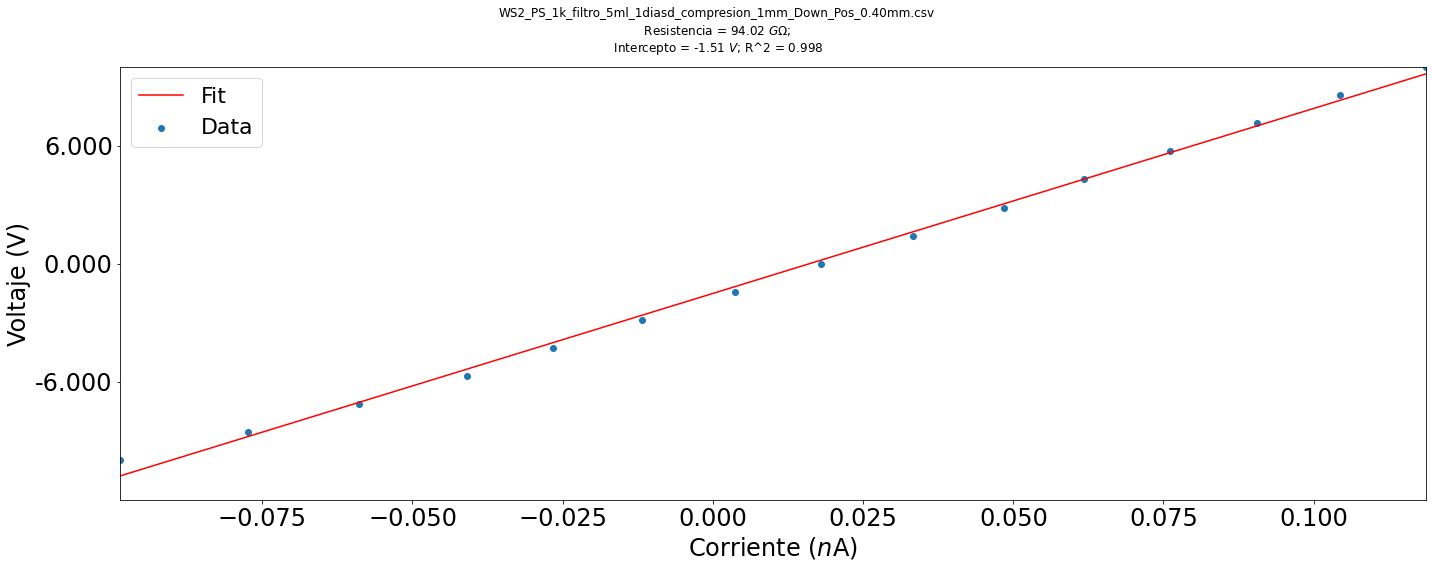

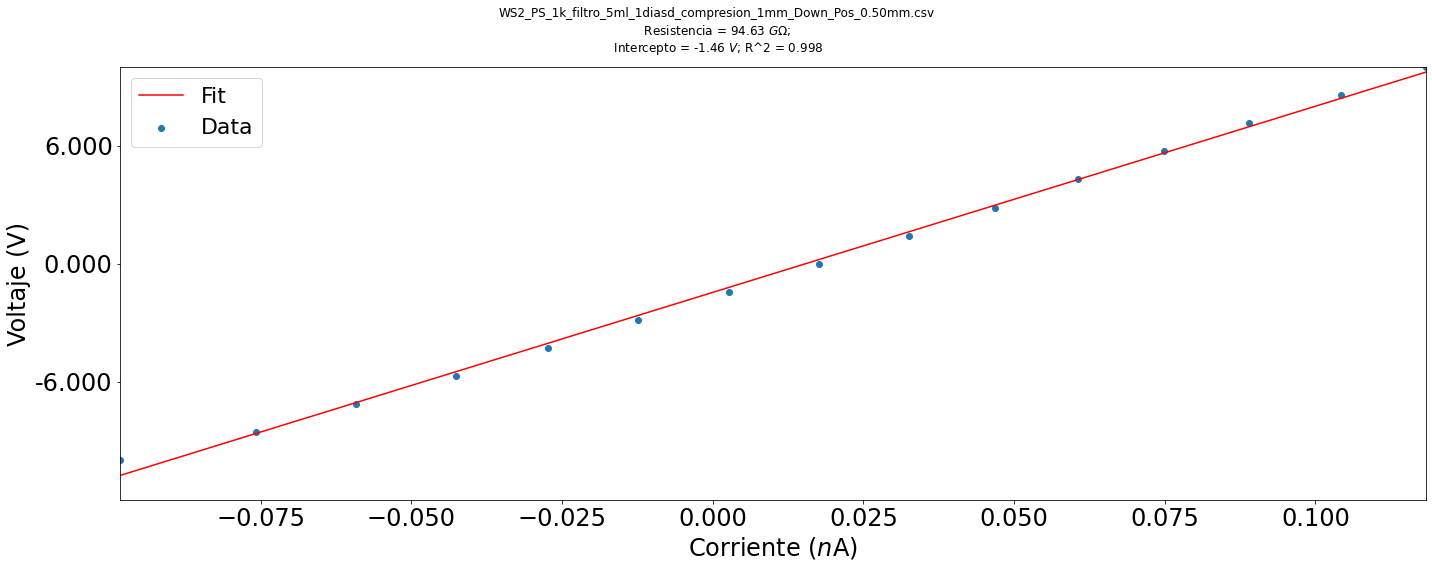

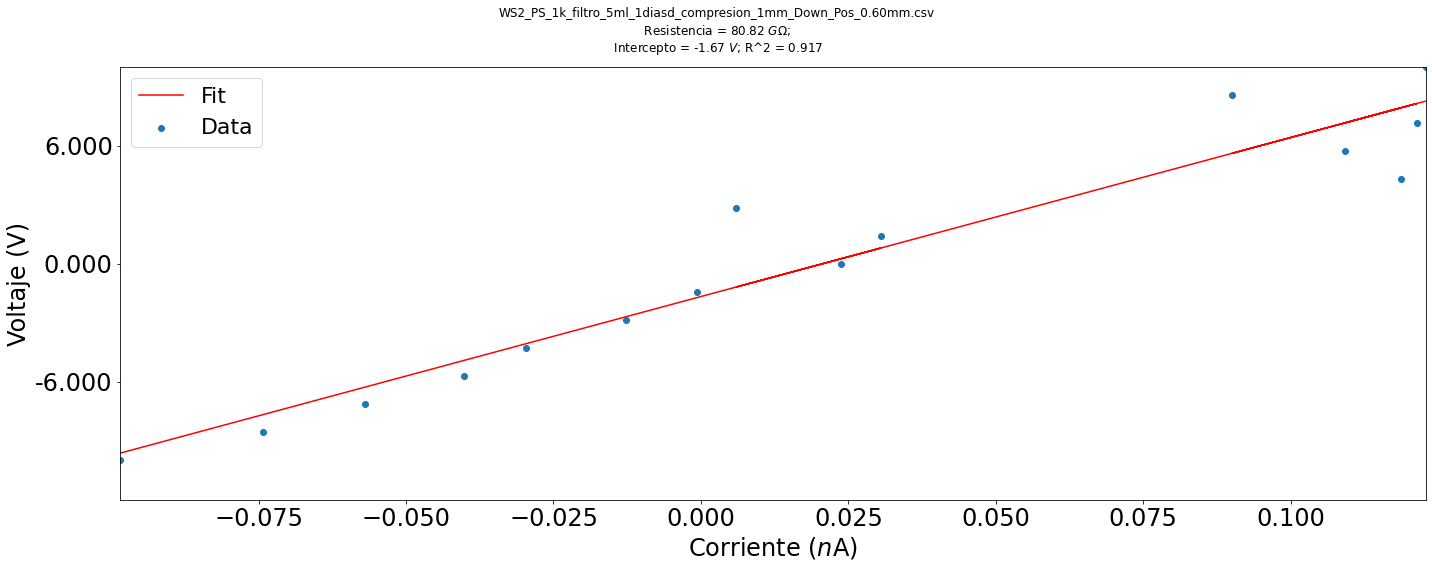

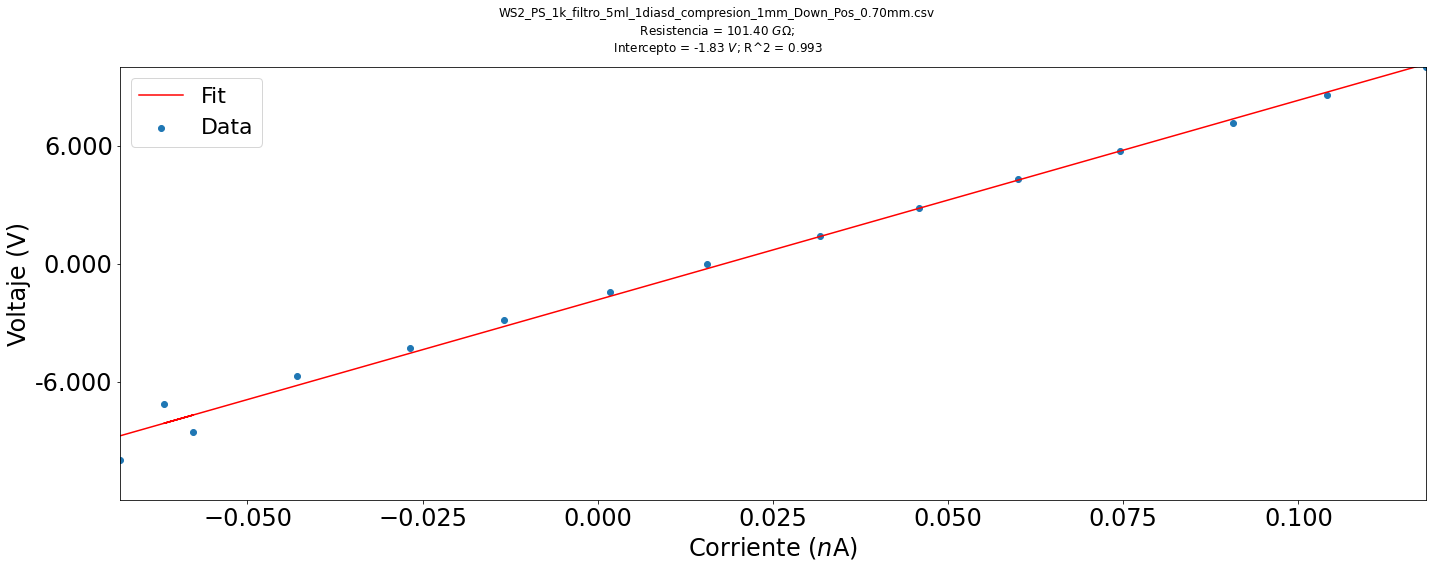

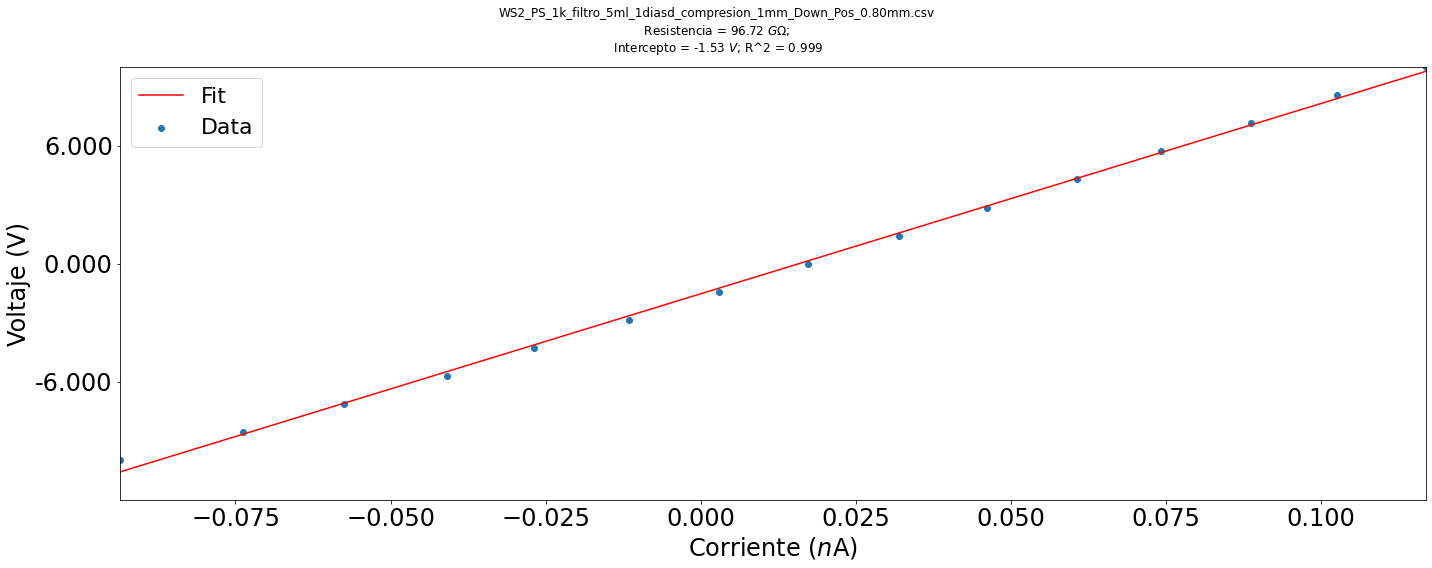

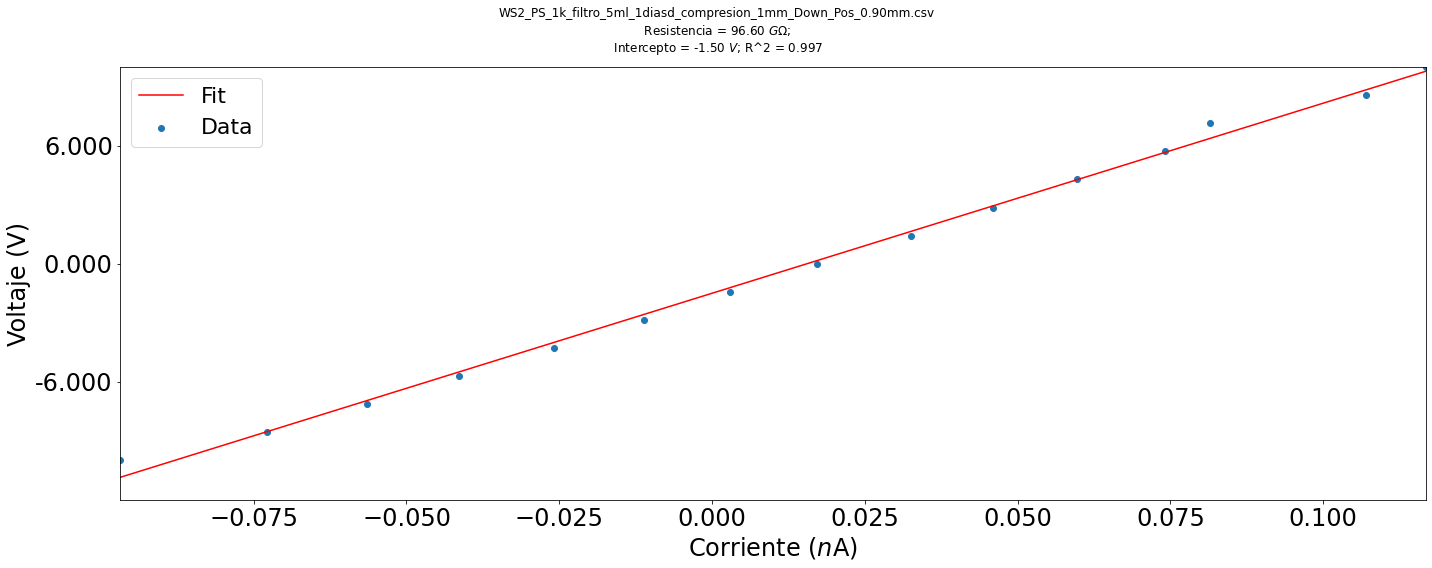

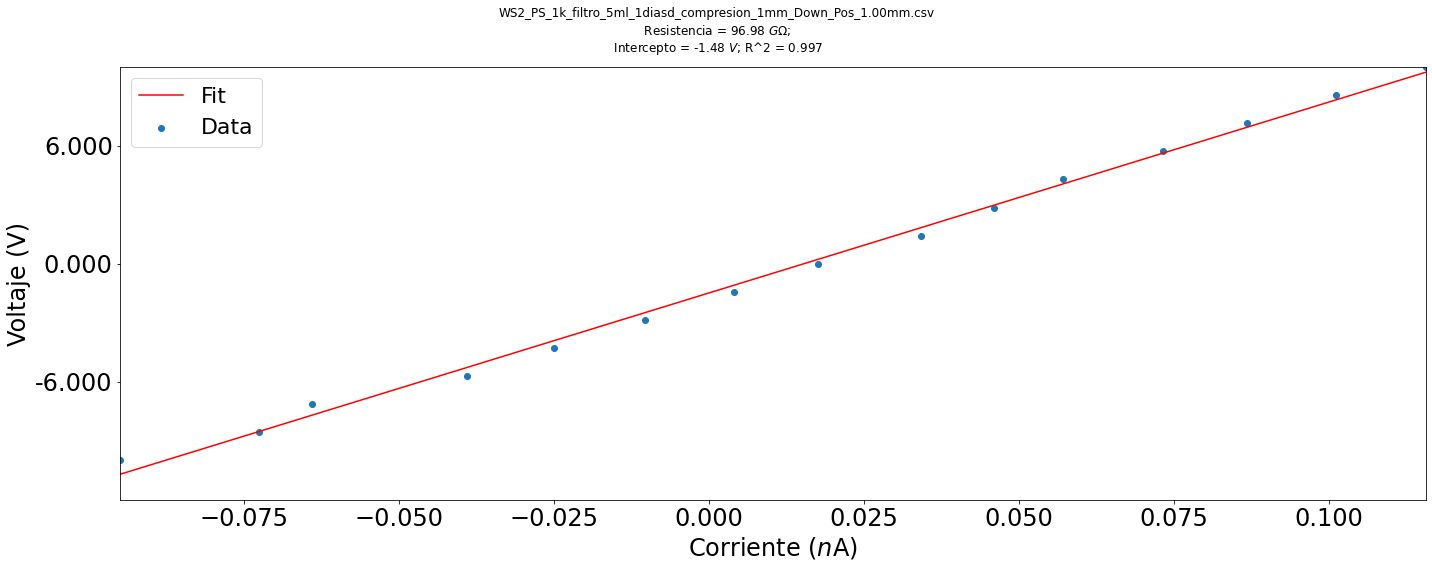

In [164]:
def generate_filenames(strain):
    strainlist = np.around(np.linspace(0,strain,11),2)
    filenames = ['WS2_PS_1k_filtro_5ml_1diasd_compresion_1mm_Down_Pos_{}0mm.csv'.format(e) for e in strainlist]
    return filenames

strain = 1
strainlist = np.linspace(0,strain,11)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(12,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11)

i=0

filenames = generate_filenames(strain)
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('Maximum strain = {}.00 mm'.format(strain))
slopes = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value = extraer_datos_foto(filename,reg)
    slopes.append(m)    
    fig1.suptitle(filename+'\n Resistencia = {:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1
extraer_csv(filename,strainlist,slopes)

print (slopes)
